#  Import Libraries

In [512]:
# Import all the libraries that we shall be using
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import venn
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, balanced_accuracy_score, precision_score, auc, roc_auc_score, roc_curve
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb

# Import Data and Preprocessing

#### PC3 Data

In [2]:
# Install PC3 cancer cell line gene expression
PC3 = pd.read_csv('/Users/ravinschmidl/Desktop/Systems_Bio/ML_and_MV_Stats/Assignment/Code/p8-pc3-camda2020.csv')
PC3 = PC3.sort_values(['CAM_ID'], axis = 0)

#### MCF7 Data

In [3]:
# Install MCF7 cancer cell line gene expression

MCF7 = pd.read_csv('/Users/ravinschmidl/Desktop/Systems_Bio/ML_and_MV_Stats/Assignment/Code/p7-mcf7-camda2020.csv')
MCF7 = MCF7.sort_values(['CAM_ID'], axis = 0)

#### Combine Expression profiles

In [4]:
gene_expression = pd.merge(MCF7, PC3, on = 'CAM_ID', suffixes=('_pc3', '_mcf7'))
key = gene_expression['CAM_ID']


#### TargetLabels

In [5]:
# Install DILI targets; These are the labels for the training and set set.  
    # Only keep binary DILI targets and average score of targets. 
Targets = pd.read_csv('/Users/ravinschmidl/Desktop/Systems_Bio/ML_and_MV_Stats/Assignment/Code/targets-camda2020.csv')
targets = Targets.drop(['DILI2', 'DILI4', 'Training_Validation'], axis = 1)

#Based on research it was hard to identify targets, so instead we're trying to predict which drugs cause the most damage. 
# Identifying drugs that cause more thsn one DILI is crucial. 

In [6]:
#Identifying the label train and test vector
    #Training set contains labells and Test set contains NA values because it is empty.
ytrain = targets[:422]
ytest = targets[422:]

In [7]:
#Initialise feature (x) and label (y) training and set sets. 
xtrain = pd.merge(ytrain['CAM_ID'], gene_expression, on = 'CAM_ID')
xtest = pd.merge(ytest['CAM_ID'], gene_expression, on = 'CAM_ID')
ytrain = pd.merge(gene_expression['CAM_ID'], ytrain, on = 'CAM_ID')
ytest = pd.merge(gene_expression['CAM_ID'], ytest, on = 'CAM_ID')


In [8]:
print(ytrain.shape, xtrain.shape, ytest.shape, xtest.shape)

(415, 5) (415, 24657) (194, 5) (194, 24657)


In [9]:
xtrain = xtrain.set_index('CAM_ID')

In [10]:
xtrain.describe()

5720_pc3     466_pc3    6009_pc3    2309_pc3     387_pc3    3553_pc3  \
count  415.000000  415.000000  415.000000  415.000000  415.000000  415.000000   
mean    -0.113320   -0.182748   -0.030984    0.023114    0.037693    0.250458   
std      0.990700    0.989421    0.822131    1.056915    0.885491    0.878747   
min     -6.509868   -5.695687   -3.897148   -5.829300   -4.648761   -1.659244   
25%     -0.524478   -0.627195   -0.515001   -0.530548   -0.425321   -0.312661   
50%      0.018551   -0.055550   -0.052813   -0.023762   -0.003917    0.122495   
75%      0.412945    0.490797    0.397191    0.551154    0.433120    0.688565   
max      2.876085    2.208701    3.455700    4.420281    4.471329    5.371536   

          427_pc3    5898_pc3   23365_pc3    6657_pc3  ...   2931_mcf7  \
count  415.000000  415.000000  415.000000  415.000000  ...  415.000000   
mean     0.067036   -0.229218    0.035884    0.283974  ...    0.163113   
std      0.879400    1.006693    0.813351    0.862939  ...    0.881503   
min     -3.206841   -4.586658   -3.660804   -1.421000  ...   -1.808111   
25%     -0.493380   -0.642675   -0.431470   -0.317209  ...   -0.409048   
50%      0.040879   -0.059717    0.054088    0.162741  ...    0.103641   
75%      0.574630    0.306941    0.426220    0.758740  ...    0.595452   
max      3.859636    4.388584    4.901399    5.547956  ...    5.224118   

       63876_mcf7  51275_mcf7  158747_mcf7  283232_mcf7  25960_mcf7  \
count  415.000000  415.000000   415.000000   415.000000  415.000000   
mean     0.035888   -0.058599     0.013876     0.073182    0.056430   
std      0.726181    0.846846     0.809555     0.882673    0.716632   
min     -1.716400   -5.346248    -2.062603    -2.283488   -2.423150   
25%     -0.453285   -0.496591    -0.499709    -0.443430   -0.481893   
50%     -0.023450   -0.043450    -0.054409    -0.060039    0.054100   
75%      0.464264    0.463180     0.436502     0.484786    0.489863   
max      2.547363    2.966700     3.385280     5.791200    3.323357   

        6376_mcf7  11033_mcf7  54869_mcf7     60_mcf7  
count  415.000000  415.000000  415.000000  415.000000  
mean    -0.006443    0.066566    0.087436   -0.030709  
std      0.685612    0.761367    0.831843    0.756054  
min     -2.272900   -2.018950   -1.825375   -5.065700  
25%     -0.466332   -0.435060   -0.434950   -0.421289  
50%     -0.006650    0.029945    0.044650    0.012347  
75%      0.454166    0.446686    0.542795    0.442044  
max      2.222550    2.935350    3.788171    2.034174  

[8 rows x 24656 columns]

In [11]:
xtest = xtest.set_index('CAM_ID')
X_train = xtrain.T
X_test = xtest.T

In [12]:
## Save these for later
Final_Train = X_train
Final_Test = X_test

In [13]:
print(ytrain.shape, X_train.shape, ytest.shape, X_test.shape)

(415, 5) (24656, 415) (194, 5) (24656, 194)


In [14]:
X_test

CAM_ID      CAM00002  CAM00004  CAM00009  CAM00013  CAM00015  CAM00016  \
5720_pc3    0.408504  3.335394 -0.325160  0.034387  0.499007  0.443312   
466_pc3     0.038143 -0.687689  0.317163  0.514730 -1.155830  0.371573   
6009_pc3    0.741935 -0.294417  0.420525 -0.980858  1.370047  0.472075   
2309_pc3    0.766322 -0.899050 -0.052758 -0.472996  2.224626 -0.486094   
387_pc3    -0.008809  0.044465  0.406721 -0.330107  2.978647 -0.178173   
...              ...       ...       ...       ...       ...       ...   
25960_mcf7  0.135420  1.136600 -0.253400 -0.502197 -1.192829  0.305600   
6376_mcf7  -0.135997  0.875012 -0.175550  0.075728 -1.833360  2.040750   
11033_mcf7 -0.097094 -0.598213  1.288250 -0.532949 -0.346887  0.839850   
54869_mcf7 -0.167908  0.432464  1.581450 -1.368372 -0.679235  1.659450   
60_mcf7    -0.444487  0.150902 -0.405300 -0.214233  0.512255 -0.412100   

CAM_ID      CAM00027  CAM00029  CAM00031  CAM00032  ...  CAM00584  CAM00585  \
5720_pc3    0.132978 -0.059499  1.646590 -0.431200  ... -1.061900  1.890974   
466_pc3     0.203268  0.822988 -2.488786 -1.743425  ...  0.927450 -1.058329   
6009_pc3   -1.340709  0.321470  1.104052 -0.452350  ... -0.317600 -1.292829   
2309_pc3    0.861415  0.003381 -0.882257  1.138675  ...  1.288100 -0.092286   
387_pc3     0.305316  0.379901  1.243477  0.443325  ...  0.212600 -0.542082   
...              ...       ...       ...       ...  ...       ...       ...   
25960_mcf7 -0.005112 -0.710285 -0.027900  0.288400  ...  0.155828 -0.291150   
6376_mcf7  -0.747551 -0.047851 -0.556700 -0.767050  ...  0.403116 -0.352050   
11033_mcf7 -1.486273 -1.188609 -0.052700  0.538150  ...  0.512582  0.395750   
54869_mcf7 -0.295274 -0.428329 -0.191250 -0.527100  ...  0.124414 -0.830250   
60_mcf7    -0.584837  0.515054  0.081600  0.140200  ... -0.276235 -1.108750   

CAM_ID      CAM00586  CAM00587  CAM00589  CAM00594  CAM00595  CAM00605  \
5720_pc3    0.068393  0.875328  0.386600 -1.183243  0.841720  0.641842   
466_pc3     0.620633  0.700585 -3.339050  0.569382  0.481604  0.820597   
6009_pc3   -0.437020  0.049872  0.437000 -3.351501 -0.634371 -0.281995   
2309_pc3    0.763212 -0.229508  0.050100 -0.606948 -0.516848  0.393586   
387_pc3    -0.215012 -0.487020  0.171550 -0.463188  0.770044 -0.140803   
...              ...       ...       ...       ...       ...       ...   
25960_mcf7 -0.144750  0.099250 -0.230424  0.257167 -0.353850 -0.344682   
6376_mcf7   0.073150 -0.246450  1.289005 -1.163267  0.397800 -0.540293   
11033_mcf7 -0.136700 -0.230850  1.312149  0.661000 -0.466350 -0.897843   
54869_mcf7 -1.279900 -0.363450  0.681066  1.184500 -0.115450 -0.618915   
60_mcf7    -0.218900 -0.304550  0.091698  0.627367 -0.340750  1.149859   

CAM_ID      CAM00606  CAM00608  
5720_pc3   -1.523530 -0.321432  
466_pc3    -1.200936  0.297496  
6009_pc3    0.041703 -0.020627  
2309_pc3   -0.217433 -0.787703  
387_pc3     1.428537 -0.658062  
...              ...       ...  
25960_mcf7 -0.231559 -0.316868  
6376_mcf7  -0.948299  0.514897  
11033_mcf7 -0.776312  0.019259  
54869_mcf7  0.087206 -0.511441  
60_mcf7     0.398137 -0.394779  

[24656 rows x 194 columns]

In [15]:
#As train and test sets can only have numeric data and using string/char in index is hard;
    # set a train and test key to identify drugs.
    # each column is a drug in the train and each row is a drug in the test. 
ytrain = ytrain.set_index('CAM_ID')
ytest = ytest.set_index('CAM_ID')


In [16]:
X_train = X_train.astype(float, 64)
X_test = X_test.astype(float, 64)

In [17]:
# Apply the same scaling to both datasets
scaler = StandardScaler()
X_train_scld = scaler.fit_transform(X_train)
X_test_scld = scaler.fit_transform(X_test) 

## PCA

In [18]:
pca = PCA()
pca.fit_transform(X_train)

array([[-1.29320899e+01, -3.64678276e-01, -3.02691625e+00, ...,
        -2.19733496e-02, -3.22720495e-02,  3.90019315e-01],
       [-1.29421595e+01, -4.80993799e+00,  3.85604471e+00, ...,
        -1.31914497e-02,  1.40006389e-01,  1.06568586e-01],
       [-3.76219074e+00,  9.19883134e-01,  1.28215805e+00, ...,
         2.20436100e-01,  2.41710972e-01, -2.24636145e-01],
       ...,
       [ 3.79073539e+00, -4.71078379e+00, -7.86692568e-01, ...,
        -3.23717016e-01,  2.22517629e-01,  2.23506980e-02],
       [ 3.33807630e+00, -6.57334556e+00, -3.78954860e+00, ...,
        -4.28905328e-02, -1.45091425e-01, -1.75536324e-02],
       [-7.48675260e+00,  4.01244433e+00, -4.25699461e+00, ...,
         2.60601693e-01,  5.46021895e-03, -8.75741014e-02]])

Number of features that explain ~90% variance:  83


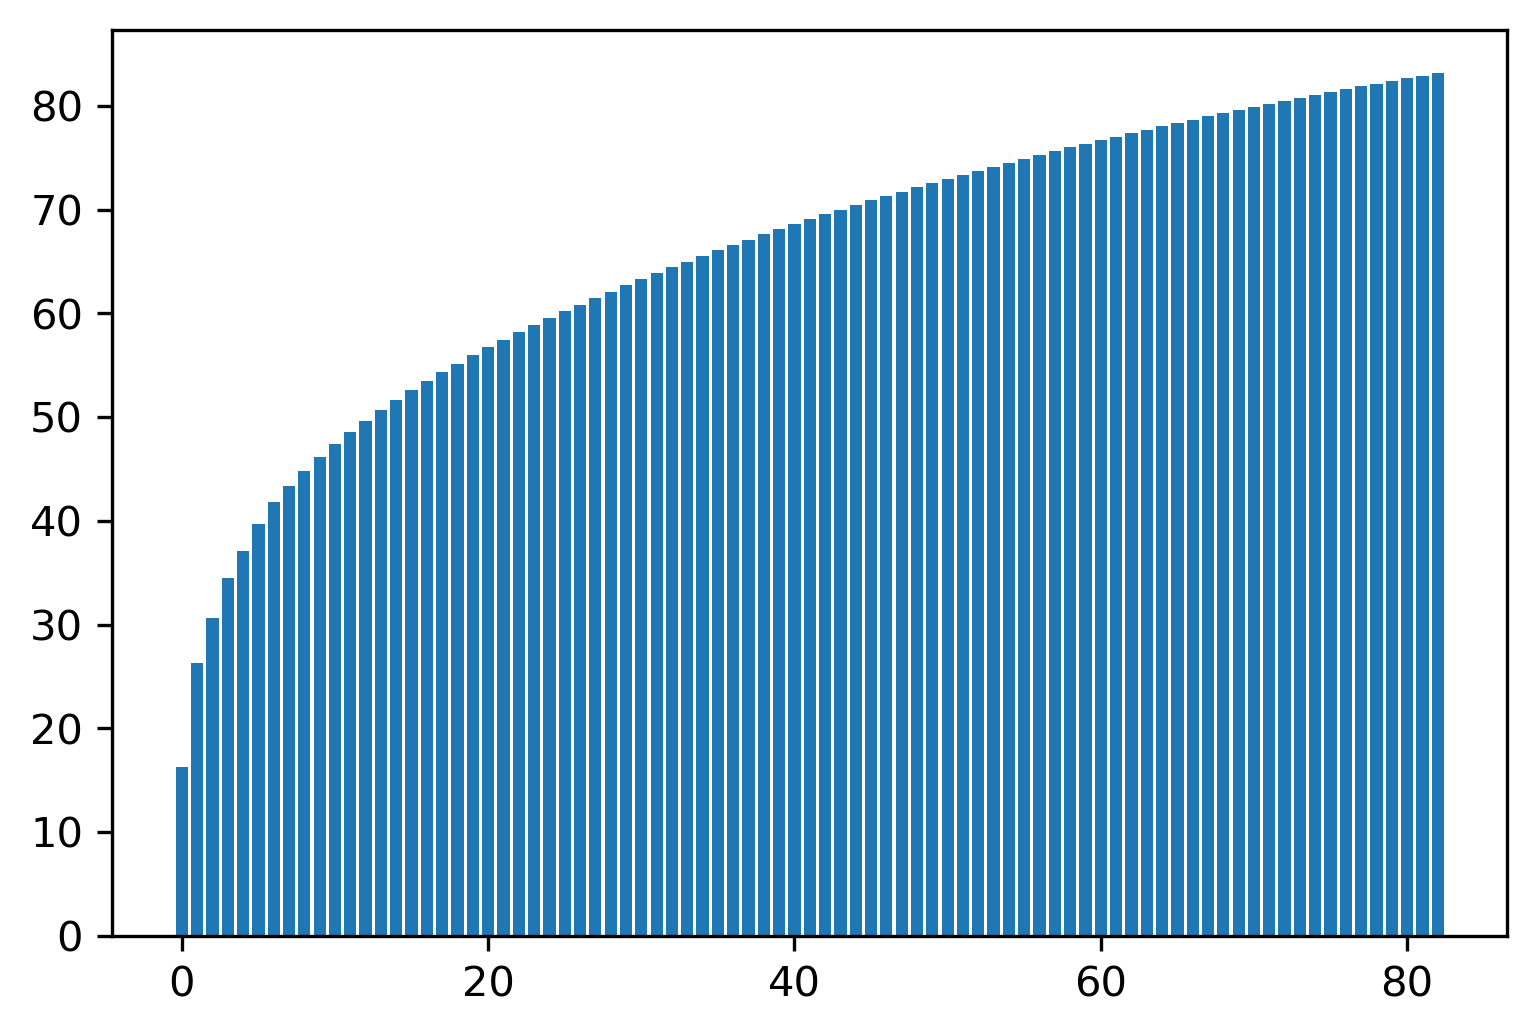

In [267]:
total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1
    
print("Number of features that explain ~90% variance: ", k)
pca = PCA(n_components=k)
X_train.pca = pca.fit(X_train)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp);

[]

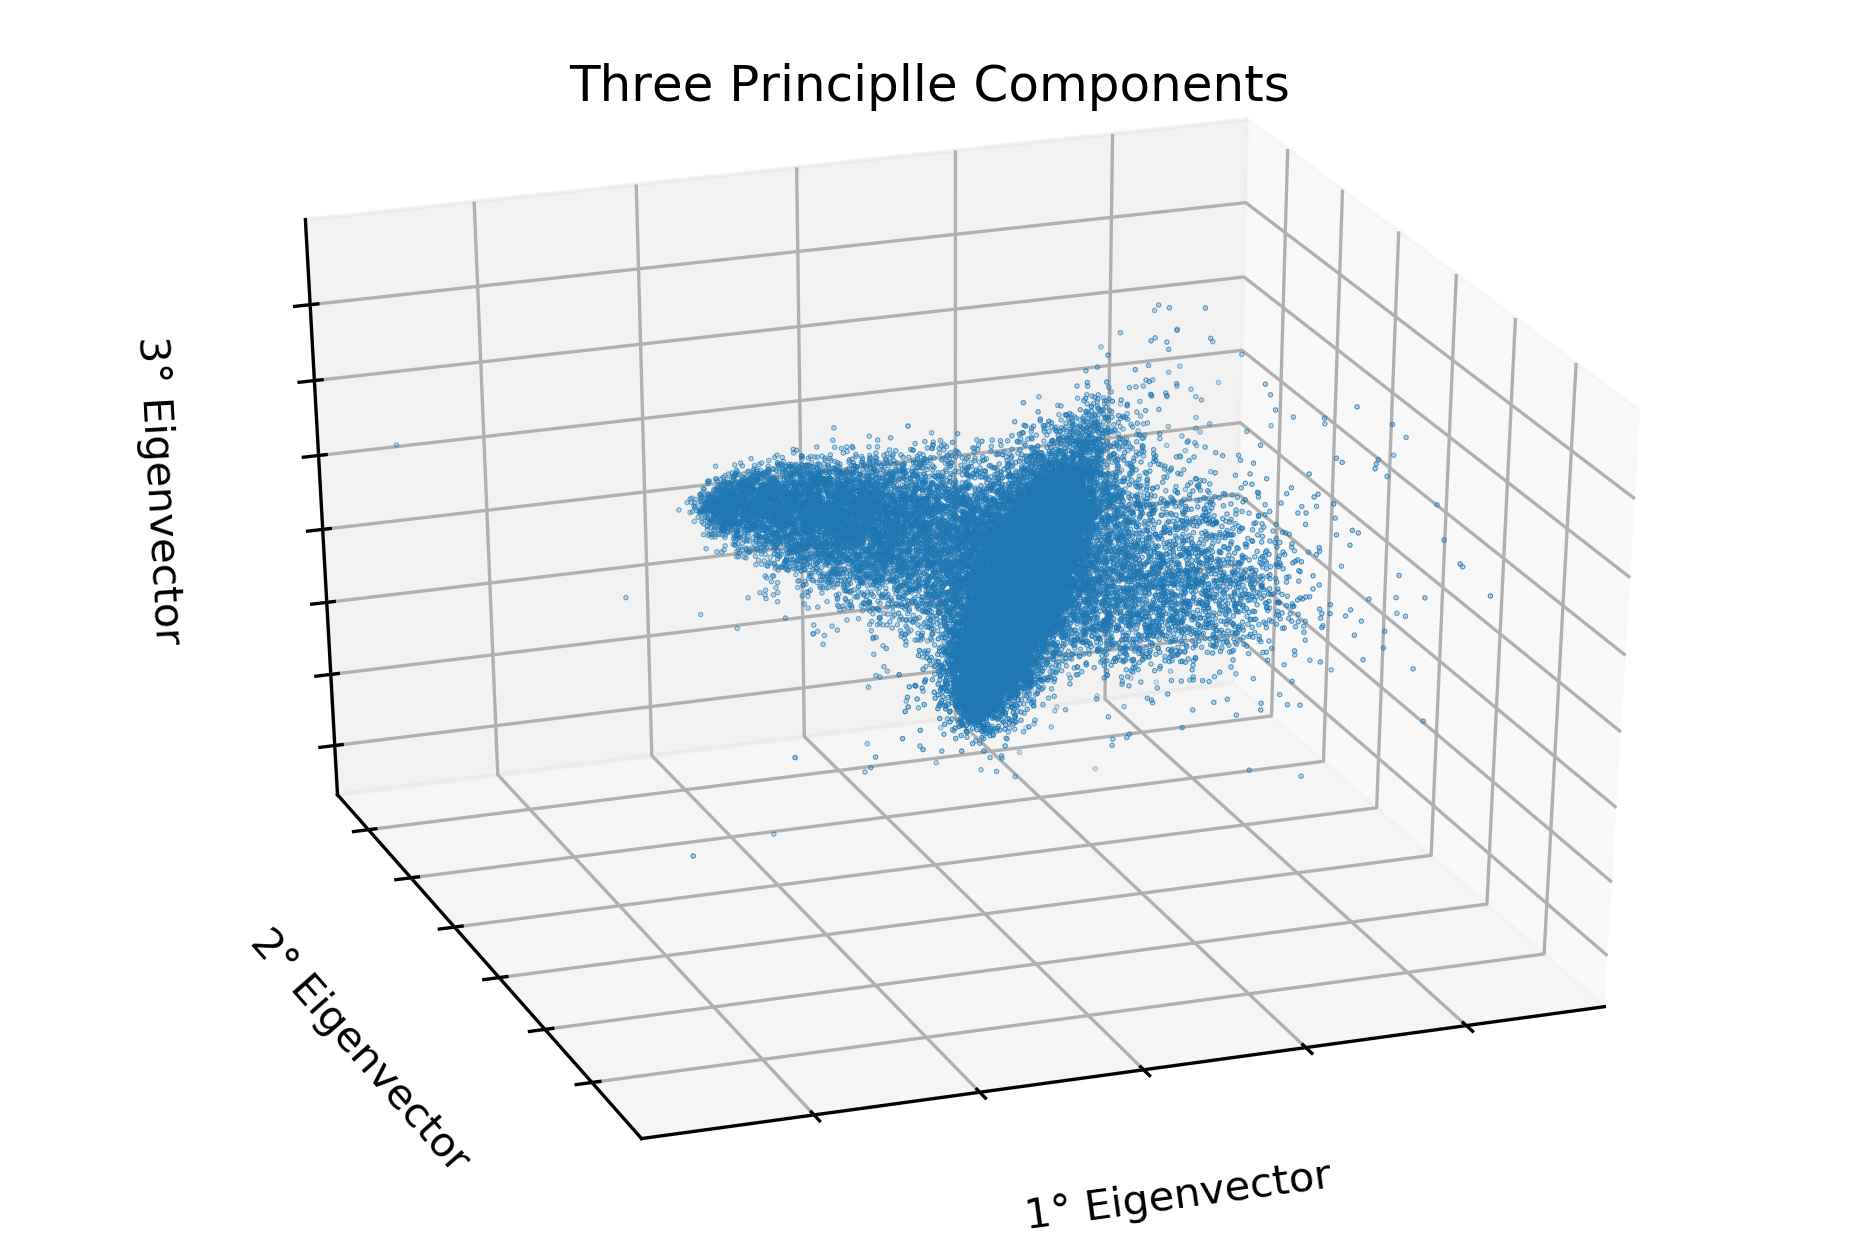

In [268]:
pca_3c = PCA(n_components=3).fit(X_train)
X_train_PCA = pca_3c.fit_transform(X_train)

plt.clf()
fig = plt.figure(1, figsize=(10,6 ))
ax = Axes3D(fig, elev=-150, azim=110,)
ax.scatter(X_train_PCA[:, 0], X_train_PCA[:, 1], X_train_PCA[:, 2], s = 0.1)
ax.set_title("Three Principlle Components")
ax.set_xlabel("1° Eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2° Eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3° Eigenvector")
ax.w_zaxis.set_ticklabels([])

Text(0.5, 1.0, '2D Transformation of the Above Graph')

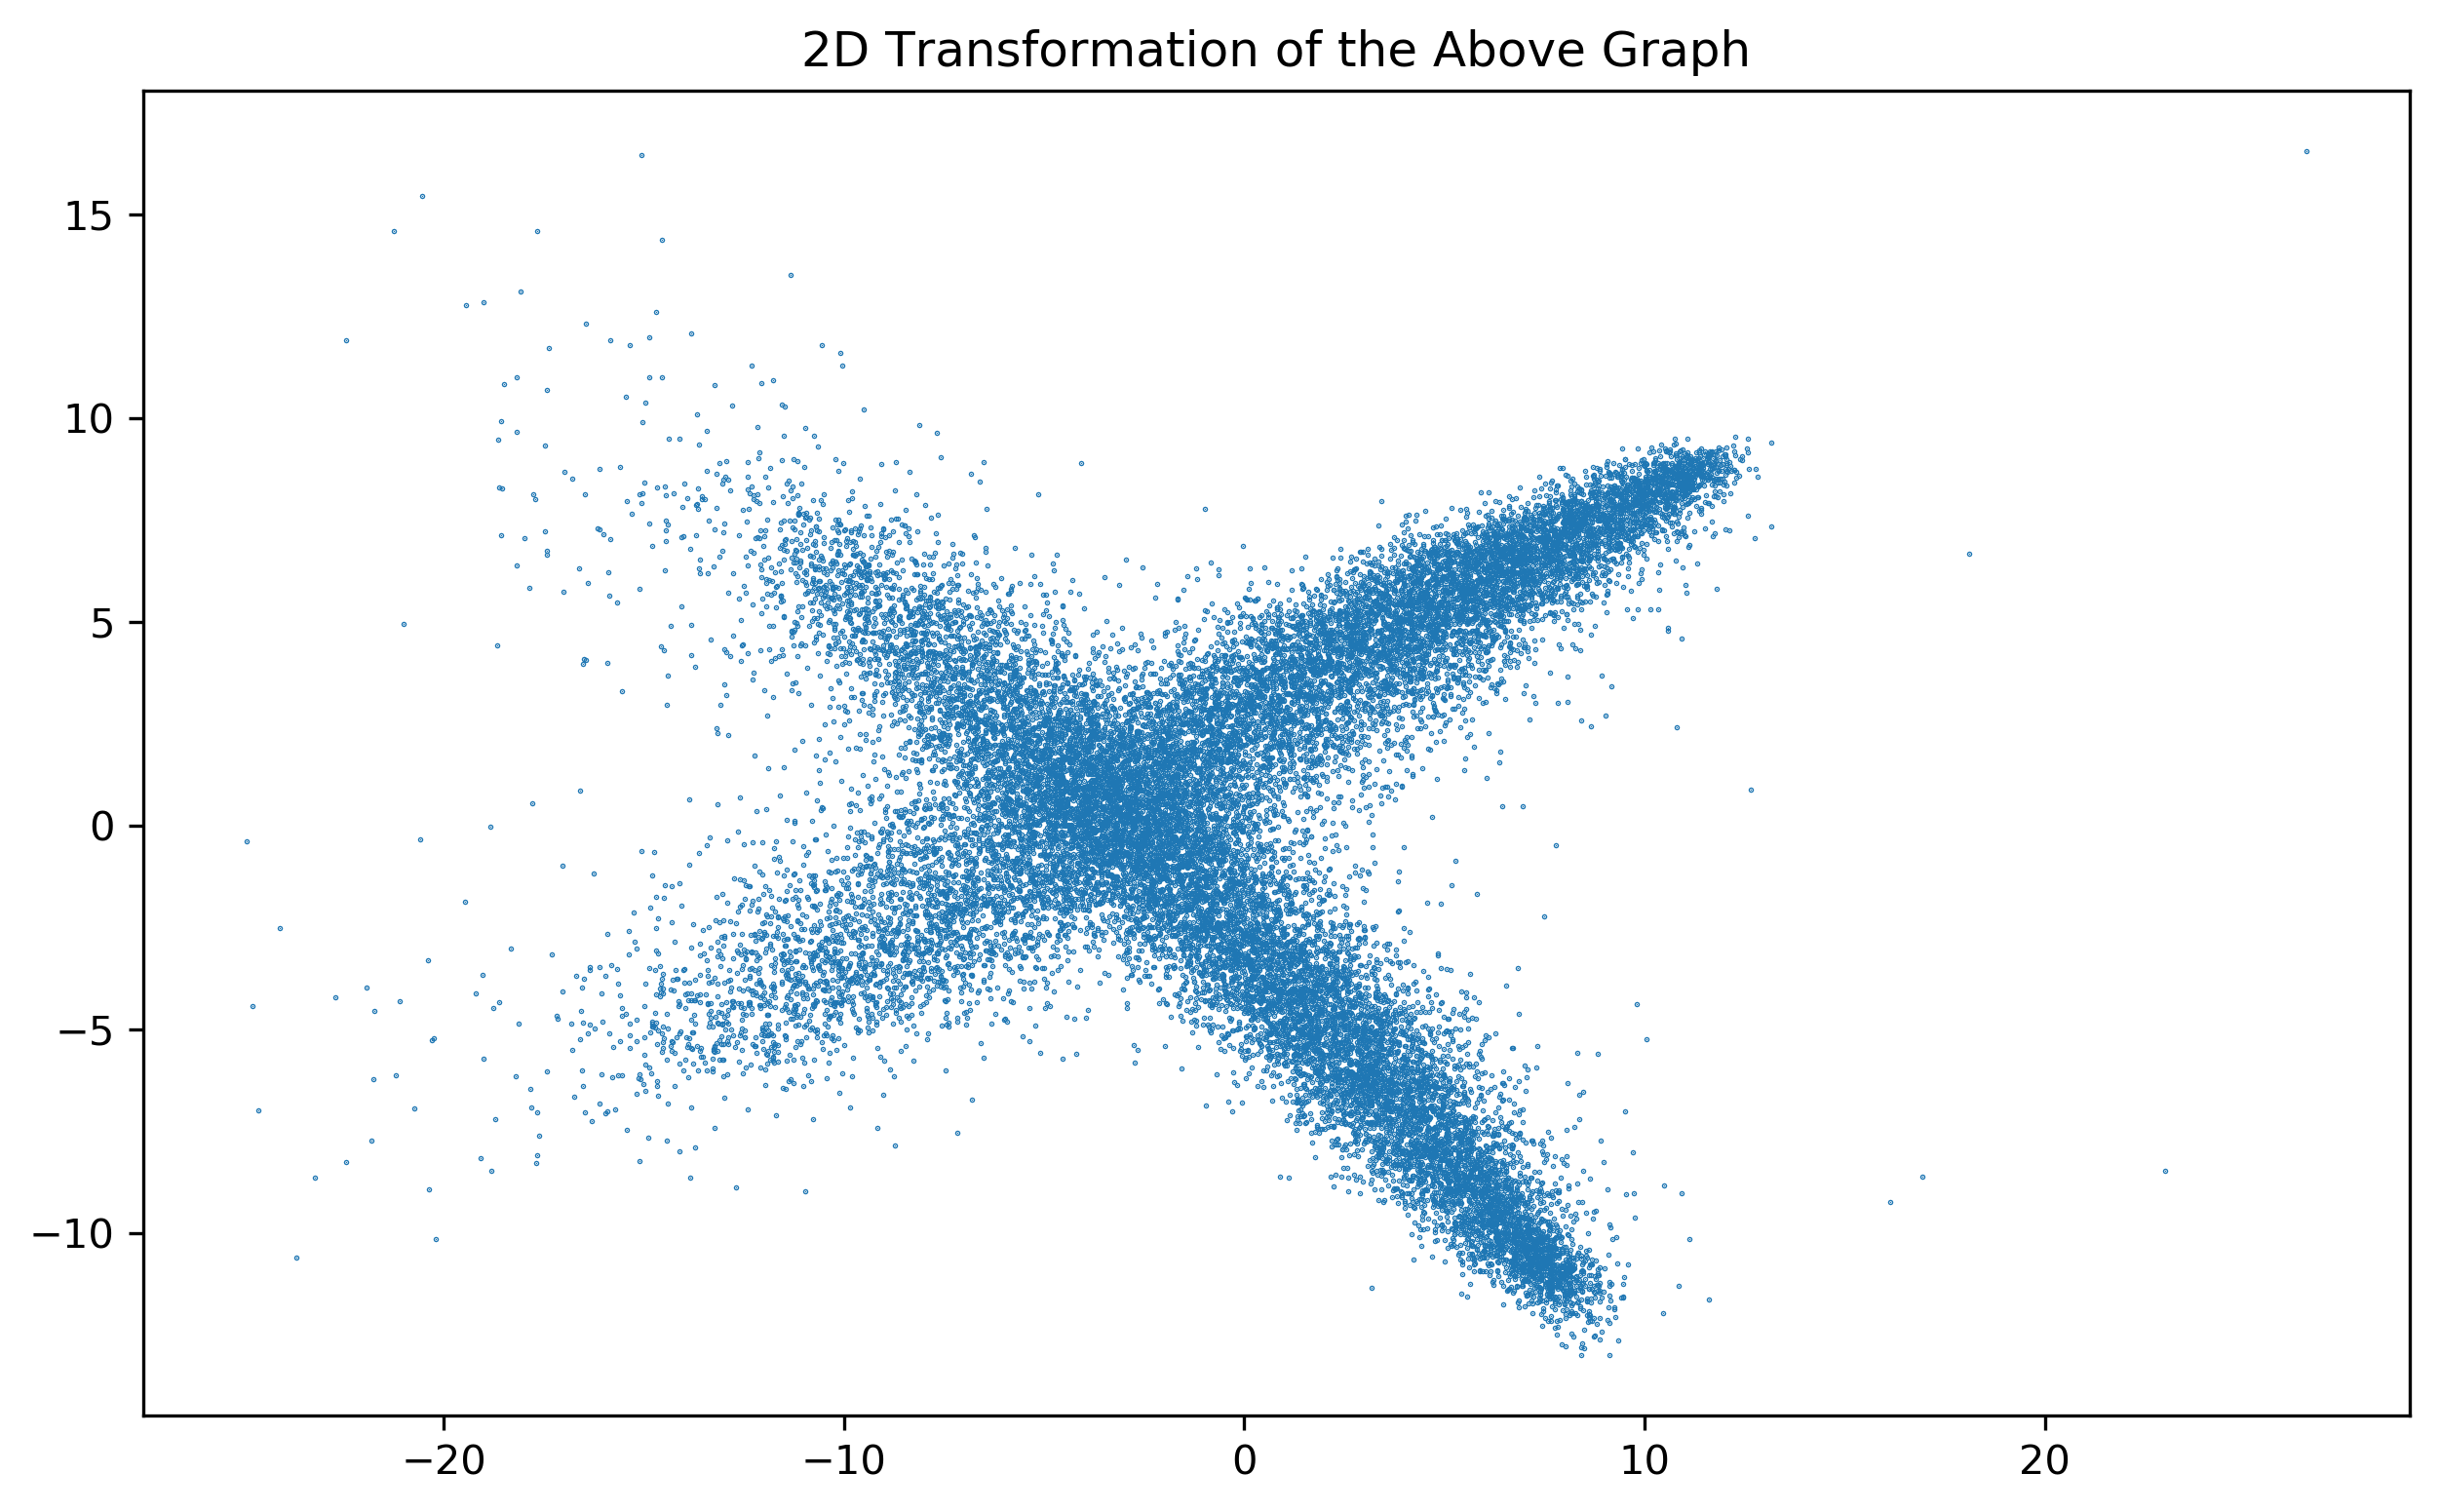

In [269]:
fig = plt.figure(1, figsize = (10, 6))
plt.scatter(X_train_PCA[:, 0],  X_train_PCA[:, 1], s = 0.1)
plt.title("2D Transformation of the Above Graph")

# Plots

## ROC

In [23]:
def plotROC(fpr, tpr, roc_auc):   
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

## Confusion Matrix Heatmap

In [24]:
#Confusion Matrix
def cM(y_test, pred):
    cm = confusion_matrix(y_test, pred)

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Greens') 

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.xaxis.set_ticklabels(['No DILI', 'DILI']) 
    ax.yaxis.set_ticklabels(['No DILI', 'DILI'], rotation=360)

### Building and Validation with Training Set only

In [25]:
#We want to see how accurate our models are; so we will do this with our training data. 
    #Split X_train and y_train into and 80/20 train/test split to test accuracy
    
A_train, A_test, B_train, B_test= train_test_split(X_train.T, ytrain, test_size = 0.2, random_state = 42)

In [26]:
print(B_train.shape, A_train.shape, B_test.shape, A_test.shape)
print(ytrain.shape, X_train.shape, ytest.shape, X_test.shape)


(332, 4) (332, 24656) (83, 4) (83, 24656)
(415, 4) (24656, 415) (194, 4) (24656, 194)


### K-Fold Cross Validation

In [27]:
def crossVal(mod, X, y, n):
    kfold = KFold(n_splits = n, random_state = 42)
    result = cross_val_score(mod, X, y, cv = kfold, scoring = 'accuracy')
    print("Cross Validation result: ", result.mean(), "number of kFold splits: ", n)
    return(result)

## Hyperparameter Tuning
### Grid Search and Randomised Search
 gSearch and rSearch immplement grid and randomised search respectively, for hyperparameter tuning. 
 Fine tunes hyperparameters for certain methods. If gSearch takes too long, use rSearch instead. 

In [28]:
def gSearch(grid_params, mod, X, y):

    gs = GridSearchCV(
        mod,
        grid_params,
        verbose = 1,
        cv =10,
        n_jobs = 1
    )

    gs.results = gs.fit(X, y)
    return(gs.results)

In [462]:
def rSearch(grid_params, mod, X, y):

    gs = RandomizedSearchCV(
        mod,
        grid_params,
        verbose = 1,
        cv = 3,
        n_jobs = 2
    )

    gs.results = gs.fit(X, y)
    return(gs.results)

## K-Nearest Neighbours

#### Hyperparameter tuning

In [30]:
#Initialise a grid of parameters to test over. 
grid_params_KNN = {
        'n_neighbors': [1,3,5,11,25,51,99],
        'weights': ['uniform', 'distance'],
        'metric': ['manhattan', 'euclidean']
    }

KNN_result_DILI1 = gSearch(grid_params_KNN, KNeighborsClassifier(), A_train, B_train['DILI1'])
KNN_result_DILI3 = gSearch(grid_params_KNN, KNeighborsClassifier(), A_train, B_train['DILI3'])
KNN_result_DILI5 = gSearch(grid_params_KNN, KNeighborsClassifier(), A_train, B_train['DILI5'])
KNN_result_DILI6 = gSearch(grid_params_KNN, KNeighborsClassifier(), A_train, B_train['DILI6'])

print("DILI1")
print("Best Score: ", KNN_result_DILI1.best_score_)
print("Best Estimator: ", KNN_result_DILI1.best_estimator_)
print("Best Params: ", KNN_result_DILI1.best_params_)

print("DILI3")
print("Best Score: ", KNN_result_DILI3.best_score_)
print("Best Estimator: ", KNN_result_DILI3.best_estimator_)
print("Best Params: ", KNN_result_DILI3.best_params_)

print("DILI5")
print("Best Score: ", KNN_result_DILI5.best_score_)
print("Best Estimator: ", KNN_result_DILI5.best_estimator_)
print("Best Params: ", KNN_result_DILI5.best_params_)

print("DILI6")
print("Best Score: ", KNN_result_DILI6.best_score_)
print("Best Estimator: ", KNN_result_DILI6.best_estimator_)
print("Best Params: ", KNN_result_DILI6.best_params_)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed: 20.8min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed: 22.5min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed: 19.2min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 28 candidates, totalling 280 fits
DILI1
Best Score:  0.7831325301204819
Best Estimator:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=None, n_neighbors=11, p=2,
           weights='uniform')
Best Params:  {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
DILI3
Best Score:  0.6295180722891566
Best Estimator:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=51, p=2,
           weights='uniform')
Best Params:  {'metric': 'euclidean', 'n_neighbors': 51, 'weights': 'uniform'}
DILI5
Best Score:  0.5240963855421686
Best Estimator:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=11, p=2,
           weights='uniform')
Best Params:  {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
DILI6
Best Score:  0.6024096385

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed: 18.7min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


#### KNN
Function with KNN that returns predictions, probabilities, score and cross validation value. 
The inputs are the parameters specified by the previous grid search. 

In [31]:
def kNN(X_train, X_test, y_train, n, w, m):
    neighbours = KNeighborsClassifier(n_neighbors = n, weights = w, metric = m)
    
    #Train
    neighbours = neighbours.fit(X_train, y_train)
    score = neighbours.score(X_train, y_train)
    
    #Test
    predictions = neighbours.predict(X_test)
    y_prob = neighbours.predict_proba(X_test)
    
    #Cross_Validation
    cross_Val = crossVal(neighbours, X_train, y_train, 10)

    return(predictions, y_prob, score, cross_Val)

In [32]:
p_kNN_DILI1, y_kNN_DILI1, s_kNN_DILI1, cv_kNN_DILI1 = kNN(A_train, #Training Set
                                                          A_test, #Test Set
                                                          B_train['DILI1'], #Training labels
                                                          11, #n_neighbours                                            
                                                          'uniform', #weights
                                                          'manhattan') #metric
p_kNN_DILI3, y_kNN_DILI3, s_kNN_DILI3, cv_kNN_DILI3 = kNN(A_train, 
                                                          A_test, 
                                                          B_train['DILI3'],
                                                          51,
                                                          'uniform',
                                                          'euclidean')
p_kNN_DILI5, y_kNN_DILI5, s_kNN_DILI5, cv_kNN_DILI5 = kNN(A_train, 
                                                          A_test, 
                                                          B_train['DILI5'],
                                                          11,
                                                          'uniform',
                                                          'euclidean')
p_kNN_DILI6, y_kNN_DILI6, s_kNN_DILI6, cv_kNN_DILI6 = kNN(A_train, 
                                                          A_test, 
                                                          B_train['DILI6'],
                                                          5,
                                                          'uniform',
                                                          'euclidean')

Cross Validation result:  0.7799465240641712 number of kFold splits:  10
Cross Validation result:  0.6145276292335116 number of kFold splits:  10
Cross Validation result:  0.527005347593583 number of kFold splits:  10
Cross Validation result:  0.6114081996434938 number of kFold splits:  10


#### Calculate Accuracy

In [33]:
print('K-means accuracy (DILI1): ', round(accuracy_score(B_test.iloc[:,0], p_kNN_DILI1), 3))
print('K-means accuracy (DILI3): ', round(accuracy_score(B_test.iloc[:,1], p_kNN_DILI3), 3))
print('K-means accuracy (DILI5): ', round(accuracy_score(B_test.iloc[:,2], p_kNN_DILI5), 3))
print('K-means accuracy (DILI6): ', round(accuracy_score(B_test.iloc[:,3], p_kNN_DILI6), 3))

K-means accuracy (DILI1):  0.747
K-means accuracy (DILI3):  0.602
K-means accuracy (DILI5):  0.494
K-means accuracy (DILI6):  0.614


#### Calculate Balanced Accurace

In [34]:
print('K-means balanced accuracy (DILI1): ', round(balanced_accuracy_score(B_test.iloc[:,0], p_kNN_DILI1), 3))
print('K-means balanced accuracy (DILI3): ', round(balanced_accuracy_score(B_test.iloc[:,1], p_kNN_DILI3), 3))
print('K-means balanced accuracy (DILI5): ', round(balanced_accuracy_score(B_test.iloc[:,2], p_kNN_DILI5), 3))
print('K-means balanced accuracy (DILI6): ', round(balanced_accuracy_score(B_test.iloc[:,3], p_kNN_DILI6), 3))

K-means balanced accuracy (DILI1):  0.5
K-means balanced accuracy (DILI3):  0.5
K-means balanced accuracy (DILI5):  0.502
K-means balanced accuracy (DILI6):  0.608


#### Calculate Precision

In [35]:
print('KNN Precision (DILI1): ', round(precision_score(B_test.iloc[:,0], p_kNN_DILI1), 3))
print('KNN Precision (DILI3): ', round(precision_score(B_test.iloc[:,1], p_kNN_DILI3), 3))
print('KNN Precision (DILI5): ', round(precision_score(B_test.iloc[:,2], p_kNN_DILI5), 3))
print('KNN Precision (DILI6): ', round(precision_score(B_test.iloc[:,3], p_kNN_DILI6), 3))


KNN Precision (DILI1):  0.0
KNN Precision (DILI3):  0.375
KNN Precision (DILI5):  0.483
KNN Precision (DILI6):  0.588


/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Calculate F1 Score

In [320]:
print('KNN F1 Score (DILI1): ', round(f1_score(B_test.iloc[:,0], p_kNN_DILI1), 3))
print('KNN F1 Score (DILI3): ', round(f1_score(B_test.iloc[:,1], p_kNN_DILI3), 3))
print('KNN F1 Score (DILI5): ', round(f1_score(B_test.iloc[:,2], p_kNN_DILI5), 3))
print('KNN F1 Score (DILI6): ', round(f1_score(B_test.iloc[:,3], p_kNN_DILI6), 3))


KNN F1 Score (DILI1):  0.0
KNN F1 Score (DILI3):  0.154
KNN F1 Score (DILI5):  0.58
KNN F1 Score (DILI6):  0.556


#### Calculate ROC AUC Score

In [36]:
print('KNN ROC AUC Score (DILI1): ', round(roc_auc_score(B_test.iloc[:,0], y_kNN_DILI1[:,0]), 3))
print('KNN ROC AUC Score (DILI3): ', round(roc_auc_score(B_test.iloc[:,1], y_kNN_DILI3[:,0]), 3))
print('KNN ROC AUC Score (DILI5): ', round(roc_auc_score(B_test.iloc[:,2], y_kNN_DILI5[:,0]), 3))
print('KNN ROC AUC Score (DILI6): ', round(roc_auc_score(B_test.iloc[:,3], y_kNN_DILI6[:,0]), 3))

KNN ROC AUC Score (DILI1):  0.427
KNN ROC AUC Score (DILI3):  0.601
KNN ROC AUC Score (DILI5):  0.509
KNN ROC AUC Score (DILI6):  0.373


#### Get FPR and TPR and plot ROC curve

In [37]:
fpr_KNN_DILI1, tpr_KNN_DILI1, _ = roc_curve(B_test.iloc[:,0], y_kNN_DILI1[:,0])
fpr_KNN_DILI3, tpr_KNN_DILI3, _ = roc_curve(B_test.iloc[:,0], y_kNN_DILI3[:,0])
fpr_KNN_DILI5, tpr_KNN_DILI5, _ = roc_curve(B_test.iloc[:,0], y_kNN_DILI5[:,0])
fpr_KNN_DILI6, tpr_KNN_DILI6, _ = roc_curve(B_test.iloc[:,0], y_kNN_DILI6[:,0])

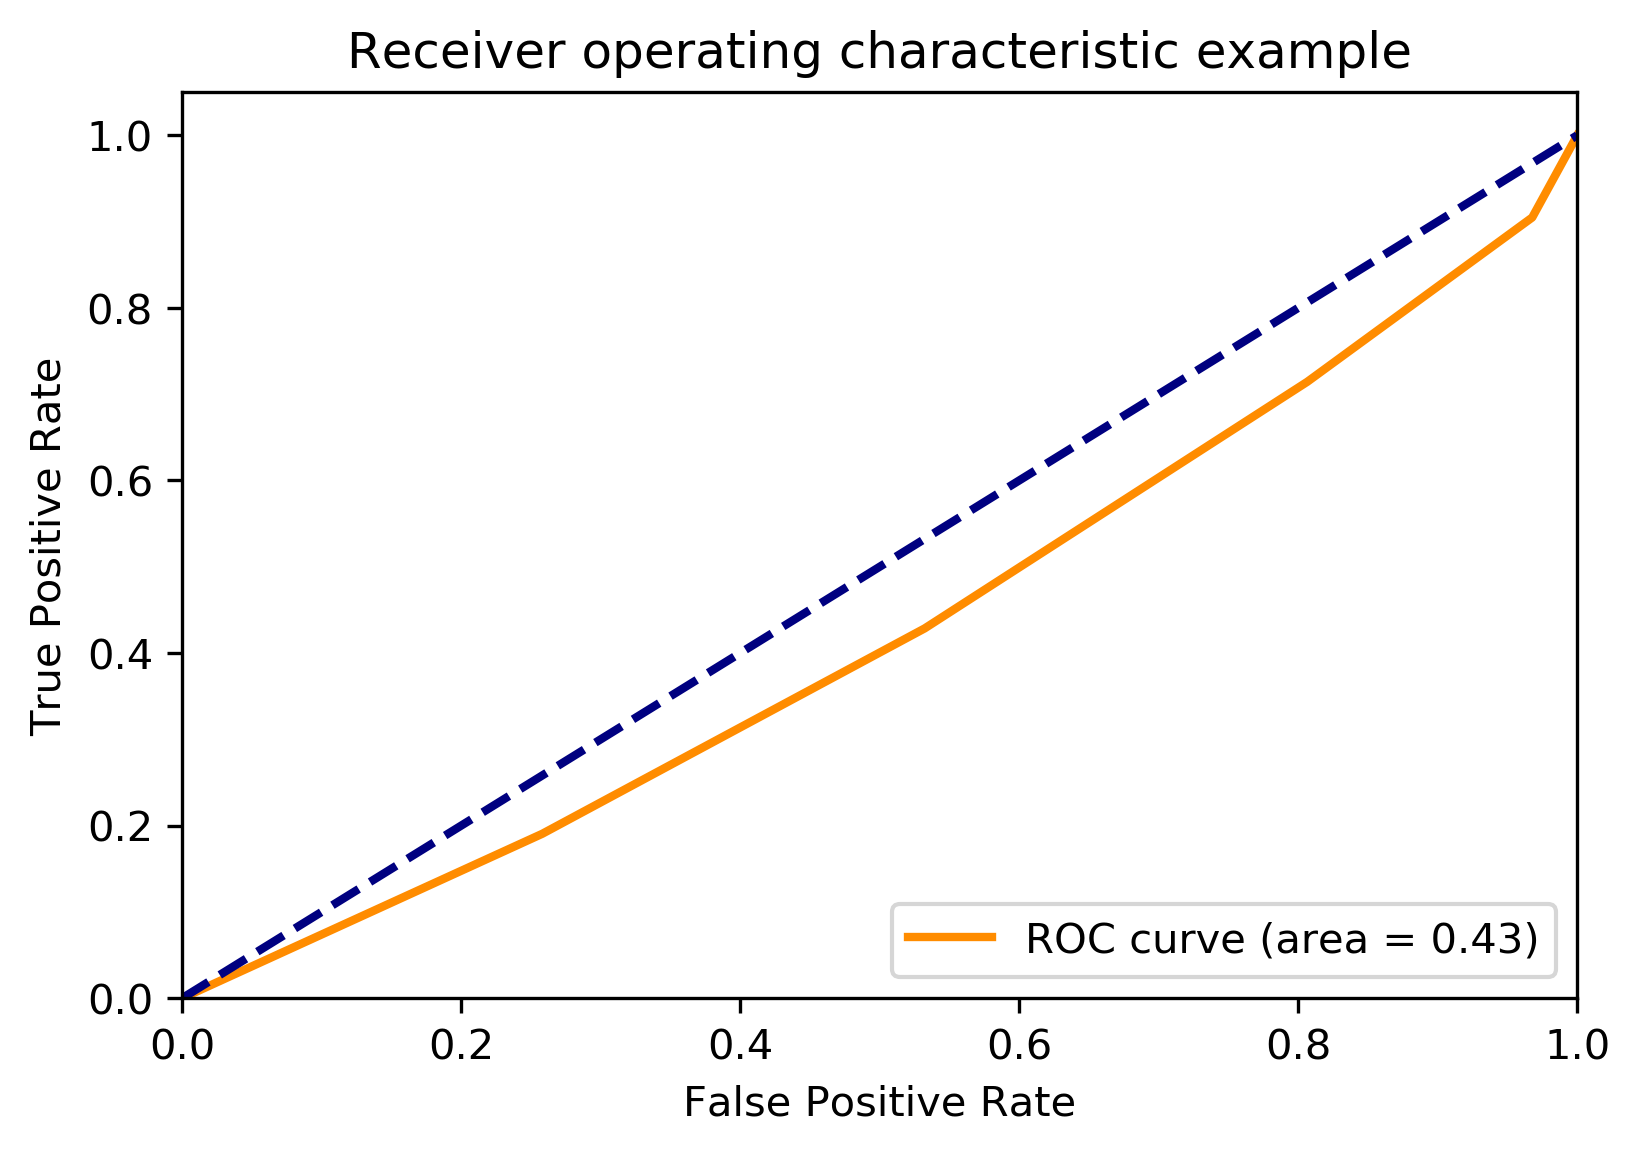

In [216]:
plotROC(fpr_KNN_DILI1, tpr_KNN_DILI1, roc_auc_score(B_test.iloc[:,0], y_kNN_DILI1[:,0]))

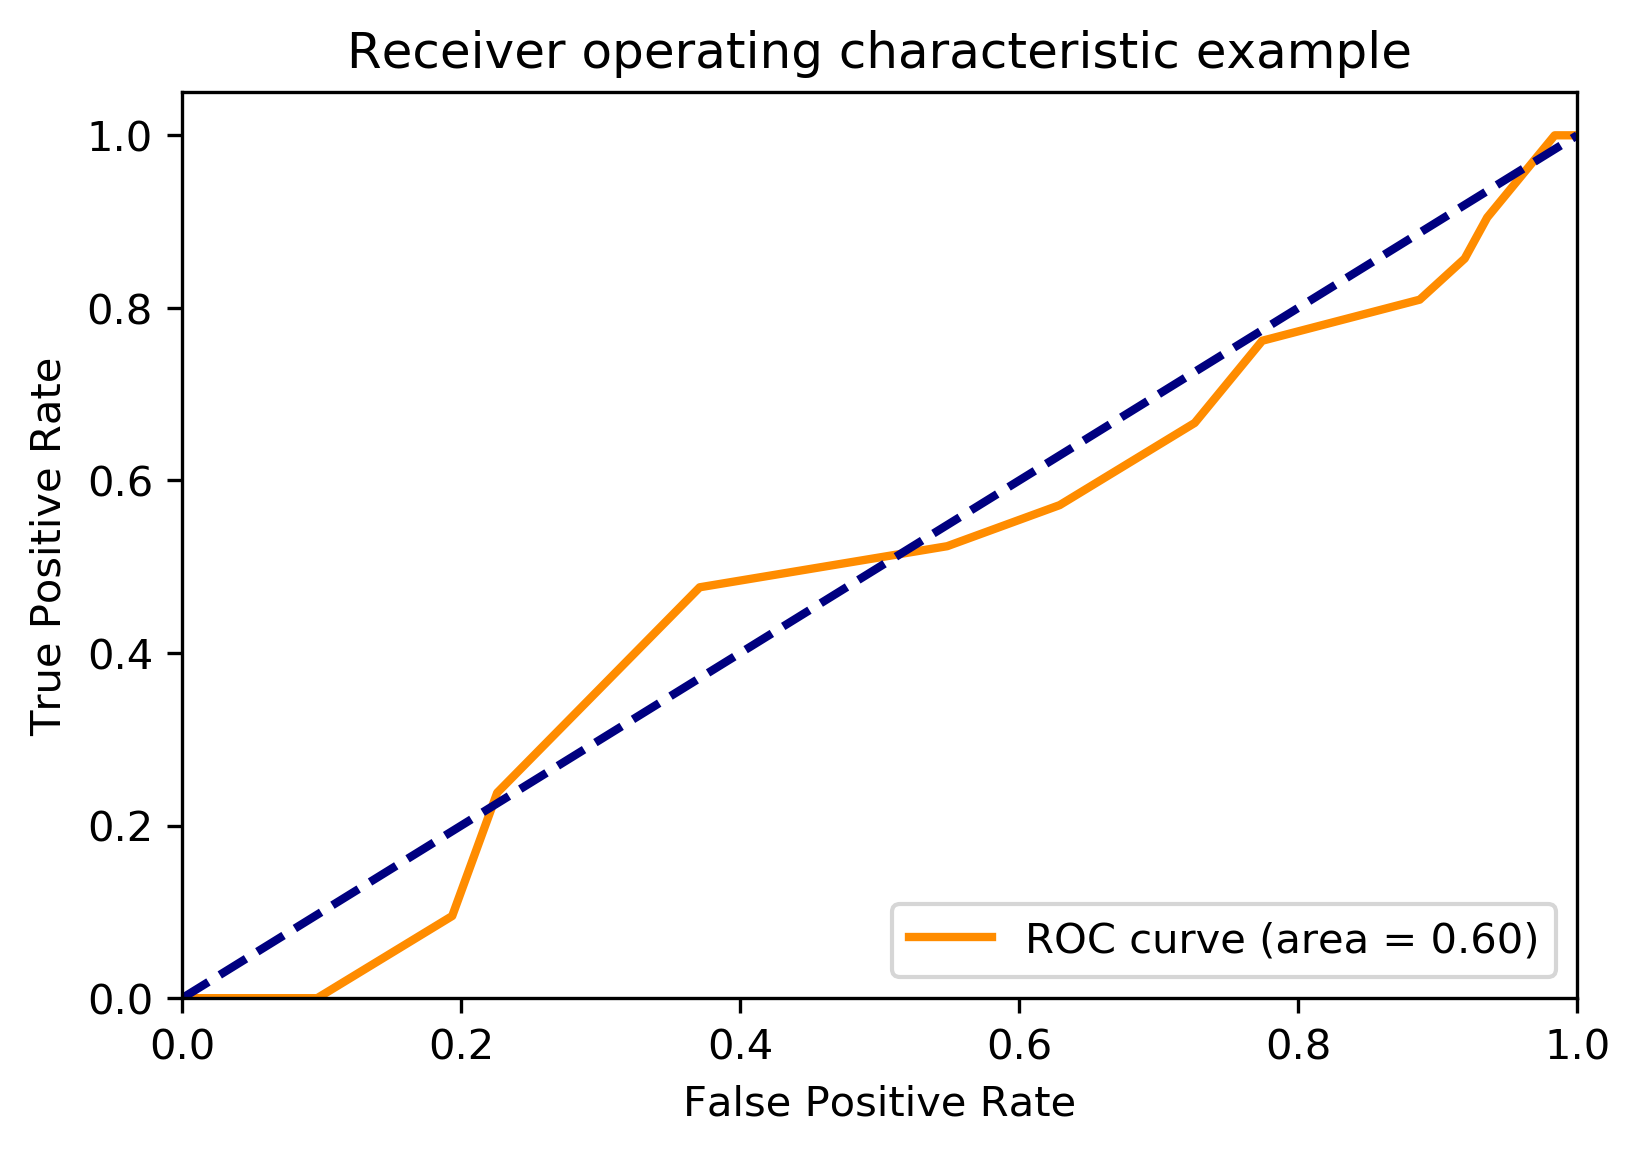

In [217]:
plotROC(fpr_KNN_DILI3, tpr_KNN_DILI3, roc_auc_score(B_test.iloc[:,1], y_kNN_DILI3[:,0]))

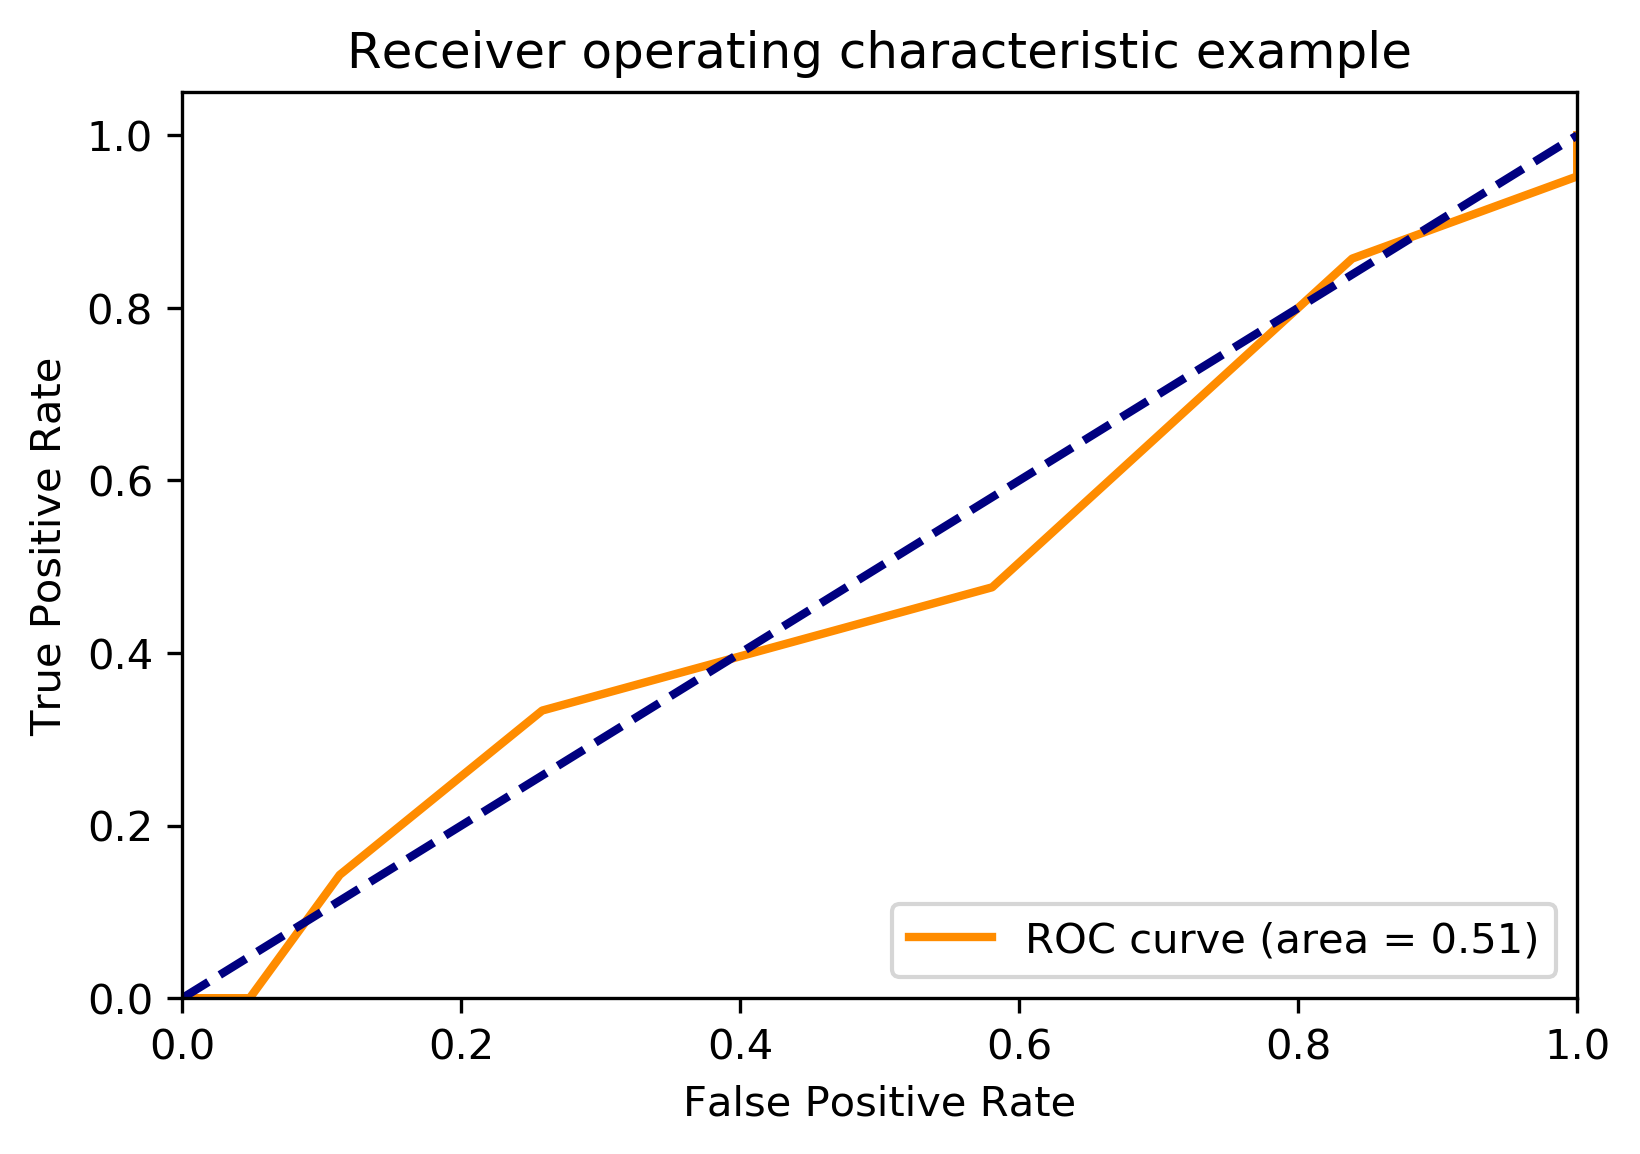

In [218]:
plotROC(fpr_KNN_DILI5, tpr_KNN_DILI5, roc_auc_score(B_test.iloc[:,2], y_kNN_DILI5[:,0]))

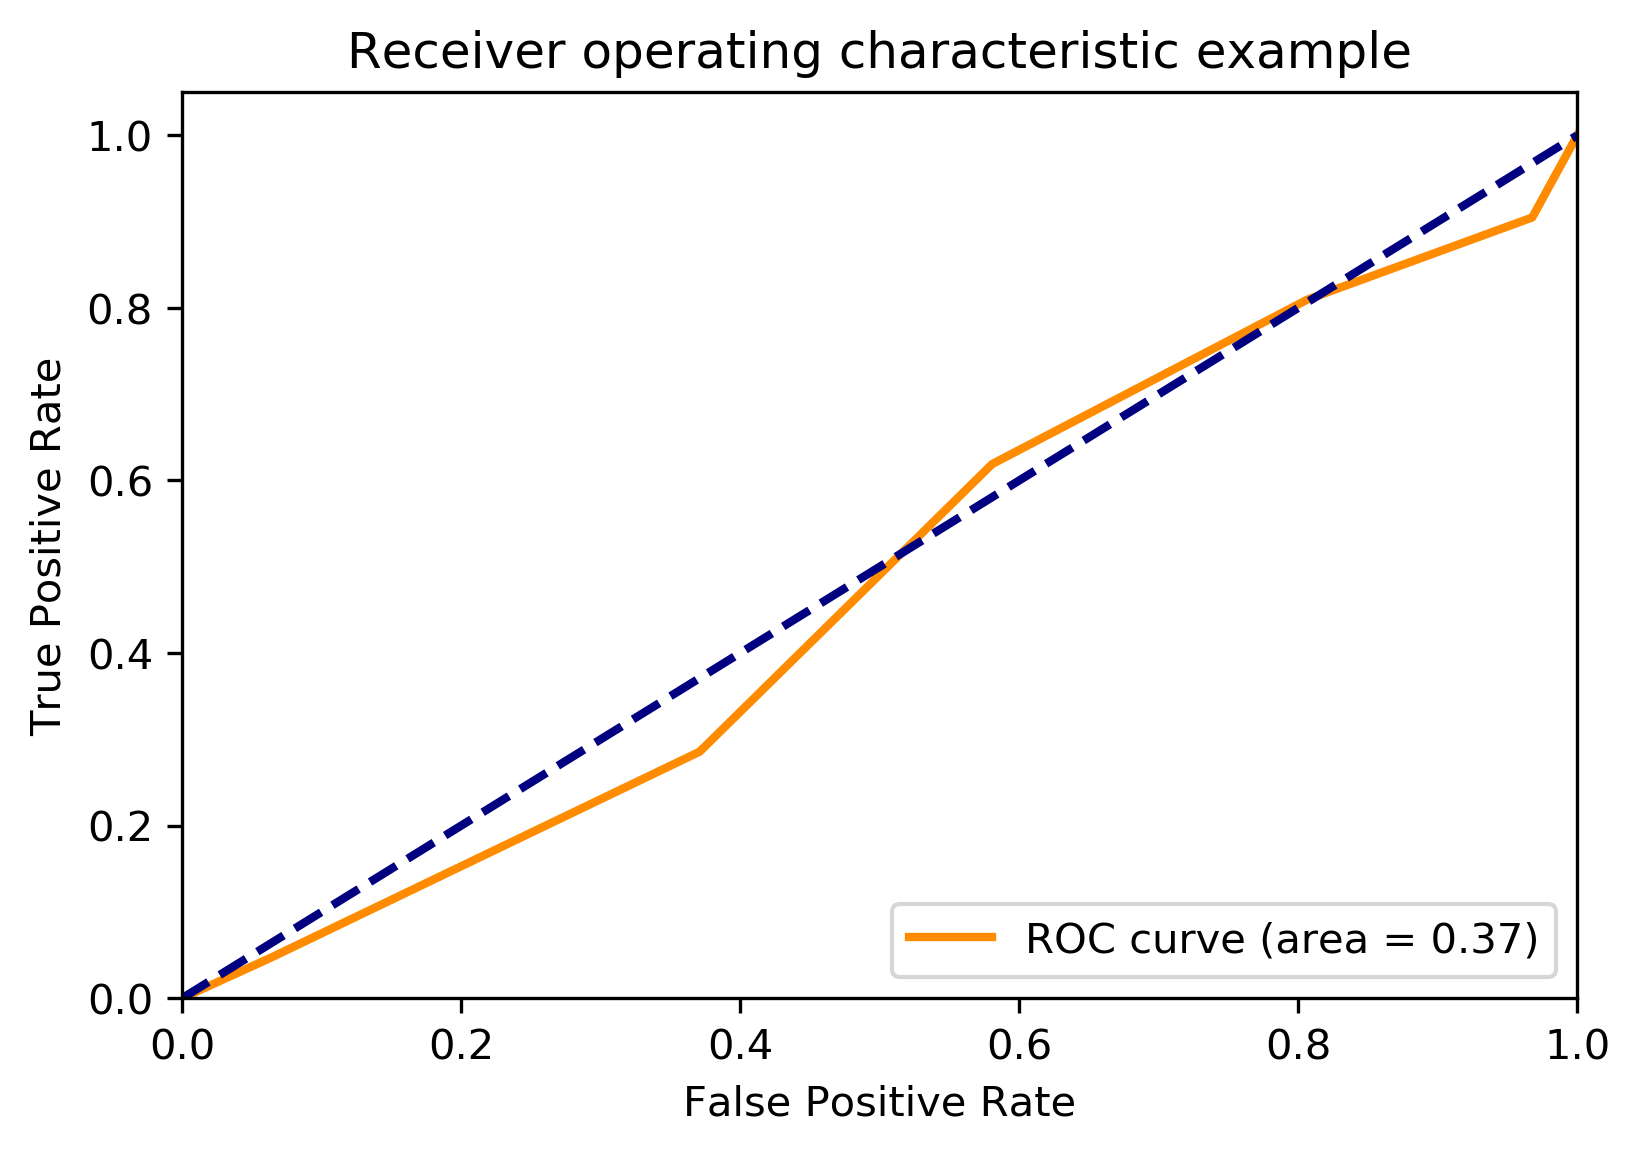

In [219]:
plotROC(fpr_KNN_DILI6, tpr_KNN_DILI6, roc_auc_score(B_test.iloc[:,3], y_kNN_DILI6[:,0]))

#### Plot Confusion Matrices

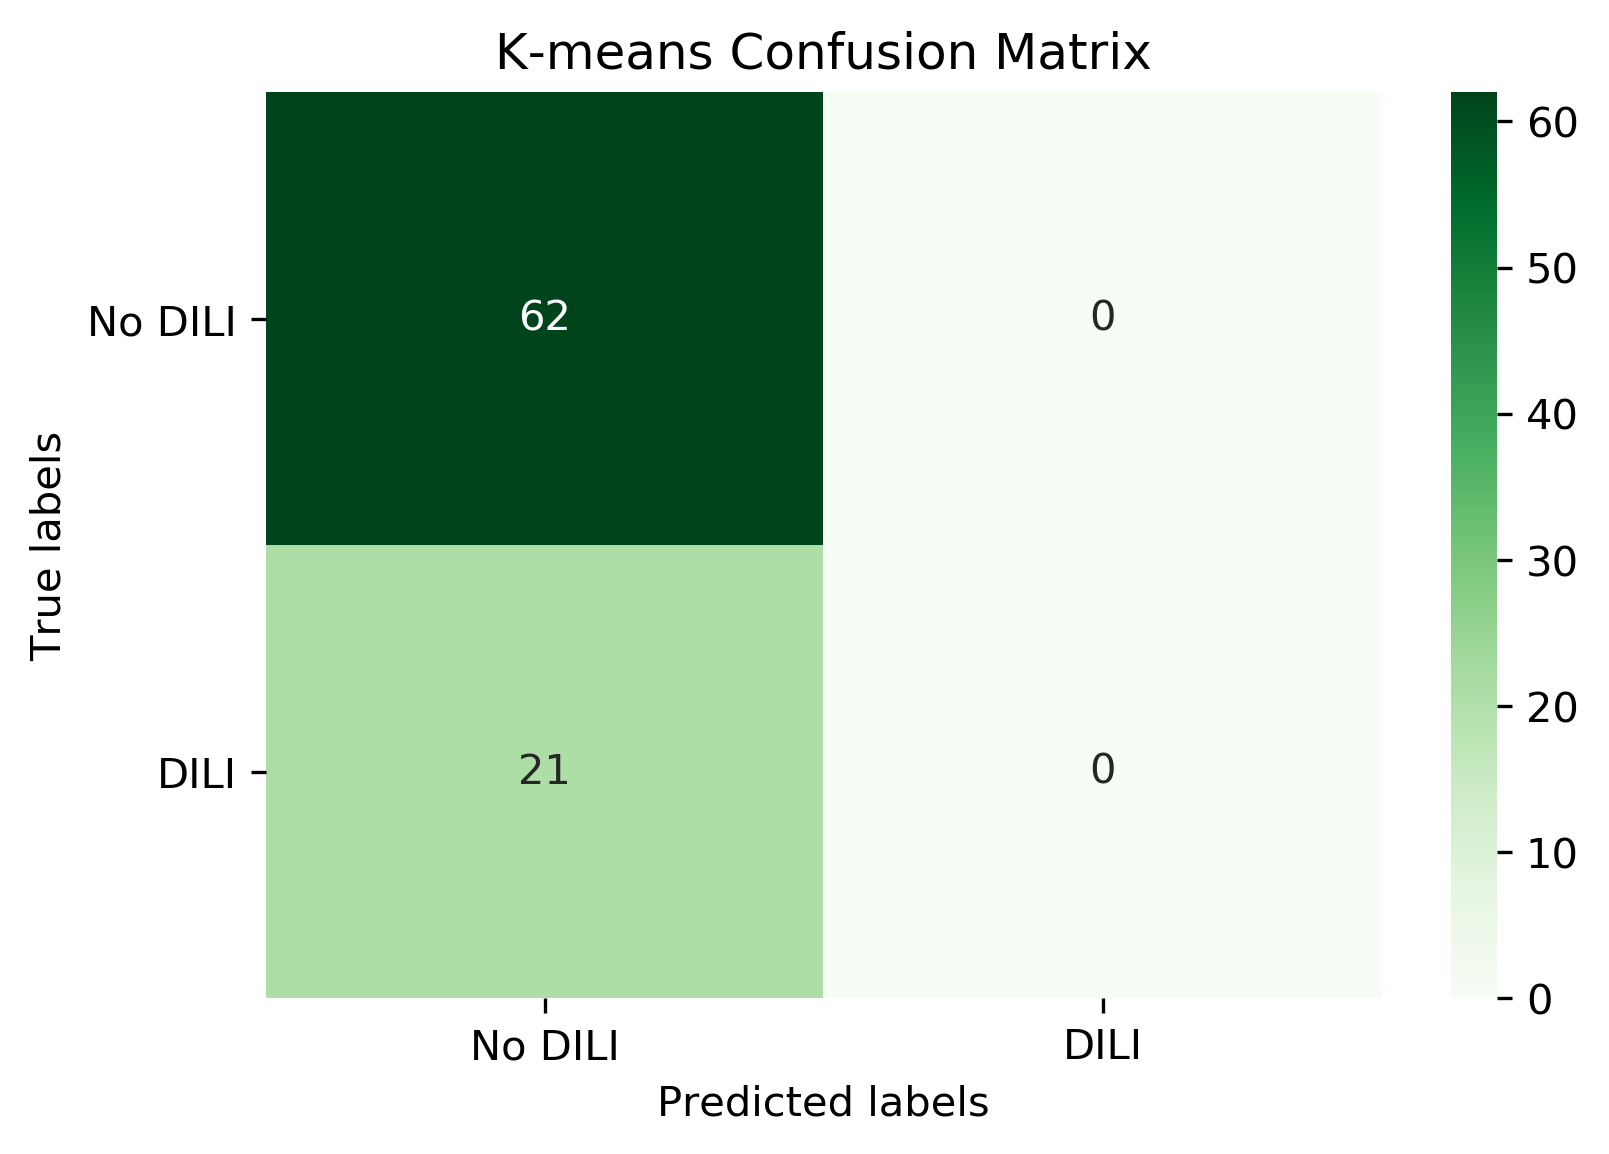

In [220]:
cM(B_test.iloc[:,0], p_kNN_DILI1)

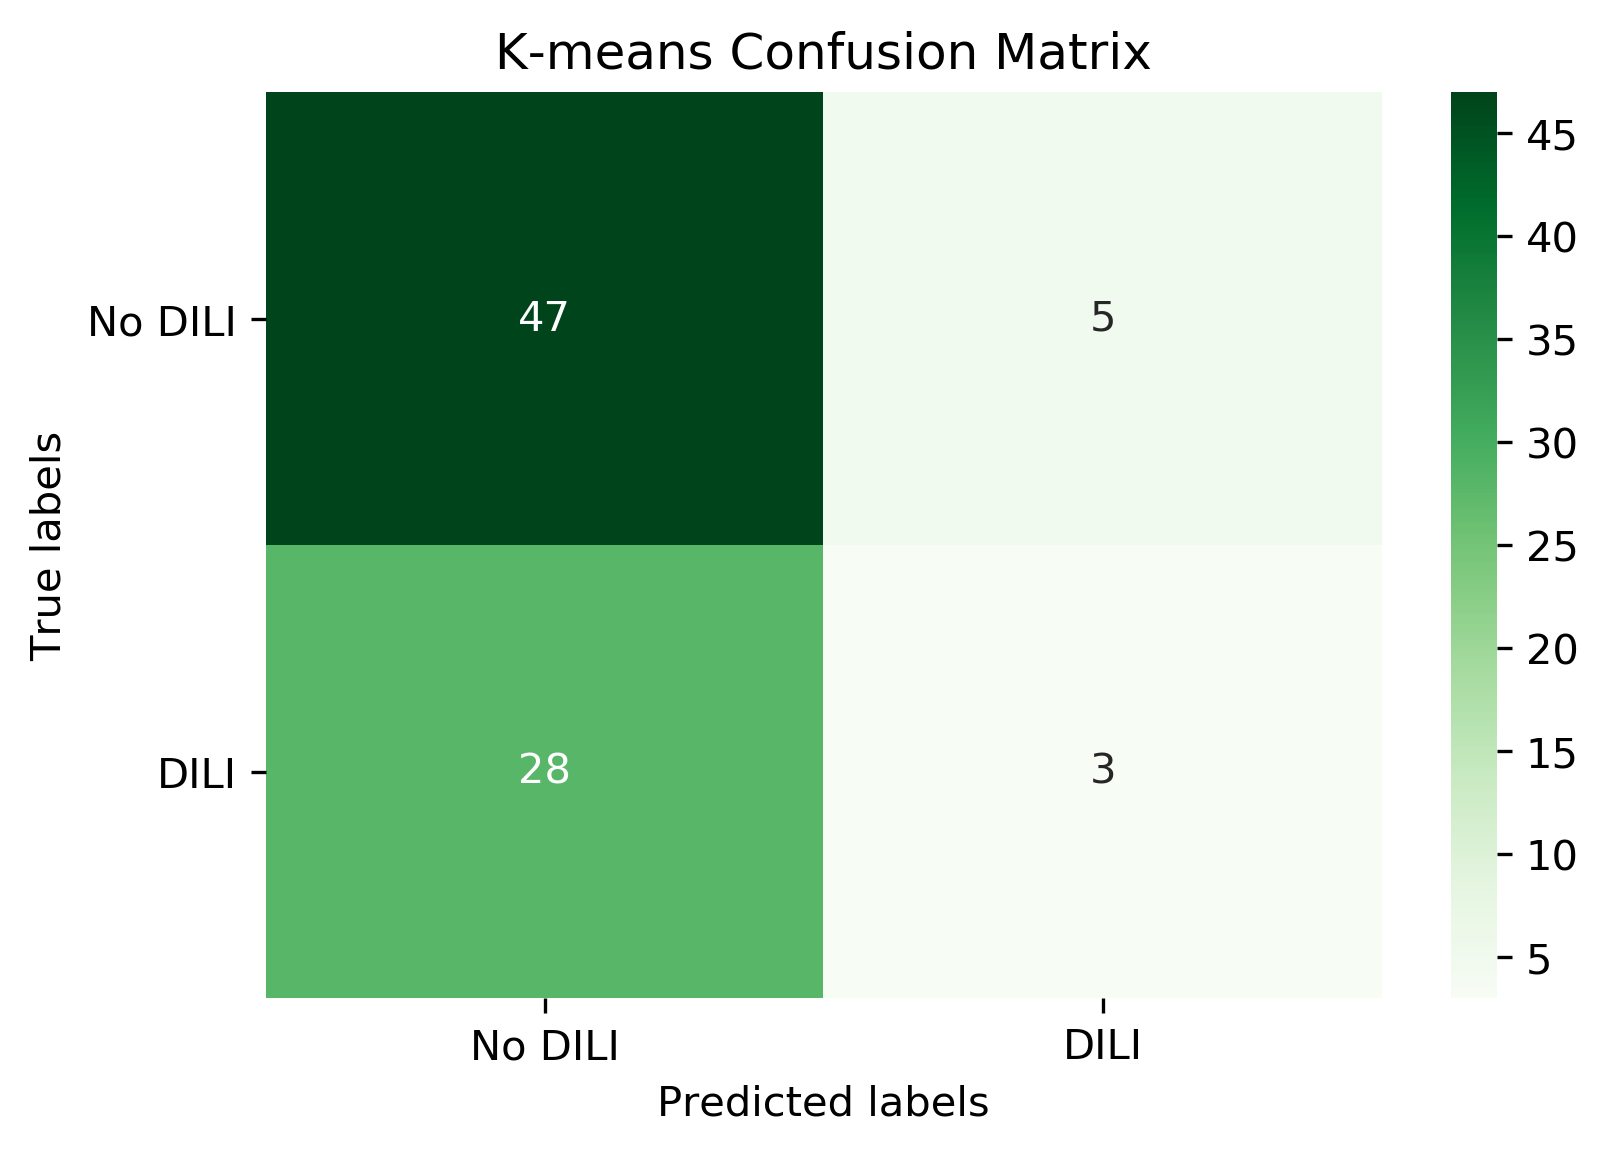

In [221]:
cM(B_test.iloc[:,1], p_kNN_DILI3)

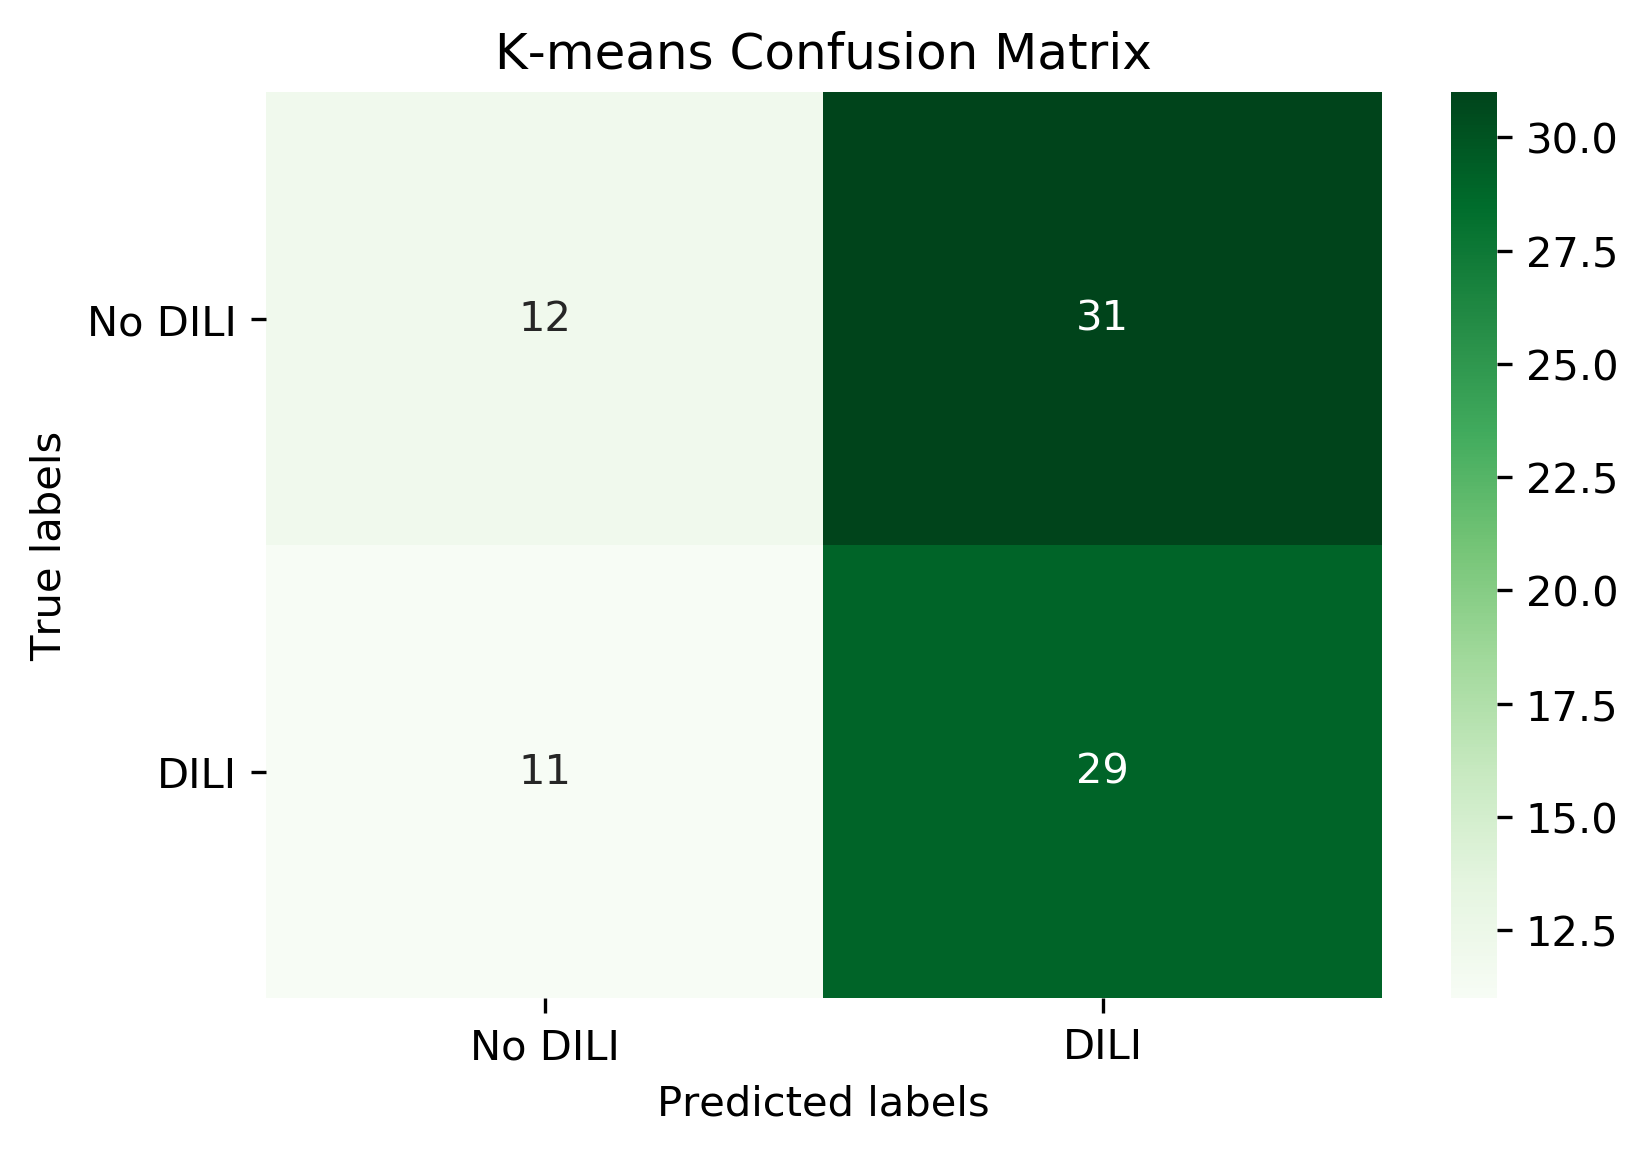

In [222]:
cM(B_test.iloc[:,2], p_kNN_DILI5)

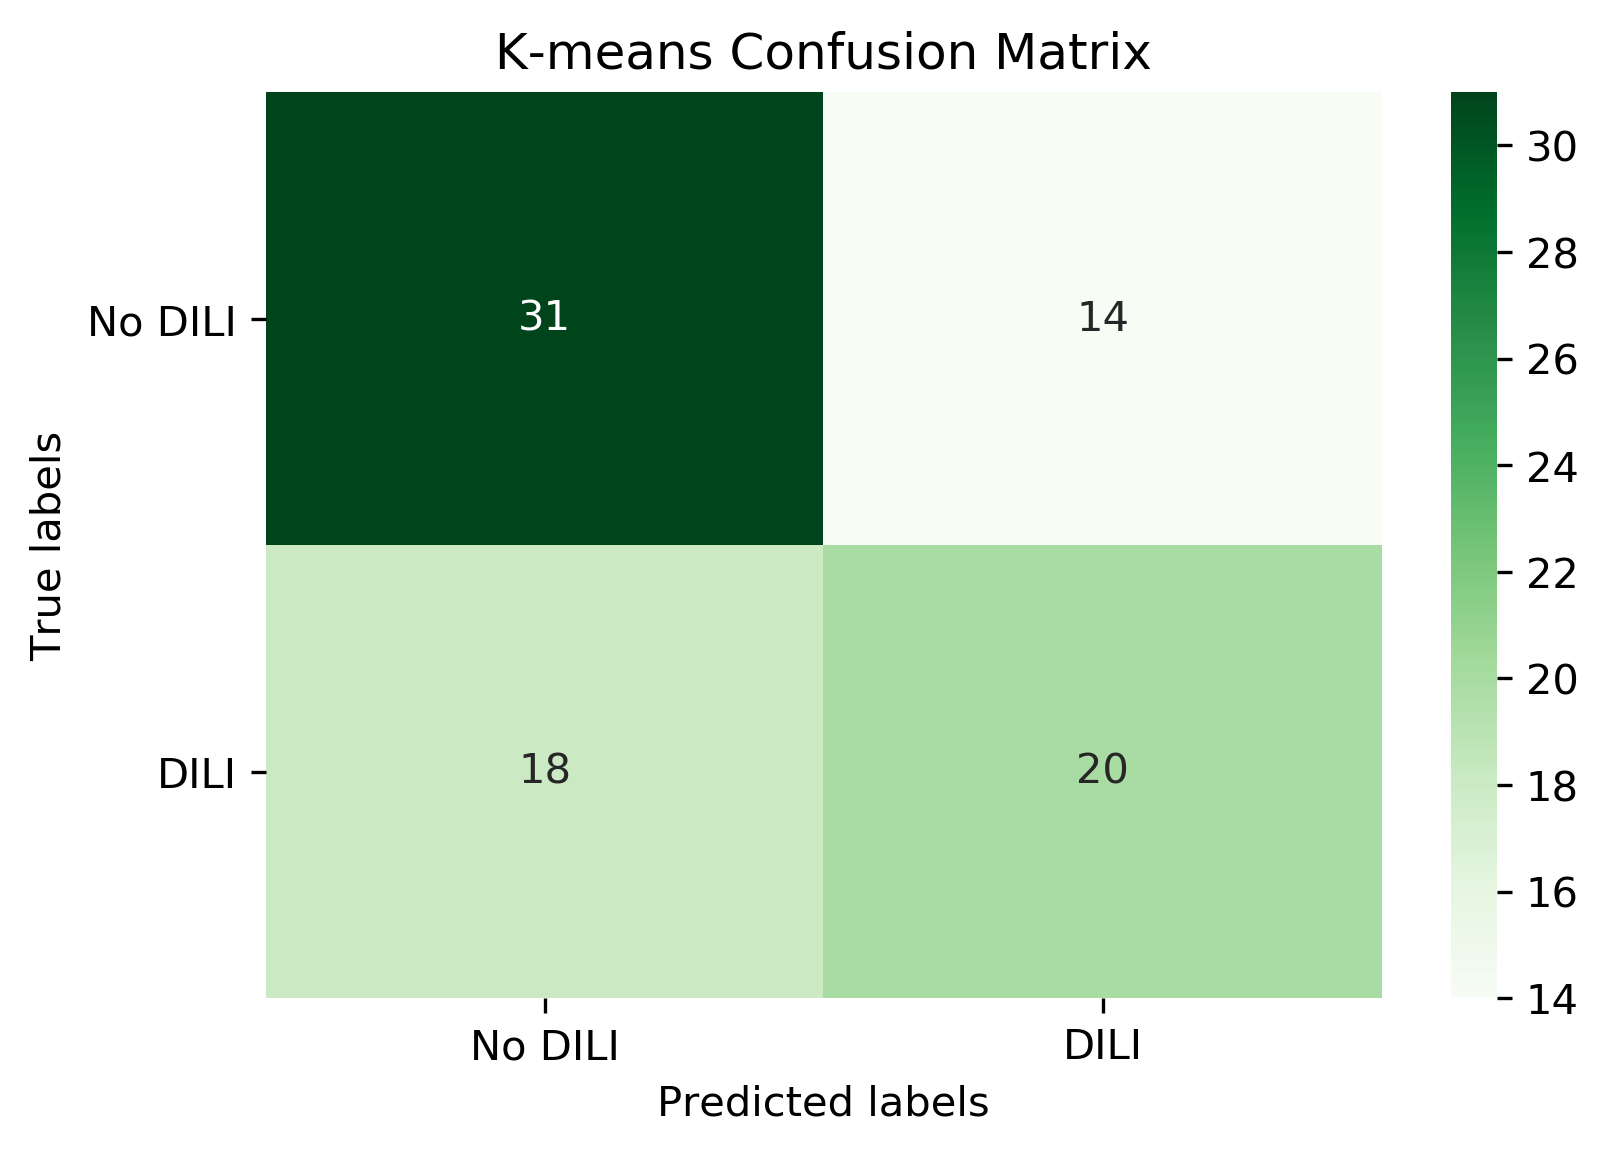

In [223]:
cM(B_test.iloc[:,3], p_kNN_DILI6)

## Naive Bayes
Function with Naive Bayes that returns predictions, probabilities, score and cross validation value. 
Hyperparemeter tuning could not ve applied for Naive Bayes.

In [46]:
def nB(X_train, X_test, y_train):
    gauss = GaussianNB()
    
    #Train
    gauss.fit(X_train,y_train)
    score = gauss.score(X_train, y_train)

    #Test
    predictions = gauss.predict(X_test)
    y_prob = gauss.predict_proba(X_test)
    
    #10-Fold Cross-Validation
    cross_Val = crossVal(gauss, X_train, y_train, 10)


    return(predictions, y_prob, score, cross_Val)

In [47]:
p_nB_DILI1, y_nB_DILI1, s_nB_DILI1, cv_nB_DILI1 = nB(A_train, A_test, B_train['DILI1'])
p_nB_DILI3, y_nB_DILI3, s_nB_DILI3, cv_nB_DILI3 = nB(A_train, A_test, B_train['DILI3'])
p_nB_DILI5, y_nB_DILI5, s_nB_DILI5, cv_nB_DILI5 = nB(A_train, A_test, B_train['DILI5'])
p_nB_DILI6, y_nB_DILI6, s_nB_DILI6, cv_nB_DILI6 = nB(A_train, A_test, B_train['DILI6'])

Cross Validation result:  0.4215686274509804 number of kFold splits:  10
Cross Validation result:  0.5693404634581106 number of kFold splits:  10
Cross Validation result:  0.44634581105169346 number of kFold splits:  10
Cross Validation result:  0.569073083778966 number of kFold splits:  10


#### Calculate Accuracy

In [48]:
print('Naive Bayes accuracy (DILI1): ', round(accuracy_score(B_test.iloc[:,0], p_nB_DILI1), 3))
print('Naive Bayes accuracy (DILI3): ', round(accuracy_score(B_test.iloc[:,1], p_nB_DILI3), 3))
print('Naive Bayes accuracy (DILI5): ', round(accuracy_score(B_test.iloc[:,2], p_nB_DILI5), 3))
print('Naive Bayes accuracy (DILI6): ', round(accuracy_score(B_test.iloc[:,3], p_nB_DILI6), 3))

Naive Bayes accuracy (DILI1):  0.47
Naive Bayes accuracy (DILI3):  0.554
Naive Bayes accuracy (DILI5):  0.47
Naive Bayes accuracy (DILI6):  0.602


#### Calculate Balanced Accuracy

In [49]:
print('Naive balanced Bayes accuracy (DILI1): ', round(balanced_accuracy_score(B_test.iloc[:,0], p_nB_DILI1), 3))
print('Naive balanced Bayes accuracy (DILI3): ', round(balanced_accuracy_score(B_test.iloc[:,1], p_nB_DILI3), 3))
print('Naive balanced Bayes accuracy (DILI5): ', round(balanced_accuracy_score(B_test.iloc[:,2], p_nB_DILI5), 3))
print('Naive balanced Bayes accuracy (DILI6): ', round(balanced_accuracy_score(B_test.iloc[:,3], p_nB_DILI6), 3))

Naive balanced Bayes accuracy (DILI1):  0.551
Naive balanced Bayes accuracy (DILI3):  0.52
Naive balanced Bayes accuracy (DILI5):  0.466
Naive balanced Bayes accuracy (DILI6):  0.59


#### Calculate Precision Score

In [319]:
print('NB F1 Score (DILI1): ', round(precision_score(B_test.iloc[:,0], p_nB_DILI1), 3))
print('NB F1 Score (DILI3): ', round(precision_score(B_test.iloc[:,1], p_nB_DILI3), 3))
print('NB F1 Score (DILI5): ', round(precision_score(B_test.iloc[:,2], p_nB_DILI5), 3))
print('NB F1 Score (DILI6): ', round(precision_score(B_test.iloc[:,3], p_nB_DILI6), 3))


NB F1 Score (DILI1):  0.283
NB F1 Score (DILI3):  0.4
NB F1 Score (DILI5):  0.438
NB F1 Score (DILI6):  0.586


#### Calculate F1 Score

In [315]:
print('NB Precision (DILI1): ', round(f1_score(B_test.iloc[:,0], p_nB_DILI1), 3))
print('NB Precision  (DILI3): ', round(f1_score(B_test.iloc[:,1], p_nB_DILI3), 3))
print('NB Precision  (DILI5): ', round(f1_score(B_test.iloc[:,2], p_nB_DILI5), 3))
print('NB Precision  (DILI6): ', round(f1_score(B_test.iloc[:,3], p_nB_DILI6), 3))


NB Precision (DILI1):  0.405
NB Precision  (DILI3):  0.393
NB Precision  (DILI5):  0.389
NB Precision  (DILI6):  0.507


#### Calculate ROC AUC Score

In [51]:
print('NB ROC AUC Score (DILI1): ', round(roc_auc_score(B_test.iloc[:,0], y_nB_DILI1[:,0]), 3))
print('NB ROC AUC Score (DILI3): ', round(roc_auc_score(B_test.iloc[:,1], y_nB_DILI3[:,0]), 3))
print('NB ROC AUC Score (DILI5): ', round(roc_auc_score(B_test.iloc[:,2], y_nB_DILI5[:,0]), 3))
print('NB ROC AUC Score (DILI6): ', round(roc_auc_score(B_test.iloc[:,3], y_nB_DILI6[:,0]), 3))


NB ROC AUC Score (DILI1):  0.464
NB ROC AUC Score (DILI3):  0.473
NB ROC AUC Score (DILI5):  0.535
NB ROC AUC Score (DILI6):  0.39


#### Calculate FPR and TPR, and plot ROC curve

In [52]:
fpr_NB_DILI1, tpr_NB_DILI1, _ = roc_curve(B_test.iloc[:,0], y_nB_DILI1[:,0])
fpr_NB_DILI3, tpr_NB_DILI3, _ = roc_curve(B_test.iloc[:,0], y_nB_DILI3[:,0])
fpr_NB_DILI5, tpr_NB_DILI5, _ = roc_curve(B_test.iloc[:,0], y_nB_DILI5[:,0])
fpr_NB_DILI6, tpr_NB_DILI6, _ = roc_curve(B_test.iloc[:,0], y_nB_DILI6[:,0])

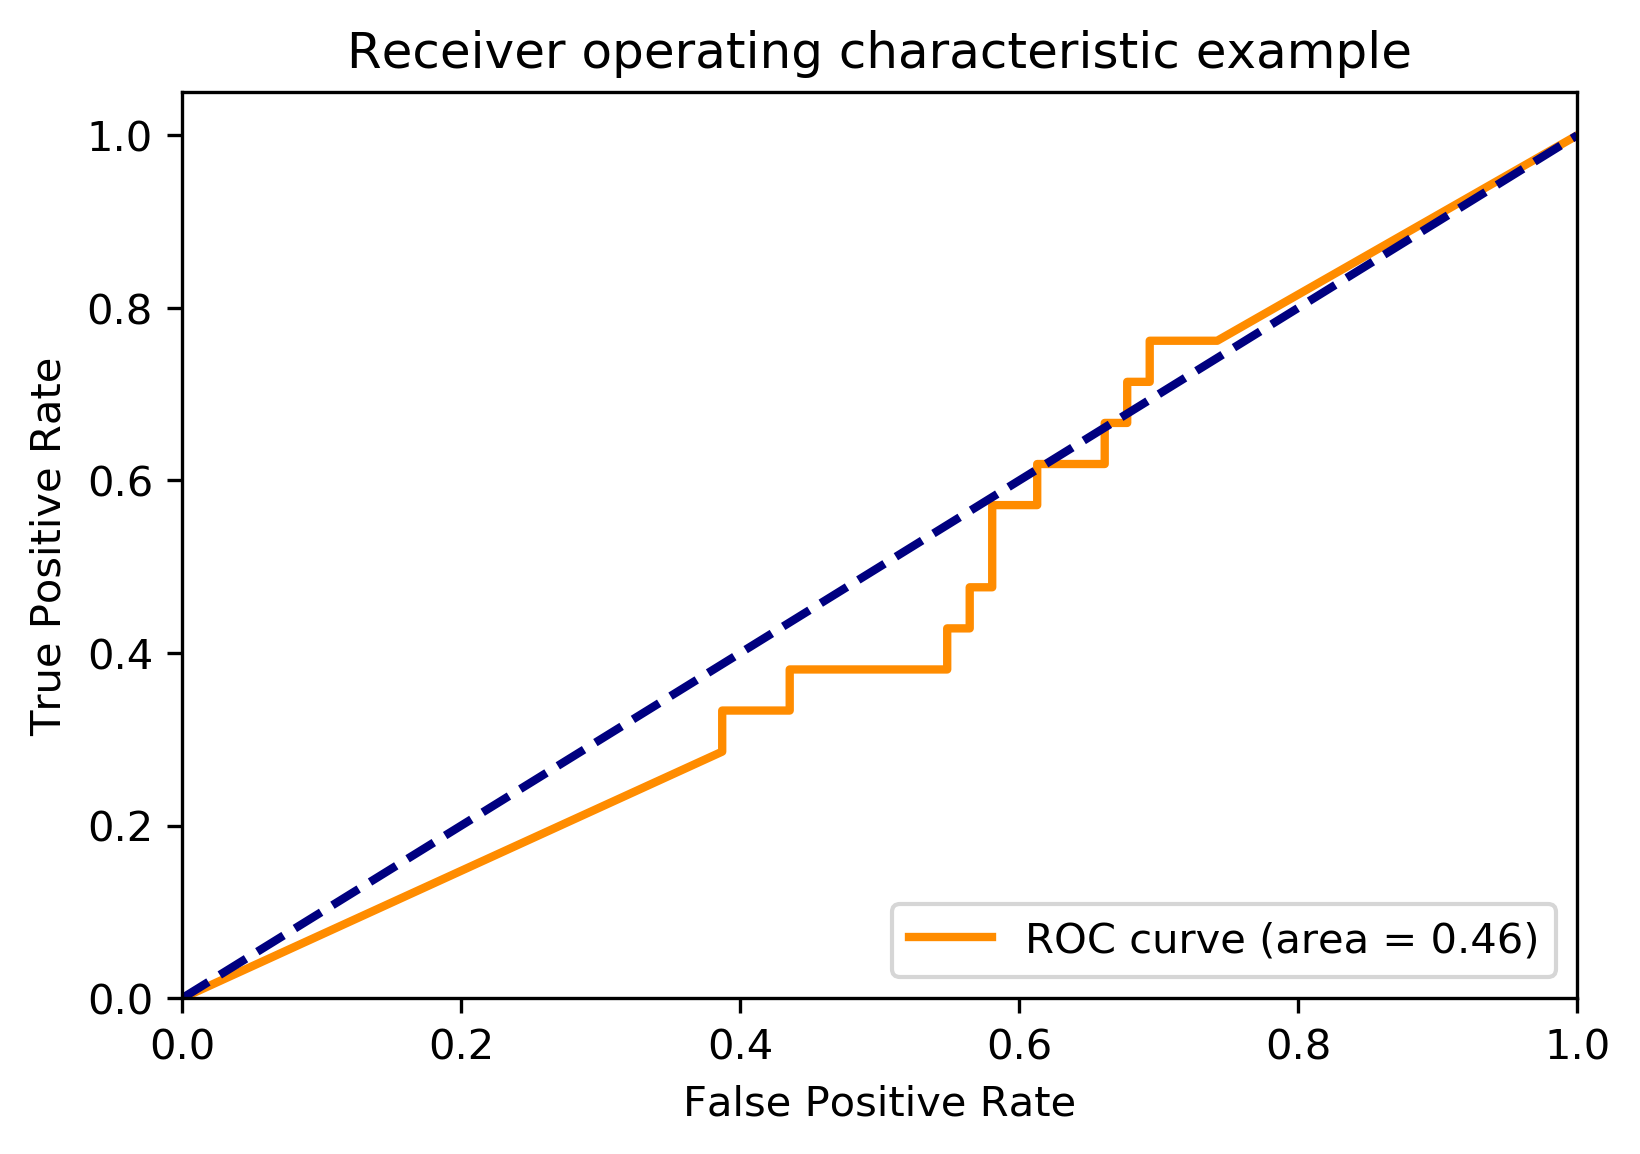

In [224]:
plotROC(fpr_NB_DILI1, tpr_NB_DILI1, roc_auc_score(B_test.iloc[:,0], y_nB_DILI1[:,0]))

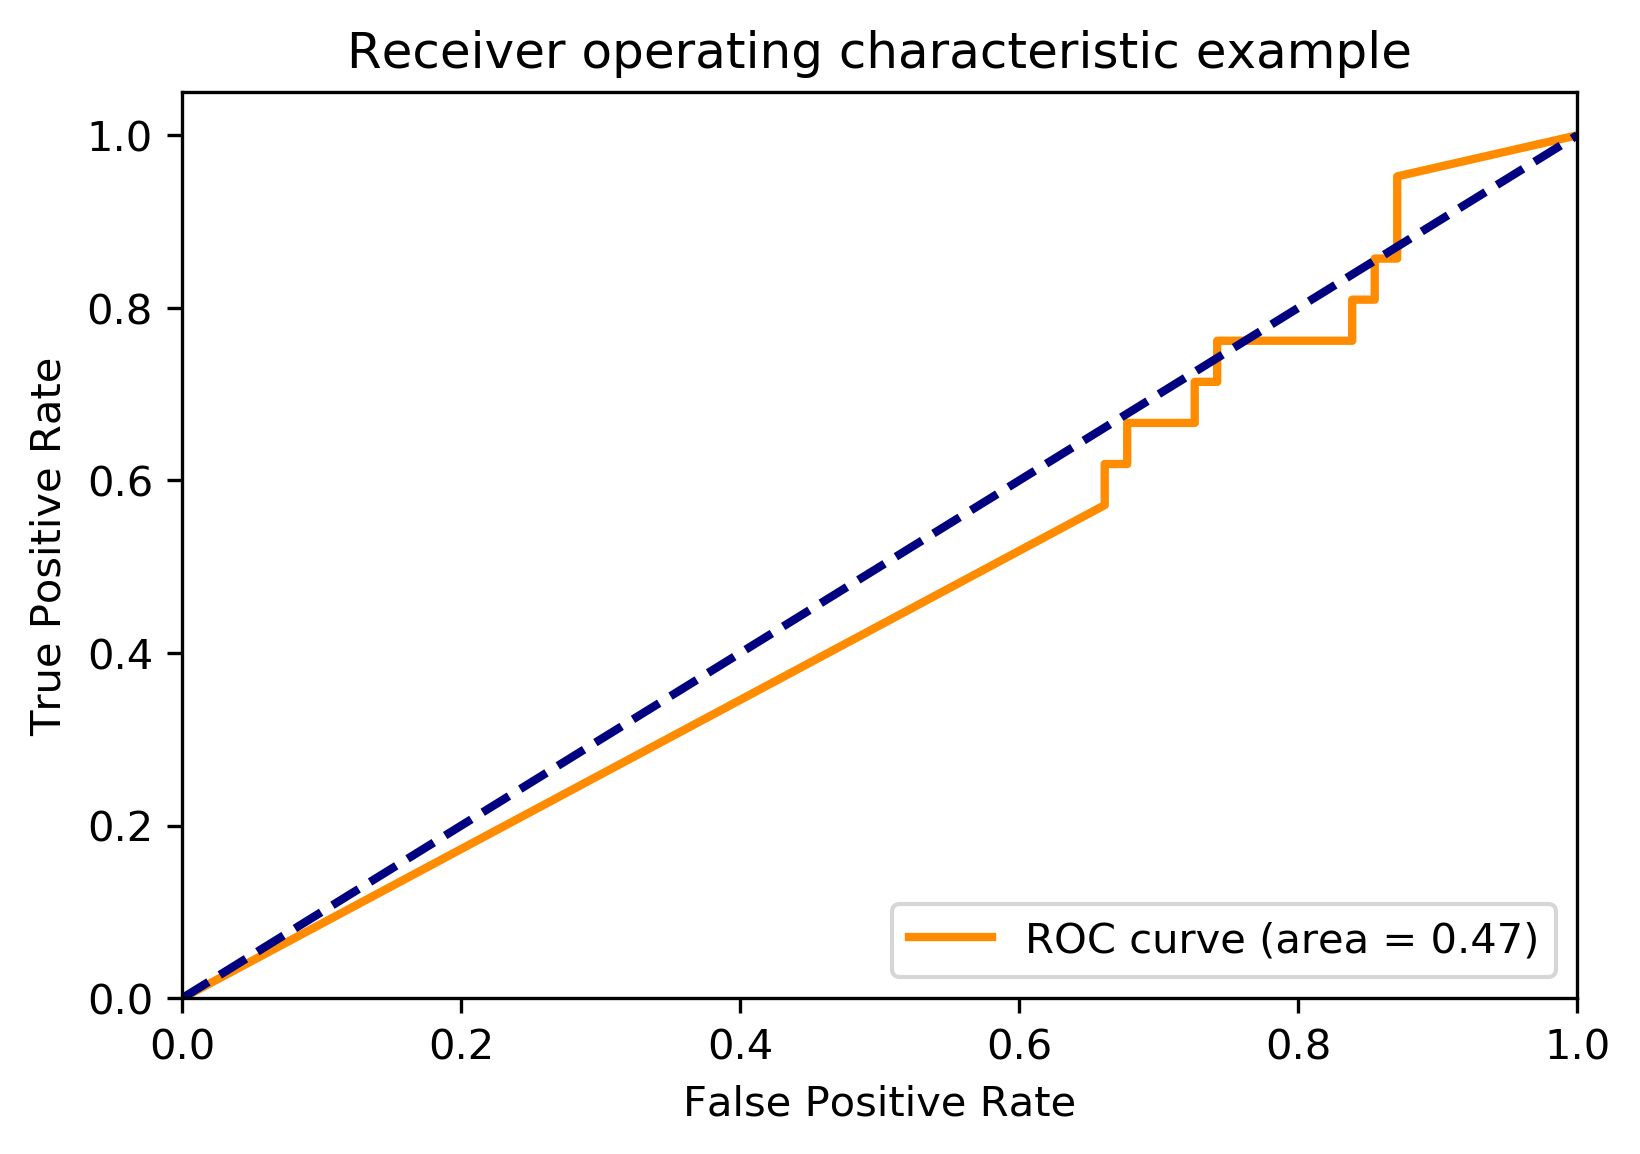

In [225]:
plotROC(fpr_NB_DILI3, tpr_NB_DILI3, roc_auc_score(B_test.iloc[:,1], y_nB_DILI3[:,0]))

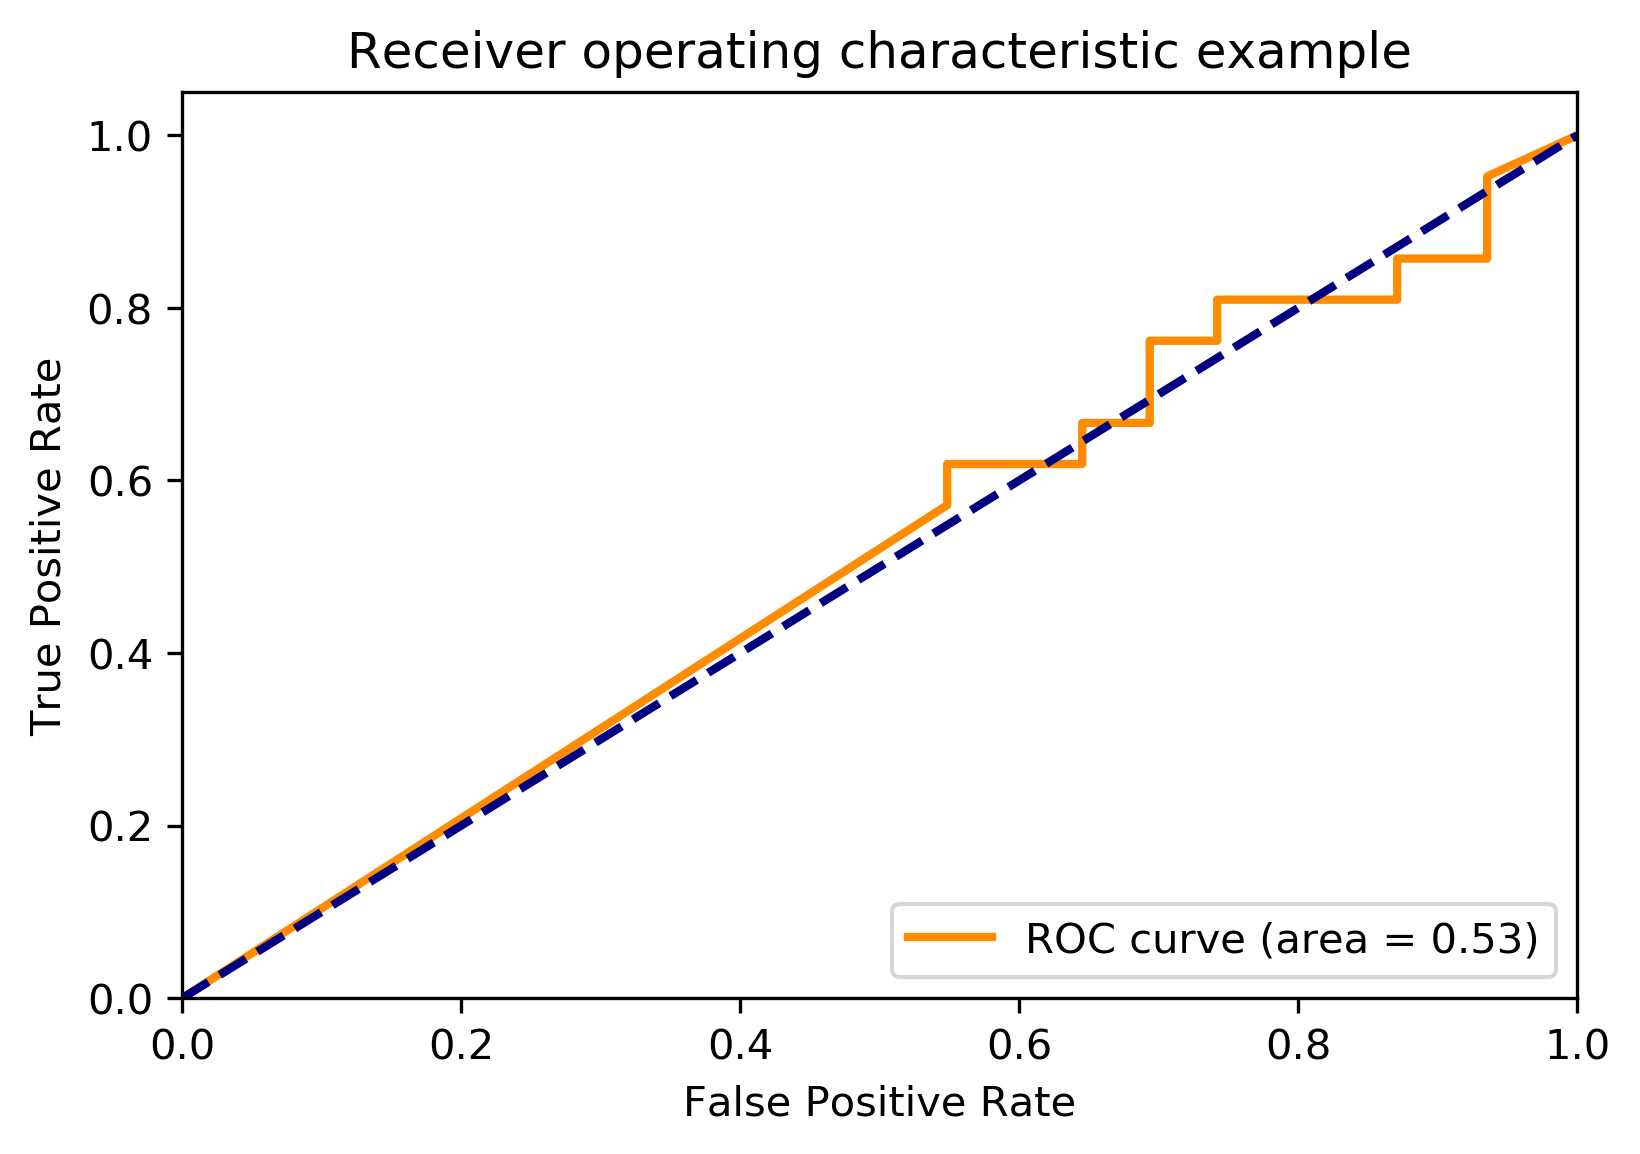

In [226]:
plotROC(fpr_NB_DILI5, tpr_NB_DILI5, roc_auc_score(B_test.iloc[:,2], y_nB_DILI5[:,0]))

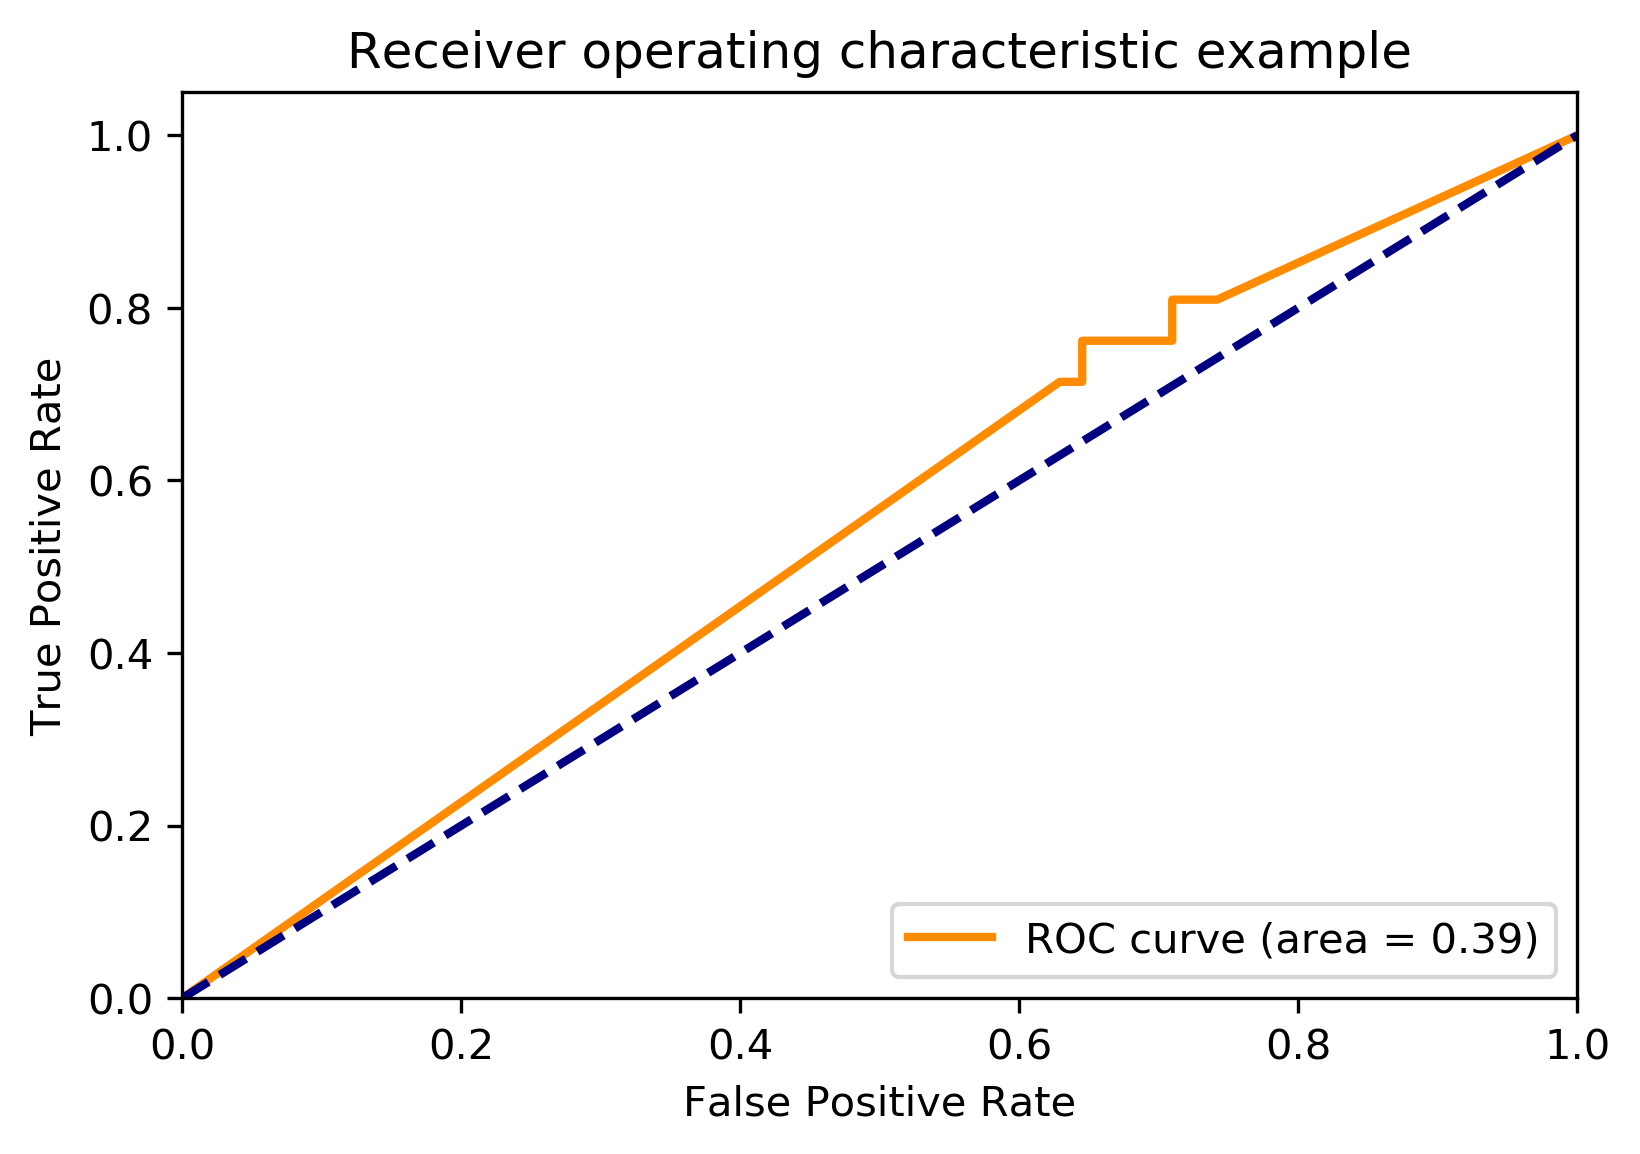

In [227]:
plotROC(fpr_NB_DILI6, tpr_NB_DILI6, roc_auc_score(B_test.iloc[:,3], y_nB_DILI6[:,0]))

#### Plot Confusion Matrices

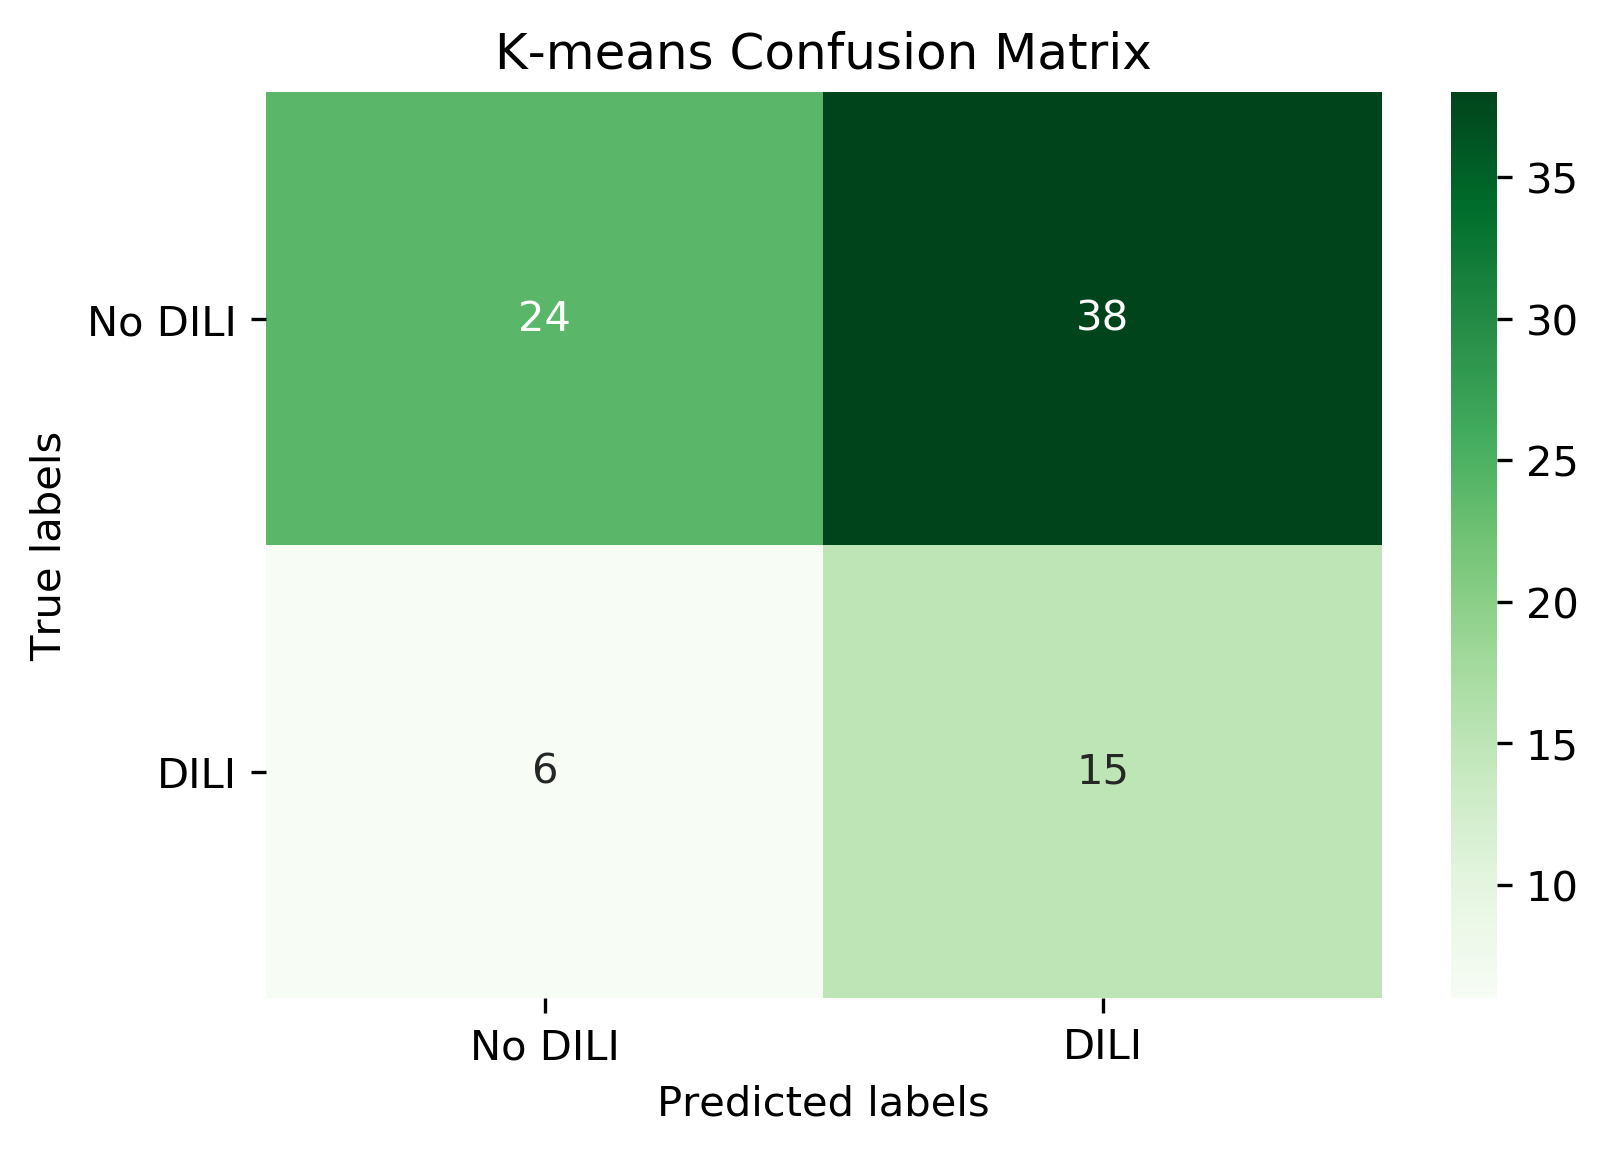

In [228]:
cM(B_test.iloc[:,0], p_nB_DILI1)

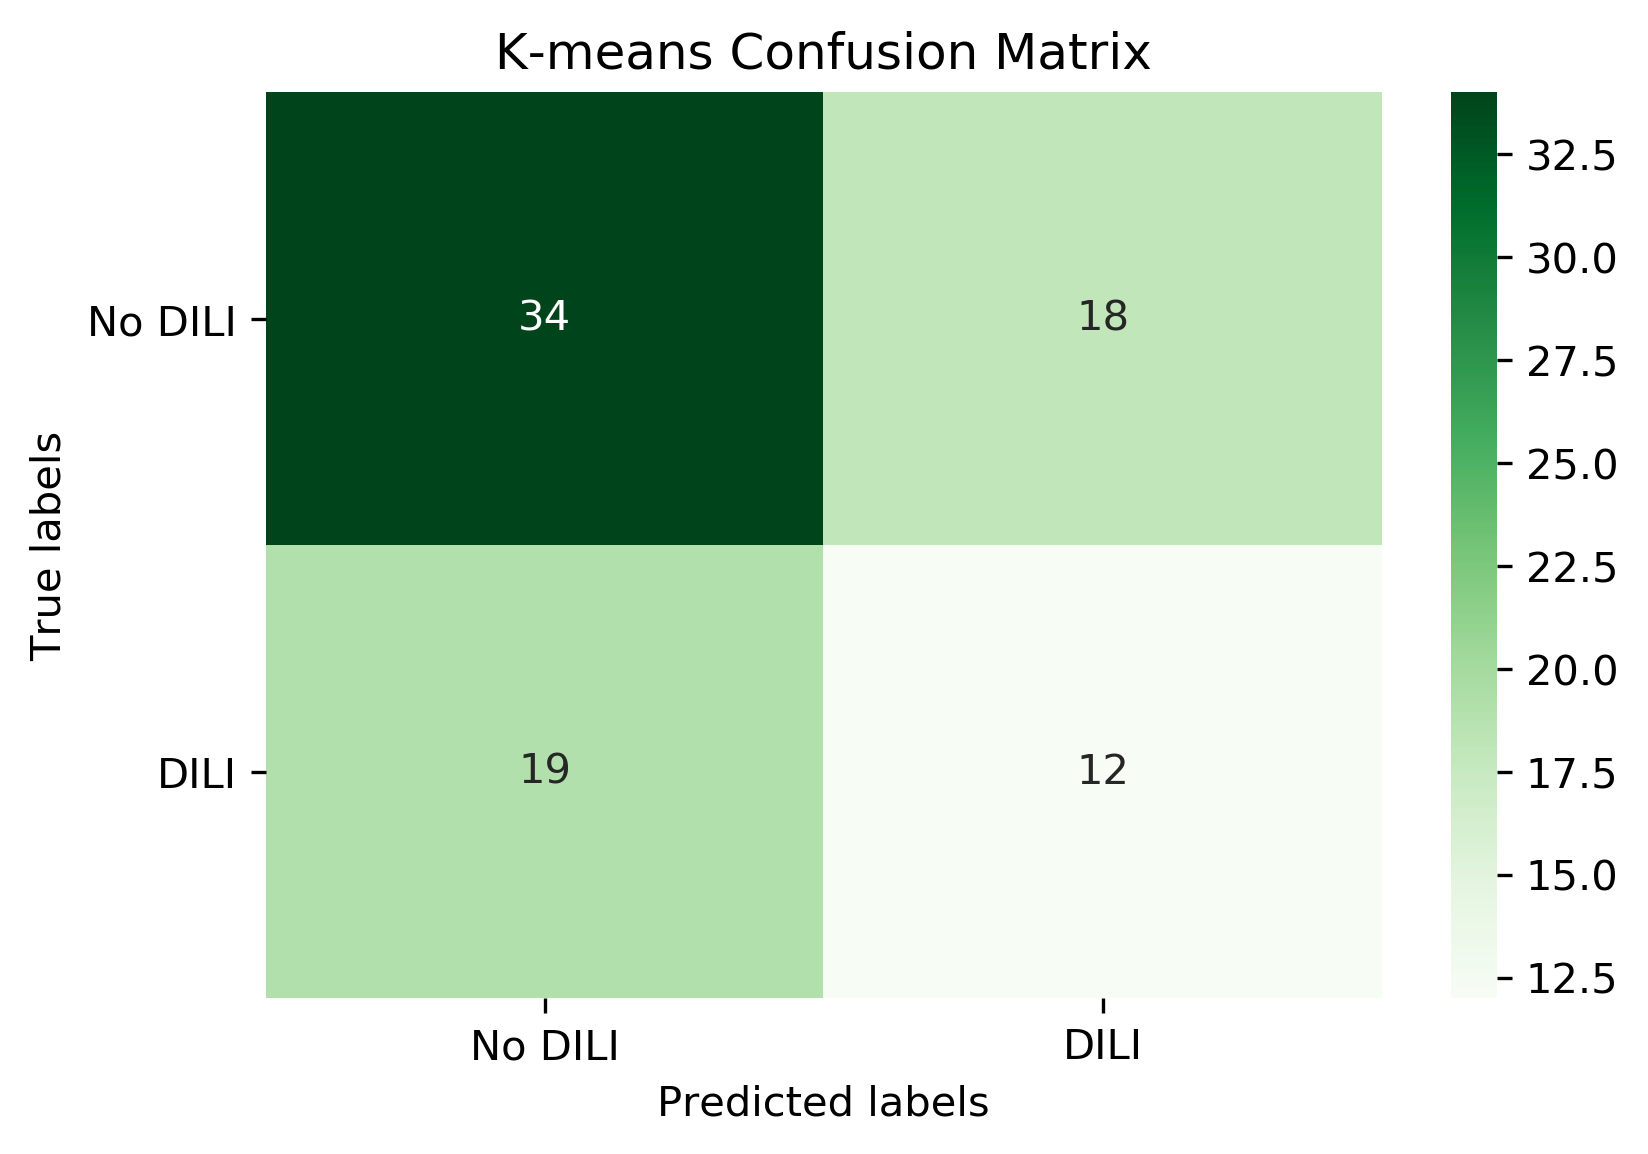

In [229]:
cM(B_test.iloc[:,1], p_nB_DILI3)

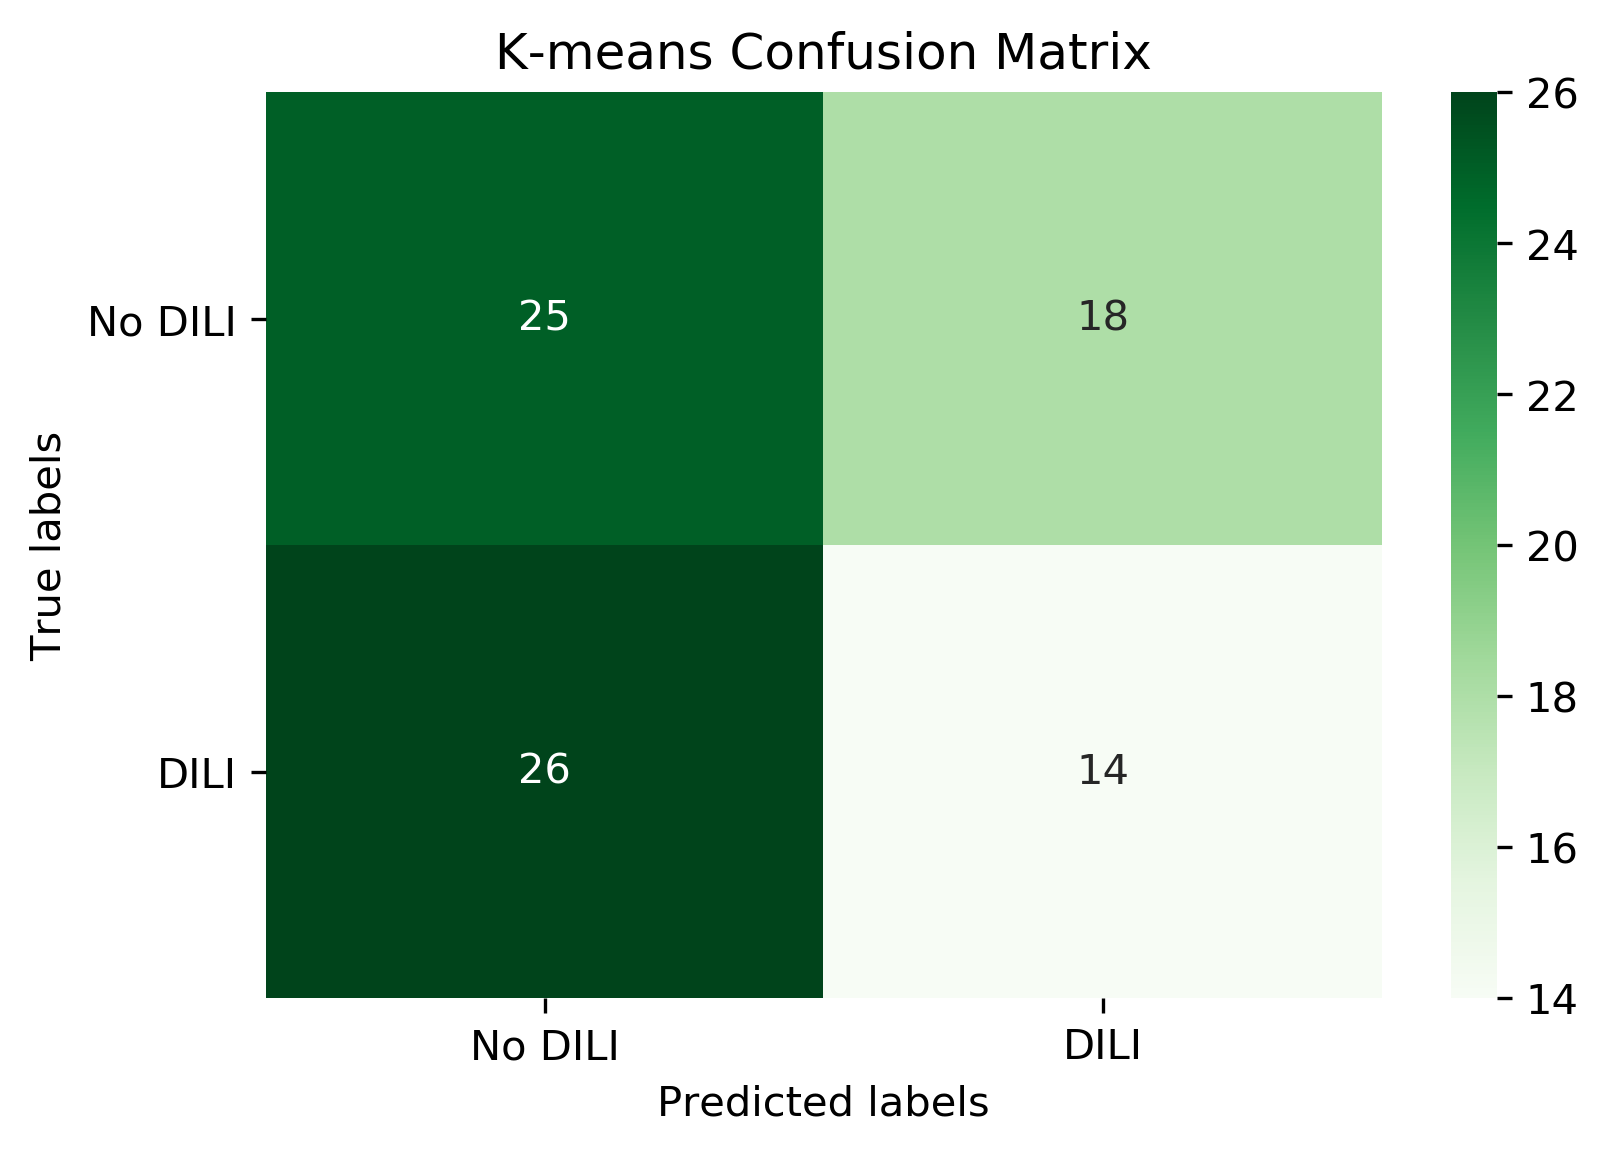

In [230]:
cM(B_test.iloc[:,2], p_nB_DILI5)

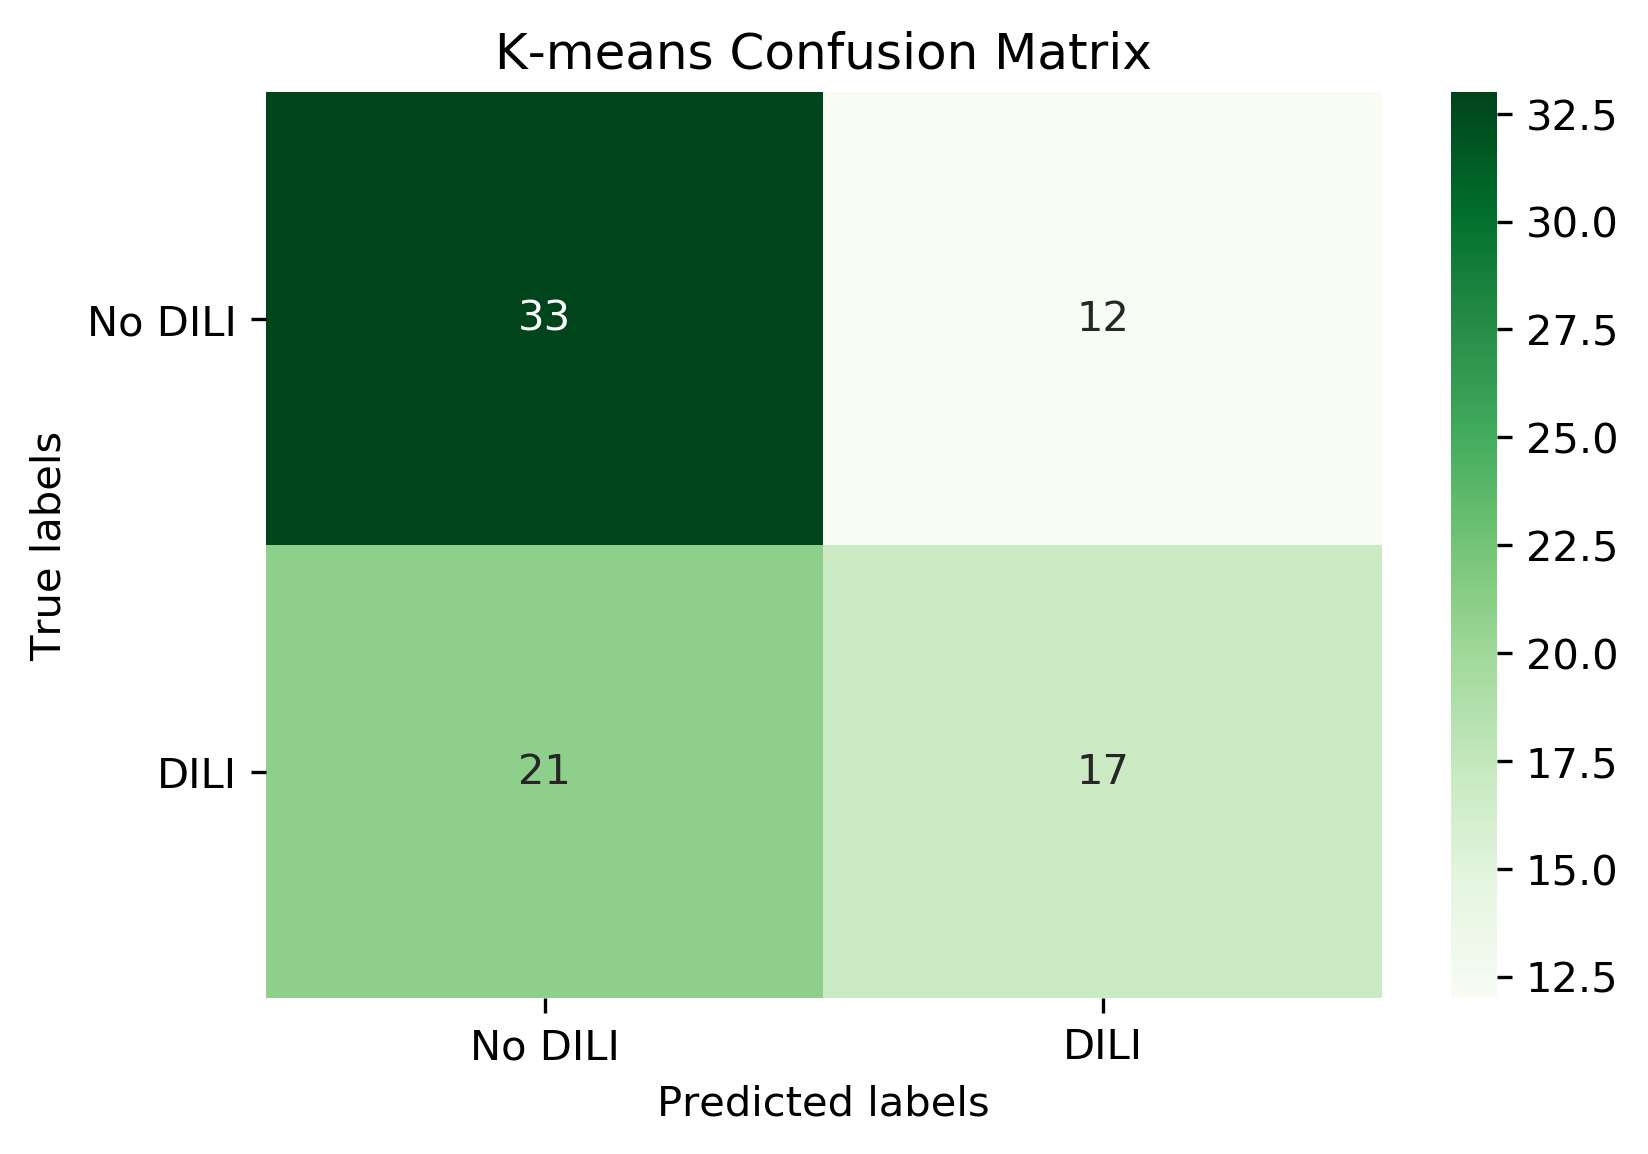

In [231]:
cM(B_test.iloc[:,3], p_nB_DILI6)

## Linear Regression

#### Hyperparemeter Tuning with gSearch

In [61]:
grid_params_LR = {
        'penalty': ['l1', 'l2'],
        'C': [0.001,0.01,0.1,1,10,100,1000],
}

LR_result_DILI1 = gSearch(grid_params_LR, linear_model.LogisticRegression(), A_train, B_train['DILI1'])
LR_result_DILI3 = gSearch(grid_params_LR, linear_model.LogisticRegression(), A_train, B_train['DILI3'])
LR_result_DILI5 = gSearch(grid_params_LR, linear_model.LogisticRegression(), A_train, B_train['DILI5'])
LR_result_DILI6 = gSearch(grid_params_LR, linear_model.LogisticRegression(), A_train, B_train['DILI6'])

print("DILI1")
print("Best Score: ", LR_result_DILI1.best_score_)
print("Best Estimator: ", LR_result_DILI1.best_estimator_)
print("Best Params: ",LR_result_DILI1.best_params_)

print("DILI3")
print("Best Score: ", LR_result_DILI3.best_score_)
print("Best Estimator: ", LR_result_DILI3.best_estimator_)
print("Best Params: ", LR_result_DILI3.best_params_)

print("DILI5")
print("Best Score: ", LR_result_DILI5.best_score_)
print("Best Estimator: ", LR_result_DILI5.best_estimator_)
print("Best Params: ", LR_result_DILI5.best_params_)

print("DILI6")
print("Best Score: ", LR_result_DILI6.best_score_)
print("Best Estimator: ", LR_result_DILI6.best_estimator_)
print("Best Params: ", LR_result_DILI6.best_params_)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/p

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/p

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/p

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/p

DILI1
Best Score:  0.7831325301204819
Best Estimator:  LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Best Params:  {'C': 0.001, 'penalty': 'l1'}
DILI3
Best Score:  0.6174698795180723
Best Estimator:  LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Best Params:  {'C': 0.001, 'penalty': 'l1'}
DILI5
Best Score:  0.5210843373493976
Best Estimator:  LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',


In [62]:
def lR(X_train, X_test, y_train, p, c) :
    lr = linear_model.LogisticRegression(penalty = p, C = c)

    #Train
    lr.fit(X_train,y_train)
    score = lr.score(X_train, y_train)

    #Test
    predictions = lr.predict(X_test)
    y_prob = lr.predict_proba(X_test)
    
    #10-Fold Cross-Validation
    cross_Val = crossVal(lr, X_train, y_train, 10)


    return(predictions, y_prob, score, cross_Val)

In [63]:
p_lR_DILI1, y_lR_DILI1, s_lR_DILI1, cv_lR_DILI1 = lR(A_train, #Training Set
                                                     A_test, #Test Set
                                                     B_train['DILI1'], #Training labels
                                                     'l1', #penalty
                                                     0.001 #C
                                                     )
p_lR_DILI3, y_lR_DILI3, s_lR_DILI3, cv_lR_DILI3 = lR(A_train, 
                                                     A_test, 
                                                     B_train['DILI3'],
                                                     'l1',
                                                     0.001
                                                     )
p_lR_DILI5, y_lR_DILI5, s_lR_DILI5, cv_lR_DILI5 = lR(A_train, 
                                                     A_test, 
                                                     B_train['DILI5'],
                                                     'l1',
                                                     0.001
                                                     )
p_lR_DILI6, y_lR_DILI6, s_lR_DILI6, cv_lR_DILI6 = lR(A_train, 
                                                     A_test, 
                                                     B_train['DILI6'],
                                                     'l1',
                                                     1
                                                     )

/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

Cross Validation result:  0.7829768270944741 number of kFold splits:  10


/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

Cross Validation result:  0.6172905525846704 number of kFold splits:  10


/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

Cross Validation result:  0.5211229946524063 number of kFold splits:  10


/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

Cross Validation result:  0.6235294117647059 number of kFold splits:  10


#### Calculate Accuracy

In [64]:
print('Linear Regression accuracy (DILI1): ', round(accuracy_score(B_test.iloc[:,0], p_lR_DILI1), 3))
print('Linear Regression accuracy (DILI3): ', round(accuracy_score(B_test.iloc[:,1], p_lR_DILI3), 3))
print('Linear Regression accuracy (DILI5): ', round(accuracy_score(B_test.iloc[:,2], p_lR_DILI5), 3))
print('Linear Regression accuracy (DILI6): ', round(accuracy_score(B_test.iloc[:,3], p_lR_DILI6), 3))

Linear Regression accuracy (DILI1):  0.747
Linear Regression accuracy (DILI3):  0.627
Linear Regression accuracy (DILI5):  0.518
Linear Regression accuracy (DILI6):  0.518


#### Calculate Balanced Accuracy 

In [65]:
print('Linear Regression balanced accuracy (DILI1): ', round(balanced_accuracy_score(B_test.iloc[:,0], p_lR_DILI1), 3))
print('Linear Regression balanced accuracy (DILI3): ', round(balanced_accuracy_score(B_test.iloc[:,1], p_lR_DILI3), 3))
print('Linear Regression balanced accuracy (DILI5): ', round(balanced_accuracy_score(B_test.iloc[:,2], p_lR_DILI5), 3))
print('Linear Regression balanced accuracy (DILI6): ', round(balanced_accuracy_score(B_test.iloc[:,3], p_lR_DILI6), 3))

Linear Regression balanced accuracy (DILI1):  0.5
Linear Regression balanced accuracy (DILI3):  0.5
Linear Regression balanced accuracy (DILI5):  0.5
Linear Regression balanced accuracy (DILI6):  0.523


#### Calculate Precision Score

In [66]:
print('LR Precision (DILI1): ', round(precision_score(B_test.iloc[:,0], p_lR_DILI1), 3))
print('LR Precision  (DILI3): ', round(precision_score(B_test.iloc[:,1], p_lR_DILI3), 3))
print('LR Precision  (DILI5): ', round(precision_score(B_test.iloc[:,2], p_lR_DILI5), 3))
print('LR Precision  (DILI6): ', round(precision_score(B_test.iloc[:,3], p_lR_DILI6), 3))


LR Precision (DILI1):  0.0
LR Precision  (DILI3):  0.0
LR Precision  (DILI5):  0.0
LR Precision  (DILI6):  0.478


/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Calculate F1 Score

In [318]:
print('LR F1 Score (DILI1): ', round(f1_score(B_test.iloc[:,0], p_lR_DILI1), 3))
print('LR F1 Score (DILI3): ', round(f1_score(B_test.iloc[:,1], p_lR_DILI3), 3))
print('LR F1 Score (DILI5): ', round(f1_score(B_test.iloc[:,2], p_lR_DILI5), 3))
print('LR F1 Score (DILI6): ', round(f1_score(B_test.iloc[:,3], p_lR_DILI6), 3))


LR F1 Score (DILI1):  0.0
LR F1 Score (DILI3):  0.0
LR F1 Score (DILI5):  0.0
LR F1 Score (DILI6):  0.524


#### Calculate ROC AUC Score 

In [67]:
print('LR ROC AUC Score (DILI1): ', round(roc_auc_score(B_test.iloc[:,0], y_lR_DILI1[:,0]), 3))
print('LR ROC AUC Score (DILI3): ', round(roc_auc_score(B_test.iloc[:,1], y_lR_DILI3[:,0]), 3))
print('LR ROC AUC Score (DILI5): ', round(roc_auc_score(B_test.iloc[:,2], y_lR_DILI5[:,0]), 3))
print('LR ROC AUC Score (DILI6): ', round(roc_auc_score(B_test.iloc[:,3], y_lR_DILI6[:,0]), 3))

LR ROC AUC Score (DILI1):  0.5
LR ROC AUC Score (DILI3):  0.5
LR ROC AUC Score (DILI5):  0.5
LR ROC AUC Score (DILI6):  0.401


#### Calculate FPR and TPR, and plot ROC curve.

In [68]:
fpr_LR_DILI1, tpr_LR_DILI1, _ = roc_curve(B_test.iloc[:,0], y_lR_DILI1[:,0])
fpr_LR_DILI3, tpr_LR_DILI3, _ = roc_curve(B_test.iloc[:,0], y_lR_DILI3[:,0])
fpr_LR_DILI5, tpr_LR_DILI5, _ = roc_curve(B_test.iloc[:,0], y_lR_DILI5[:,0])
fpr_LR_DILI6, tpr_LR_DILI6, _ = roc_curve(B_test.iloc[:,0], y_lR_DILI6[:,0])


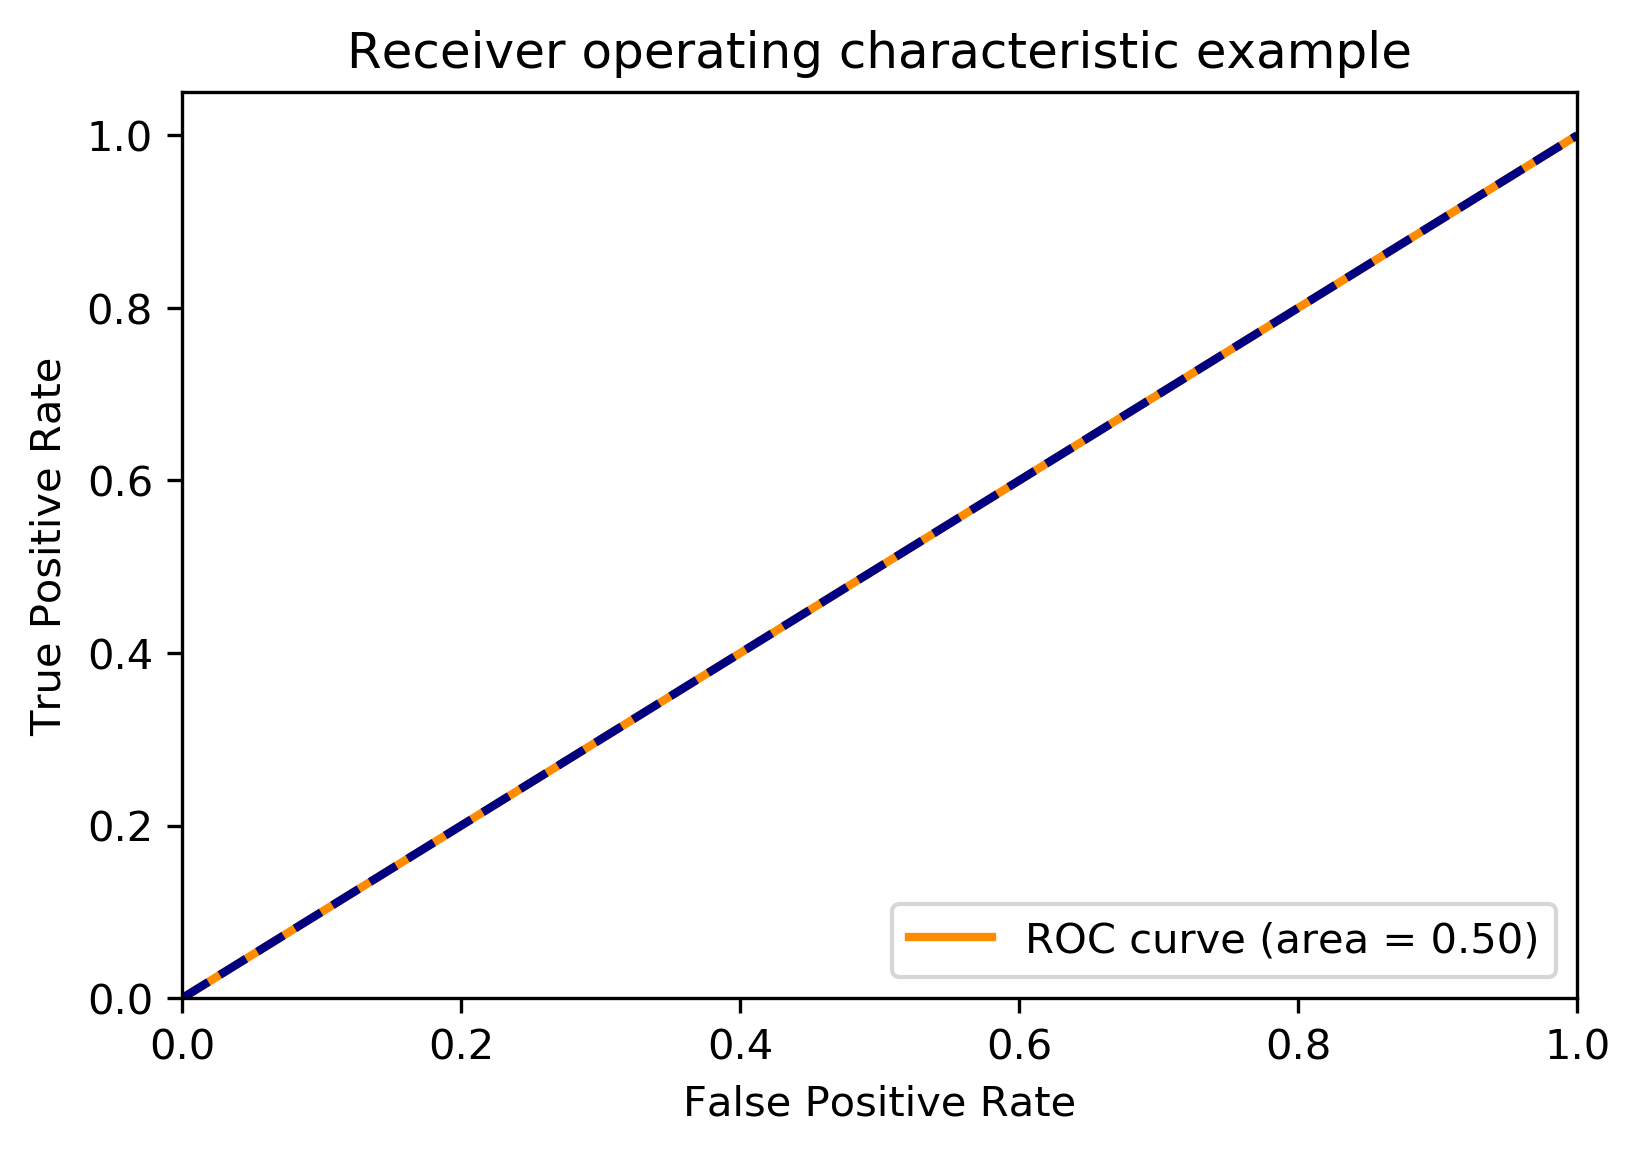

In [232]:
plotROC(fpr_LR_DILI1, tpr_LR_DILI1, roc_auc_score(B_test.iloc[:,0], y_lR_DILI1[:,0]))

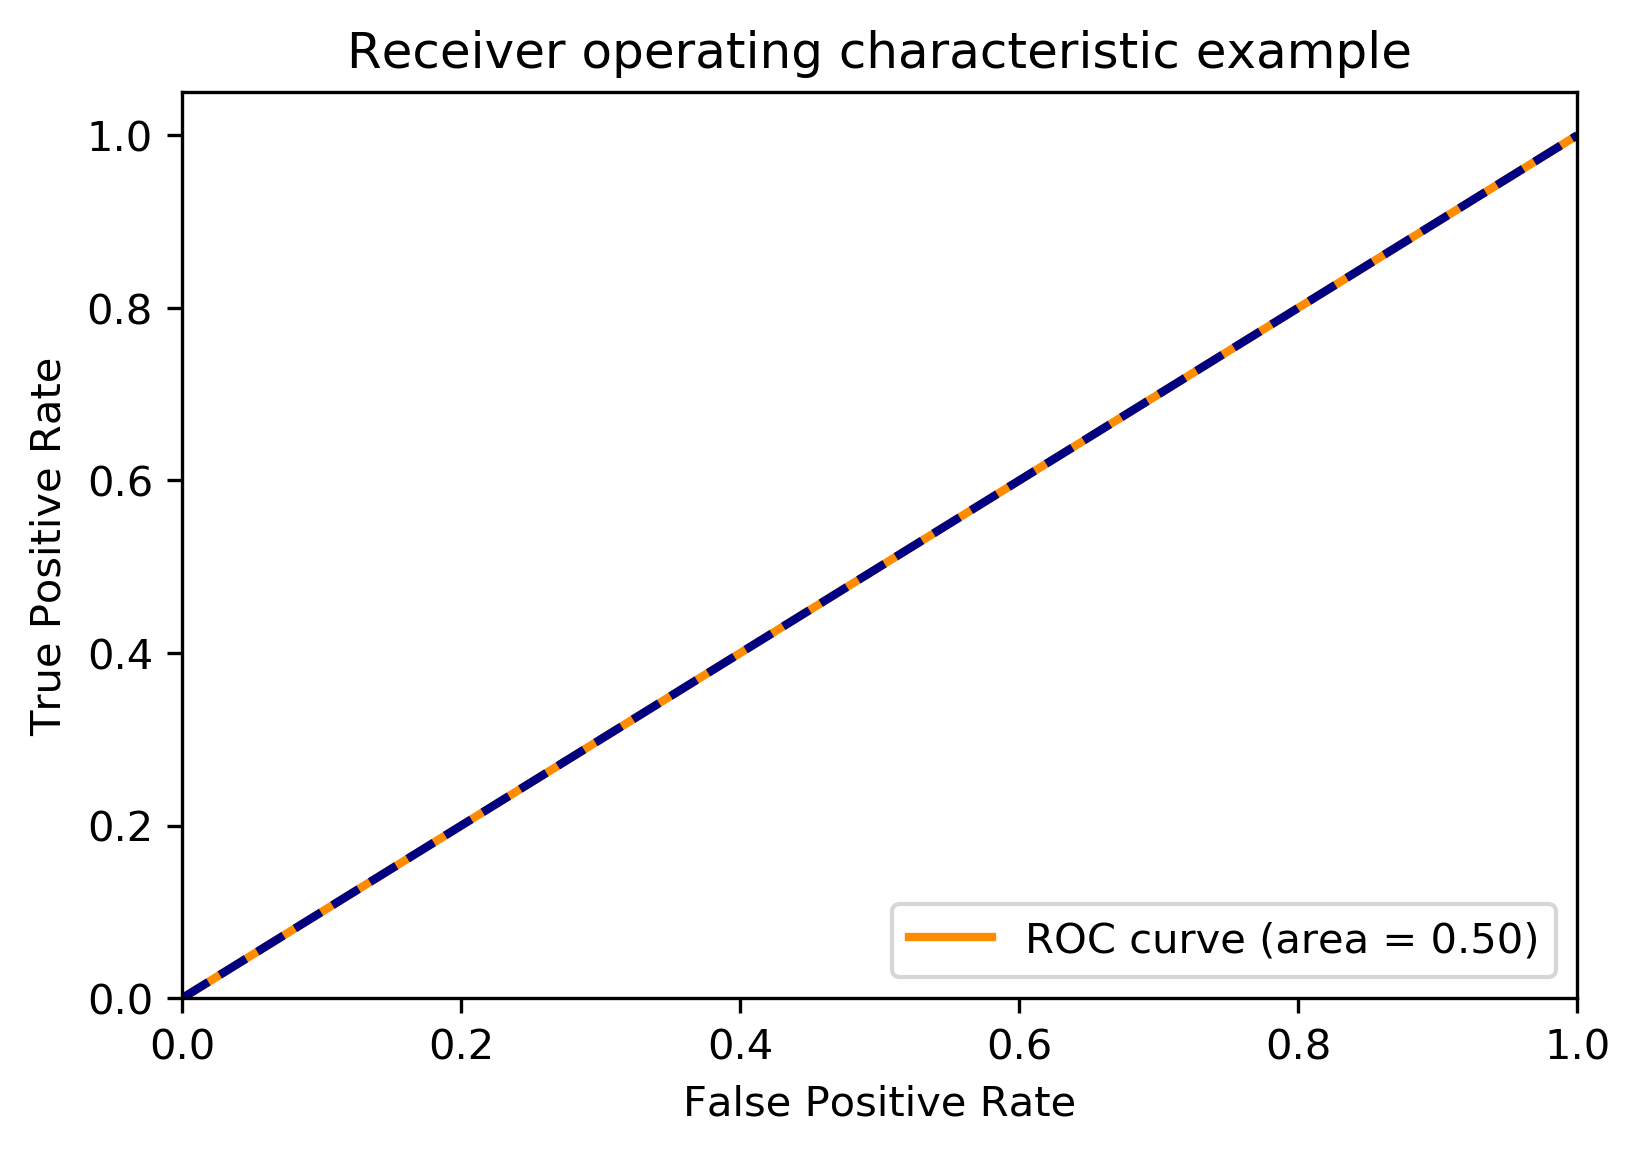

In [234]:
plotROC(fpr_LR_DILI3, tpr_LR_DILI3, roc_auc_score(B_test.iloc[:,1], y_lR_DILI3[:,0]))

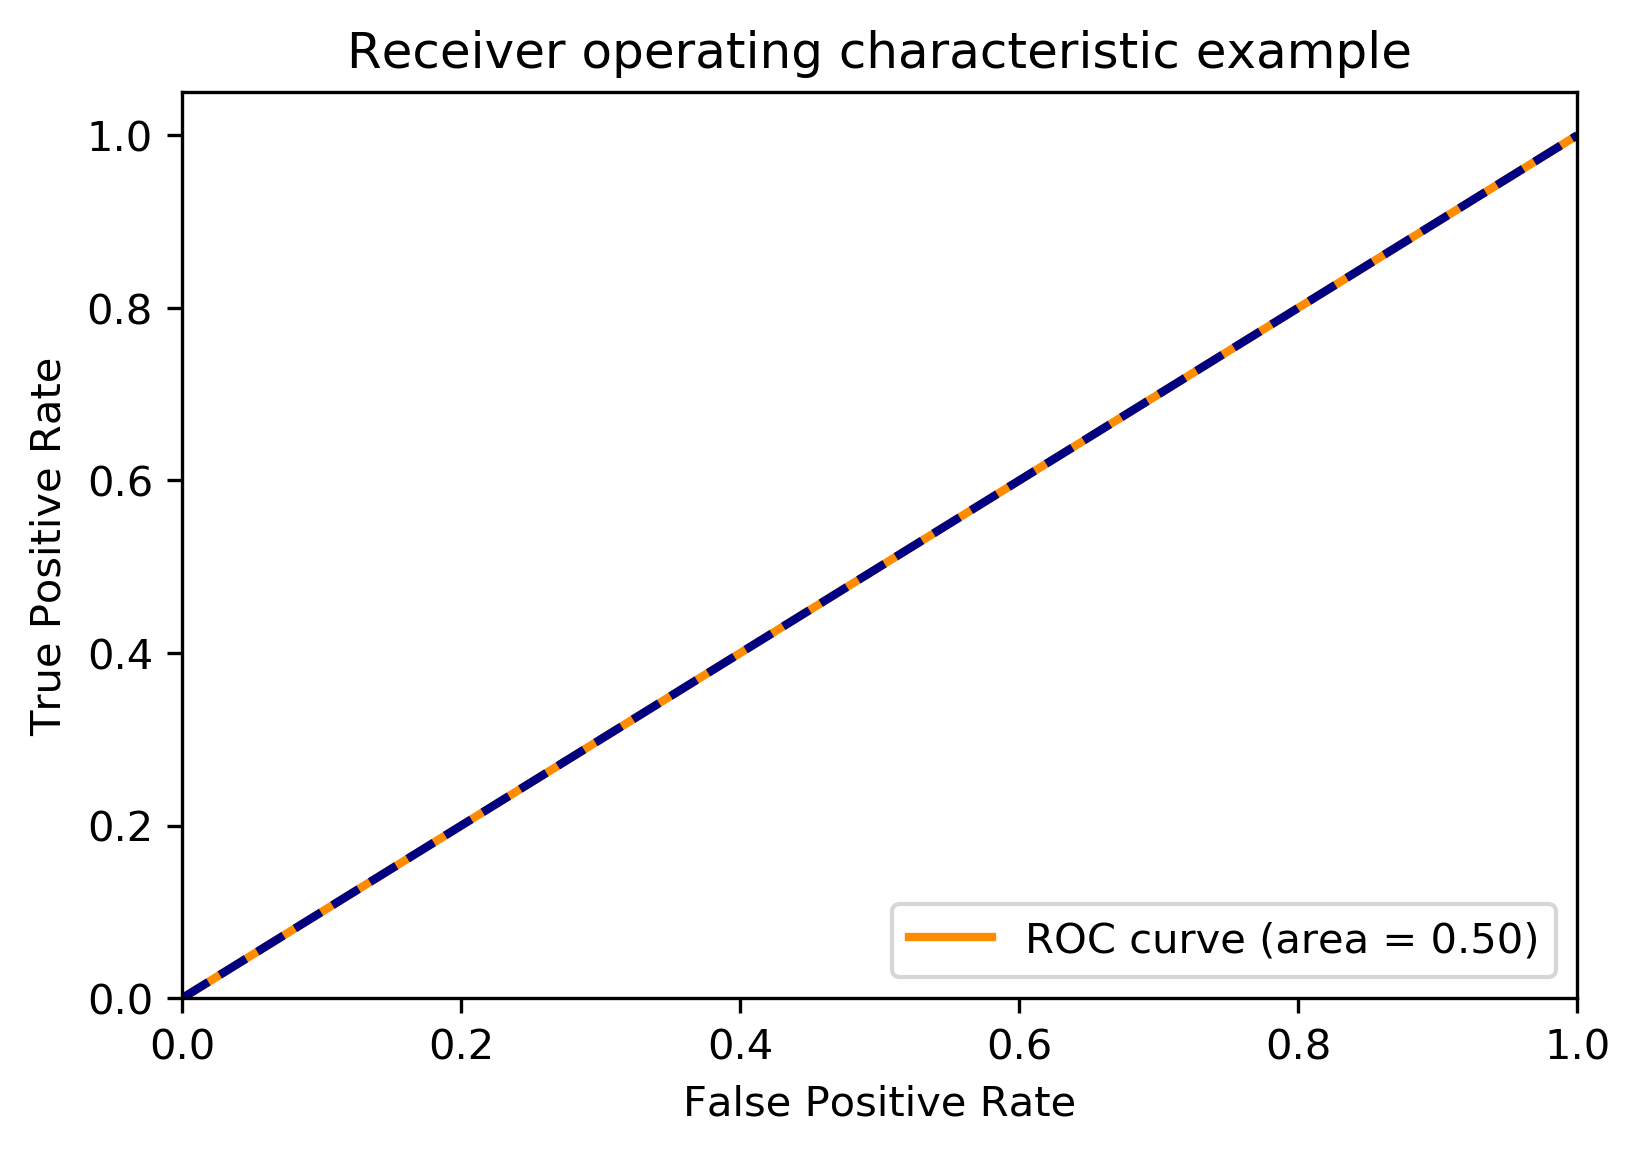

In [235]:
plotROC(fpr_LR_DILI5, tpr_LR_DILI5, roc_auc_score(B_test.iloc[:,2], y_lR_DILI5[:,0]))

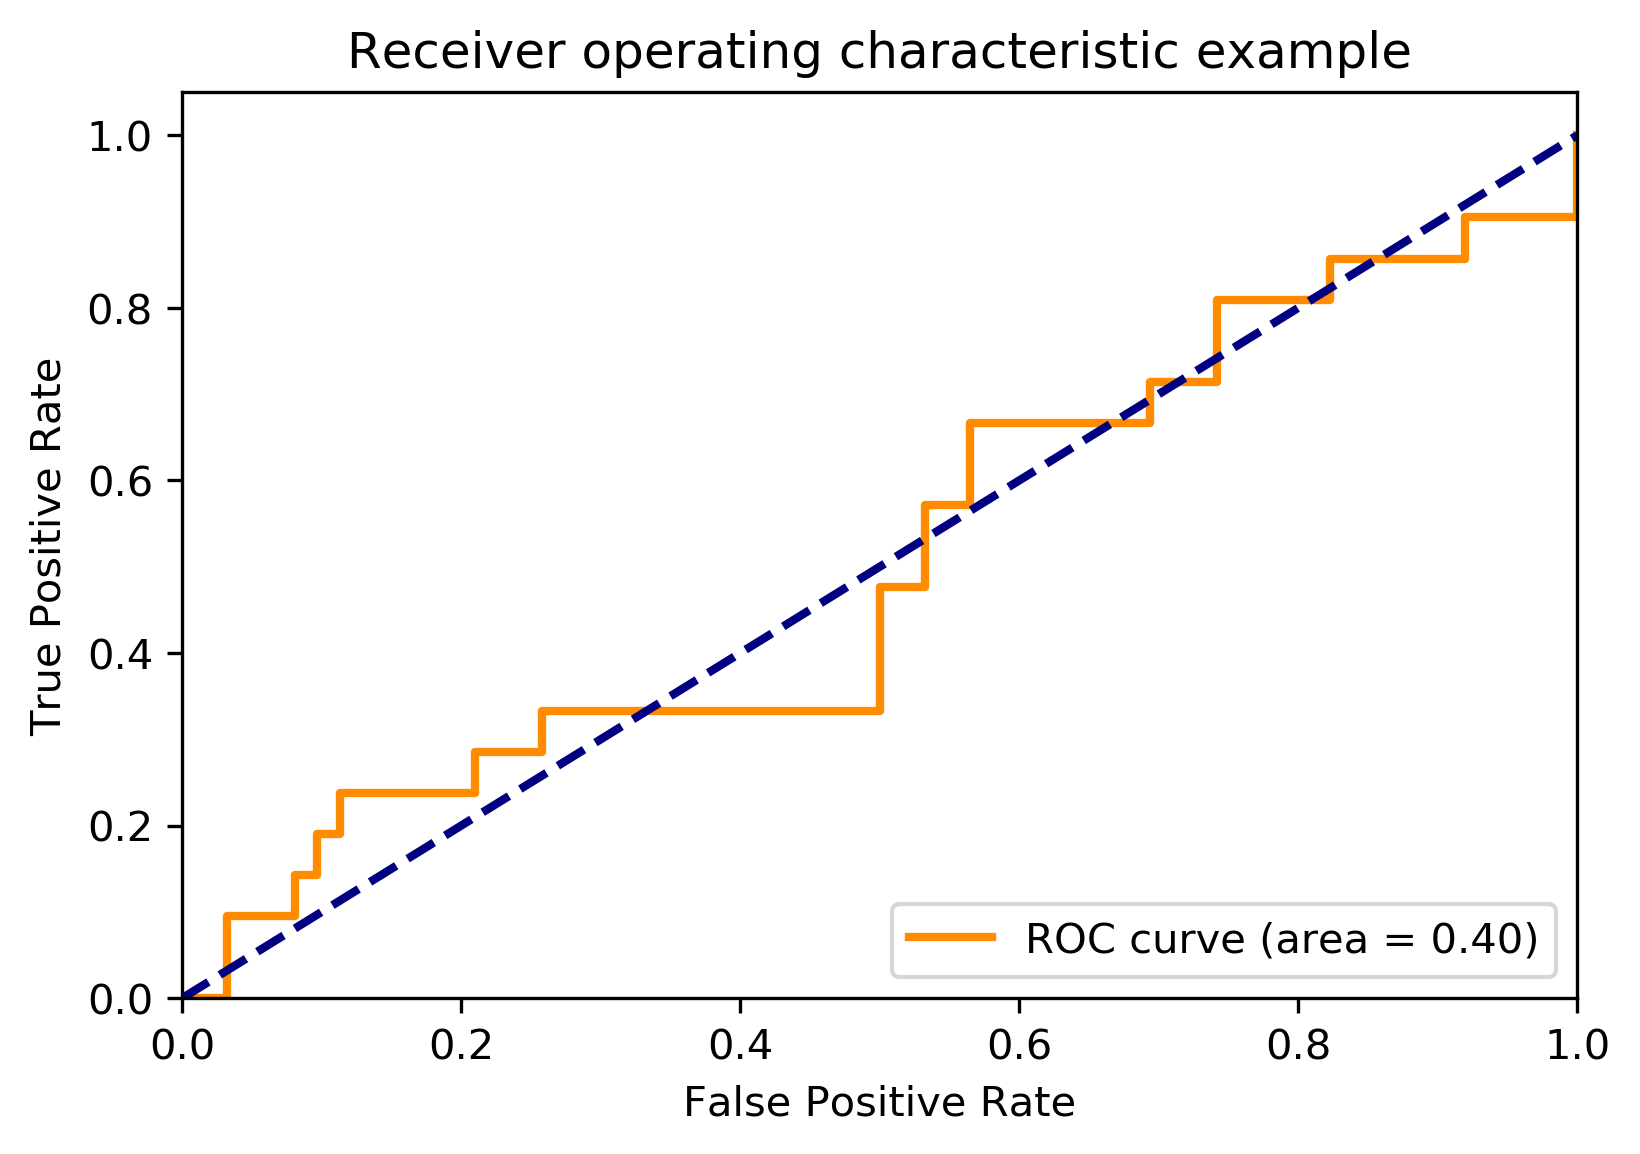

In [236]:
plotROC(fpr_LR_DILI6, tpr_LR_DILI6, roc_auc_score(B_test.iloc[:,3], y_lR_DILI6[:,0]))

#### Plot Confusion Matrices

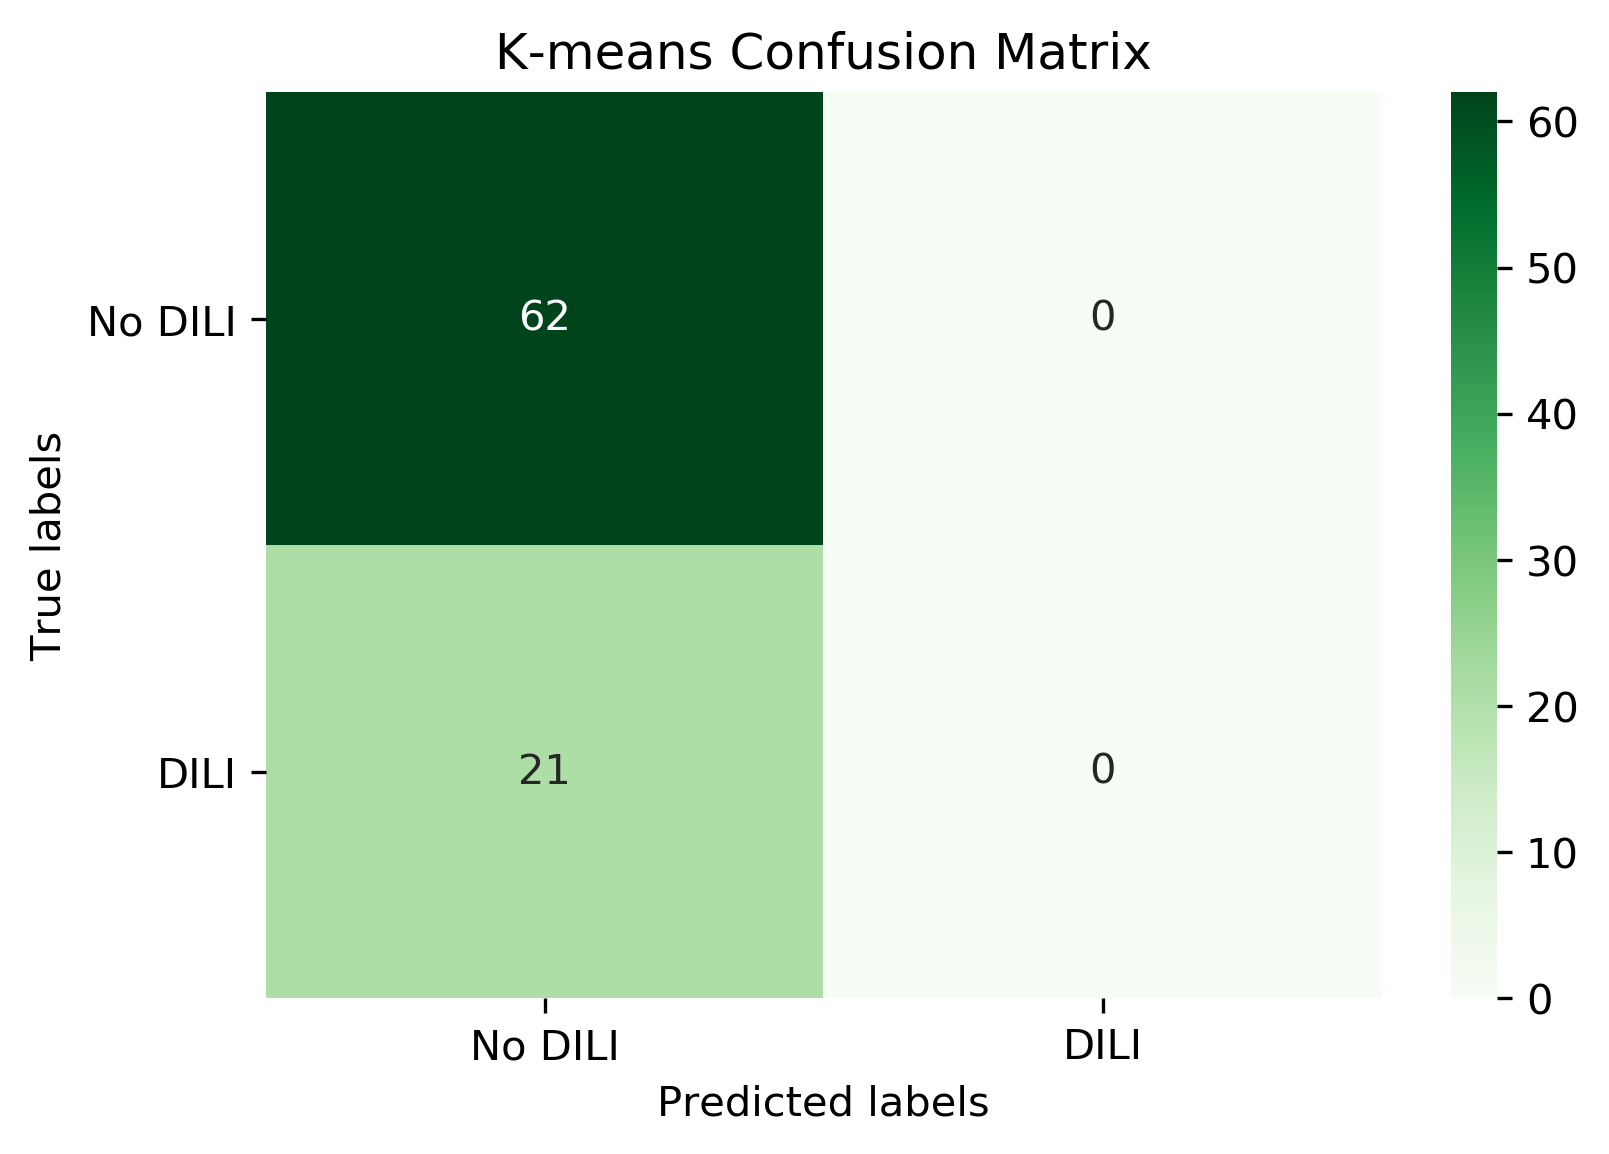

In [237]:
cM(B_test.iloc[:,0], p_lR_DILI1)

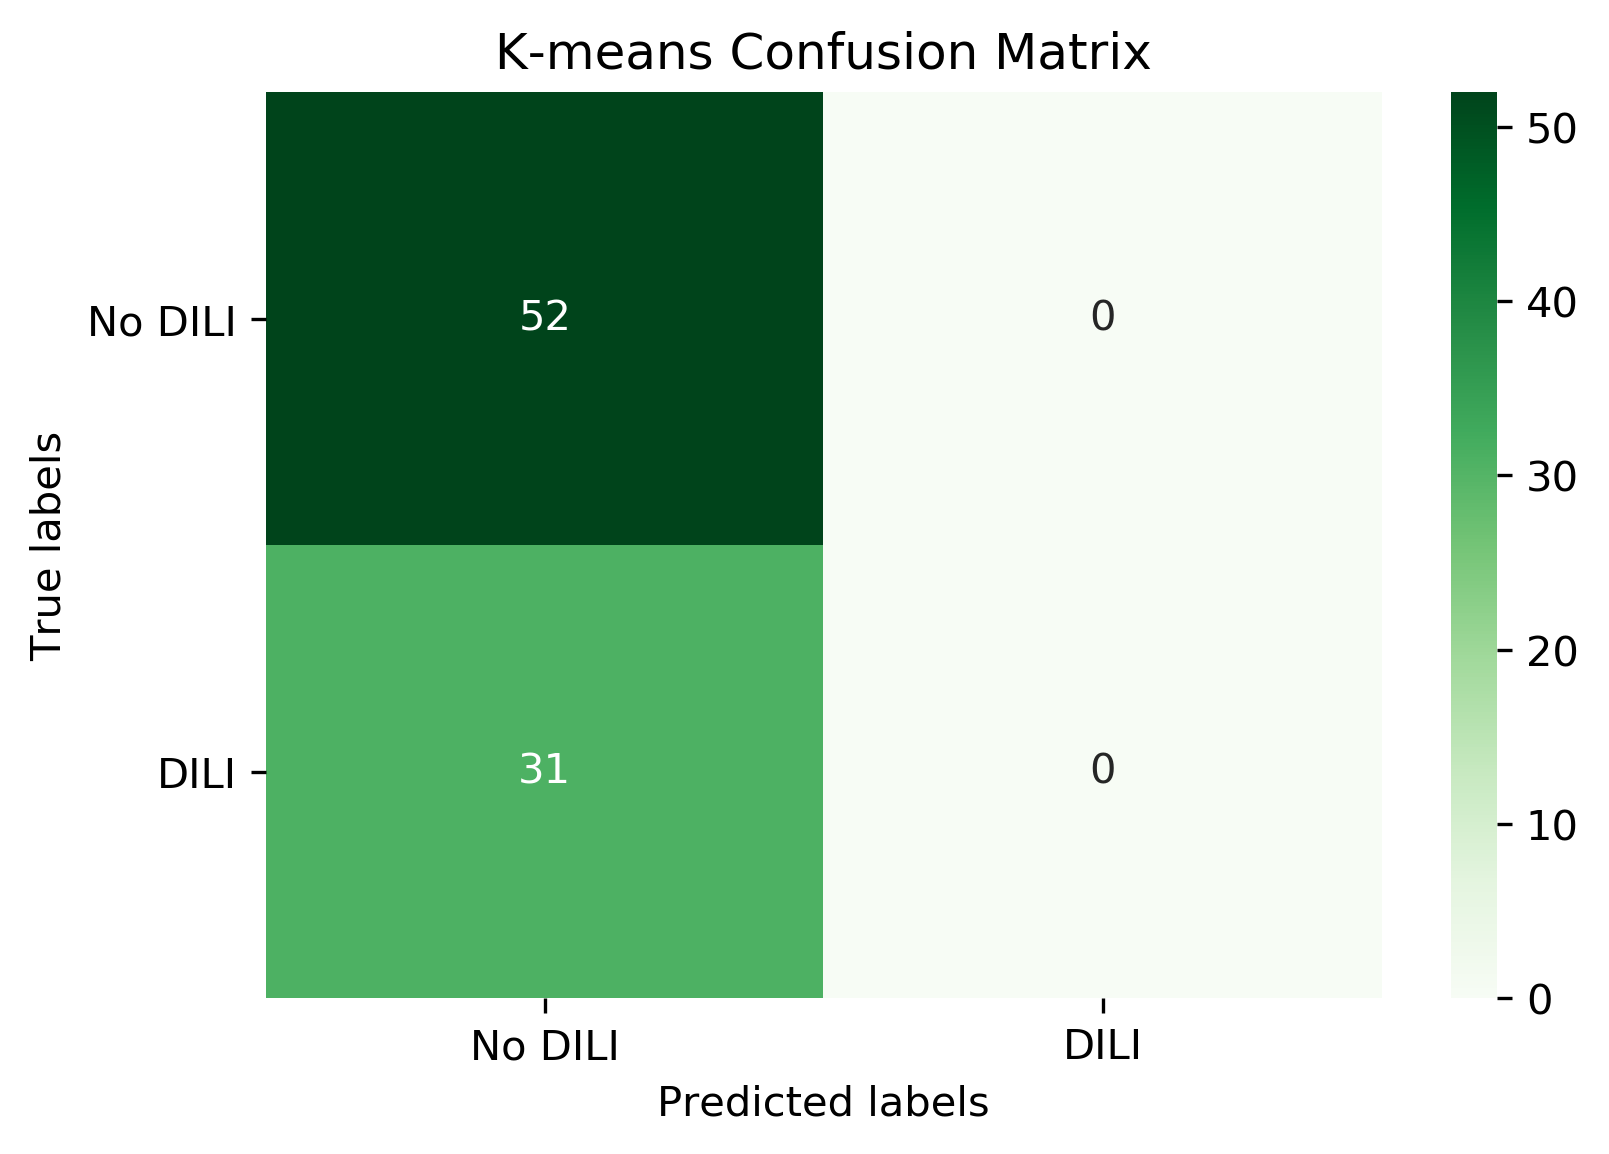

In [238]:
cM(B_test.iloc[:,1], p_lR_DILI3)

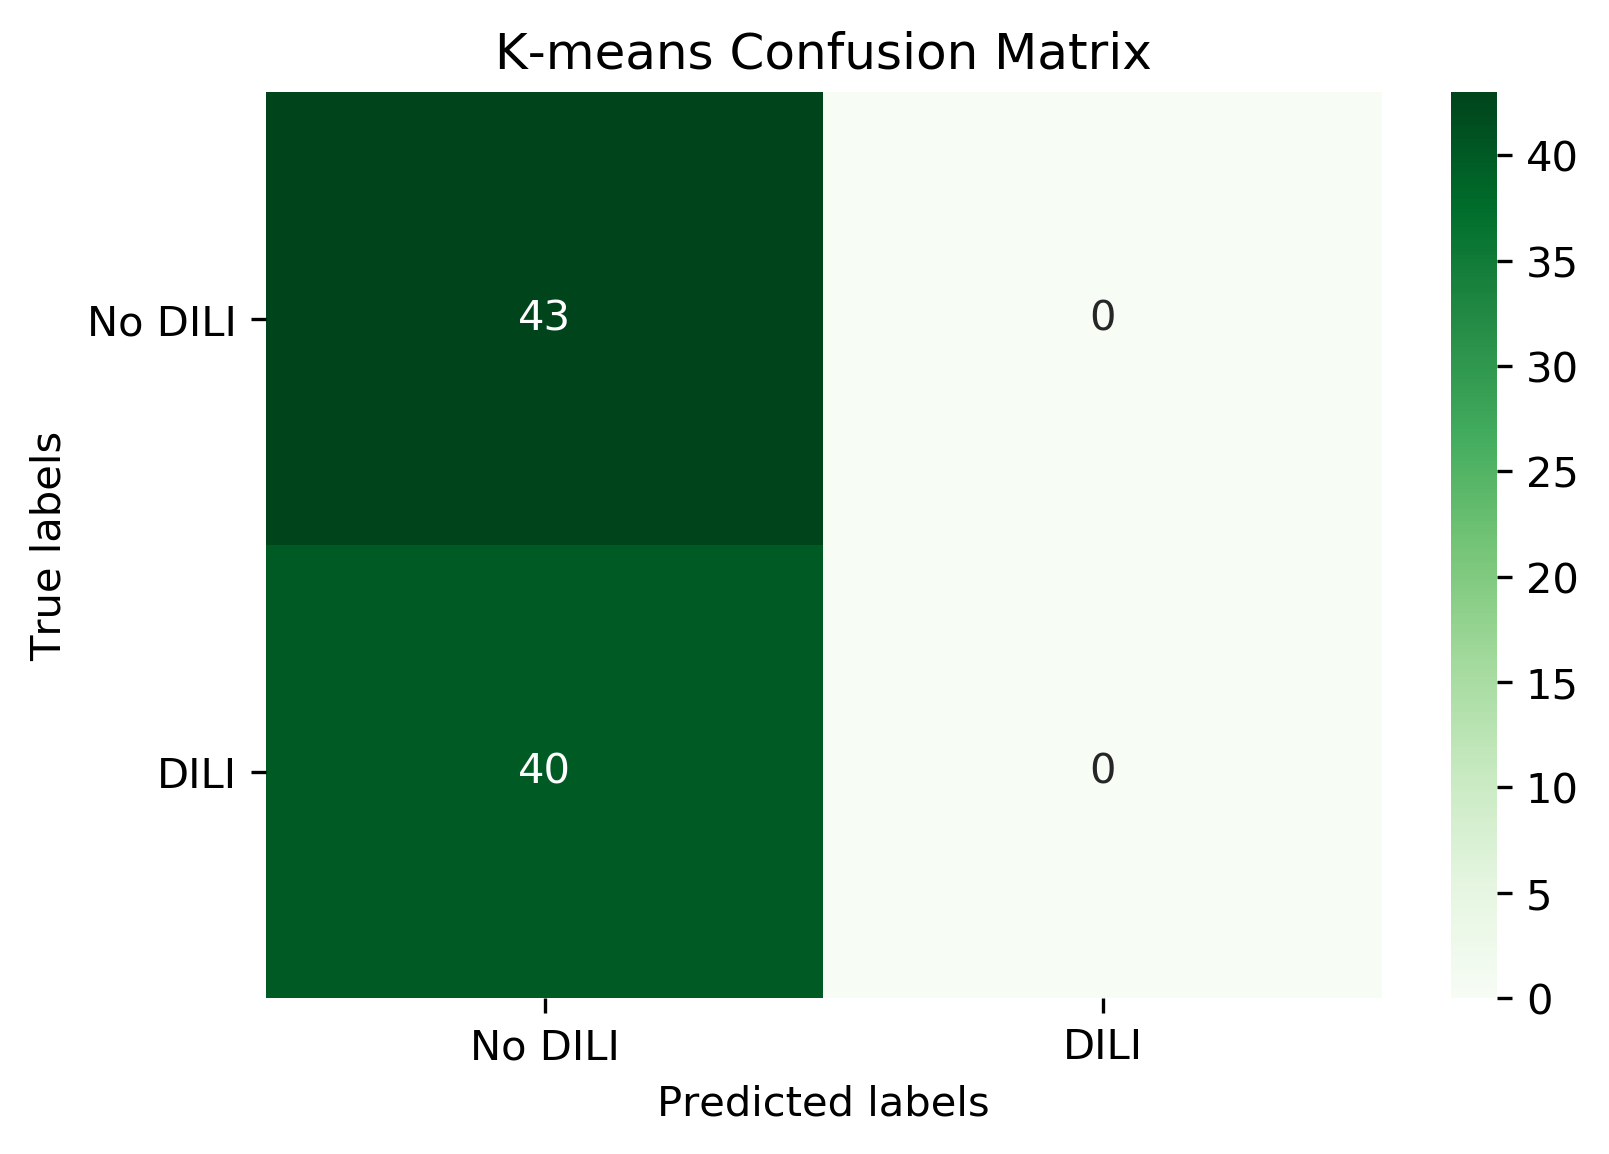

In [239]:
cM(B_test.iloc[:,2], p_lR_DILI5)

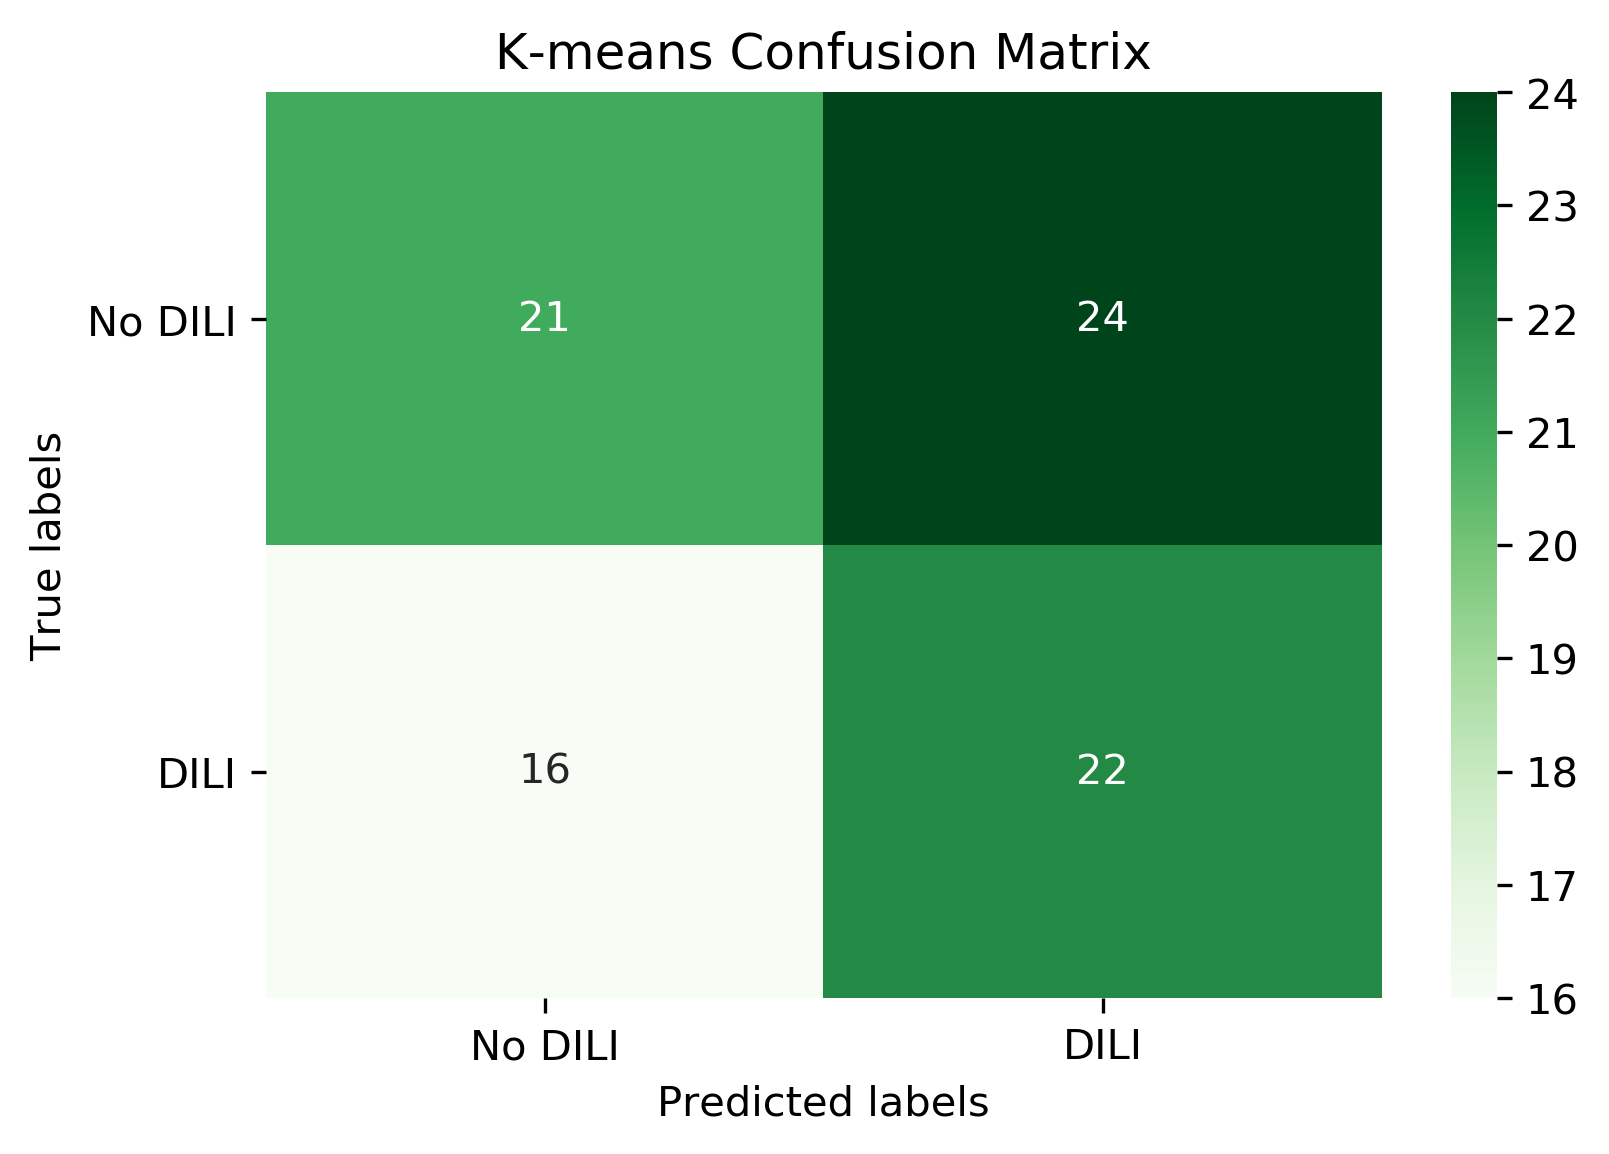

In [240]:
cM(B_test.iloc[:,3], p_lR_DILI6)

## Random Forest

#### Hyperparemeter tuning with rSearch
rSearch was used to reduce time. gSearch takes too long. 

In [77]:
grid_params_RF = {
        'n_estimators': [10,50,100,200,500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [4,5,6,7,8],
        'criterion': ['gini', 'entropy'],
}

RF_result_DILI1 = rSearch(grid_params_RF, RandomForestClassifier(random_state=0), A_train, B_train['DILI1'])
RF_result_DILI3 = rSearch(grid_params_RF, RandomForestClassifier(random_state=0), A_train, B_train['DILI3'])
RF_result_DILI5 = rSearch(grid_params_RF, RandomForestClassifier(random_state=0), A_train, B_train['DILI5'])
RF_result_DILI6 = rSearch(grid_params_RF, RandomForestClassifier(random_state=0), A_train, B_train['DILI6'])

print("DILI1")
print("Best Score: ", RF_result_DILI1.best_score_)
print("Best Estimator: ", RF_result_DILI1.best_estimator_)
print("Best Params: ",RF_result_DILI1.best_params_)

print("DILI3")
print("Best Score: ", RF_result_DILI3.best_score_)
print("Best Estimator: ", RF_result_DILI3.best_estimator_)
print("Best Params: ", RF_result_DILI3.best_params_)

print("DILI5")
print("Best Score: ", RF_result_DILI5.best_score_)
print("Best Estimator: ", RF_result_DILI5.best_estimator_)
print("Best Params: ", RF_result_DILI5.best_params_)

print("DILI6")
print("Best Score: ", RF_result_DILI6.best_score_)
print("Best Estimator: ", RF_result_DILI6.best_estimator_)
print("Best Params: ", RF_result_DILI6.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.2min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.3min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 10 candidates, totalling 100 fits
DILI1
Best Score:  0.7831325301204819
Best Estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=4, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Best Params:  {'n_estimators': 50, 'max_features': 'log2', 'max_depth': 4, 'criterion': 'entropy'}
DILI3
Best Score:  0.6114457831325302
Best Estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=7, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.6min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [78]:
def rF(X_train, X_test, y_train, n, mf, md, c) :

    RF = RandomForestClassifier(random_state=0, n_estimators = n, max_features = mf, max_depth = md, criterion = c)

    #Train
    RF.fit(X_train, y_train)
    score = RF.score(X_train, y_train)

    #Test
    predictions = RF.predict(X_test)
    y_prob = RF.predict_log_proba(X_test)
    
    #10-Fold Cross-Validation
    cross_Val = crossVal(RF, X_train, y_train, 10)

    return(predictions, y_prob, score, cross_Val)

In [79]:
p_rF_DILI1, y_rF_DILI1, s_rF_DILI1, cv_rF_DILI1 = rF(A_train, #Training Set
                                                     A_test, #Test Set
                                                     B_train['DILI1'], #Training labels
                                                     100, #n_estimators
                                                     'log2', #max_features
                                                     8, #max depth
                                                     'gini' #criterion
                                                    )
p_rF_DILI3, y_rF_DILI3, s_rF_DILI3, cv_rF_DILI3 = rF(A_train, 
                                                     A_test, 
                                                     B_train['DILI3'],
                                                     500,
                                                     'log2',
                                                     6,
                                                     'entropy'
                                                    )
p_rF_DILI5, y_rF_DILI5, s_rF_DILI5, cv_rF_DILI5 = rF(A_train, 
                                                     A_test, 
                                                     B_train['DILI5'],
                                                     50,
                                                     'log2',
                                                     6,
                                                     'gini'
                                                    )
p_rF_DILI6, y_rF_DILI6, s_rF_DILI6, cv_rF_DILI6 = rF(A_train, 
                                                     A_test, 
                                                     B_train['DILI6'],
                                                     500,
                                                     'log2',
                                                     4,
                                                     'entropy'
                                                    )

Cross Validation result:  0.7799465240641712 number of kFold splits:  10
Cross Validation result:  0.6052584670231729 number of kFold splits:  10
Cross Validation result:  0.44634581105169346 number of kFold splits:  10
Cross Validation result:  0.5965240641711229 number of kFold splits:  10


#### Calculate Accuracy 

In [80]:
print('Random Forest accuracy (DILI1): ', round(accuracy_score(B_test.iloc[:,0], p_rF_DILI1), 3))
print('Random Forest accuracy (DILI3): ', round(accuracy_score(B_test.iloc[:,1], p_rF_DILI3), 3))
print('Random Forest accuracy (DILI5): ', round(accuracy_score(B_test.iloc[:,2], p_rF_DILI5), 3))
print('Random Forest accuracy (DILI6): ', round(accuracy_score(B_test.iloc[:,3], p_rF_DILI6), 3))

Random Forest accuracy (DILI1):  0.747
Random Forest accuracy (DILI3):  0.614
Random Forest accuracy (DILI5):  0.446
Random Forest accuracy (DILI6):  0.651


#### Calculate Balanced Accuracy 

In [81]:
print('Random Forest balanced accuracy (DILI1): ', round(balanced_accuracy_score(B_test.iloc[:,0], p_rF_DILI1), 3))
print('Random Forest balanced accuracy (DILI3): ', round(balanced_accuracy_score(B_test.iloc[:,1], p_rF_DILI3), 3))
print('Random Forest balanced accuracy (DILI5): ', round(balanced_accuracy_score(B_test.iloc[:,2], p_rF_DILI5), 3))
print('Random Forest balanced accuracy (DILI6): ', round(balanced_accuracy_score(B_test.iloc[:,3], p_rF_DILI6), 3))

Random Forest balanced accuracy (DILI1):  0.5
Random Forest balanced accuracy (DILI3):  0.497
Random Forest balanced accuracy (DILI5):  0.44
Random Forest balanced accuracy (DILI6):  0.665


#### Calculate Precision Score 

In [82]:
print('RF Precision (DILI1): ', round(precision_score(B_test.iloc[:,0], p_rF_DILI1), 3))
print('RF Precision  (DILI3): ', round(precision_score(B_test.iloc[:,1], p_rF_DILI3), 3))
print('RF Precision  (DILI5): ', round(precision_score(B_test.iloc[:,2], p_rF_DILI5), 3))
print('RF Precision  (DILI6): ', round(precision_score(B_test.iloc[:,3], p_rF_DILI6), 3))


RF Precision (DILI1):  0.0
RF Precision  (DILI3):  0.333
RF Precision  (DILI5):  0.393
RF Precision  (DILI6):  0.582


/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Calculate F1 Score

In [321]:
print('RF F1 Score (DILI1): ', round(f1_score(B_test.iloc[:,0], p_rF_DILI1), 3))
print('RF F1 Score (DILI3): ', round(f1_score(B_test.iloc[:,1], p_rF_DILI3), 3))
print('RF F1 Score (DILI5): ', round(f1_score(B_test.iloc[:,2], p_rF_DILI5), 3))
print('RF F1 Score (DILI6): ', round(f1_score(B_test.iloc[:,3], p_rF_DILI6), 3))


RF F1 Score (DILI1):  0.0
RF F1 Score (DILI3):  0.059
RF F1 Score (DILI5):  0.324
RF F1 Score (DILI6):  0.688


#### Calculate ROC AUC Score 

In [83]:
print('RF ROC AUC Score (DILI1): ', round(roc_auc_score(B_test.iloc[:,0], y_rF_DILI1[:,0]), 3))
print('RF ROC AUC Score (DILI3): ', round(roc_auc_score(B_test.iloc[:,1], y_rF_DILI3[:,0]), 3))
print('RF ROC AUC Score (DILI5): ', round(roc_auc_score(B_test.iloc[:,2], y_rF_DILI5[:,0]), 3))
print('RF ROC AUC Score (DILI6): ', round(roc_auc_score(B_test.iloc[:,3], y_rF_DILI6[:,0]), 3))


RF ROC AUC Score (DILI1):  0.444
RF ROC AUC Score (DILI3):  0.502
RF ROC AUC Score (DILI5):  0.51
RF ROC AUC Score (DILI6):  0.288


#### Calculate FPR and TPR, and plot ROC curver

In [84]:
fpr_RF_DILI1, tpr_RF_DILI1, _ = roc_curve(B_test.iloc[:,0], y_rF_DILI1[:,0])
fpr_RF_DILI3, tpr_RF_DILI3, _ = roc_curve(B_test.iloc[:,0], y_rF_DILI3[:,0])
fpr_RF_DILI5, tpr_RF_DILI5, _ = roc_curve(B_test.iloc[:,0], y_rF_DILI5[:,0])
fpr_RF_DILI6, tpr_RF_DILI6, _ = roc_curve(B_test.iloc[:,0], y_rF_DILI6[:,0])


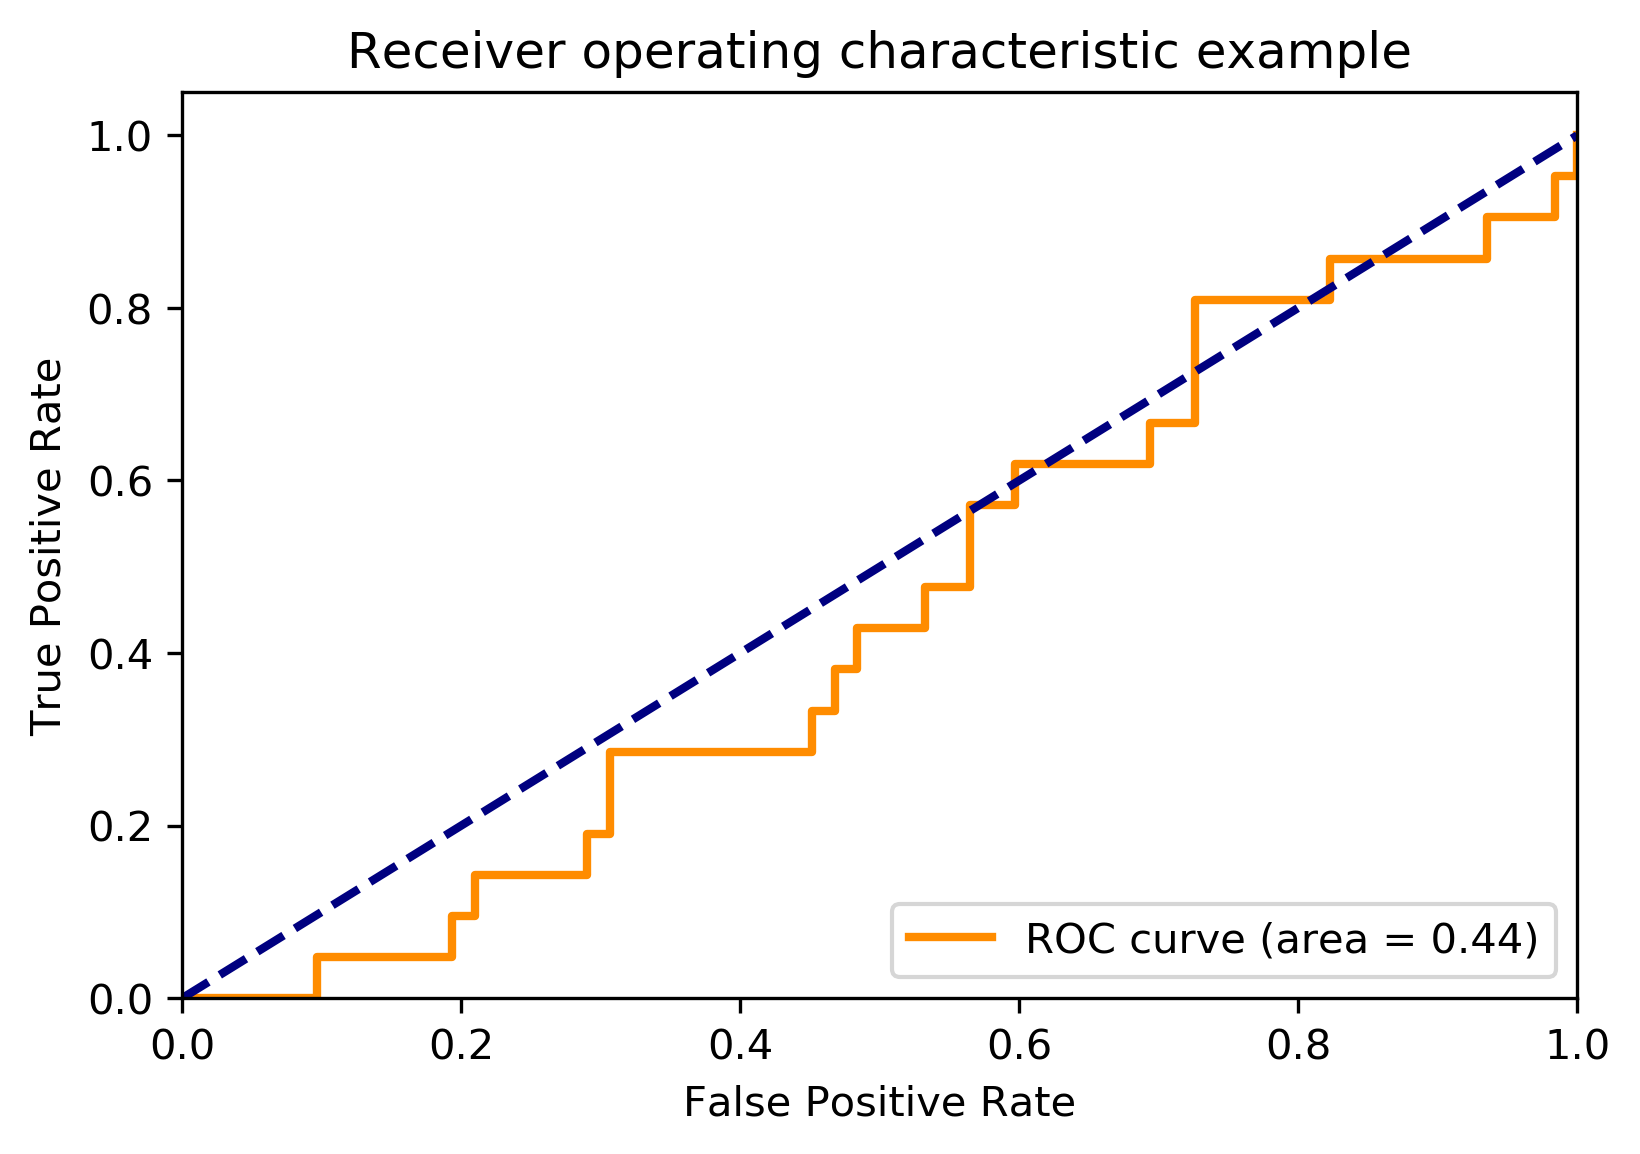

In [241]:
plotROC(fpr_RF_DILI1, tpr_RF_DILI1, roc_auc_score(B_test.iloc[:,0], y_rF_DILI1[:,0]))

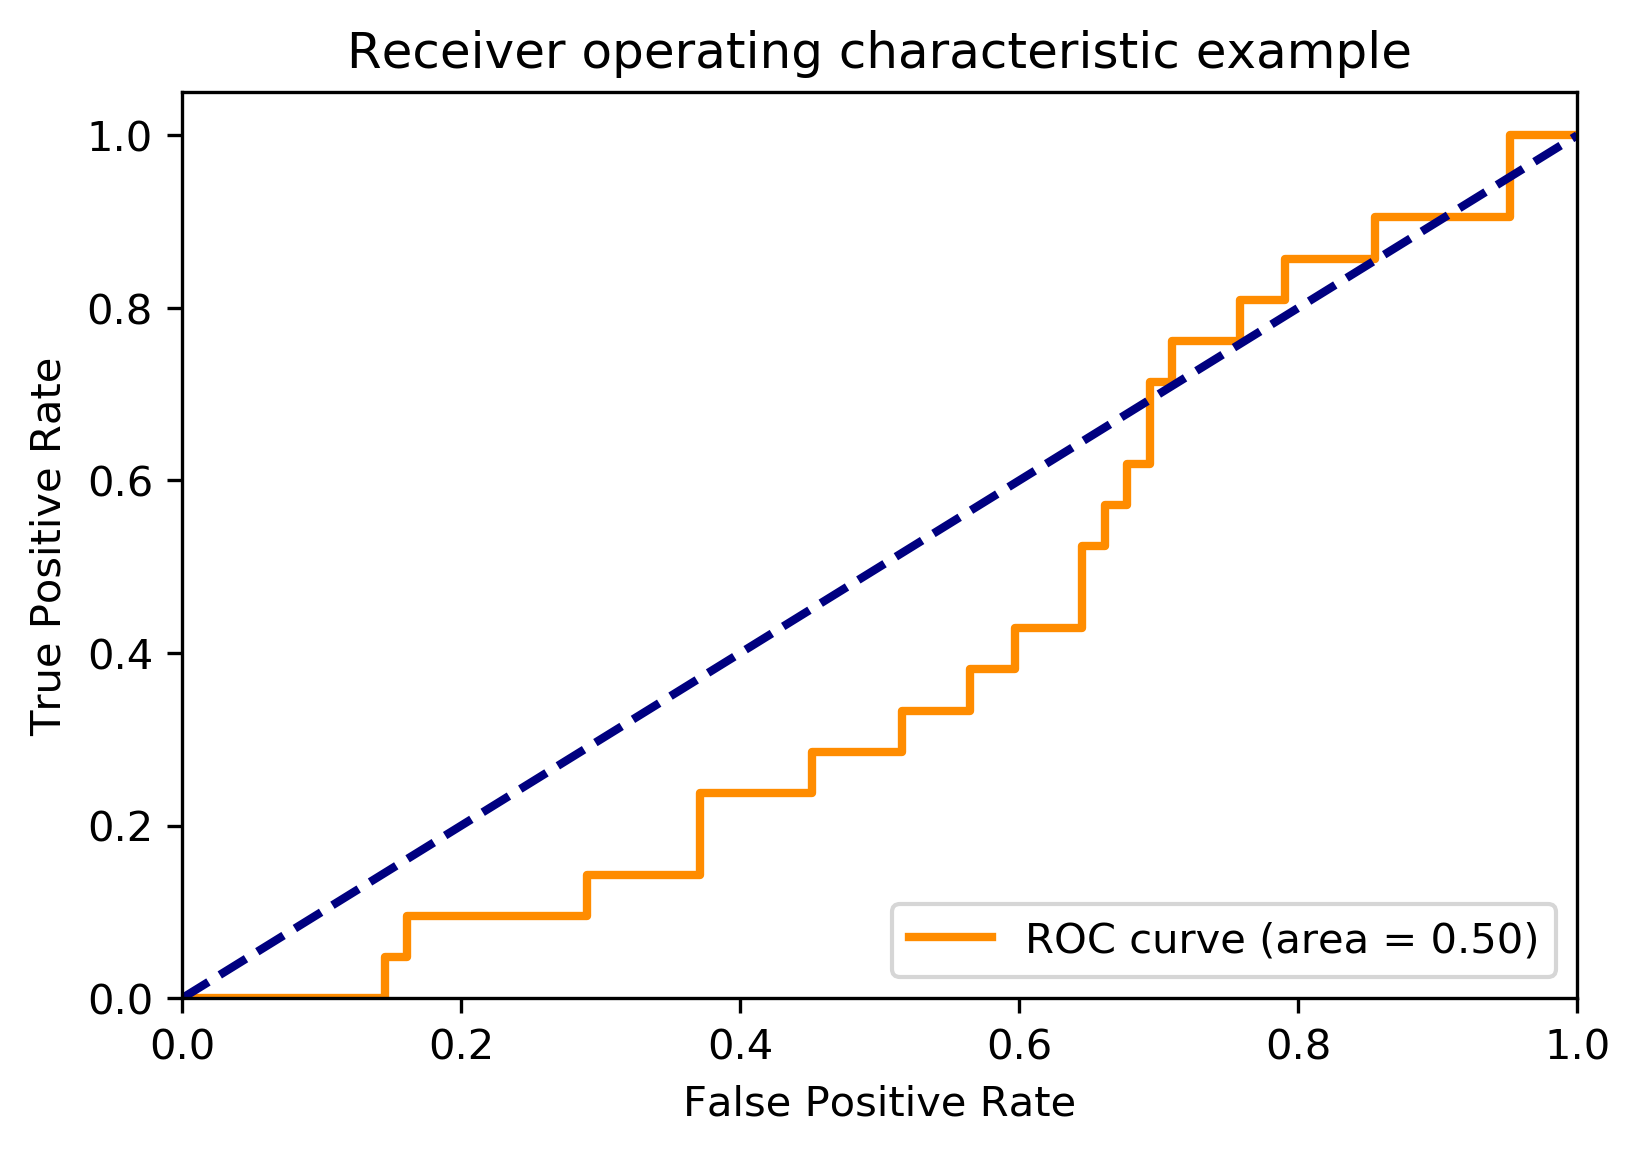

In [242]:
plotROC(fpr_RF_DILI3, tpr_RF_DILI3, roc_auc_score(B_test.iloc[:,1], y_rF_DILI3[:,0]))

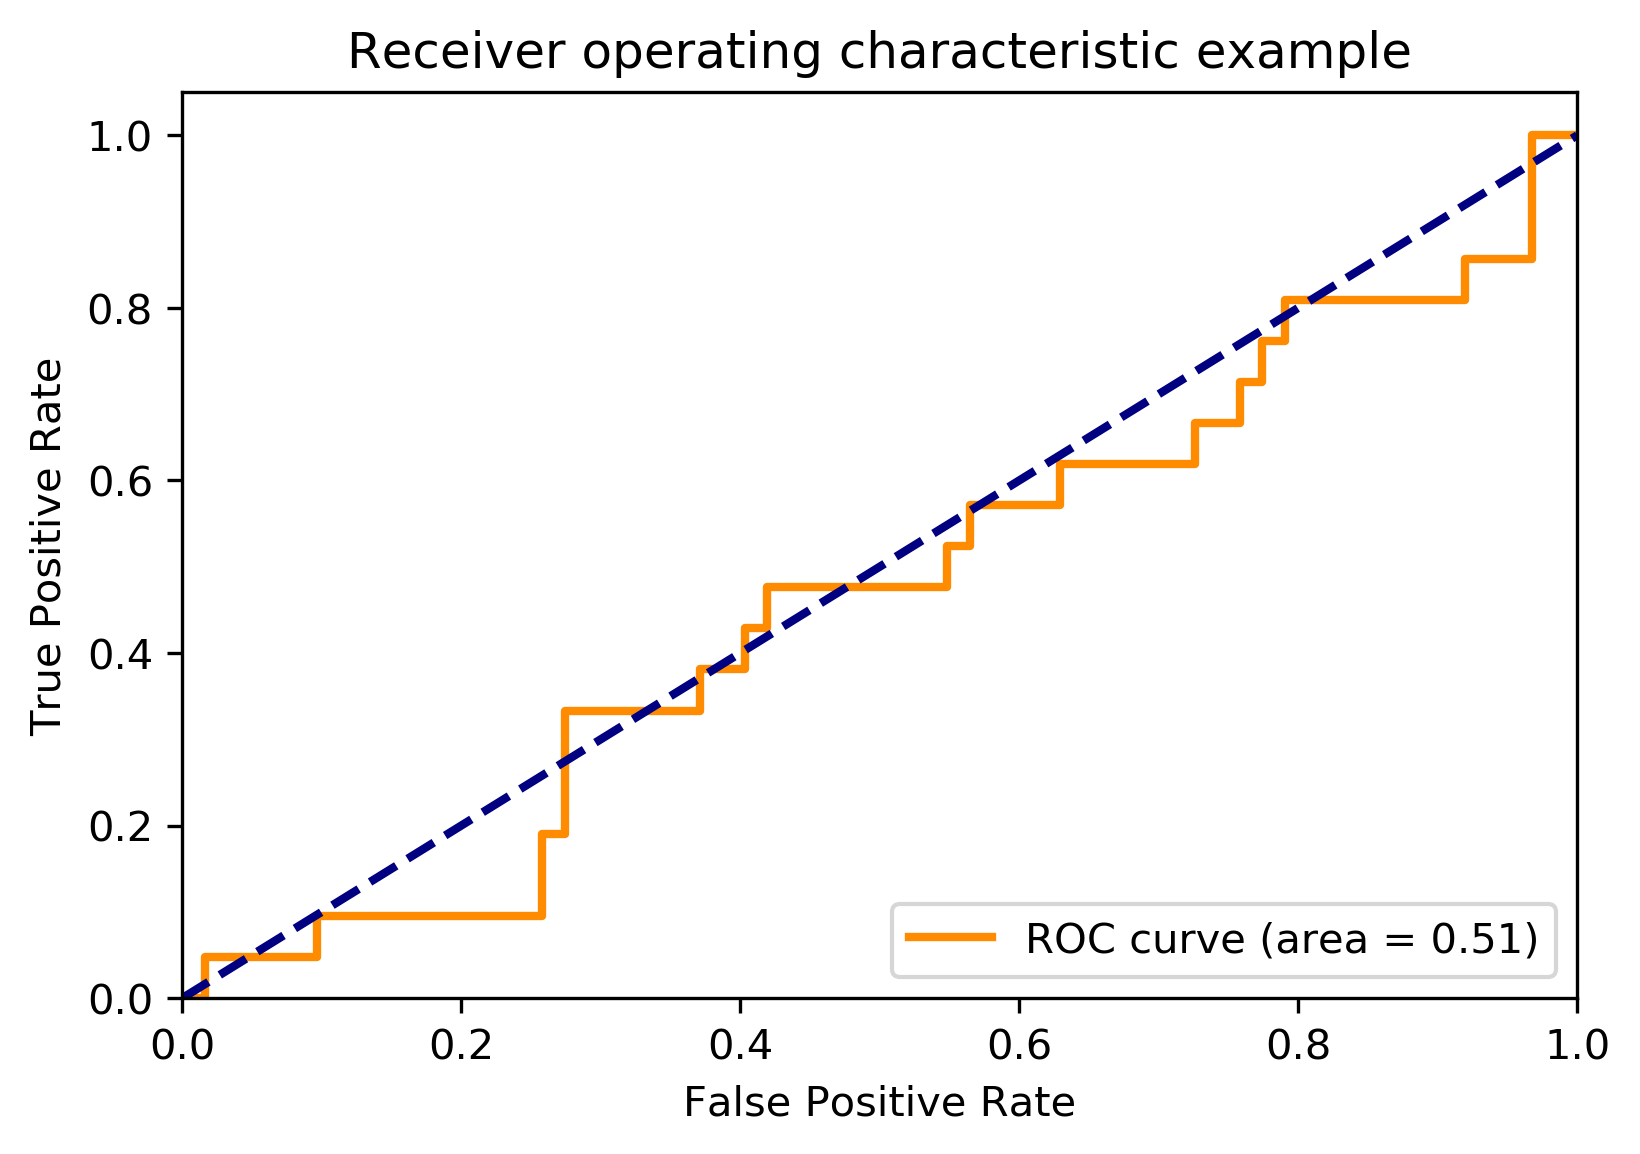

In [243]:
plotROC(fpr_RF_DILI5, tpr_RF_DILI5, roc_auc_score(B_test.iloc[:,2], y_rF_DILI5[:,0]))

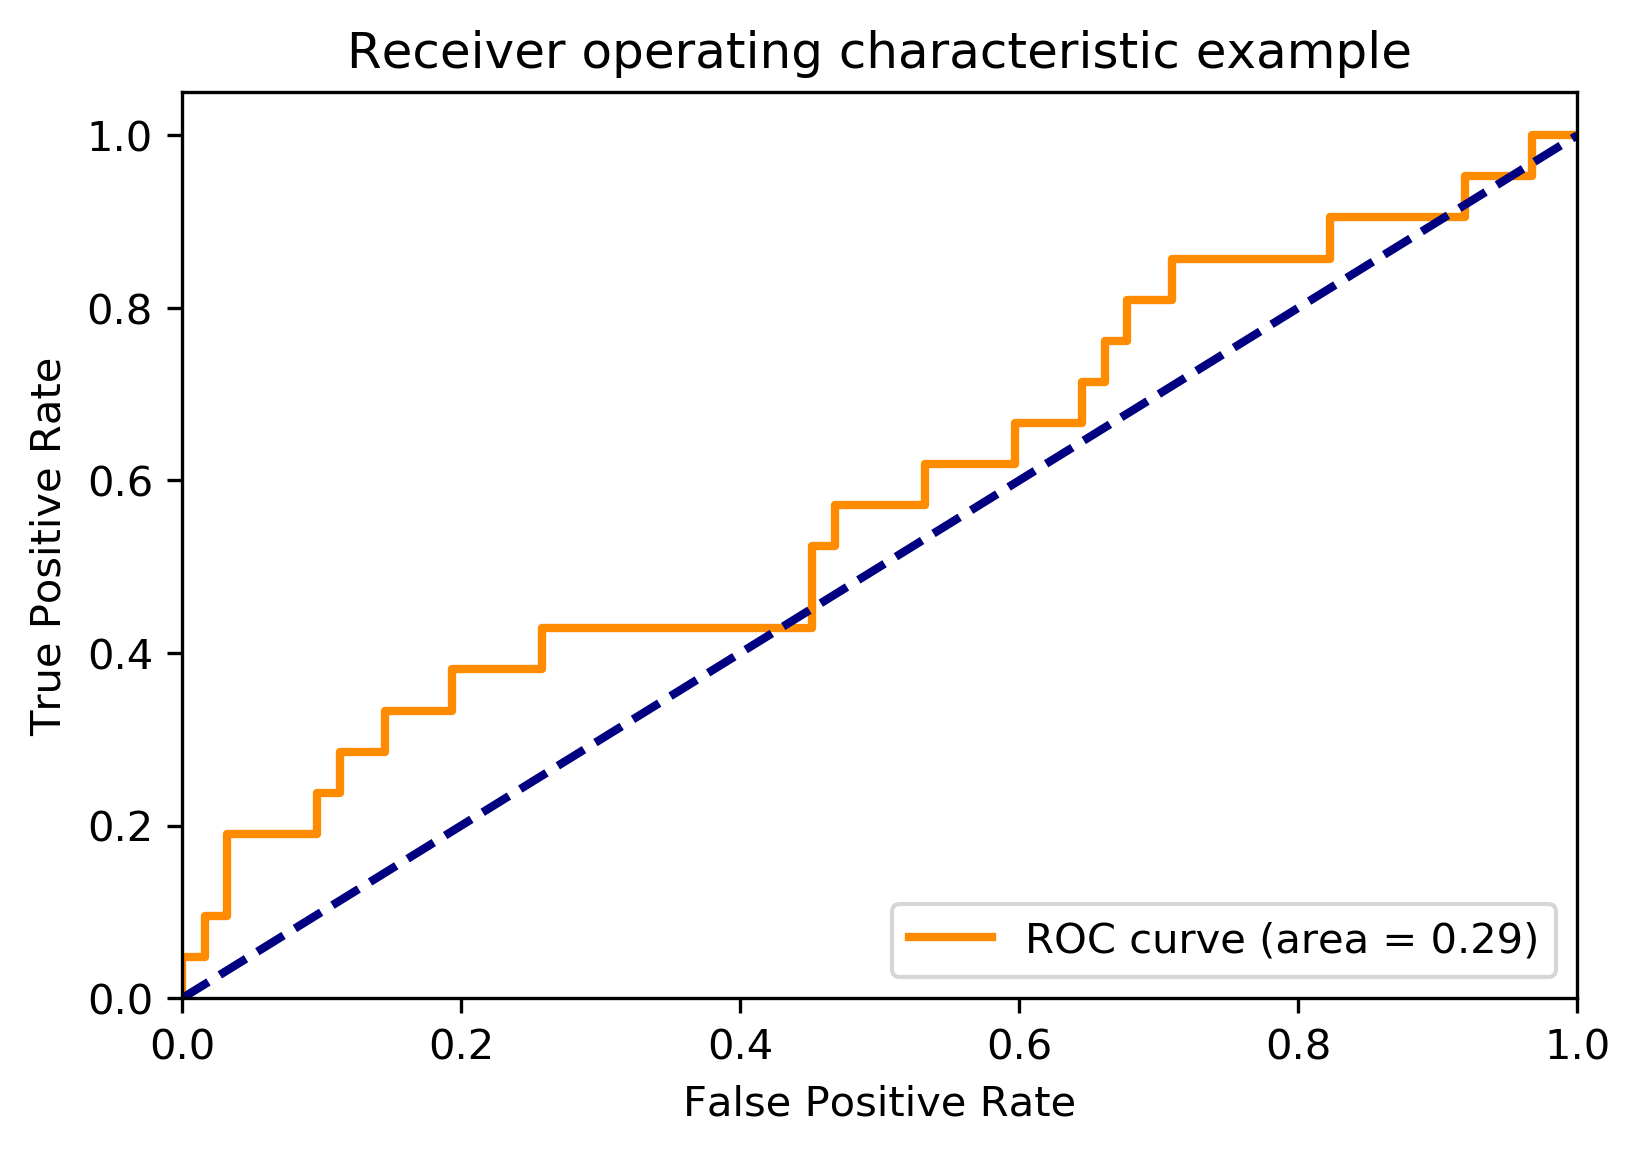

In [244]:
plotROC(fpr_RF_DILI6, tpr_RF_DILI6, roc_auc_score(B_test.iloc[:,3], y_rF_DILI6[:,0]))

#### Plot Confusion Matrices

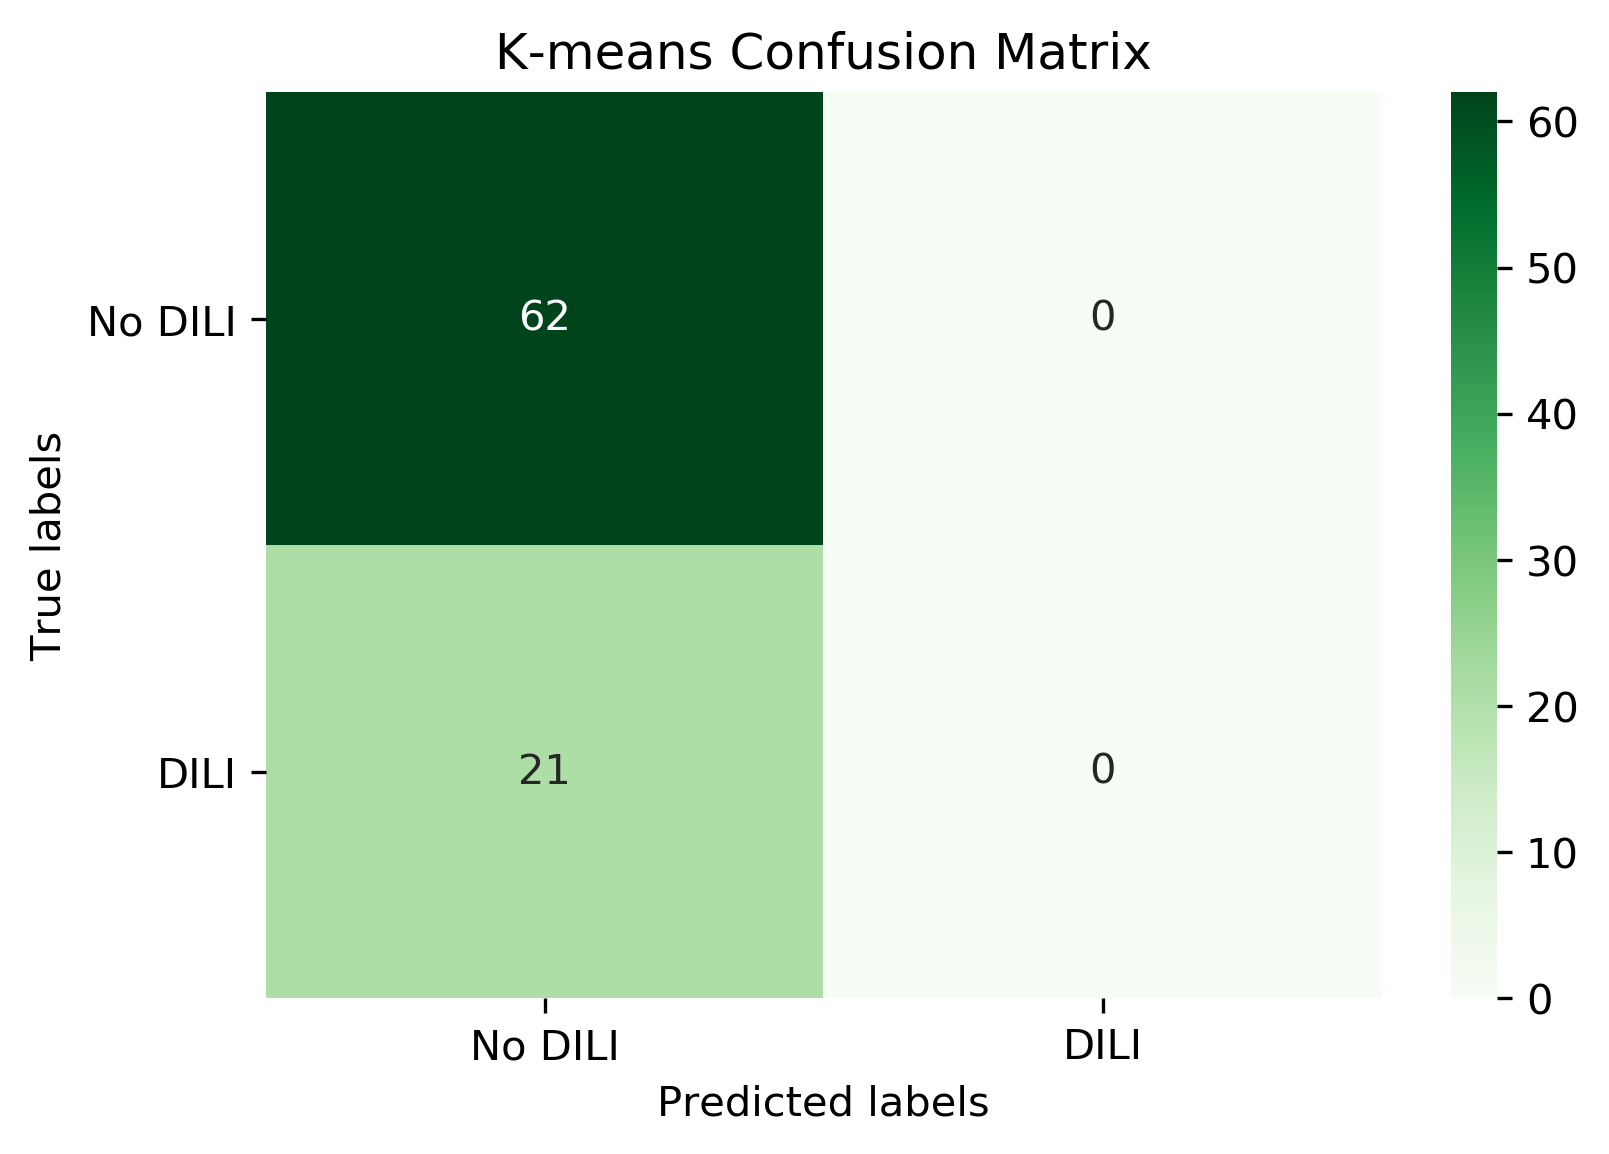

In [245]:
cM(B_test.iloc[:,0], p_rF_DILI1)

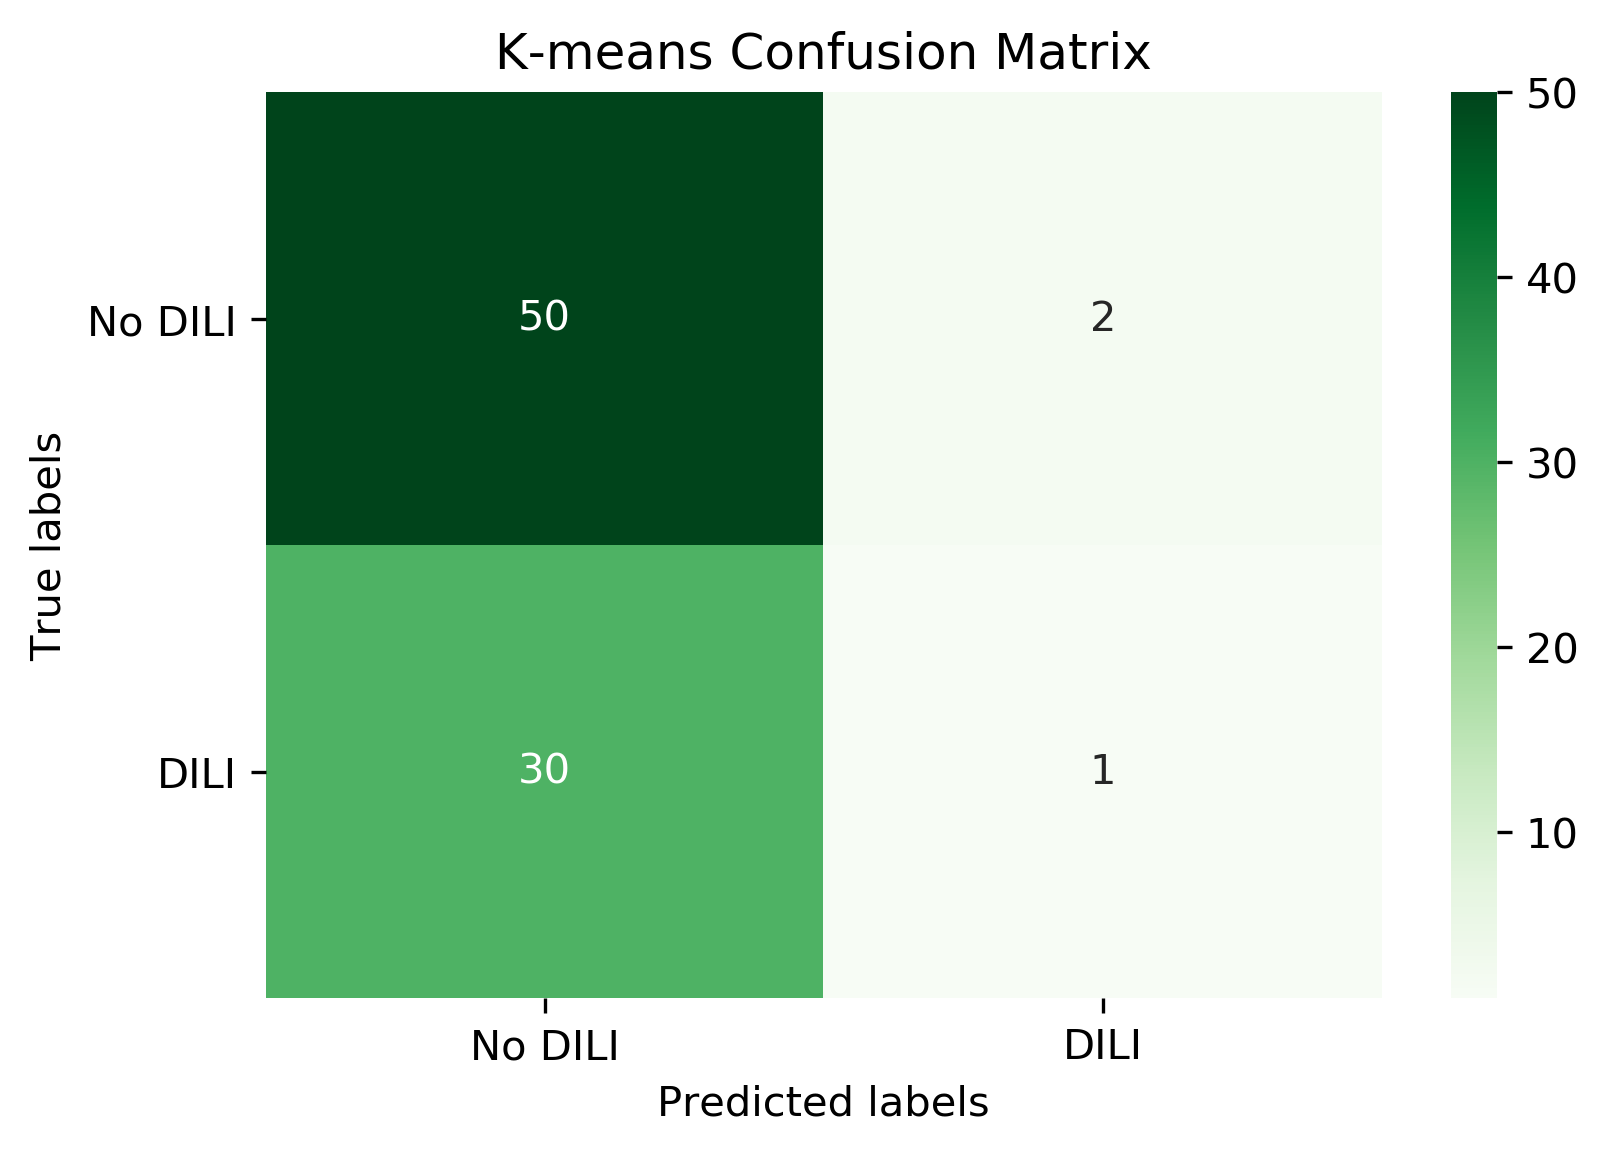

In [246]:
cM(B_test.iloc[:,1], p_rF_DILI3)

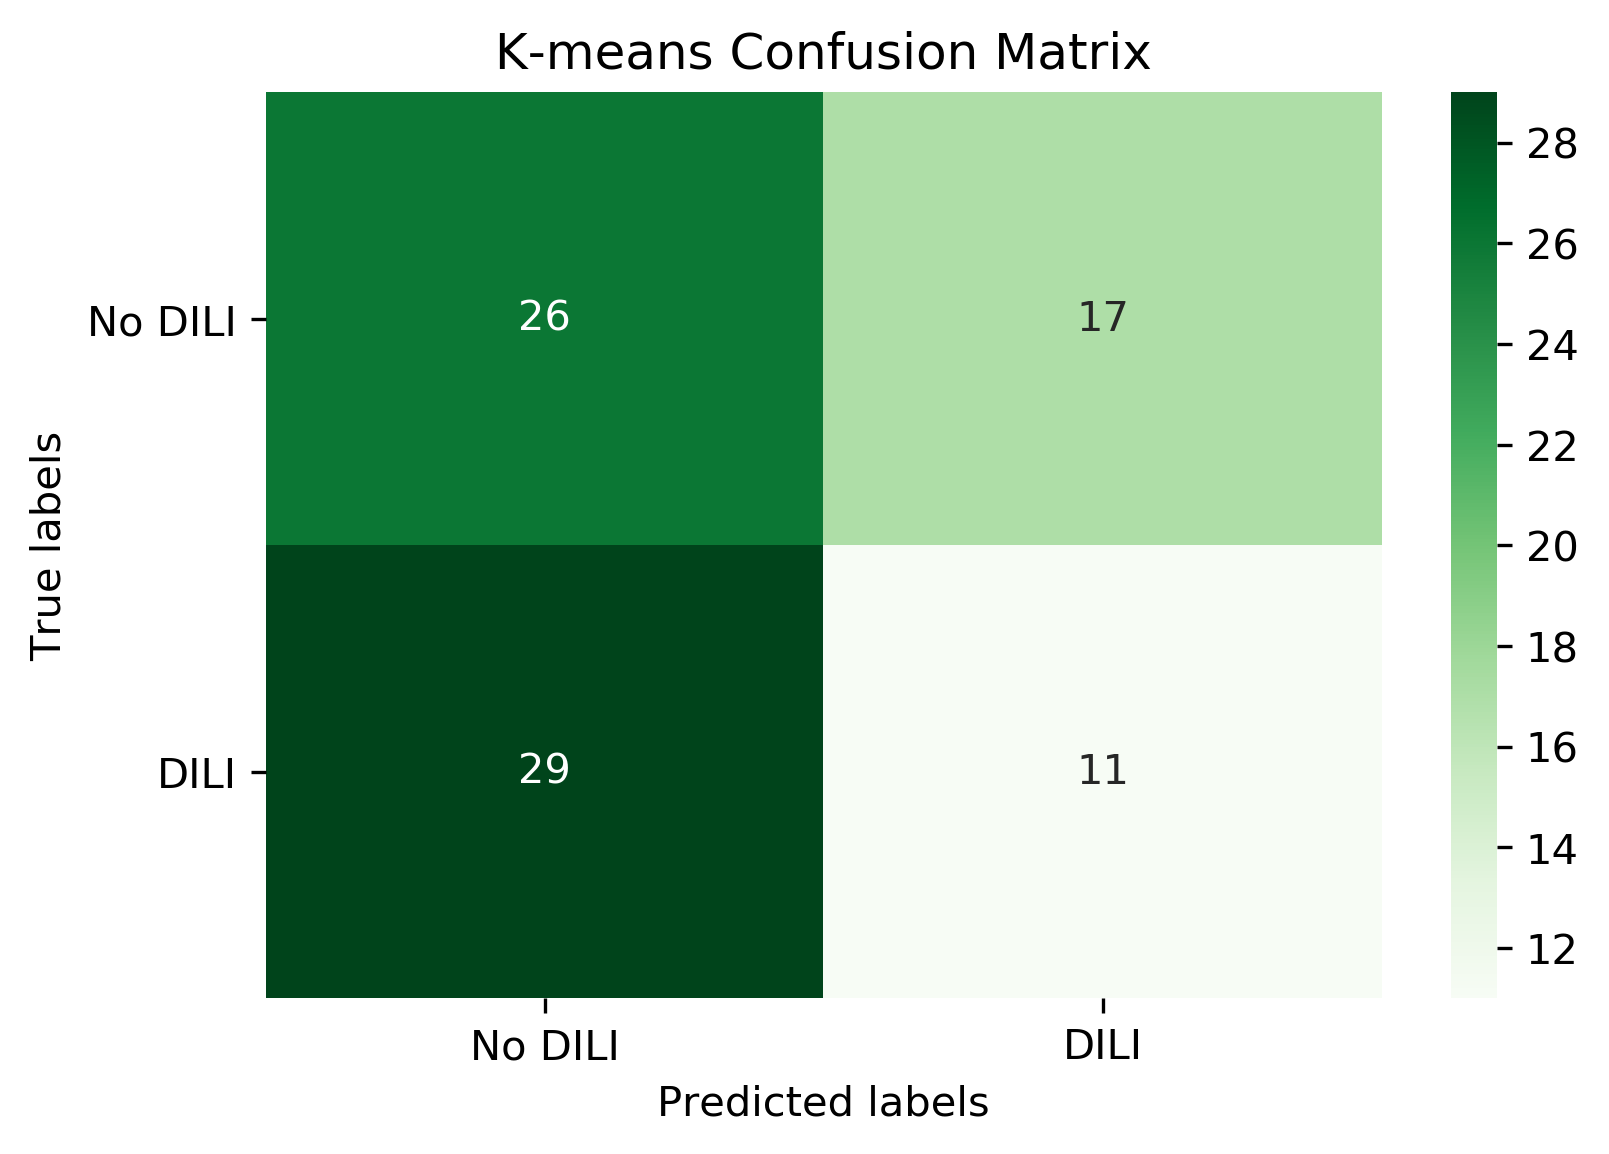

In [247]:
cM(B_test.iloc[:,2], p_rF_DILI5)

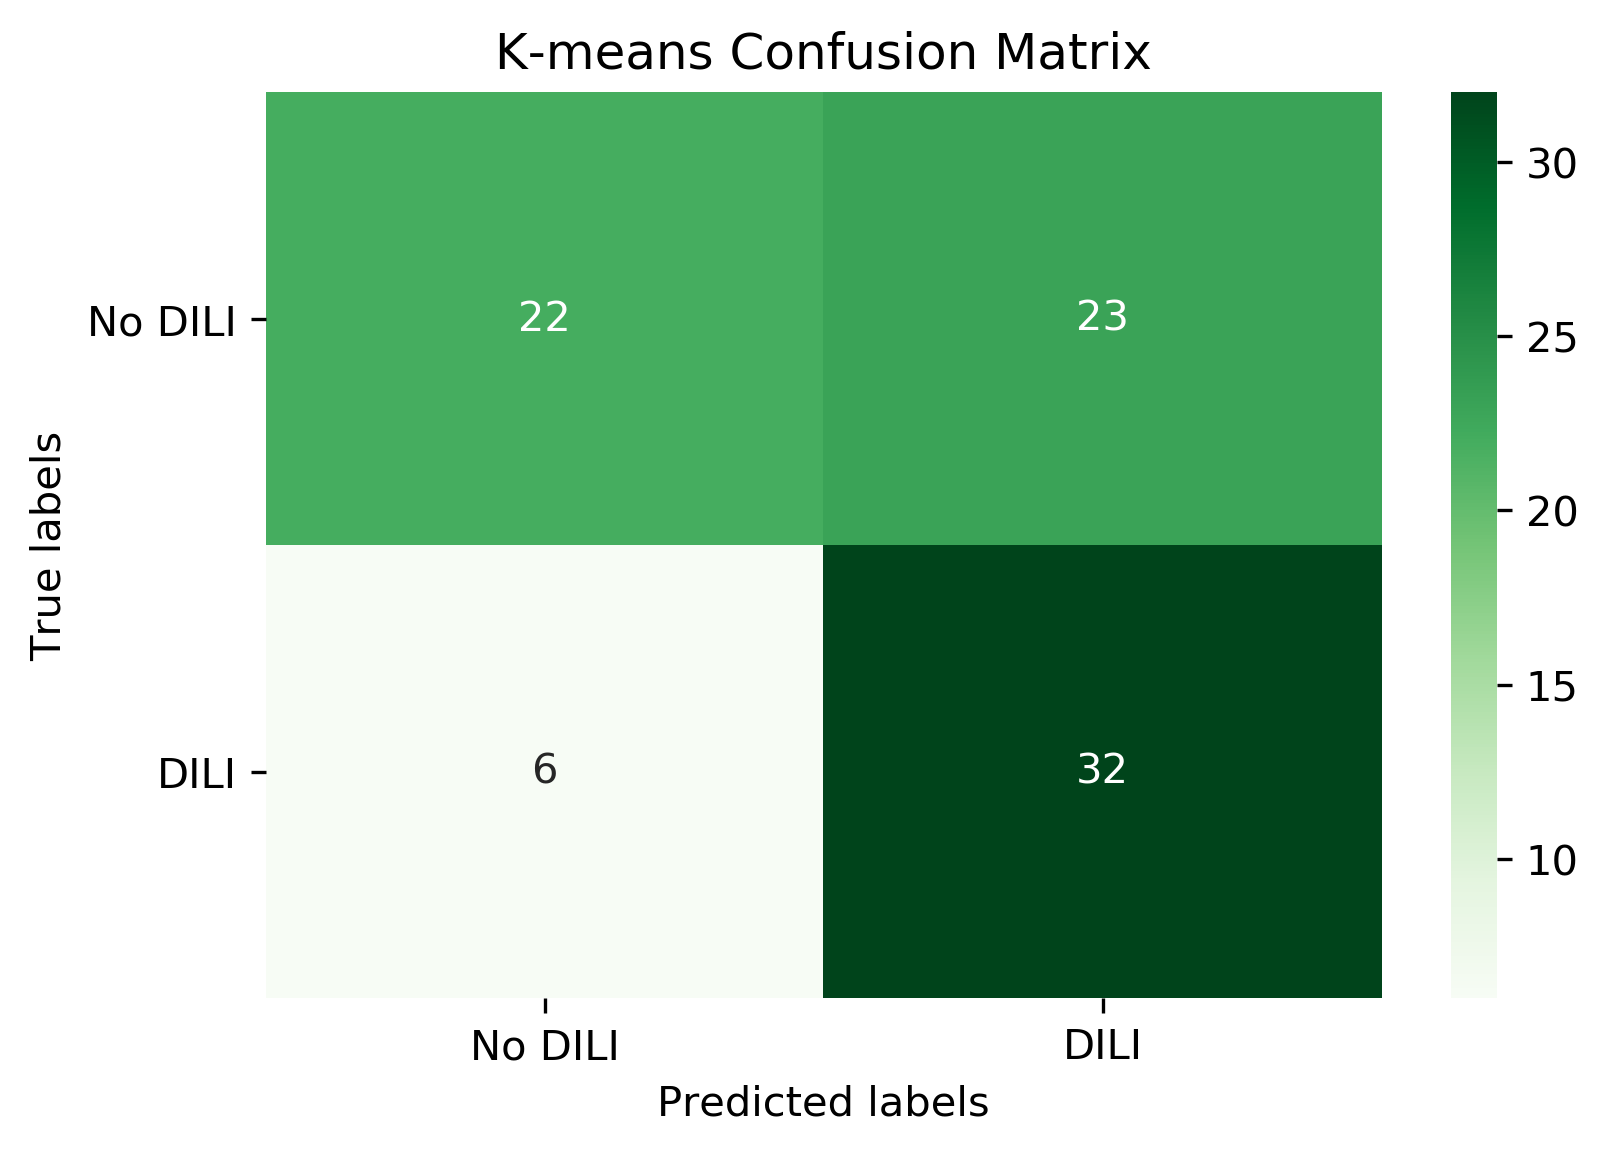

In [248]:
cM(B_test.iloc[:,3], p_rF_DILI6)

## Support Vector Machine

#### Hyperparemeter Tuning
Used rSearch, because gSearch took too long

In [93]:
grid_params_SVM = {
        'C': [0.001,0.01,0.1,1,10,100,1000],
        'gamma': ['scale', 'auto']
}

SVM_result_DILI1 = rSearch(grid_params_SVM, svm.SVC(), A_train, B_train['DILI1'])
SVM_result_DILI3 = rSearch(grid_params_SVM, svm.SVC(), A_train, B_train['DILI3'])
SVM_result_DILI5 = rSearch(grid_params_SVM, svm.SVC(), A_train, B_train['DILI5'])
SVM_result_DILI6 = rSearch(grid_params_SVM, svm.SVC(), A_train, B_train['DILI6'])

print("DILI1")
print("Best Score: ", SVM_result_DILI1.best_score_)
print("Best Estimator: ", SVM_result_DILI1.best_estimator_)
print("Best Params: ", SVM_result_DILI1.best_params_)

print("DILI3")
print("Best Score: ", SVM_result_DILI3.best_score_)
print("Best Estimator: ", SVM_result_DILI3.best_estimator_)
print("Best Params: ", SVM_result_DILI3.best_params_)

print("DILI5")
print("Best Score: ", SVM_result_DILI5.best_score_)
print("Best Estimator: ", SVM_result_DILI5.best_estimator_)
print("Best Params: ", SVM_result_DILI5.best_params_)

print("DILI6")
print("Best Score: ", SVM_result_DILI6.best_score_)
print("Best Estimator: ", SVM_result_DILI6.best_estimator_)
print("Best Params: ", SVM_result_DILI6.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  9.2min finished


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 16.9min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 32.7min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  9.9min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


DILI1
Best Score:  0.7831325301204819
Best Estimator:  SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Best Params:  {'gamma': 'auto', 'C': 0.01}
DILI3
Best Score:  0.6265060240963856
Best Estimator:  SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Best Params:  {'gamma': 'scale', 'C': 1}
DILI5
Best Score:  0.5421686746987951
Best Estimator:  SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Best Params:  {'gamma': 'scale', 'C': 10}
DILI6
Best Score:  0.5993975903614

In [94]:
#Support Vector Machine
def sVM(X_train, X_test, y_train, c, g) :
    SVM = svm.SVC(probability = 1, C = c, gamma = g) #Set probability to 1 (TRUE) so that we can use predict_proba

    #Train
    SVM.fit(X_train,y_train)
    score = SVM.score(X_train, y_train)

    #Test
    predictions = SVM.predict(X_test)
    y_prob = SVM.predict_proba(X_test)

    #10-Fold Cross Validation
    cross_Val = crossVal(SVM, X_train, y_train, 10)
    
    return(predictions, y_prob, score, cross_Val)

In [96]:
p_sVM_DILI1, y_sVM_DILI1, s_sVM_DILI1, cv_sVM_DILI1 = sVM(A_train, #Training Set
                                                          A_test, #Test Set
                                                          B_train['DILI1'], #Training labels
                                                          0.01, #C
                                                          'scale' #gamma
                                                         )
p_sVM_DILI3, y_sVM_DILI3, s_sVM_DILI3, cv_sVM_DILI3 = sVM(A_train, 
                                                          A_test, 
                                                          B_train['DILI3'],
                                                          1,
                                                          'auto'
                                                         )
p_sVM_DILI5, y_sVM_DILI5, s_sVM_DILI5, cv_sVM_DILI5 = sVM(A_train,
                                                          A_test,
                                                          B_train['DILI5'],
                                                          100,
                                                          'scale'
                                                         )
p_sVM_DILI6, y_sVM_DILI6, s_sVM_DILI6, cv_sVM_DILI6 = sVM(A_train, 
                                                          A_test,
                                                          B_train['DILI6'],
                                                          100,
                                                          'scale'
                                                         )

Cross Validation result:  0.7829768270944741 number of kFold splits:  10
Cross Validation result:  0.6233511586452763 number of kFold splits:  10
Cross Validation result:  0.5275401069518716 number of kFold splits:  10
Cross Validation result:  0.5903743315508022 number of kFold splits:  10


#### Calculate Accuracy 

In [97]:
print('Support Vector Machine accuracy (DILI1): ', round(accuracy_score(B_test.iloc[:,0], p_sVM_DILI1), 3))
print('Support Vector Machine accuracy (DILI3): ', round(accuracy_score(B_test.iloc[:,1], p_sVM_DILI3), 3))
print('Support Vector Machine accuracy (DILI5): ', round(accuracy_score(B_test.iloc[:,2], p_sVM_DILI5), 3))
print('Support Vector Machine accuracy (DILI6): ', round(accuracy_score(B_test.iloc[:,3], p_sVM_DILI6), 3))

Support Vector Machine accuracy (DILI1):  0.747
Support Vector Machine accuracy (DILI3):  0.627
Support Vector Machine accuracy (DILI5):  0.41
Support Vector Machine accuracy (DILI6):  0.627


#### Calculate Balanced Accuracy 

In [98]:
print('Support Vector Machine balanced accuracy (DILI1): ', round(balanced_accuracy_score(B_test.iloc[:,0], p_sVM_DILI1), 3))
print('Support Vector Machine balanced accuracy (DILI3): ', round(balanced_accuracy_score(B_test.iloc[:,1], p_sVM_DILI3), 3))
print('Support Vector Machine balanced accuracy (DILI5): ', round(balanced_accuracy_score(B_test.iloc[:,2], p_sVM_DILI5), 3))
print('Support Vector Machine balanced accuracy (DILI6): ', round(balanced_accuracy_score(B_test.iloc[:,3], p_sVM_DILI6), 3))

Support Vector Machine balanced accuracy (DILI1):  0.5
Support Vector Machine balanced accuracy (DILI3):  0.5
Support Vector Machine balanced accuracy (DILI5):  0.405
Support Vector Machine balanced accuracy (DILI6):  0.633


#### Calculate Precision Score 

In [99]:
print('SVM precision (DILI1): ', round(precision_score(B_test.iloc[:,0], p_sVM_DILI1), 3))
print('SVM precision (DILI3): ', round(precision_score(B_test.iloc[:,1], p_sVM_DILI3), 3))
print('SVM precision (DILI5): ', round(precision_score(B_test.iloc[:,2], p_sVM_DILI5), 3))
print('SVM precision (DILI6): ', round(precision_score(B_test.iloc[:,3], p_sVM_DILI6), 3))


SVM precision (DILI1):  0.0
SVM precision (DILI3):  0.0
SVM precision (DILI5):  0.355
SVM precision (DILI6):  0.574


/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Calculate F1 Score

In [322]:
print('SVM F1 Score (DILI1): ', round(f1_score(B_test.iloc[:,0], p_sVM_DILI1), 3))
print('SVM F1 Score (DILI3): ', round(f1_score(B_test.iloc[:,1], p_sVM_DILI3), 3))
print('SVM F1 Score (DILI5): ', round(f1_score(B_test.iloc[:,2], p_sVM_DILI5), 3))
print('SVM F1 Score (DILI6): ', round(f1_score(B_test.iloc[:,3], p_sVM_DILI6), 3))


SVM F1 Score (DILI1):  0.0
SVM F1 Score (DILI3):  0.0
SVM F1 Score (DILI5):  0.31
SVM F1 Score (DILI6):  0.635


#### Calculate ROC AUC Score 

In [100]:
print('SVM ROC AUC Score (DILI1): ', round(roc_auc_score(B_test.iloc[:,0], y_sVM_DILI1[:,0]), 3))
print('SVM ROC AUC Score (DILI3): ', round(roc_auc_score(B_test.iloc[:,1], y_sVM_DILI3[:,0]), 3))
print('SVM ROC AUC Score (DILI5): ', round(roc_auc_score(B_test.iloc[:,2], y_sVM_DILI5[:,0]), 3))
print('SVM ROC AUC Score (DILI6): ', round(roc_auc_score(B_test.iloc[:,3], y_sVM_DILI6[:,0]), 3))


SVM ROC AUC Score (DILI1):  0.541
SVM ROC AUC Score (DILI3):  0.469
SVM ROC AUC Score (DILI5):  0.582
SVM ROC AUC Score (DILI6):  0.267


#### Calculate FPR and TPR, and plot ROC curve

In [101]:
fpr_SVM_DILI1, tpr_SVM_DILI1, _ = roc_curve(B_test.iloc[:,0], y_sVM_DILI1[:,0])
fpr_SVM_DILI3, tpr_SVM_DILI3, _ = roc_curve(B_test.iloc[:,0], y_sVM_DILI3[:,0])
fpr_SVM_DILI5, tpr_SVM_DILI5, _ = roc_curve(B_test.iloc[:,0], y_sVM_DILI5[:,0])
fpr_SVM_DILI6, tpr_SVM_DILI6, _ = roc_curve(B_test.iloc[:,0], y_sVM_DILI6[:,0])


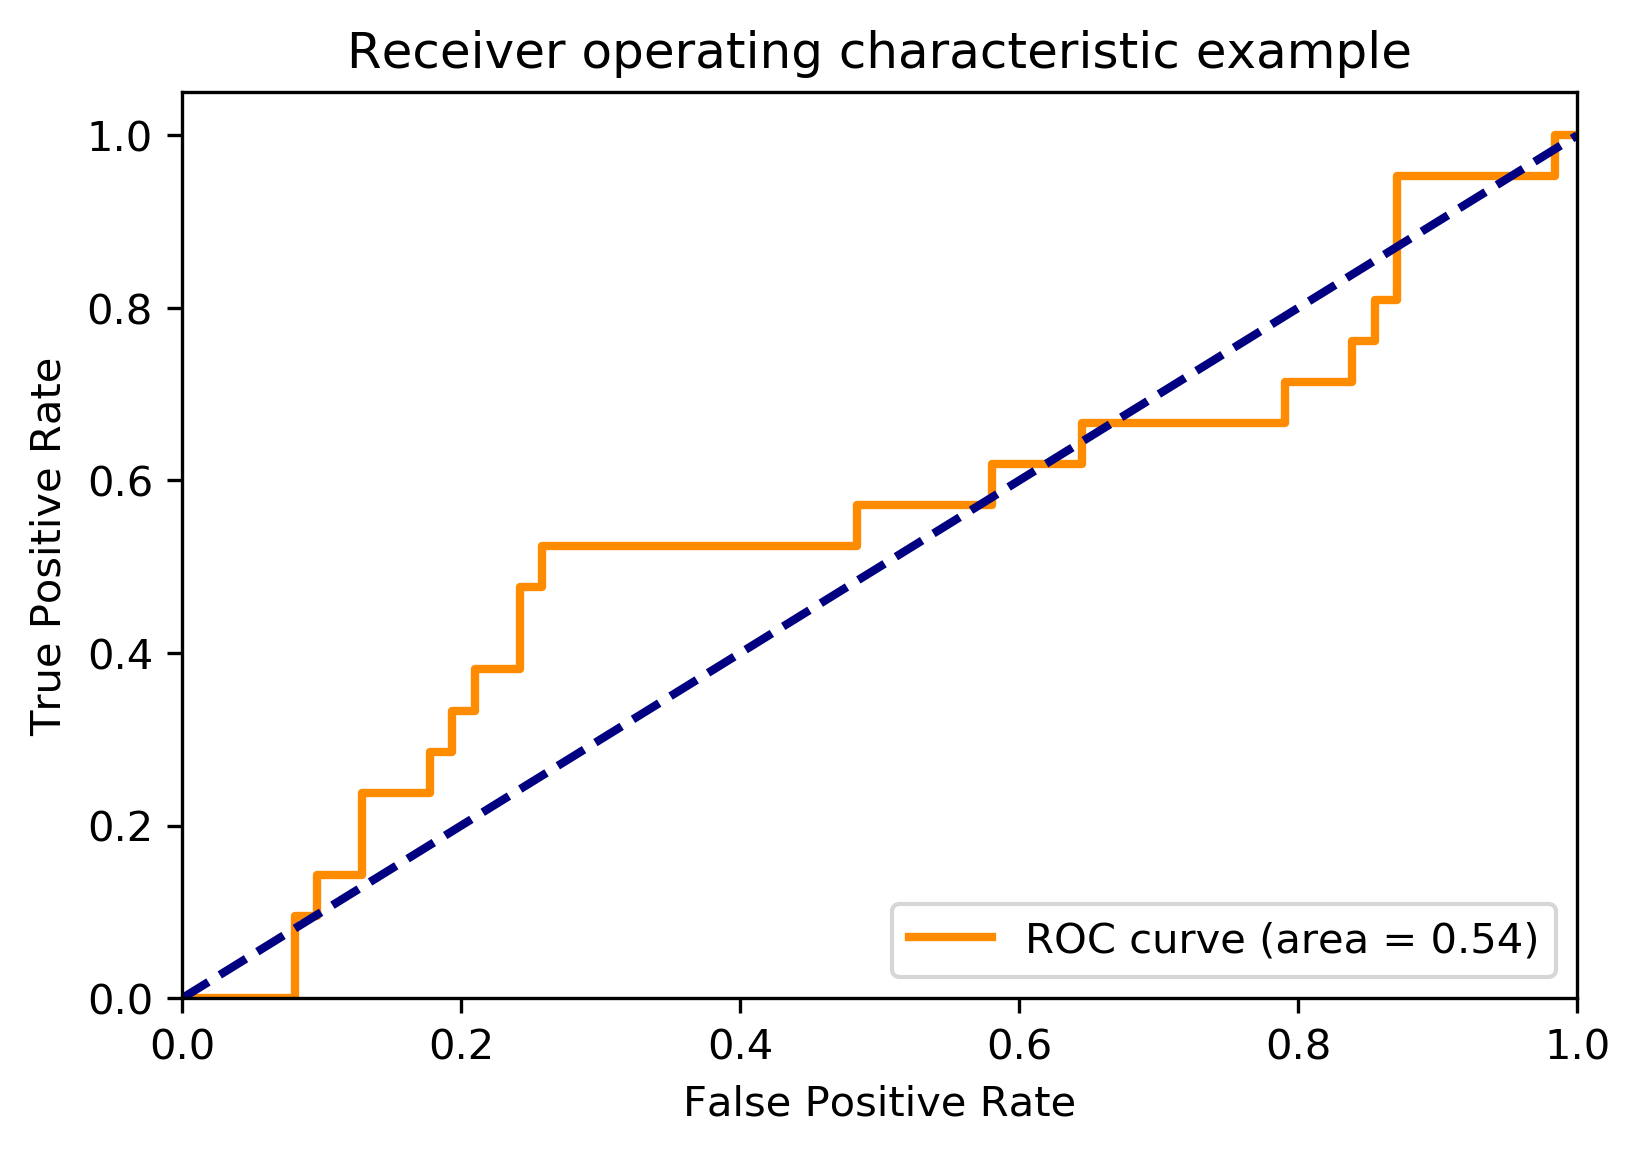

In [249]:
plotROC(fpr_SVM_DILI1, tpr_SVM_DILI1, roc_auc_score(B_test.iloc[:,0], y_sVM_DILI1[:,0]))

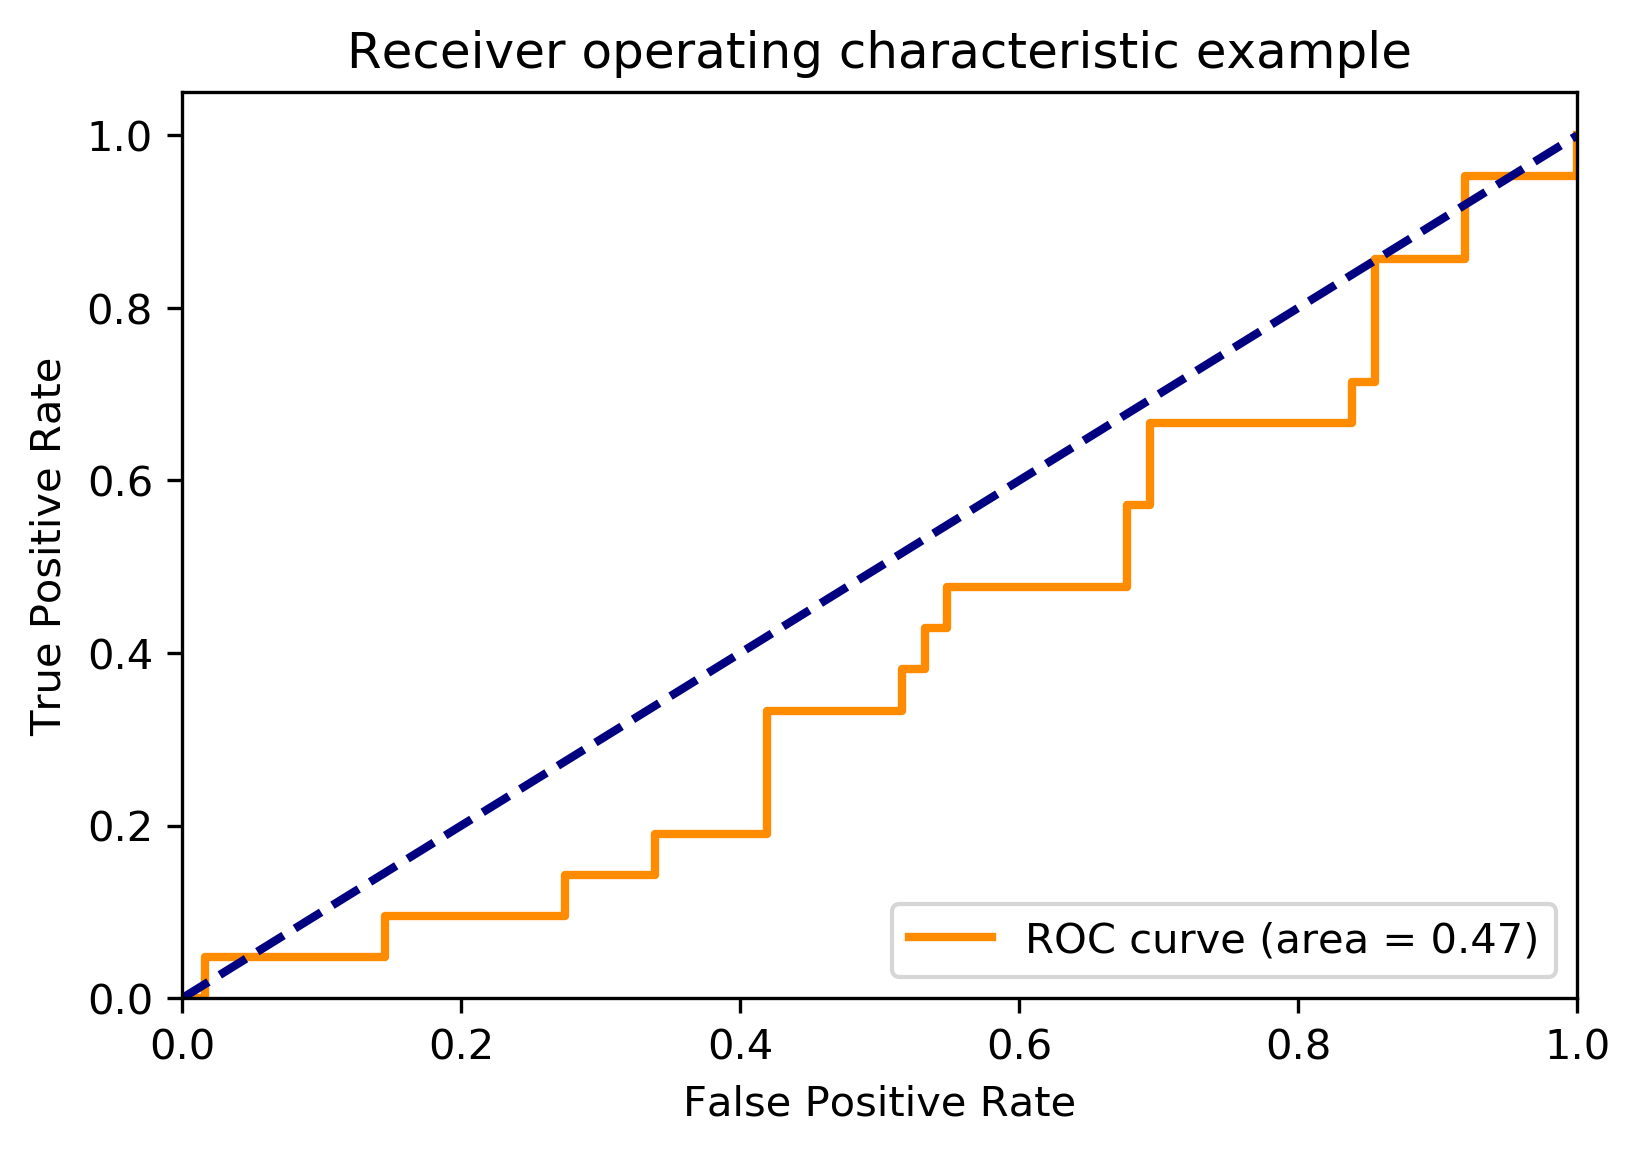

In [250]:
plotROC(fpr_SVM_DILI3, tpr_SVM_DILI3, roc_auc_score(B_test.iloc[:,1], y_sVM_DILI3[:,0]))

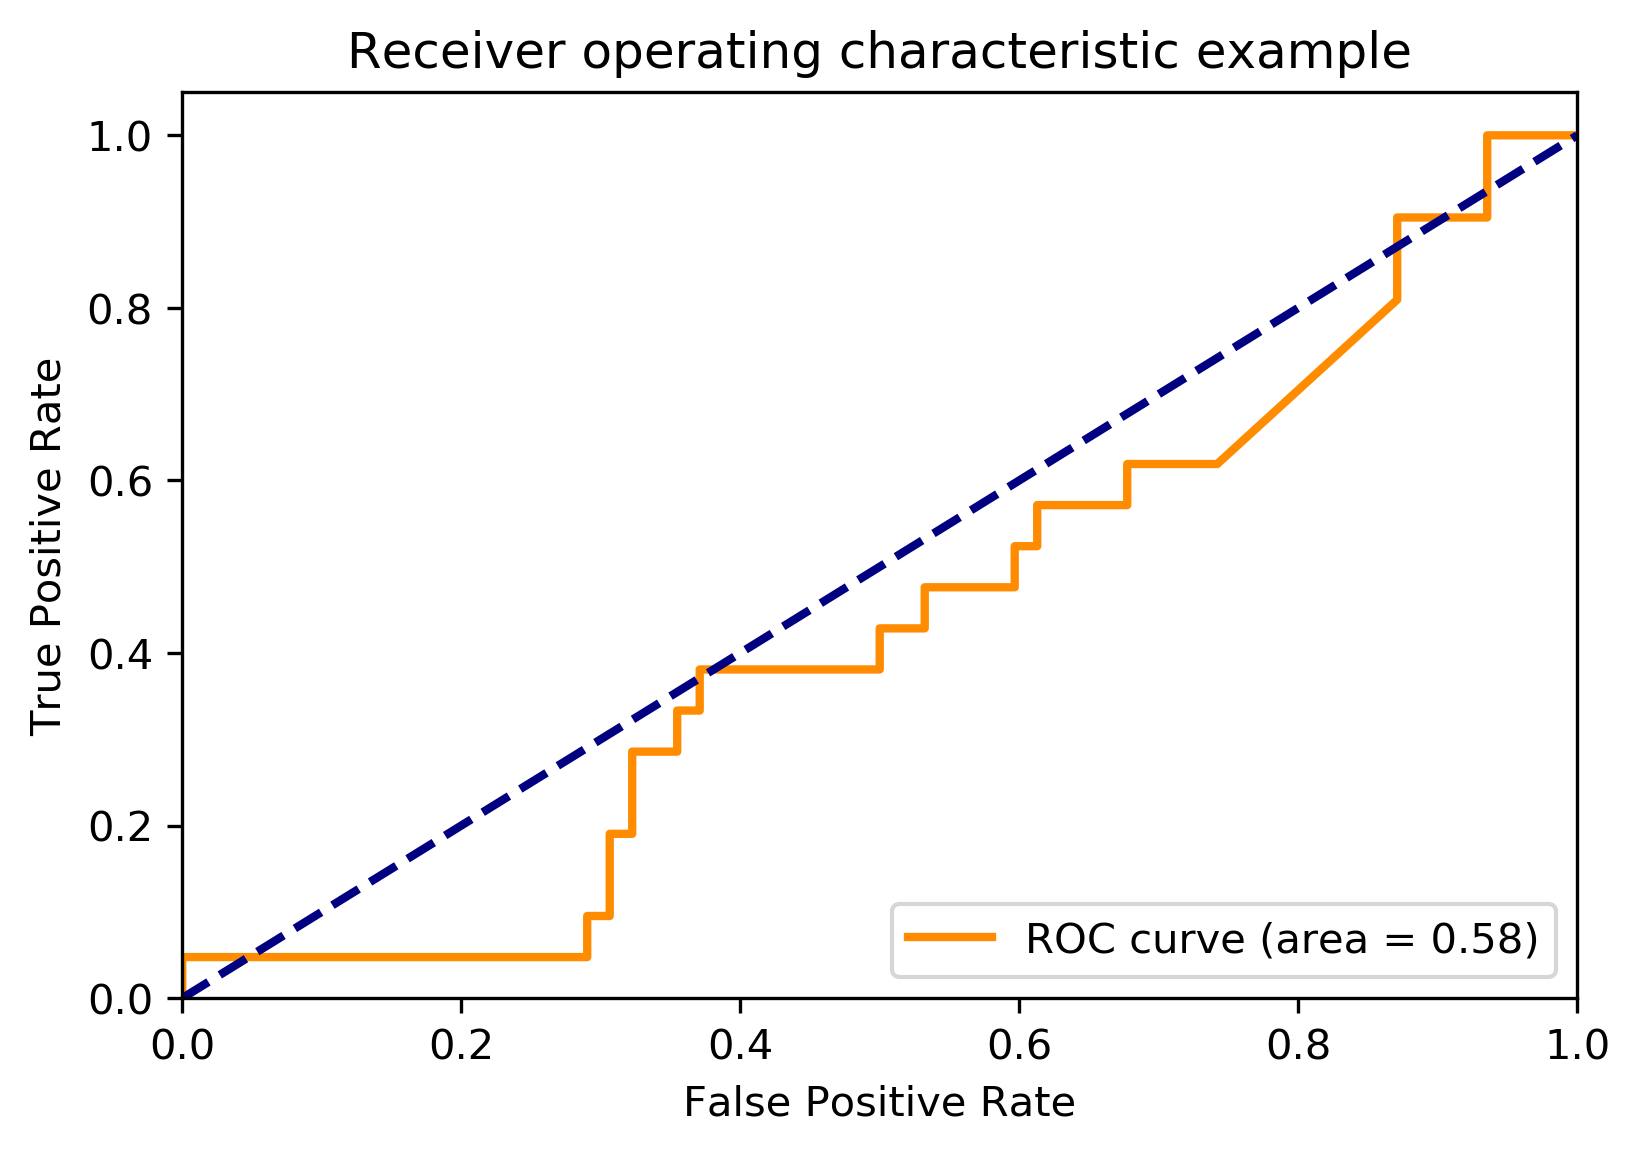

In [251]:
plotROC(fpr_SVM_DILI5, tpr_SVM_DILI5, roc_auc_score(B_test.iloc[:,2], y_sVM_DILI5[:,0]))

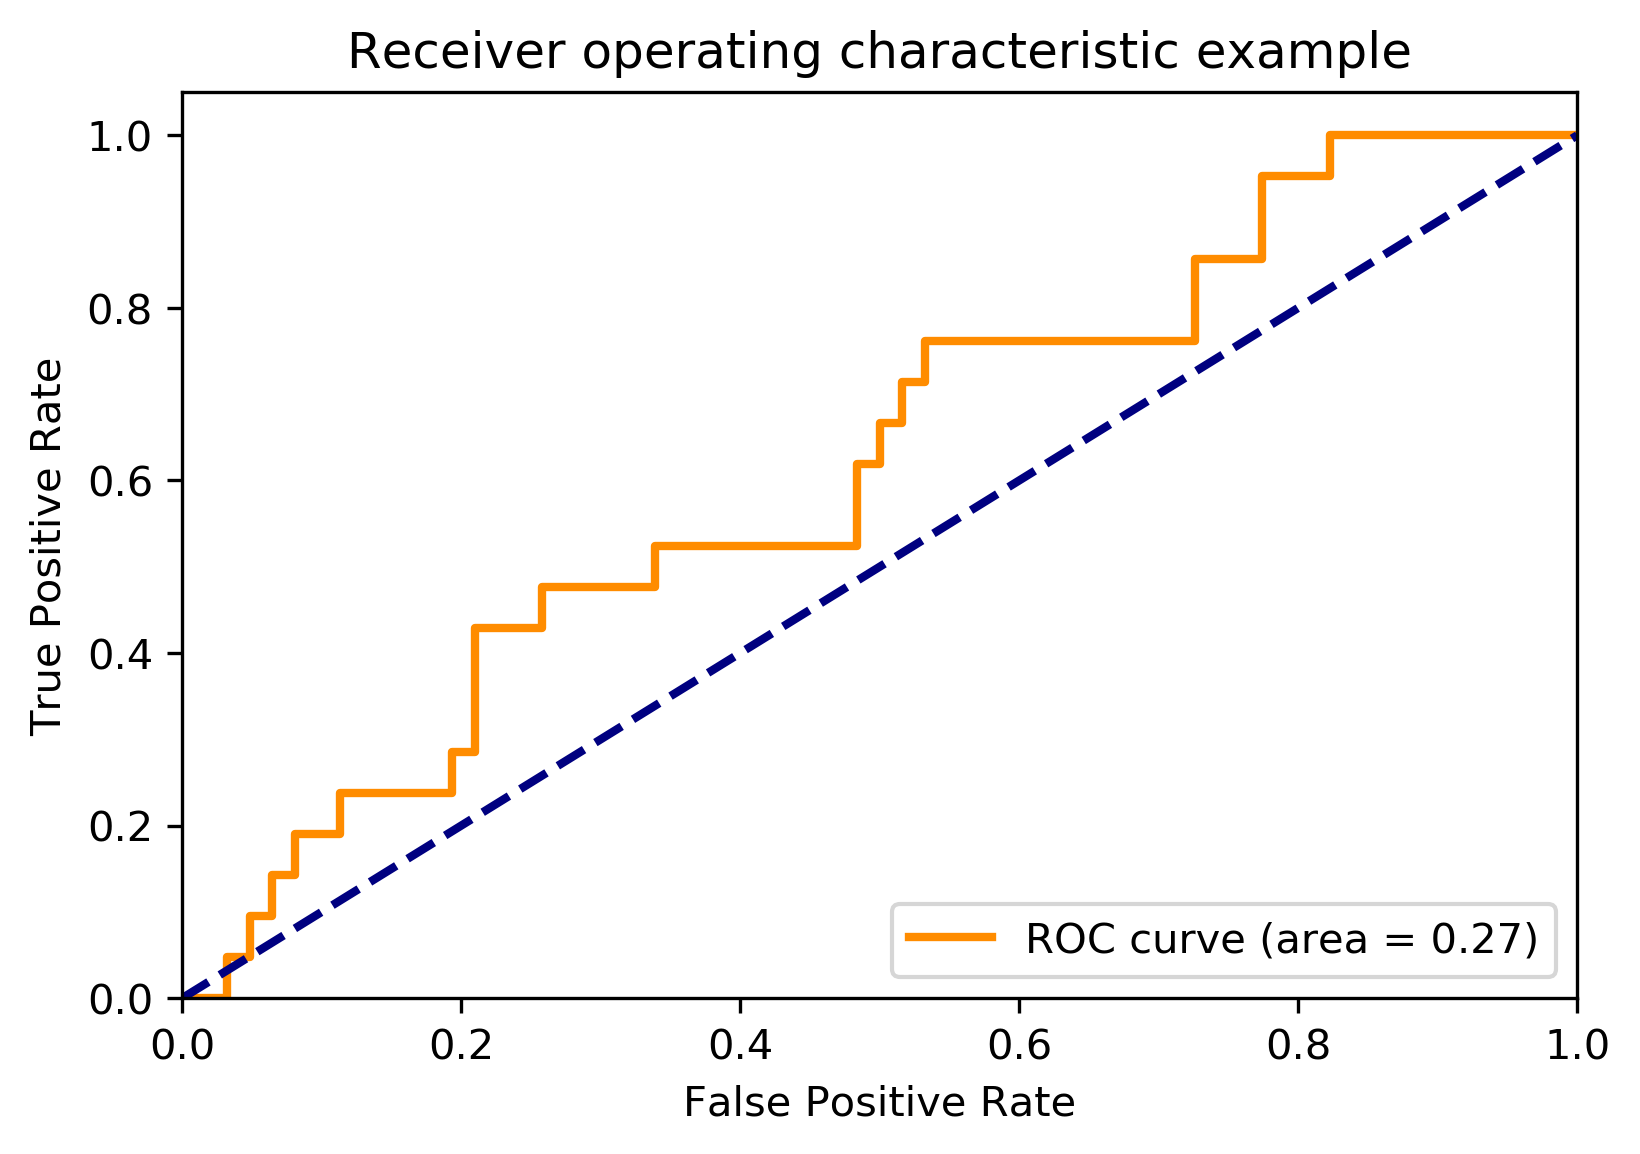

In [252]:
plotROC(fpr_SVM_DILI6, tpr_SVM_DILI6, roc_auc_score(B_test.iloc[:,3], y_sVM_DILI6[:,0]))

#### Plot Confusion Matrices

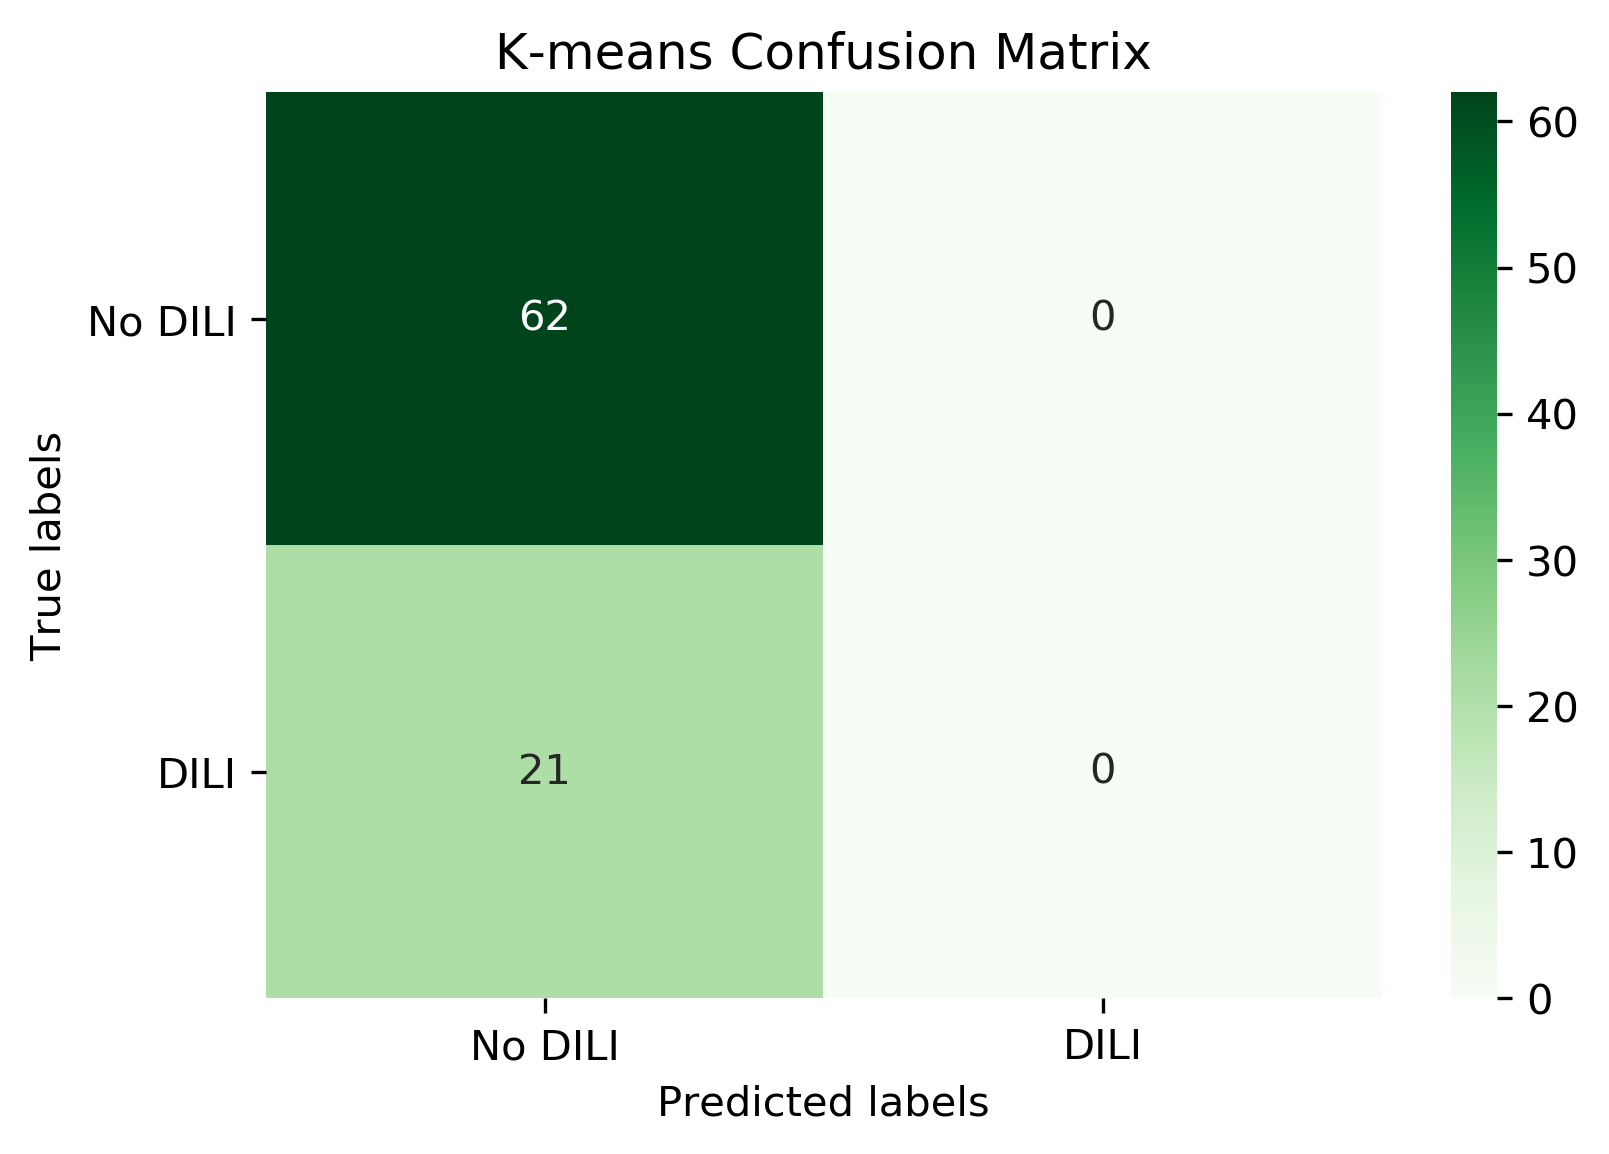

In [253]:
cM(B_test.iloc[:,0], p_sVM_DILI1)

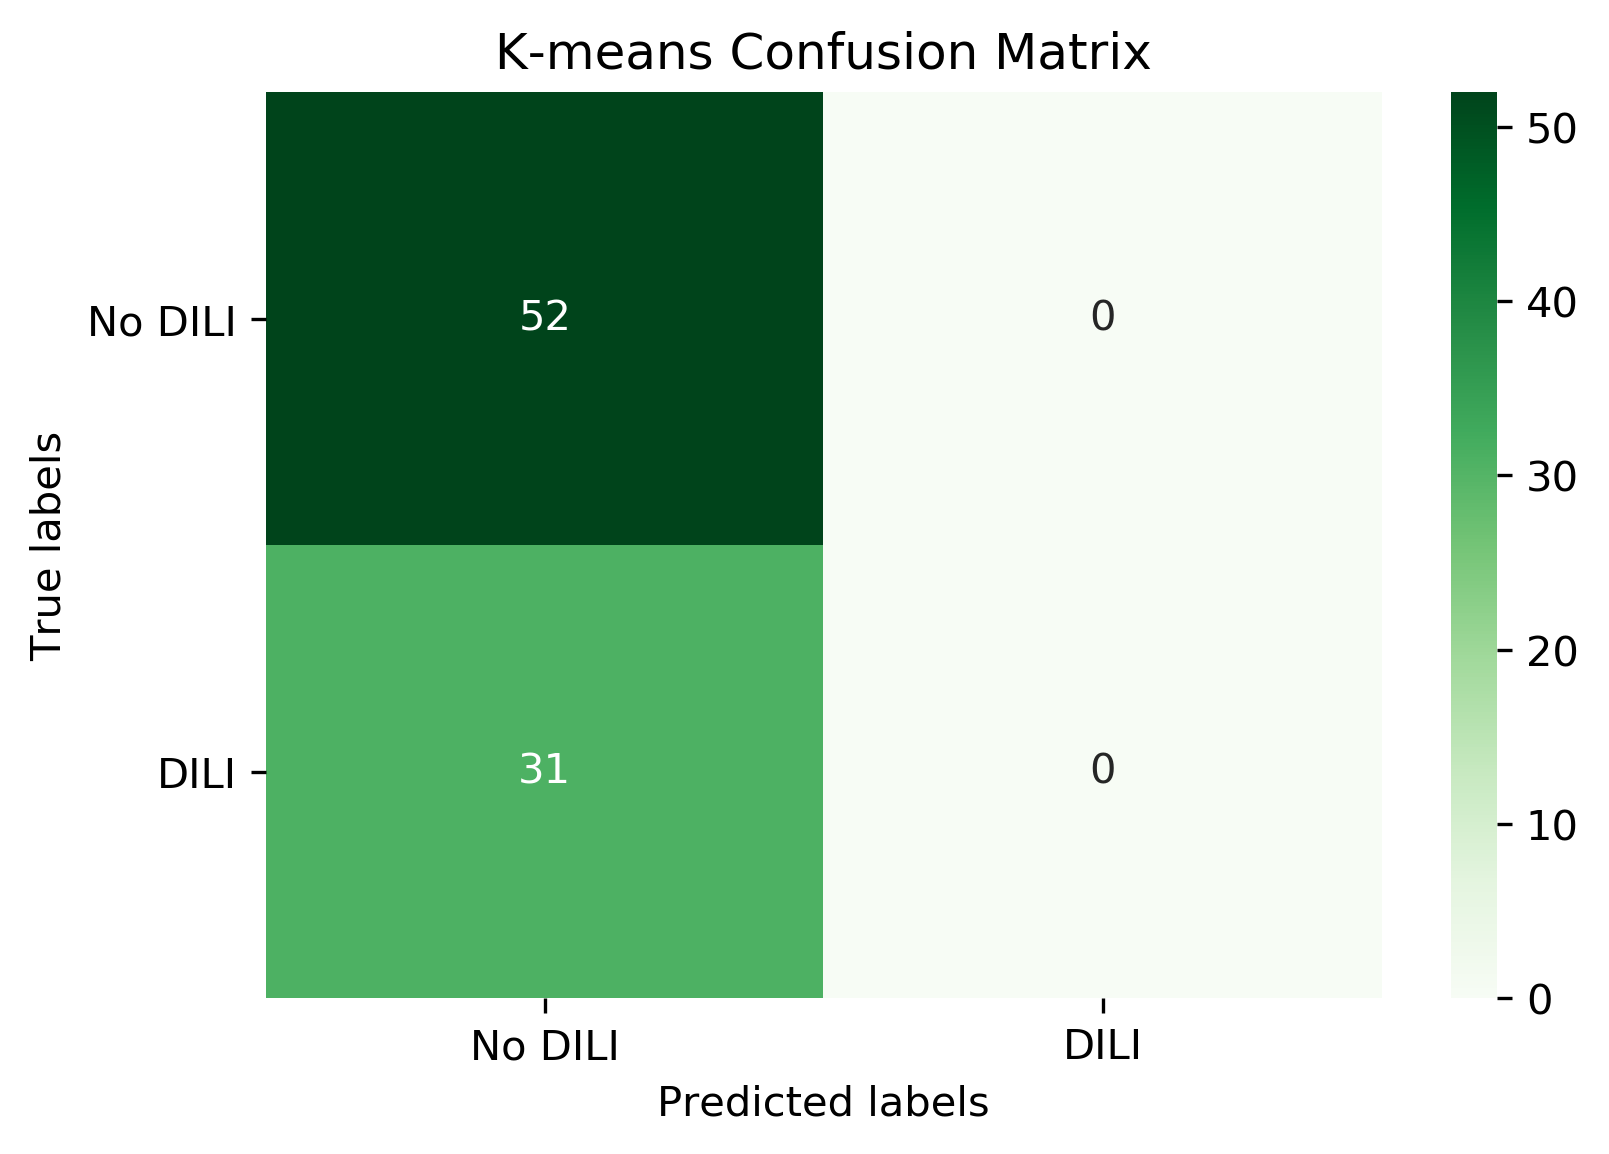

In [254]:
cM(B_test.iloc[:,1], p_sVM_DILI3)

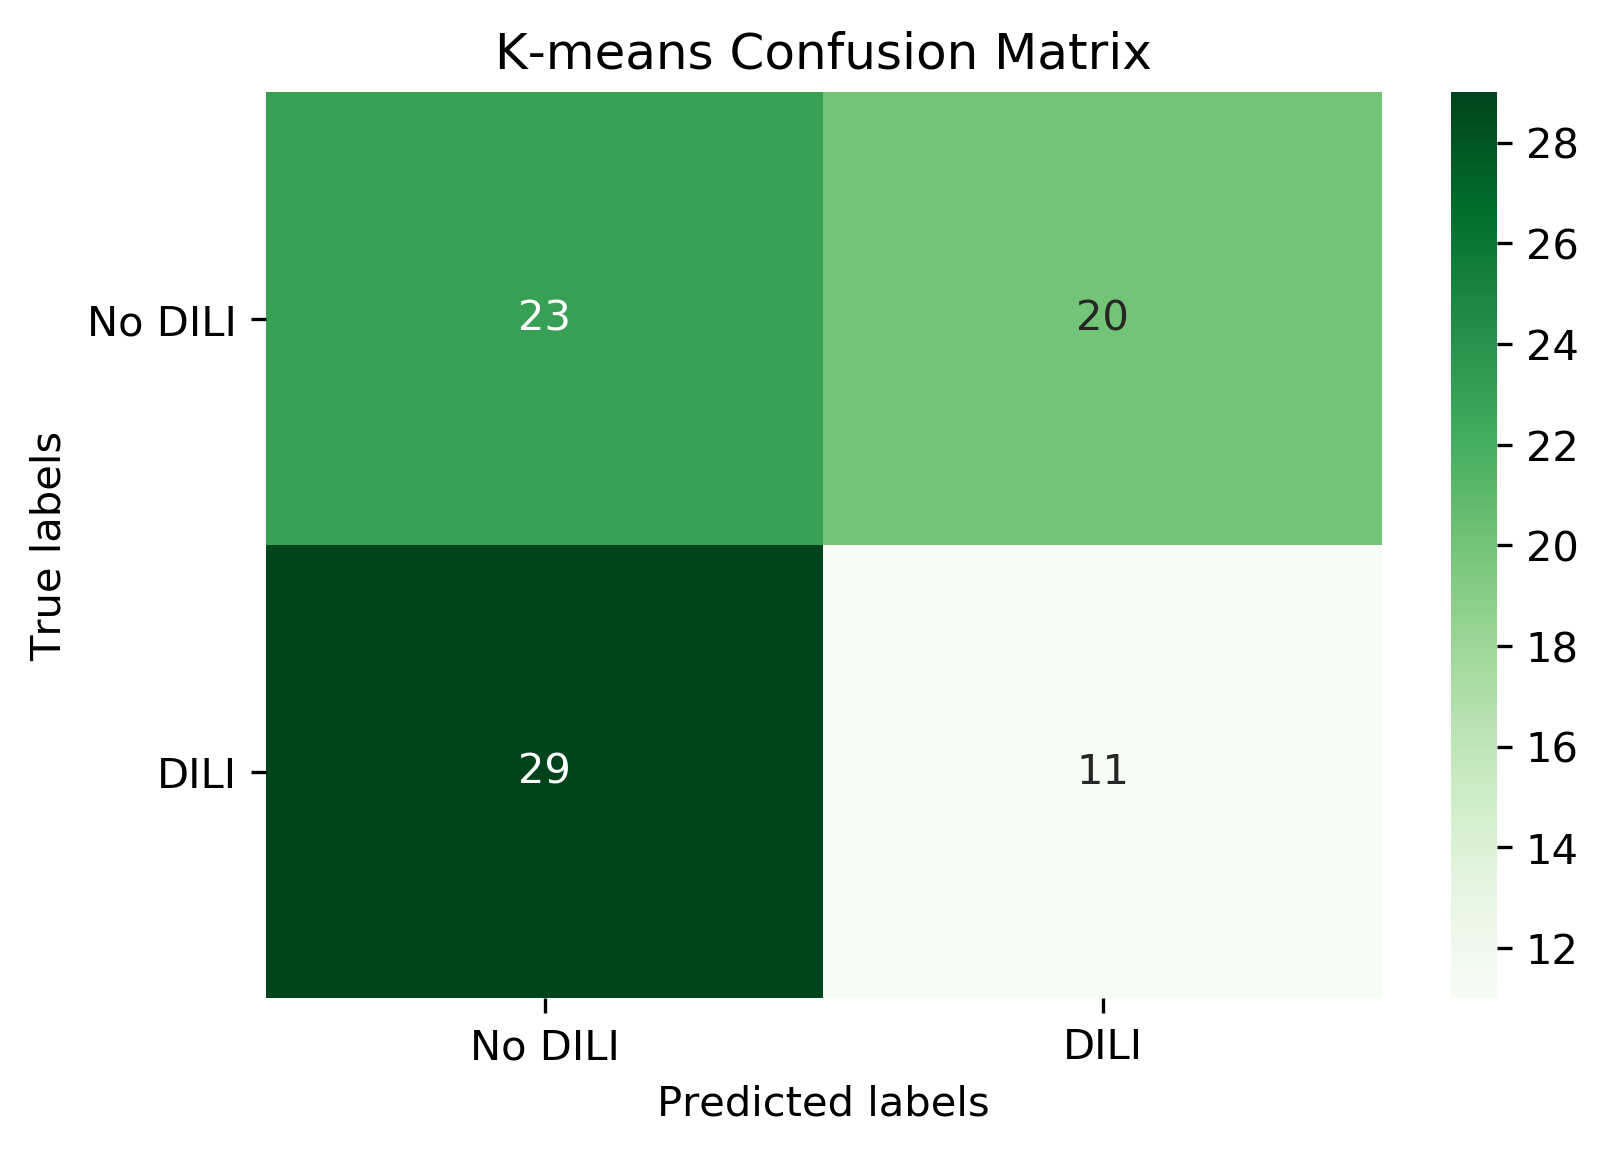

In [255]:
cM(B_test.iloc[:,2], p_sVM_DILI5)

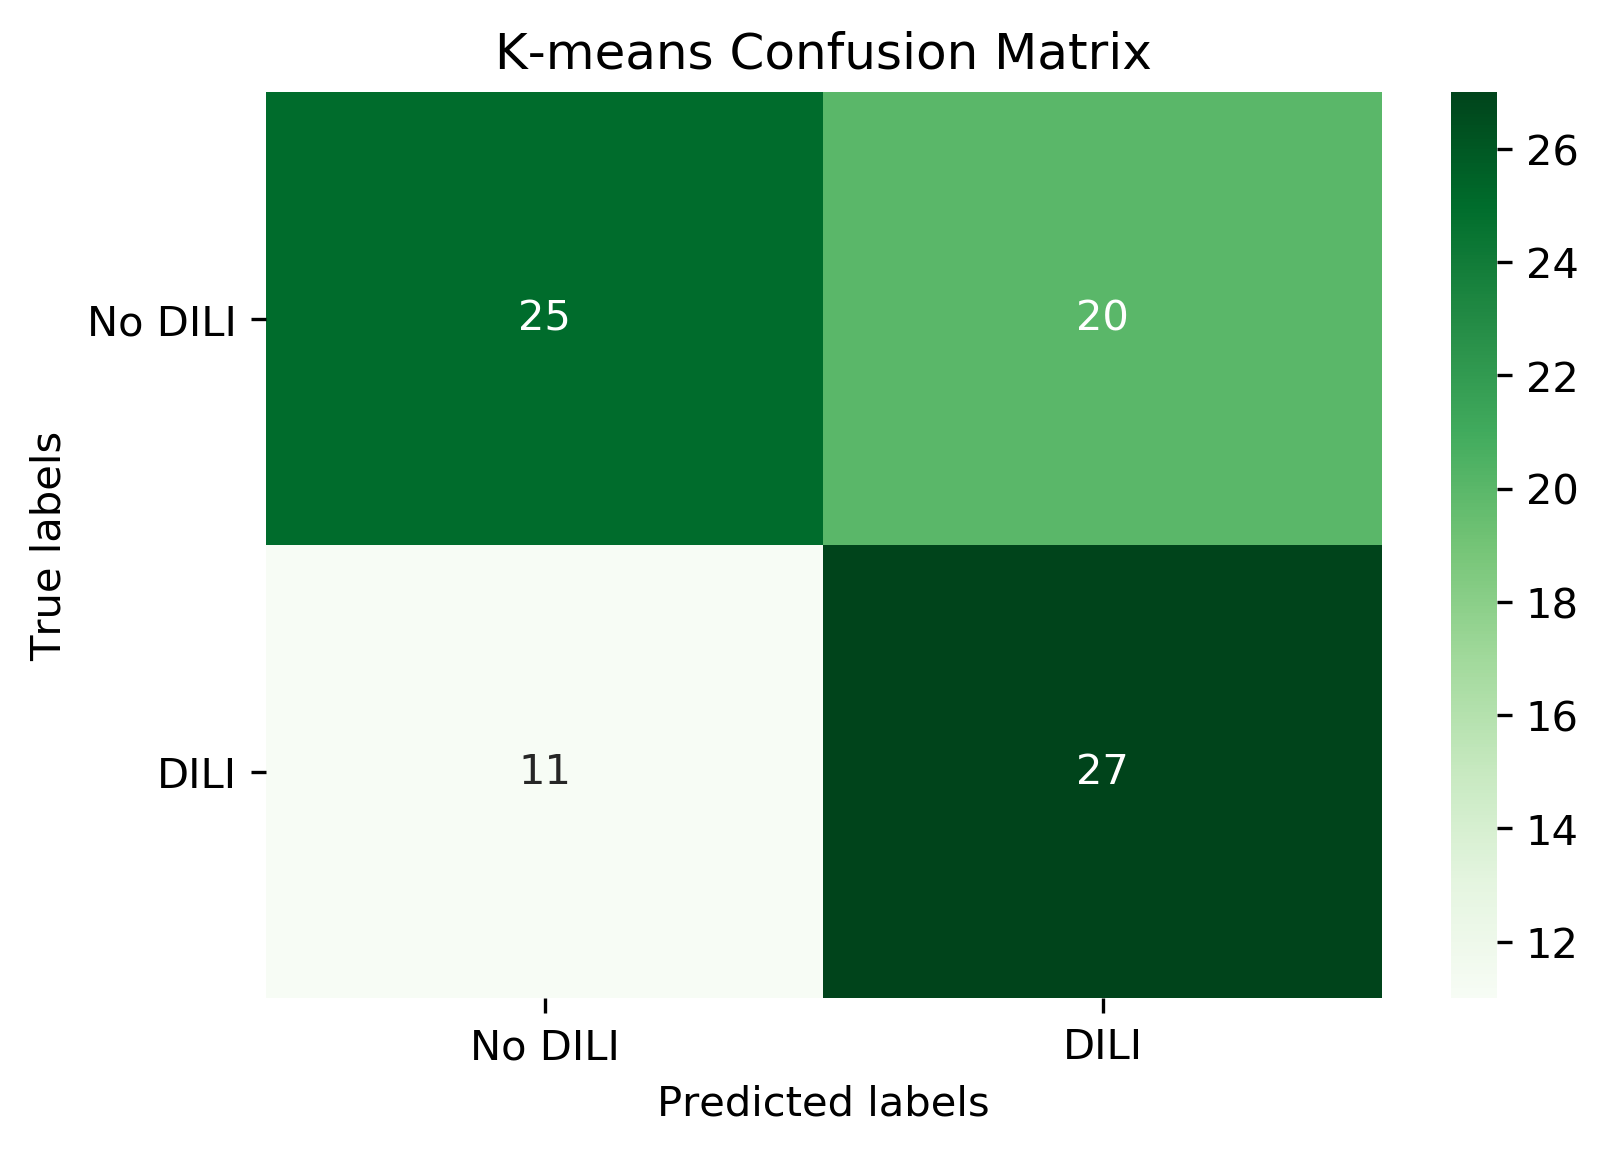

In [256]:
cM(B_test.iloc[:,3], p_sVM_DILI6)

## Multi-layer Perceptron

#### Hyperparameter Tuning
Used rSearch instead of gSearch due to time.

In [110]:
grid_params_MLP = {
        'hidden_layer_sizes': [(20,20,20), (50,50,50), (100,100,100), (200,200,200)],    
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'learning_rate': ['constant', 'invscaling', 'adaptive']
}

MLP_result_DILI1 = rSearch(grid_params_MLP, MLPClassifier(), A_train, B_train['DILI1'])
MLP_result_DILI3 = rSearch(grid_params_MLP, MLPClassifier(), A_train, B_train['DILI3'])
MLP_result_DILI5 = rSearch(grid_params_MLP, MLPClassifier(), A_train, B_train['DILI5'])
MLP_result_DILI6 = rSearch(grid_params_MLP, MLPClassifier(), A_train, B_train['DILI6'])

print("DILI1")
print("Best Score: ", MLP_result_DILI1.best_score_)
print("Best Estimator: ", MLP_result_DILI1.best_estimator_)
print("Best Params: ", MLP_result_DILI1.best_params_)

print("DILI3")
print("Best Score: ", MLP_result_DILI3.best_score_)
print("Best Estimator: ", MLP_result_DILI3.best_estimator_)
print("Best Params: ", MLP_result_DILI3.best_params_)

print("DILI5")
print("Best Score: ", MLP_result_DILI5.best_score_)
print("Best Estimator: ", MLP_result_DILI5.best_estimator_)
print("Best Params: ", MLP_result_DILI5.best_params_)

print("DILI6")
print("Best Score: ", MLP_result_DILI6.best_score_)
print("Best Estimator: ", MLP_result_DILI6.best_estimator_)
print("Best Params: ", MLP_result_DILI6.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: Conv

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: Conv

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: Conv

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: Conv

DILI1
Best Score:  0.7168674698795181
Best Estimator:  MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
Best Params:  {'learning_rate': 'constant', 'hidden_layer_sizes': (100, 100, 100), 'activation': 'relu'}
DILI3
Best Score:  0.5632530120481928
Best Estimator:  MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20, 20), learning_rate='invscaling',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, pow

In [111]:
#Multi-layer Perceptron
def mlp(X_train, X_test, y_train, hls, a, lr) :
    MLP = MLPClassifier(hidden_layer_sizes= hls, activation = a, learning_rate = lr) 

    #Train
    MLP.fit(X_train,y_train)
    score = MLP.score(X_train, y_train)

    #Predict
    predictions = MLP.predict(X_test)
    y_prob = MLP.predict_proba(X_test)
    
    #10-fold Cross Validation
    cross_Val = crossVal(MLP, X_train, y_train, 10)

    return(predictions, y_prob, score, cross_Val)

In [112]:
p_mlp_DILI1, y_mlp_DILI1, s_mlp_DILI1, cv_mlp_DILI1 = mlp(A_train, #Training Set
                                                          A_test, #Test Set
                                                          B_train['DILI1'], #Training labels
                                                          (100,100,100), #hidden layer
                                                          'relu', #activation
                                                          'constant' #learning rate
                                                         )
p_mlp_DILI3, y_mlp_DILI3, s_mlp_DILI3, cv_mlp_DILI3 = mlp(A_train, 
                                                          A_test, 
                                                          B_train['DILI3'],
                                                          (20,20,20),
                                                          'relu',
                                                          'invscaling'
                                                         )
p_mlp_DILI5, y_mlp_DILI5, s_mlp_DILI5, cv_mlp_DILI5 = mlp(A_train, 
                                                          A_test, 
                                                          B_train['DILI5'],
                                                          (20,20,20),
                                                          'relu',
                                                          'invscaling'
                                                         )
p_mlp_DILI6, y_mlp_DILI6, s_mlp_DILI6, cv_mlp_DILI6 = mlp(A_train, 
                                                          A_test, 
                                                          B_train['DILI6'],
                                                          (20,20,20),
                                                          'relu',
                                                          'invscaling'
                                                         )


Cross Validation result:  0.6986631016042782 number of kFold splits:  10
Cross Validation result:  0.5454545454545455 number of kFold splits:  10
Cross Validation result:  0.527361853832442 number of kFold splits:  10
Cross Validation result:  0.5781639928698752 number of kFold splits:  10


#### Calculate Accuracy 

In [113]:
print('Multi-layer Perceptron (DILI1): ', round(accuracy_score(B_test.iloc[:,0], p_mlp_DILI1), 3))
print('Multi-layer Perceptron (DILI3): ', round(accuracy_score(B_test.iloc[:,1], p_mlp_DILI3), 3))
print('Multi-layer Perceptron (DILI5): ', round(accuracy_score(B_test.iloc[:,2], p_mlp_DILI5), 3))
print('Multi-layer Perceptron (DILI6): ', round(accuracy_score(B_test.iloc[:,3], p_mlp_DILI6), 3))

Multi-layer Perceptron (DILI1):  0.711
Multi-layer Perceptron (DILI3):  0.542
Multi-layer Perceptron (DILI5):  0.506
Multi-layer Perceptron (DILI6):  0.663


#### Calculate Balanced Accuracy 

In [114]:
print('Multi-layer Perceptron (DILI1): ', round(balanced_accuracy_score(B_test.iloc[:,0], p_mlp_DILI1), 3))
print('Multi-layer Perceptron (DILI3): ', round(balanced_accuracy_score(B_test.iloc[:,1], p_mlp_DILI3), 3))
print('Multi-layer Perceptron (DILI5): ', round(balanced_accuracy_score(B_test.iloc[:,2], p_mlp_DILI5), 3))
print('Multi-layer Perceptron (DILI6): ', round(balanced_accuracy_score(B_test.iloc[:,3], p_mlp_DILI6), 3))

Multi-layer Perceptron (DILI1):  0.476
Multi-layer Perceptron (DILI3):  0.511
Multi-layer Perceptron (DILI5):  0.508
Multi-layer Perceptron (DILI6):  0.673


#### Calculate Precision Score

In [115]:
print('MLP Precision (DILI1): ', round(precision_score(B_test.iloc[:,0], p_mlp_DILI1), 3))
print('MLP Precision (DILI3): ', round(precision_score(B_test.iloc[:,1], p_mlp_DILI3), 3))
print('MLP Precision (DILI5): ', round(precision_score(B_test.iloc[:,2], p_mlp_DILI5), 3))
print('MLP Precision (DILI6): ', round(precision_score(B_test.iloc[:,3], p_mlp_DILI6), 3))


MLP Precision (DILI1):  0.0
MLP Precision (DILI3):  0.387
MLP Precision (DILI5):  0.489
MLP Precision (DILI6):  0.6


#### Calculate F1 Score

In [323]:
print('MLP F1 Score (DILI1): ', round(f1_score(B_test.iloc[:,0], p_mlp_DILI1), 3))
print('MLP F1 Score (DILI3): ', round(f1_score(B_test.iloc[:,1], p_mlp_DILI3), 3))
print('MLP F1 Score (DILI5): ', round(f1_score(B_test.iloc[:,2], p_mlp_DILI5), 3))
print('MLP F1 Score (DILI6): ', round(f1_score(B_test.iloc[:,3], p_mlp_DILI6), 3))


MLP F1 Score (DILI1):  0.0
MLP F1 Score (DILI3):  0.387
MLP F1 Score (DILI5):  0.518
MLP F1 Score (DILI6):  0.682


#### Calculate ROC AUC Score

In [116]:
print('MLP ROC AUC Score (DILI1): ', round(roc_auc_score(B_test.iloc[:,0], y_mlp_DILI1[:,0]), 3))
print('MLP ROC AUC Score (DILI3): ', round(roc_auc_score(B_test.iloc[:,1], y_mlp_DILI3[:,0]), 3))
print('MLP ROC AUC Score (DILI5): ', round(roc_auc_score(B_test.iloc[:,2], y_mlp_DILI5[:,0]), 3))
print('MLP ROC AUC Score (DILI6): ', round(roc_auc_score(B_test.iloc[:,3], y_mlp_DILI6[:,0]), 3))


MLP ROC AUC Score (DILI1):  0.554
MLP ROC AUC Score (DILI3):  0.468
MLP ROC AUC Score (DILI5):  0.472
MLP ROC AUC Score (DILI6):  0.236


#### Calculate TPR and FPRm and plot ROC curve

In [118]:
fpr_MLP_DILI1, tpr_MLP_DILI1, _ = roc_curve(B_test.iloc[:,0], y_mlp_DILI1[:,0])
fpr_MLP_DILI3, tpr_MLP_DILI3, _ = roc_curve(B_test.iloc[:,0], y_mlp_DILI3[:,0])
fpr_MLP_DILI5, tpr_MLP_DILI5, _ = roc_curve(B_test.iloc[:,0], y_mlp_DILI5[:,0])
fpr_MLP_DILI6, tpr_MLP_DILI6, _ = roc_curve(B_test.iloc[:,0], y_mlp_DILI6[:,0])

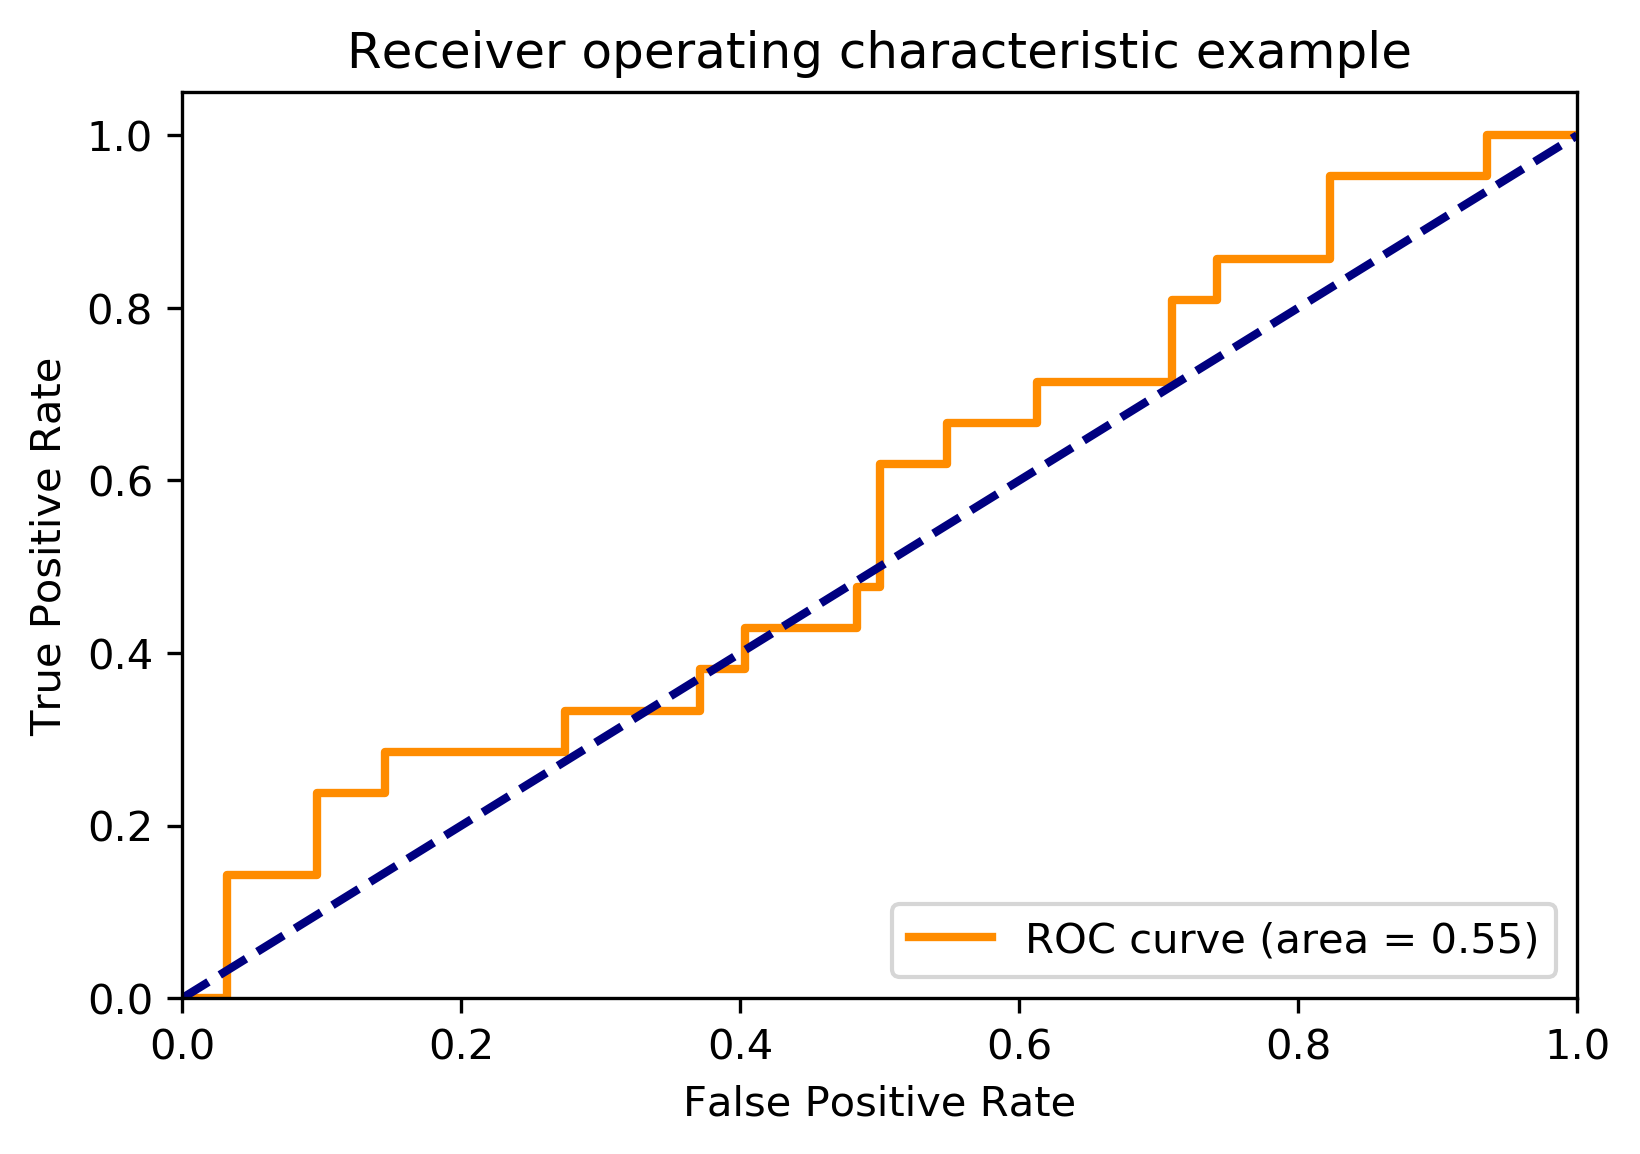

In [257]:
plotROC(fpr_MLP_DILI1, tpr_MLP_DILI1, roc_auc_score(B_test.iloc[:,0], y_mlp_DILI1[:,0]))

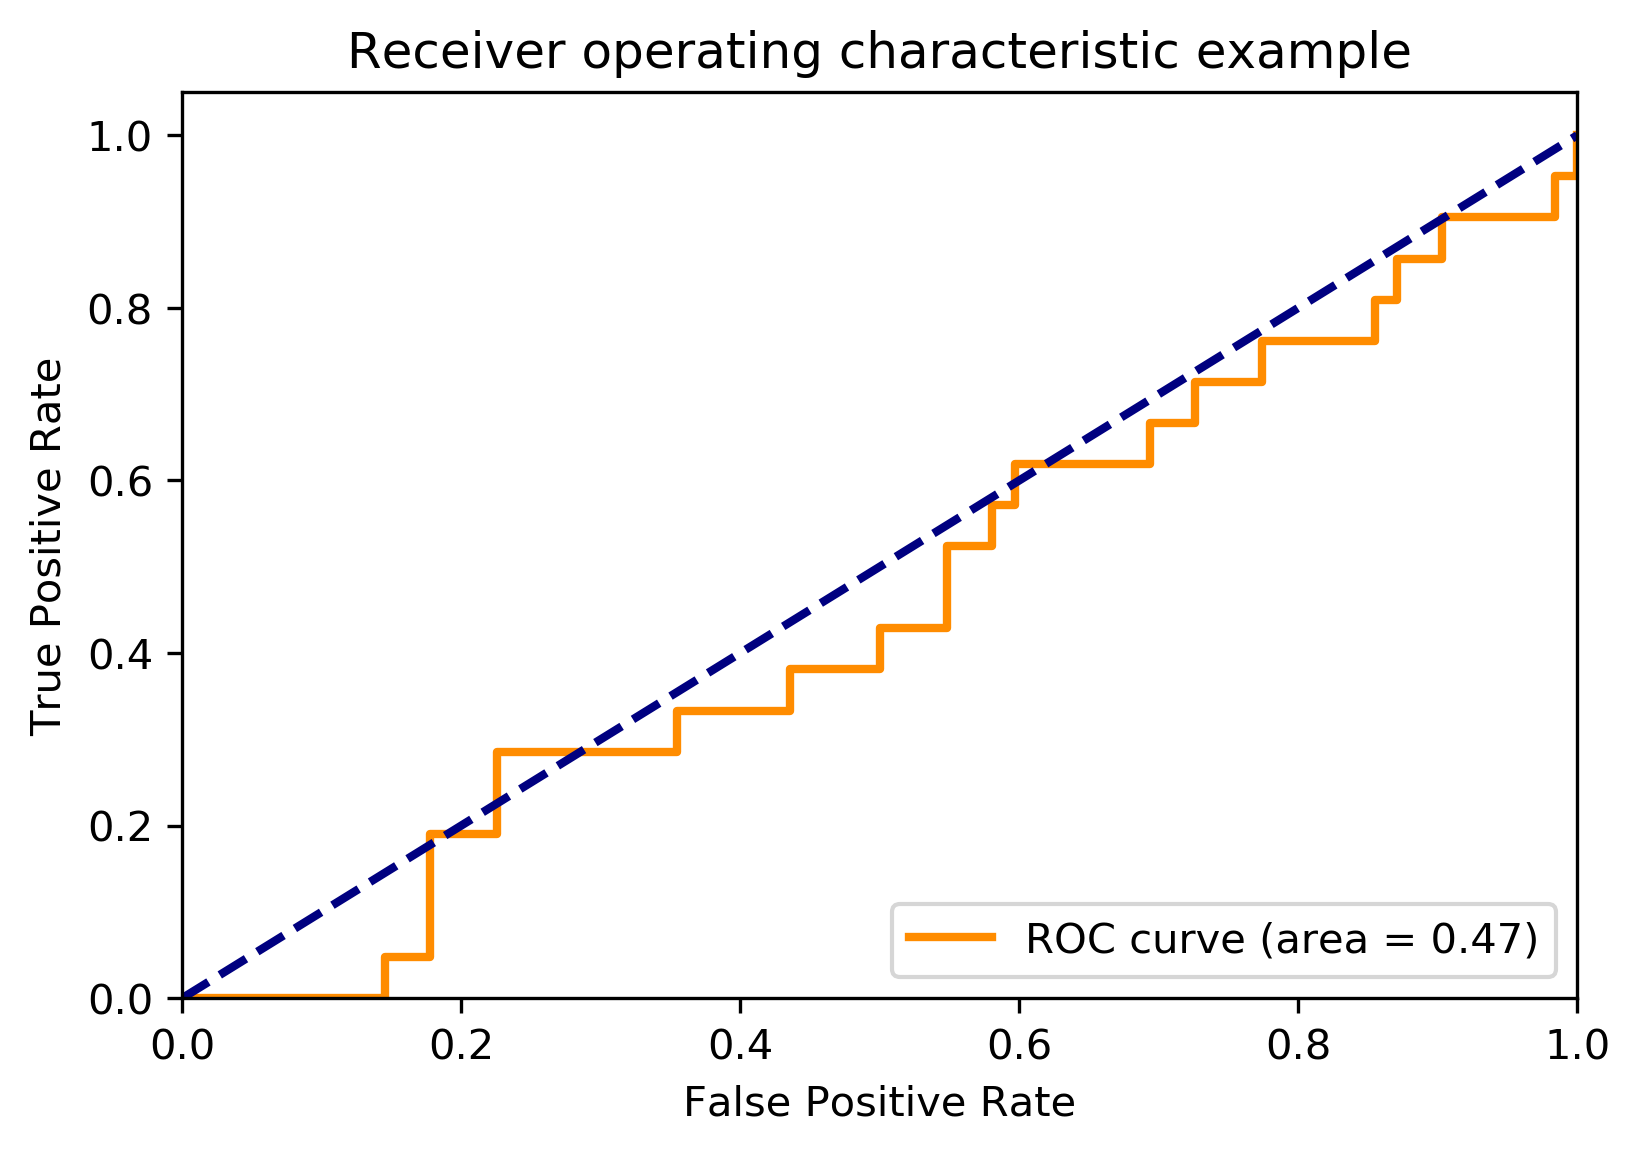

In [258]:
plotROC(fpr_MLP_DILI3, tpr_MLP_DILI3, roc_auc_score(B_test.iloc[:,1], y_mlp_DILI3[:,0]))

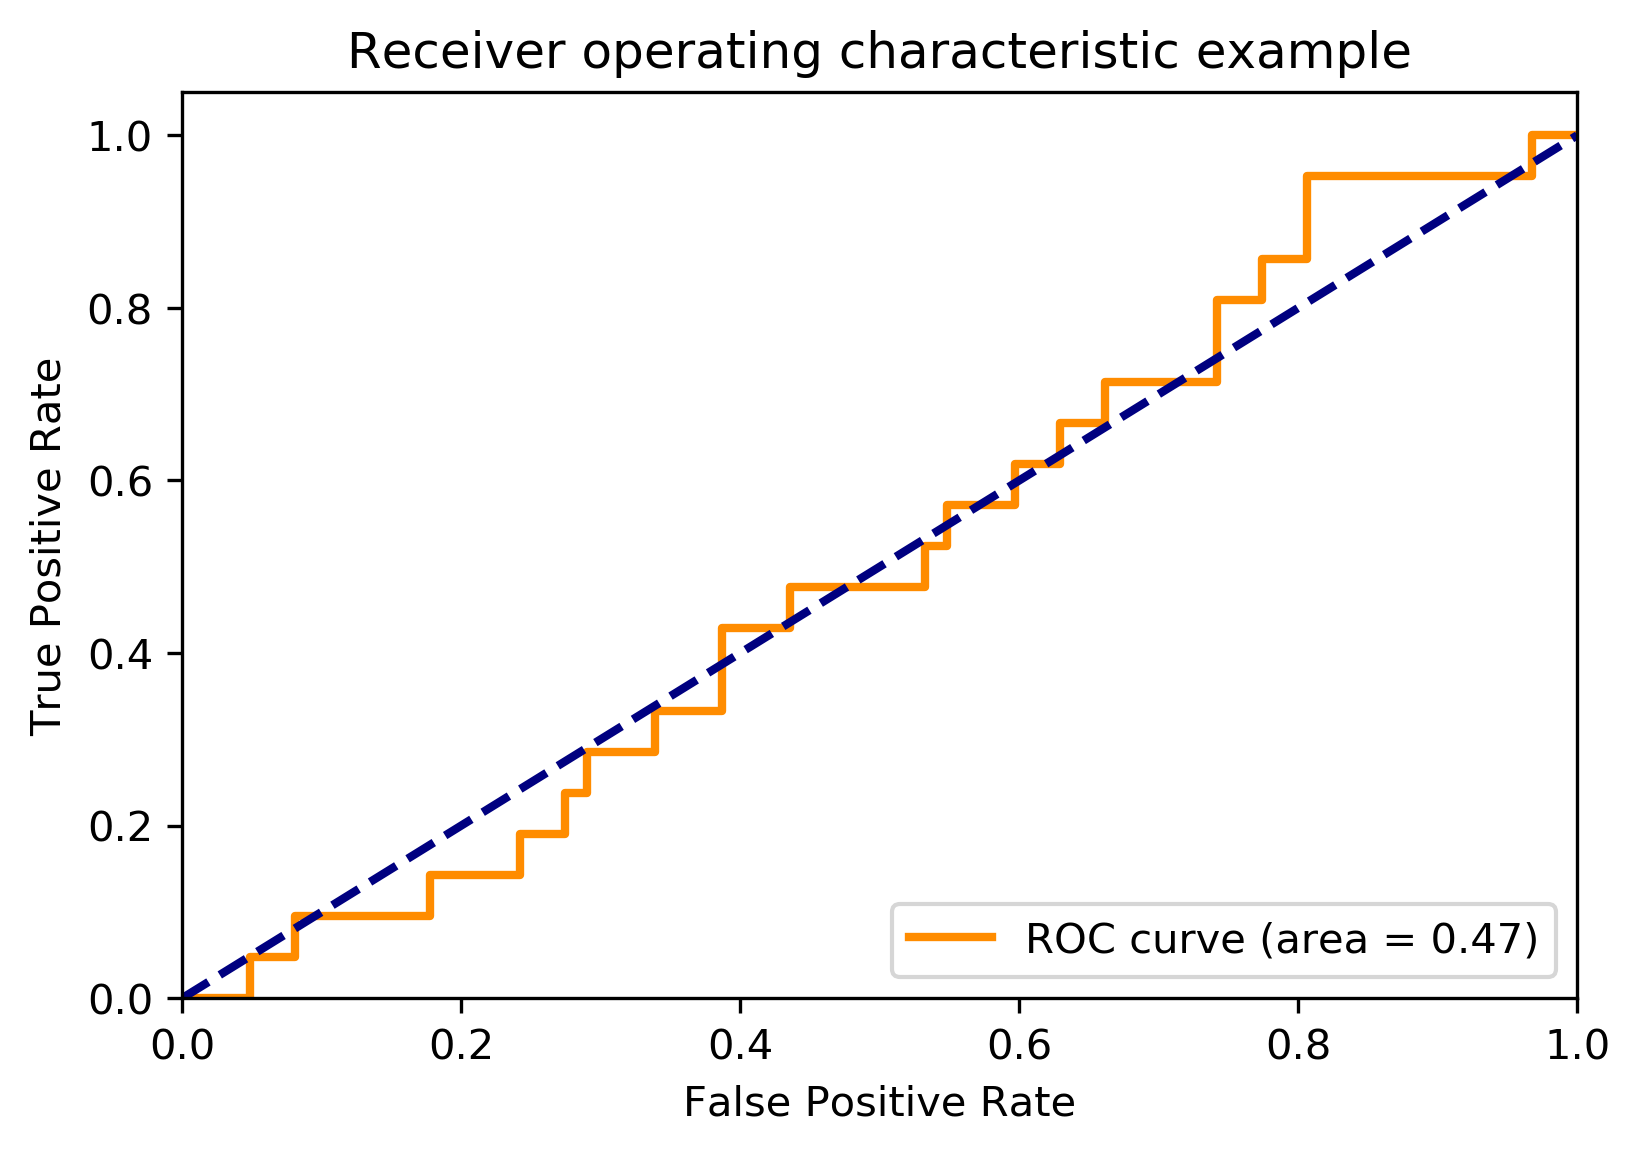

In [259]:
plotROC(fpr_MLP_DILI5, tpr_MLP_DILI5, roc_auc_score(B_test.iloc[:,2], y_mlp_DILI5[:,0]))

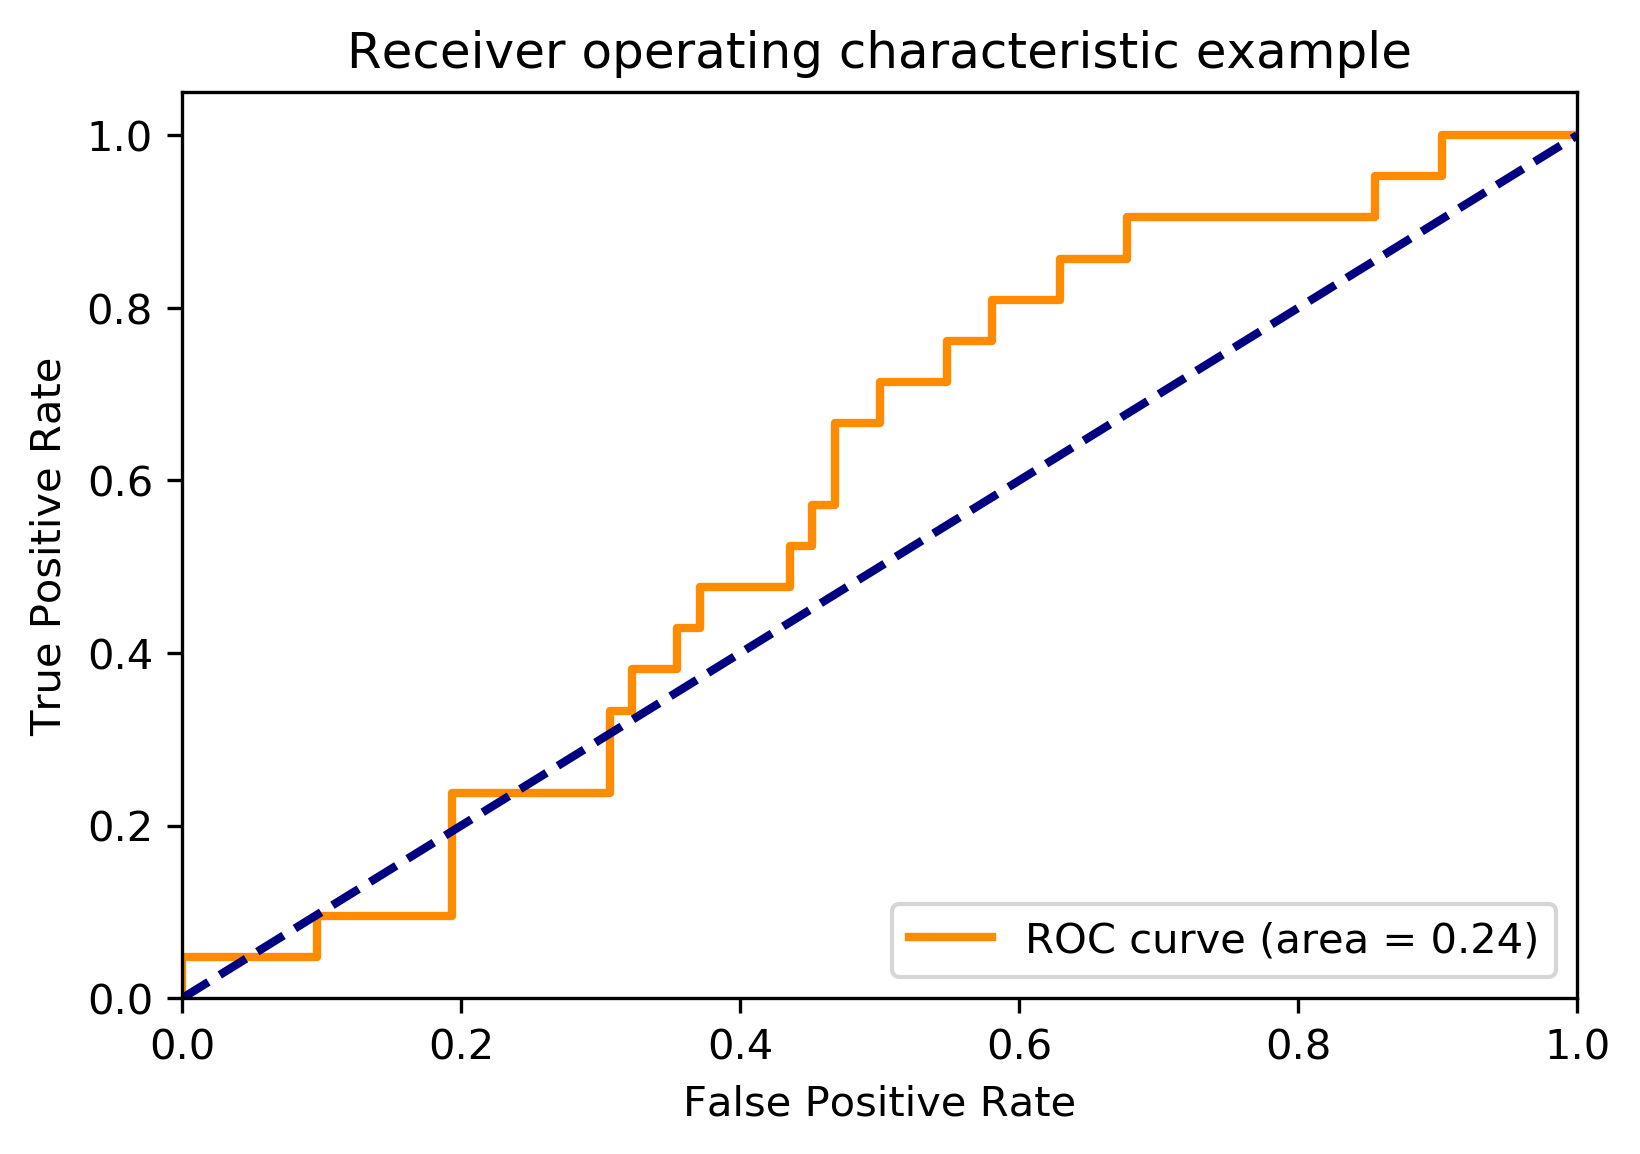

In [260]:
plotROC(fpr_MLP_DILI6, tpr_MLP_DILI6, roc_auc_score(B_test.iloc[:,3], y_mlp_DILI6[:,0]))

#### Plot Confusion Matrices

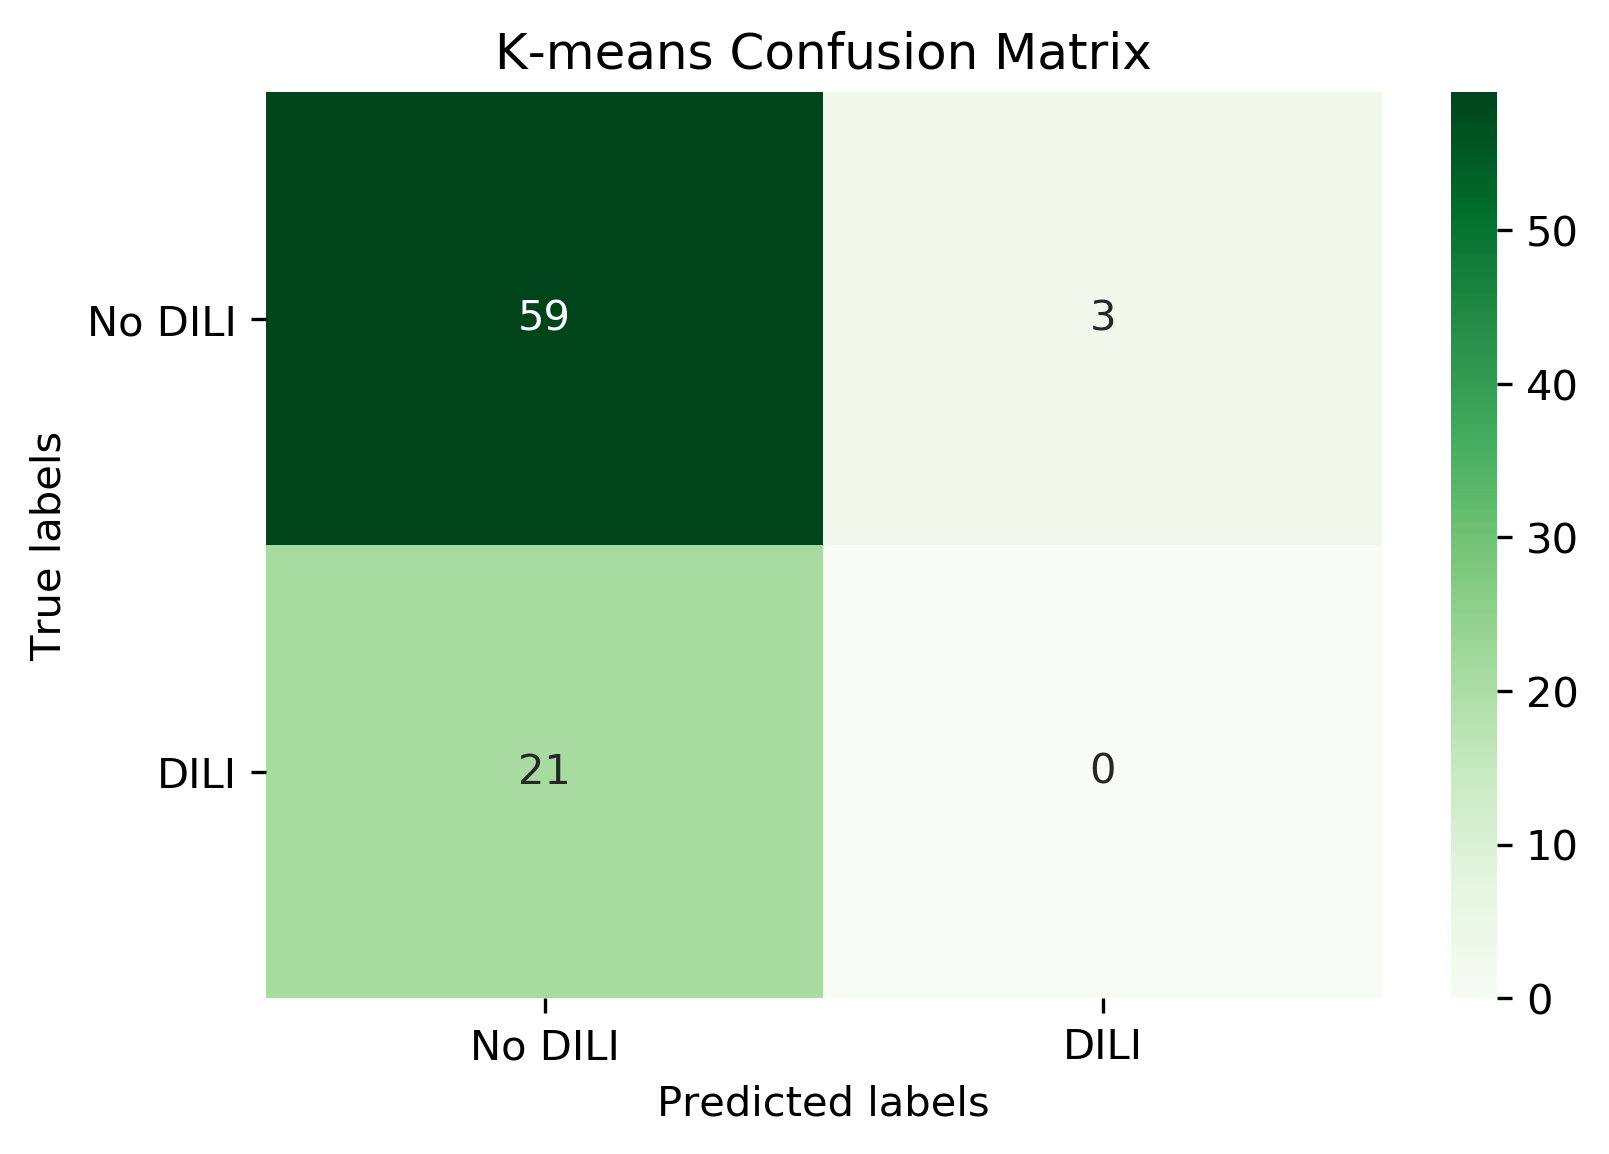

In [261]:
cM(B_test.iloc[:,0], p_mlp_DILI1)

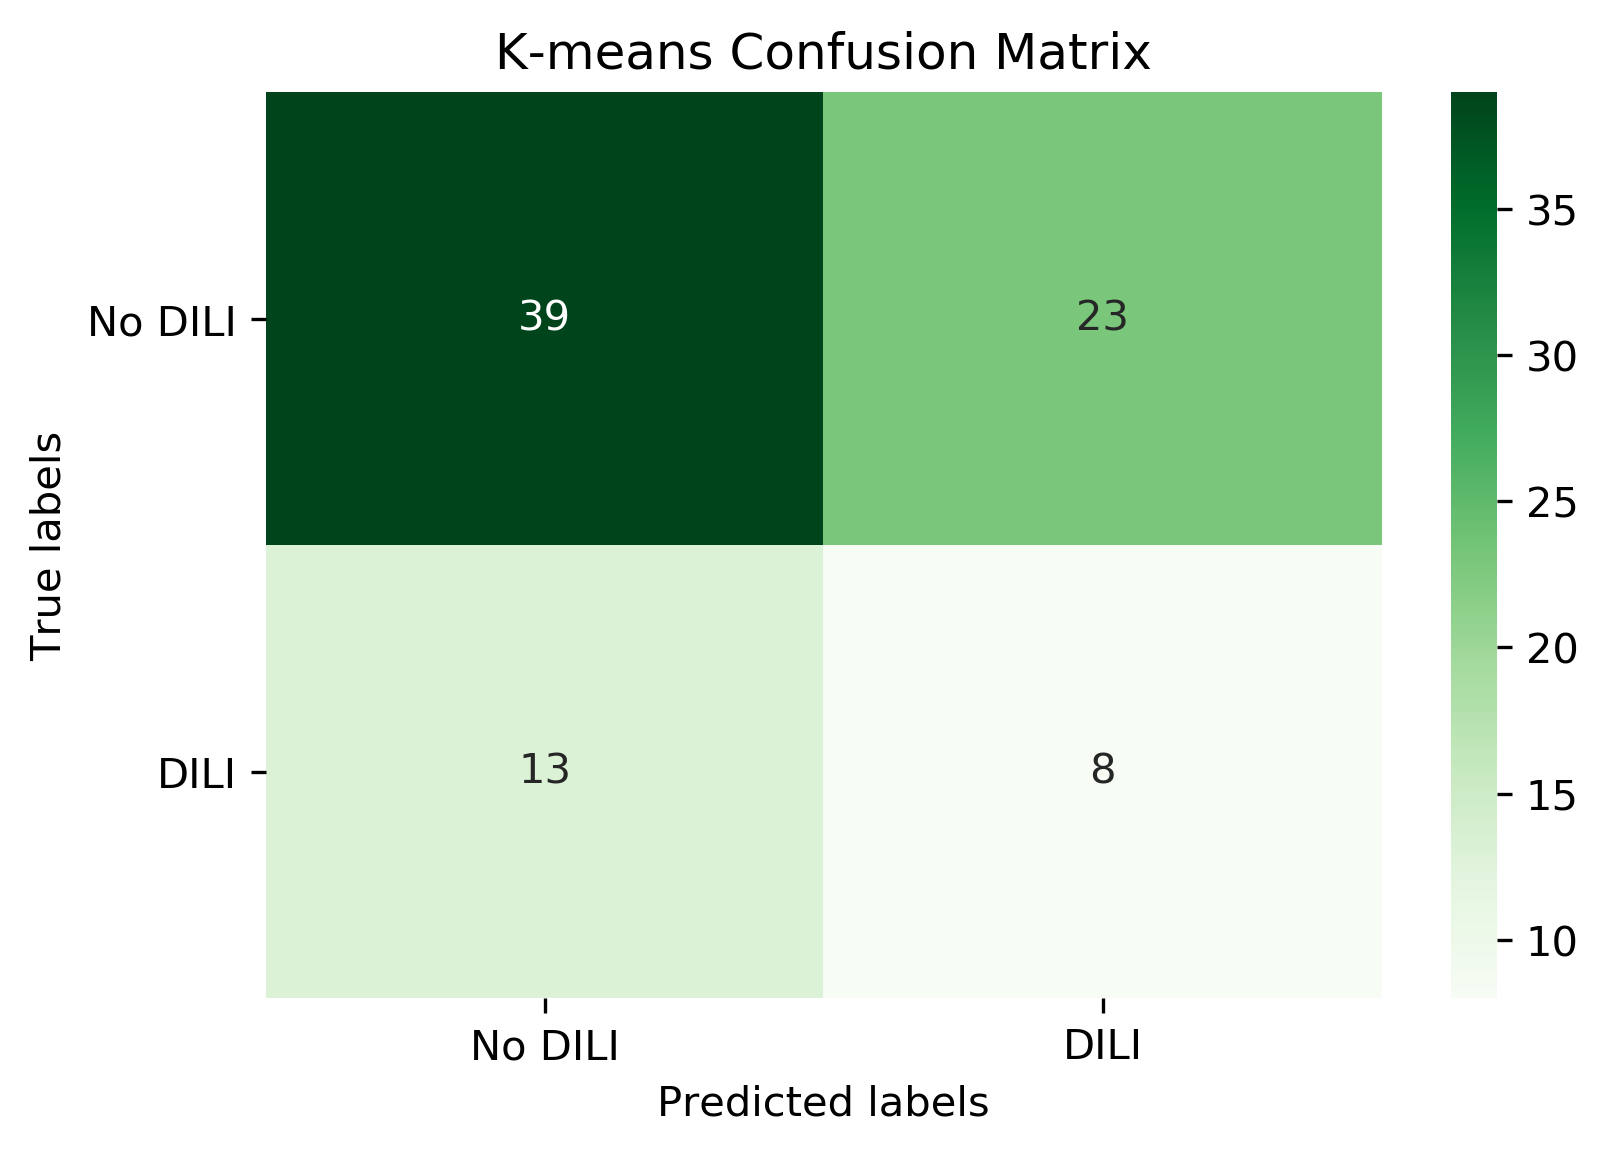

In [262]:
cM(B_test.iloc[:,0], p_mlp_DILI3)

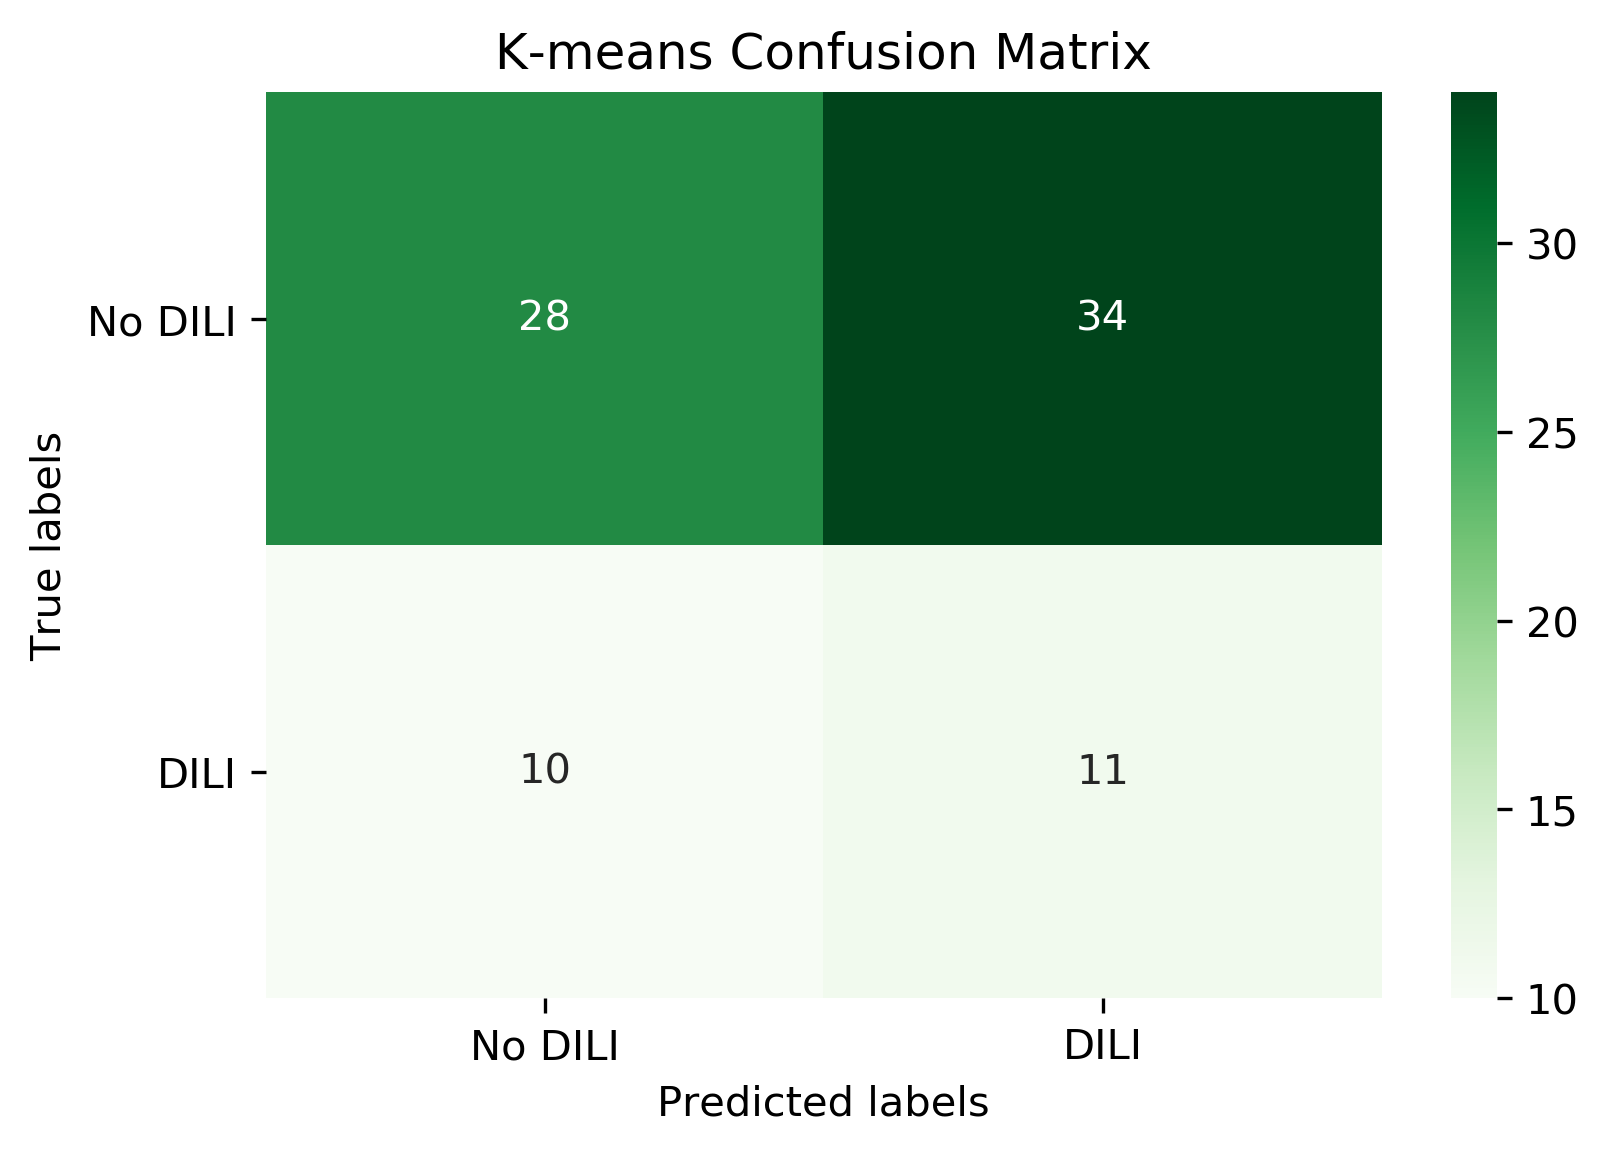

In [263]:
cM(B_test.iloc[:,0], p_mlp_DILI5)

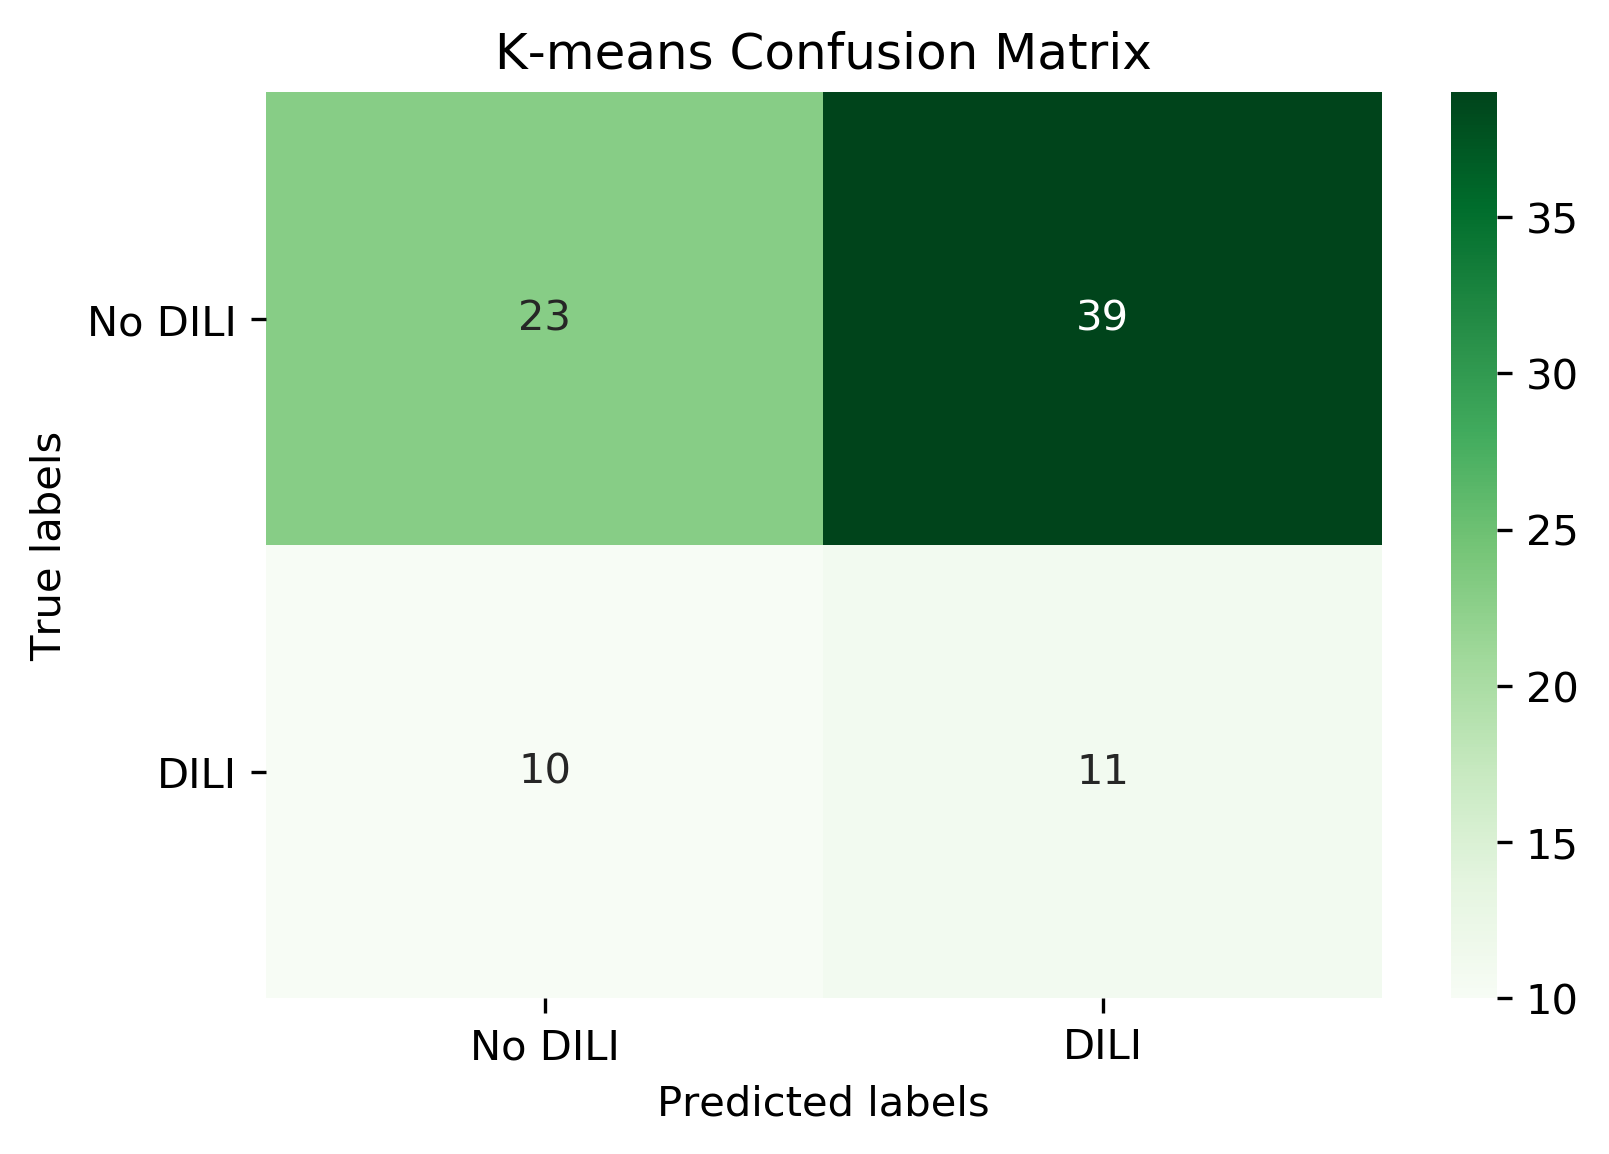

In [264]:
cM(B_test.iloc[:,0], p_mlp_DILI6)

## Gradient Boosting with and without PCA

#### Conduct PCA on Training data

[]

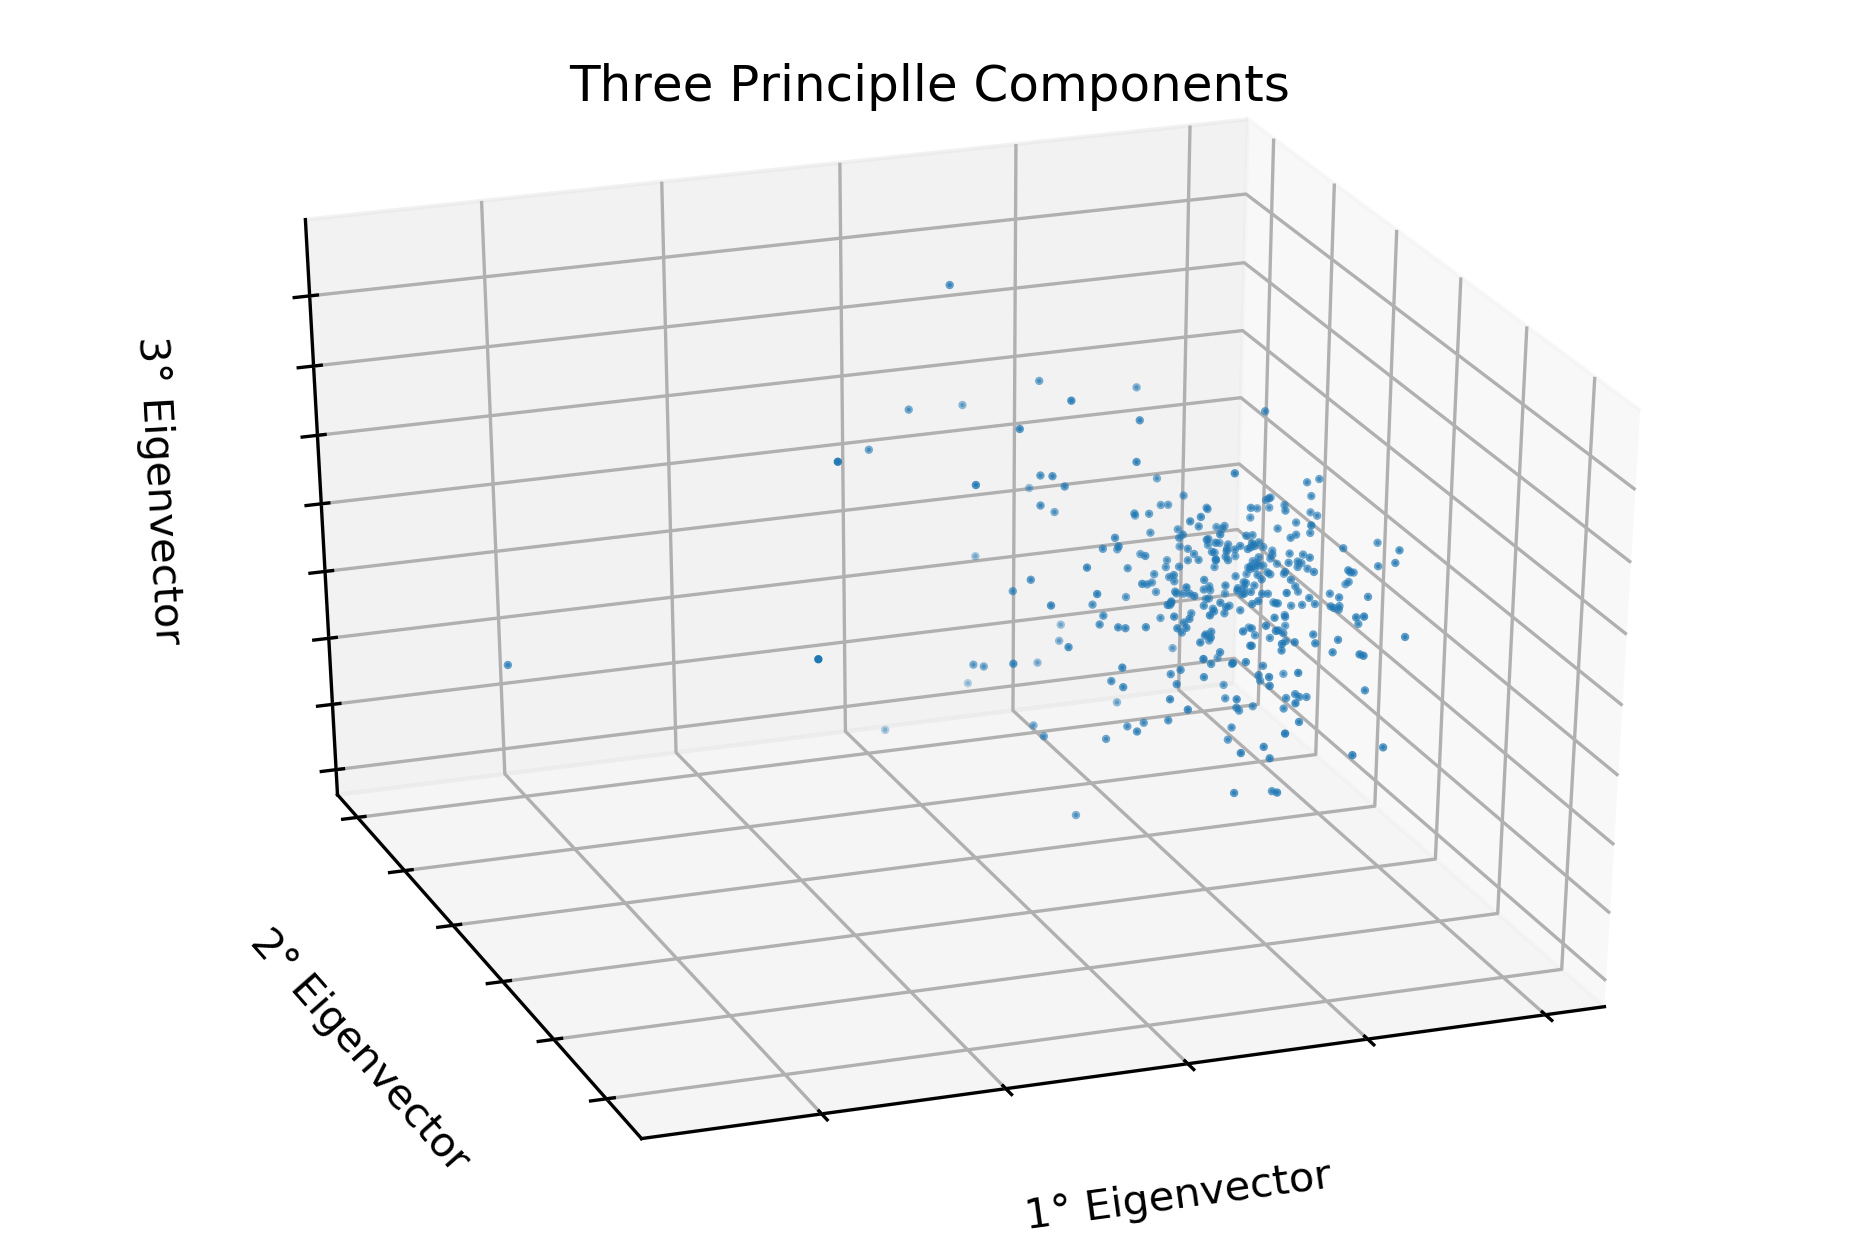

In [266]:
pca_3c = PCA(n_components=3).fit(A_train)
A_train_PCA = pca_3c.fit_transform(A_train)

plt.clf()
fig = plt.figure(1, figsize=(10,6 ))
ax = Axes3D(fig, elev=-150, azim=110,)
ax.scatter(A_train_PCA[:, 0], A_train_PCA[:, 1], A_train_PCA[:, 2], s = 1)
ax.set_title("Three Principlle Components")
ax.set_xlabel("1° Eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2° Eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3° Eigenvector")
ax.w_zaxis.set_ticklabels([])

### 
Note that there only seems to be one cluster as opposed to two distinct clusters from before.

### Without PCA

#### Hyperparameter Tuning

In [131]:
grid_params_XGB = {
        'max_depth' : [4,5,6,7,8],    
        'booster': ['gbtree', 'gblinear', 'dart'],
        'n_estimators': [10,50,100,200,500],
        'reg_alpha': [0,1],
        'reg_lambda': [0,1],
        'gamma': [0,1]
}

XGB_result_DILI1 = rSearch(grid_params_XGB, xgb.XGBClassifier(), A_train, B_train['DILI1'])
XGB_result_DILI3 = rSearch(grid_params_XGB, xgb.XGBClassifier(), A_train, B_train['DILI3'])
XGB_result_DILI5 = rSearch(grid_params_XGB, xgb.XGBClassifier(), A_train, B_train['DILI5'])
XGB_result_DILI6 = rSearch(grid_params_XGB, xgb.XGBClassifier(), A_train, B_train['DILI6'])

print("DILI1")
print("Best Score: ", XGB_result_DILI1.best_score_)
print("Best Estimator: ", XGB_result_DILI1.best_estimator_)
print("Best Params: ", XGB_result_DILI1.best_params_)

print("DILI3")
print("Best Score: ", XGB_result_DILI3.best_score_)
print("Best Estimator: ", XGB_result_DILI3.best_estimator_)
print("Best Params: ", XGB_result_DILI3.best_params_)

print("DILI5")
print("Best Score: ", XGB_result_DILI5.best_score_)
print("Best Estimator: ", XGB_result_DILI5.best_estimator_)
print("Best Params: ", XGB_result_DILI5.best_params_)

print("DILI6")
print("Best Score: ", XGB_result_DILI6.best_score_)
print("Best Estimator: ", XGB_result_DILI6.best_estimator_)
print("Best Params: ", XGB_result_DILI6.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 35.9min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 69.4min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 48.8min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 62.0min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


DILI1
Best Score:  0.7831325301204819
Best Estimator:  XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=1, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.5, max_delta_step=None, max_depth=6,
       min_child_weight=None, missing=nan, monotone_constraints=None,
       n_estimators=10, n_jobs=0, num_parallel_tree=None,
       objective='binary:logistic', random_state=0, reg_alpha=1,
       reg_lambda=0, scale_pos_weight=1, subsample=None, tree_method=None,
       validate_parameters=False, verbosity=None)
Best Params:  {'reg_lambda': 0, 'reg_alpha': 1, 'n_estimators': 10, 'max_depth': 6, 'gamma': 1, 'booster': 'gblinear'}
DILI3
Best Score:  0.6174698795180723
Best Estimator:  XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=1, gpu_id=-1,
       importance_type='gain', interac

In [134]:
def xgb_PCA(X_train, X_test, y_train, PCA, md, b, n, ra, rl, g):
    xgb_model = xgb.XGBClassifier(max_depth = md, 
                                  booster = b, 
                                  n_estimators = n, 
                                  reg_alpha = ra,
                                  reg_lambda = rl,
                                  gamma = g)

    if PCA == 1: #Want to compare Gradient boost with and without PCA; set PCA to 1 to conduct PCA on data. 
        X_train = pca_3c.fit_transform(X_train)
        X_test = pca_3c.fit_transform(X_test)
    
    #Train
    xgb_model.fit(X_train, y_train)
    score = xgb_model.score(X_train, y_train)

    #Predict
    xgb_pred = xgb_model.predict(X_test)
    y_prob = xgb_model.predict_proba(X_test)
    
    #10-fold Cross Validation
    cross_Val = crossVal(xgb_model, X_train, y_train, 10)

    return(xgb_pred, y_prob, score, cross_Val)

In [135]:
#Gradient Boost without PCA
p_xgb1_DILI1, y_xgb1_DILI1,  s_xgb1_DILI1,  cv_xgb1_DILI1 = xgb_PCA(A_train, #Training set
                                                                    A_test, #Test set
                                                                    B_train['DILI1'], #Training labels
                                                                    0, #PCA
                                                                    6, #max_depth
                                                                    'gblinear', #booster
                                                                    10, #n_estimators
                                                                    1, #reg_alpha
                                                                    0, #reg_lambda
                                                                    1 #gamma
                                                                   )
p_xgb1_DILI3, y_xgb1_DILI3,  s_xgb1_DILI3,  cv_xgb1_DILI3 = xgb_PCA(A_train, 
                                                                    A_test, 
                                                                    B_train['DILI3'], 
                                                                    0,
                                                                    5,
                                                                    'gblinear',
                                                                    500,
                                                                    1,
                                                                    0,
                                                                    1
                                                                   )
p_xgb1_DILI5, y_xgb1_DILI5,  s_xgb1_DILI5,  cv_xgb1_DILI5 = xgb_PCA(A_train, 
                                                                    A_test, 
                                                                    B_train['DILI5'], 
                                                                    0,
                                                                    6,
                                                                    'gblinear',
                                                                    500,
                                                                    1,
                                                                    0,
                                                                    0
                                                                   )
p_xgb1_DILI6, y_xgb1_DILI6,  s_xgb1_DILI6,  cv_xgb1_DILI6 = xgb_PCA(A_train, 
                                                                    A_test, 
                                                                    B_train['DILI6'], 
                                                                    0,
                                                                    7,
                                                                    'dart',
                                                                    10,
                                                                    0,
                                                                    1,
                                                                    1
                                                                   )

Cross Validation result:  0.7829768270944741 number of kFold splits:  10
Cross Validation result:  0.6172905525846704 number of kFold splits:  10
Cross Validation result:  0.5211229946524063 number of kFold splits:  10
Cross Validation result:  0.5871657754010695 number of kFold splits:  10


#### Calculate Accuracy 

In [136]:
print('XGB (DILI1): ', round(accuracy_score(B_test.iloc[:,0], p_xgb1_DILI1), 3))
print('XGB (DILI3): ', round(accuracy_score(B_test.iloc[:,1], p_xgb1_DILI3), 3))
print('XGB (DILI5): ', round(accuracy_score(B_test.iloc[:,2], p_xgb1_DILI5), 3))
print('XGB (DILI6): ', round(accuracy_score(B_test.iloc[:,3], p_xgb1_DILI6), 3))

XGB (DILI1):  0.747
XGB (DILI3):  0.627
XGB (DILI5):  0.518
XGB (DILI6):  0.614


#### Calculate Balanced Accuracy 

In [137]:
print('XGB (DILI1): ', round(balanced_accuracy_score(B_test.iloc[:,0], p_xgb1_DILI1), 3))
print('XGB (DILI3): ', round(balanced_accuracy_score(B_test.iloc[:,1], p_xgb1_DILI3), 3))
print('XGB (DILI5): ', round(balanced_accuracy_score(B_test.iloc[:,2], p_xgb1_DILI5), 3))
print('XGB (DILI6): ', round(balanced_accuracy_score(B_test.iloc[:,3], p_xgb1_DILI6), 3))

XGB (DILI1):  0.5
XGB (DILI3):  0.5
XGB (DILI5):  0.5
XGB (DILI6):  0.626


#### Calculate Precision Score

In [138]:
print('XGB Precision (DILI1): ', round(precision_score(B_test.iloc[:,0], p_xgb1_DILI1), 3))
print('XGB Precision (DILI3): ', round(precision_score(B_test.iloc[:,1], p_xgb1_DILI3), 3))
print('XGB Precision (DILI5): ', round(precision_score(B_test.iloc[:,2], p_xgb1_DILI5), 3))
print('XGB Precision (DILI6): ', round(precision_score(B_test.iloc[:,3], p_xgb1_DILI6), 3))

XGB Precision (DILI1):  0.0
XGB Precision (DILI3):  0.0
XGB Precision (DILI5):  0.0
XGB Precision (DILI6):  0.558


/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Calculate F1 Score

In [324]:
print('XGB F1 Score (DILI1): ', round(f1_score(B_test.iloc[:,0], p_xgb1_DILI1), 3))
print('XGB F1 Score (DILI3): ', round(f1_score(B_test.iloc[:,1], p_xgb1_DILI3), 3))
print('XGB F1 Score (DILI5): ', round(f1_score(B_test.iloc[:,2], p_xgb1_DILI5), 3))
print('XGB F1 Score (DILI6): ', round(f1_score(B_test.iloc[:,3], p_xgb1_DILI6), 3))


XGB F1 Score (DILI1):  0.0
XGB F1 Score (DILI3):  0.0
XGB F1 Score (DILI5):  0.0
XGB F1 Score (DILI6):  0.644


#### Calculate ROC AUC Score

In [139]:
print('XGB ROC AUC Score (DILI1): ', round(roc_auc_score(B_test.iloc[:,0], y_xgb1_DILI1[:,0]), 3))
print('XGB ROC AUC Score (DILI3): ', round(roc_auc_score(B_test.iloc[:,1], y_xgb1_DILI3[:,0]), 3))
print('XGB ROC AUC Score (DILI5): ', round(roc_auc_score(B_test.iloc[:,2], y_xgb1_DILI5[:,0]), 3))
print('XGB ROC AUC Score (DILI6): ', round(roc_auc_score(B_test.iloc[:,3], y_xgb1_DILI6[:,0]), 3))

XGB ROC AUC Score (DILI1):  0.5
XGB ROC AUC Score (DILI3):  0.5
XGB ROC AUC Score (DILI5):  0.5
XGB ROC AUC Score (DILI6):  0.37


#### Calculate FPR and TPR, and pllot ROC curve

In [140]:
fpr_XGB1_DILI1, tpr_XGB1_DILI1, _ = roc_curve(B_test.iloc[:,0], y_xgb1_DILI1[:,0])
fpr_XGB1_DILI3, tpr_XGB1_DILI3, _ = roc_curve(B_test.iloc[:,0], y_xgb1_DILI3[:,0])
fpr_XGB1_DILI5, tpr_XGB1_DILI5, _ = roc_curve(B_test.iloc[:,0], y_xgb1_DILI5[:,0])
fpr_XGB1_DILI6, tpr_XGB1_DILI6, _ = roc_curve(B_test.iloc[:,0], y_xgb1_DILI6[:,0])


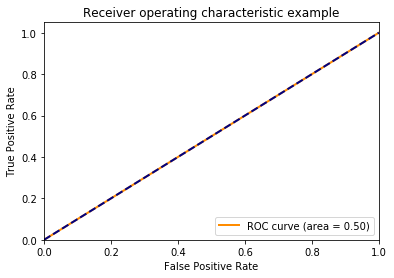

In [141]:
plotROC(fpr_XGB1_DILI1, tpr_XGB1_DILI1, roc_auc_score(B_test.iloc[:,0], y_xgb1_DILI1[:,0]))

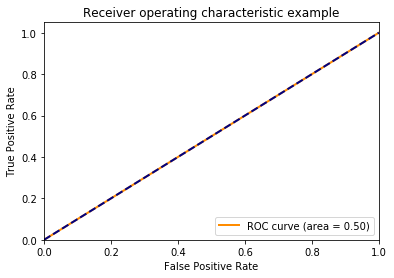

In [142]:
plotROC(fpr_XGB1_DILI3, tpr_XGB1_DILI3, roc_auc_score(B_test.iloc[:,1], y_xgb1_DILI3[:,0]))

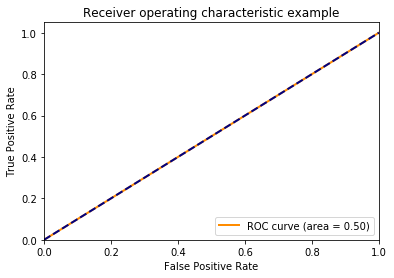

In [143]:
plotROC(fpr_XGB1_DILI5, tpr_XGB1_DILI5, roc_auc_score(B_test.iloc[:,2], y_xgb1_DILI5[:,0]))

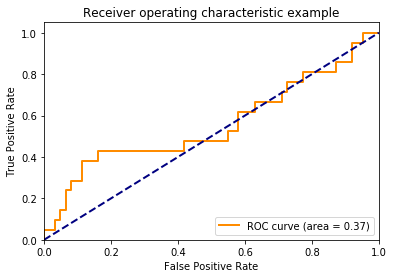

In [144]:
plotROC(fpr_XGB1_DILI6, tpr_XGB1_DILI6, roc_auc_score(B_test.iloc[:,3], y_xgb1_DILI6[:,0]))

#### Plot Confusion Matrices

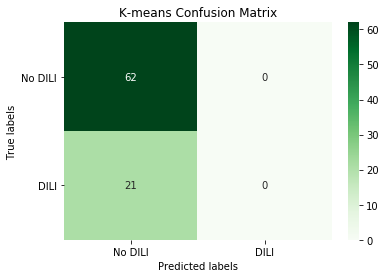

In [145]:
cM(B_test.iloc[:,0], p_xgb1_DILI1)

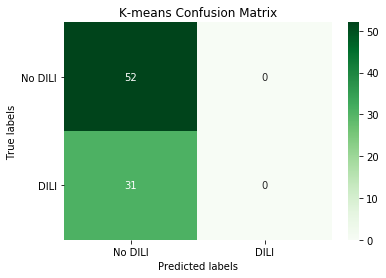

In [146]:
cM(B_test.iloc[:,1], p_xgb1_DILI3)

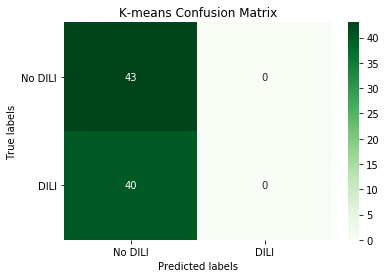

In [147]:
cM(B_test.iloc[:,2], p_xgb1_DILI5)

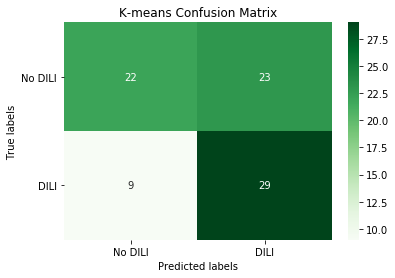

In [148]:
cM(B_test.iloc[:,3], p_xgb1_DILI6)

### With PCA

#### Hyperparameter Tuning

In [132]:
grid_params_XGB_pca = {
        'max_depth' : [4,5,6,7,8],    
        'booster': ['gbtree', 'gblinear', 'dart'],
        'n_estimators': [10,50,100,200,500],
        'reg_alpha': [0,1],
        'reg_lambda': [0,1],
        'gamma': [0,1]
}
A_train_pca = pca_3c.fit_transform(A_train)
    
XGB_result_DILI1_pca = rSearch(grid_params_XGB_pca, xgb.XGBClassifier(), A_train_pca, B_train['DILI1'])
XGB_result_DILI3_pca = rSearch(grid_params_XGB_pca, xgb.XGBClassifier(), A_train_pca, B_train['DILI3'])
XGB_result_DILI5_pca = rSearch(grid_params_XGB_pca, xgb.XGBClassifier(), A_train_pca, B_train['DILI5'])
XGB_result_DILI6_pca = rSearch(grid_params_XGB_pca, xgb.XGBClassifier(), A_train_pca, B_train['DILI6'])

print("DILI1")
print("Best Score: ", XGB_result_DILI1_pca.best_score_)
print("Best Estimator: ", XGB_result_DILI1_pca.best_estimator_)
print("Best Params: ", XGB_result_DILI1_pca.best_params_)

print("DILI3")
print("Best Score: ", XGB_result_DILI3_pca.best_score_)
print("Best Estimator: ", XGB_result_DILI3_pca.best_estimator_)
print("Best Params: ", XGB_result_DILI3_pca.best_params_)

print("DILI5")
print("Best Score: ", XGB_result_DILI5_pca.best_score_)
print("Best Estimator: ", XGB_result_DILI5_pca.best_estimator_)
print("Best Params: ", XGB_result_DILI5_pca.best_params_)

print("DILI6")
print("Best Score: ", XGB_result_DILI6_pca.best_score_)
print("Best Estimator: ", XGB_result_DILI6_pca.best_estimator_)
print("Best Params: ", XGB_result_DILI6_pca.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   35.7s finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   34.6s finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   33.7s finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 10 candidates, totalling 100 fits
DILI1
Best Score:  0.7831325301204819
Best Estimator:  XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.5, max_delta_step=None, max_depth=4,
       min_child_weight=None, missing=nan, monotone_constraints=None,
       n_estimators=50, n_jobs=0, num_parallel_tree=None,
       objective='binary:logistic', random_state=0, reg_alpha=1,
       reg_lambda=1, scale_pos_weight=1, subsample=None, tree_method=None,
       validate_parameters=False, verbosity=None)
Best Params:  {'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 50, 'max_depth': 4, 'gamma': 0, 'booster': 'gblinear'}
DILI3
Best Score:  0.6174698795180723
Best Estimator:  XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=N

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   20.3s finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [149]:
p_xgb2_DILI1, y_xgb2_DILI1, s_xgb2_DILI1,  cv_xgb2_DILI1 = xgb_PCA(A_train, #Training se
                                                                   A_test, #Test set
                                                                   B_train['DILI1'], #Training labels
                                                                   1, #PCA
                                                                   4, #max_depth
                                                                   'gblinear', #booster
                                                                   50, #n_estimators
                                                                   1, #reg_alpha
                                                                   1, #reg_lamba
                                                                   0 #gamma
                                                                  )
p_xgb2_DILI3, y_xgb2_DILI3, s_xgb2_DILI3,  cv_xgb2_DILI3 = xgb_PCA(A_train, 
                                                                   A_test, 
                                                                   B_train['DILI3'], 
                                                                   1,
                                                                   8,
                                                                   'gblinear',
                                                                   200,
                                                                   1,
                                                                   0,
                                                                   0
                                                                  )
p_xgb2_DILI5, y_xgb2_DILI5, s_xgb2_DILI5,  cv_xgb2_DILI5 = xgb_PCA(A_train, 
                                                                   A_test, 
                                                                   B_train['DILI5'], 
                                                                   1,
                                                                   4,
                                                                   'gbtree',
                                                                   50,
                                                                   1,
                                                                   1,
                                                                   0
                                                                  )
p_xgb2_DILI6, y_xgb2_DILI6, s_xgb2_DILI6,  cv_xgb2_DILI6 = xgb_PCA(A_train, 
                                                                   A_test, 
                                                                   B_train['DILI6'], 
                                                                   1,
                                                                   5,
                                                                   'gblinear',
                                                                   500,
                                                                   1,
                                                                   1,
                                                                   1
                                                                  )

Cross Validation result:  0.7829768270944741 number of kFold splits:  10
Cross Validation result:  0.6172905525846704 number of kFold splits:  10
Cross Validation result:  0.5427807486631016 number of kFold splits:  10
Cross Validation result:  0.5783422459893048 number of kFold splits:  10


#### Calculate Accuracy

In [150]:
print('XGB with PCA (DILI1): ', round(accuracy_score(B_test.iloc[:,0], p_xgb2_DILI1), 3))
print('XGB with PCA (DILI3): ', round(accuracy_score(B_test.iloc[:,1], p_xgb2_DILI3), 3))
print('XGB with PCA (DILI5): ', round(accuracy_score(B_test.iloc[:,2], p_xgb2_DILI5), 3))
print('XGB with PCA (DILI6): ', round(accuracy_score(B_test.iloc[:,3], p_xgb2_DILI6), 3))


XGB with PCA (DILI1):  0.747
XGB with PCA (DILI3):  0.627
XGB with PCA (DILI5):  0.47
XGB with PCA (DILI6):  0.386


#### Calculate Balanced Accuracy

In [151]:
print('XGB with PCA (DILI1): ', round(balanced_accuracy_score(B_test.iloc[:,0], p_xgb2_DILI1), 3))
print('XGB with PCA (DILI3): ', round(balanced_accuracy_score(B_test.iloc[:,1], p_xgb2_DILI3), 3))
print('XGB with PCA (DILI5): ', round(balanced_accuracy_score(B_test.iloc[:,2], p_xgb2_DILI5), 3))
print('XGB with PCA (DILI6): ', round(balanced_accuracy_score(B_test.iloc[:,3], p_xgb2_DILI6), 3))


XGB with PCA (DILI1):  0.5
XGB with PCA (DILI3):  0.5
XGB with PCA (DILI5):  0.464
XGB with PCA (DILI6):  0.409


#### Calculate Precision Score

In [152]:
print('XGB (PCA) Precision (DILI1): ', round(precision_score(B_test.iloc[:,0], p_xgb2_DILI1), 3))
print('XGB (PCA) Precision (DILI3): ', round(precision_score(B_test.iloc[:,1], p_xgb2_DILI3), 3))
print('XGB (PCA) Precision (DILI5): ', round(precision_score(B_test.iloc[:,2], p_xgb2_DILI5), 3))
print('XGB (PCA) Precision (DILI6): ', round(precision_score(B_test.iloc[:,3], p_xgb2_DILI6), 3))


XGB (PCA) Precision (DILI1):  0.0
XGB (PCA) Precision (DILI3):  0.0
XGB (PCA) Precision (DILI5):  0.429
XGB (PCA) Precision (DILI6):  0.4


/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Calculate F1 Score

In [325]:
print('XGB (PCA) F1 Score (DILI1): ', round(f1_score(B_test.iloc[:,0], p_xgb2_DILI1), 3))
print('XGB (PCA) F1 Score (DILI3): ', round(f1_score(B_test.iloc[:,1], p_xgb2_DILI3), 3))
print('XGB (PCA) F1 Score (DILI5): ', round(f1_score(B_test.iloc[:,2], p_xgb2_DILI5), 3))
print('XGB (PCA) F1 Score (DILI6): ', round(f1_score(B_test.iloc[:,3], p_xgb2_DILI6), 3))


XGB (PCA) F1 Score (DILI1):  0.0
XGB (PCA) F1 Score (DILI3):  0.0
XGB (PCA) F1 Score (DILI5):  0.353
XGB (PCA) F1 Score (DILI6):  0.505


#### Calculate ROC AUC Score 

In [153]:
print('XGB (PCA) ROC AUC Score (DILI1): ', round(roc_auc_score(B_test.iloc[:,0], y_xgb2_DILI1[:,0]), 3))
print('XGB (PCA) ROC AUC Score (DILI3): ', round(roc_auc_score(B_test.iloc[:,1], y_xgb2_DILI3[:,0]), 3))
print('XGB (PCA) ROC AUC Score (DILI5): ', round(roc_auc_score(B_test.iloc[:,2], y_xgb2_DILI5[:,0]), 3))
print('XGB (PCA) ROC AUC Score (DILI6): ', round(roc_auc_score(B_test.iloc[:,3], y_xgb2_DILI6[:,0]), 3))


XGB (PCA) ROC AUC Score (DILI1):  0.525
XGB (PCA) ROC AUC Score (DILI3):  0.416
XGB (PCA) ROC AUC Score (DILI5):  0.52
XGB (PCA) ROC AUC Score (DILI6):  0.633


#### Calculate FPR and TPR and plot ROC curve

In [154]:
fpr_XGB2_DILI1, tpr_XGB2_DILI1, _ = roc_curve(B_test.iloc[:,0], y_xgb2_DILI1[:,0])
fpr_XGB2_DILI3, tpr_XGB2_DILI3, _ = roc_curve(B_test.iloc[:,0], y_xgb2_DILI3[:,0])
fpr_XGB2_DILI5, tpr_XGB2_DILI5, _ = roc_curve(B_test.iloc[:,0], y_xgb2_DILI5[:,0])
fpr_XGB2_DILI6, tpr_XGB2_DILI6, _ = roc_curve(B_test.iloc[:,0], y_xgb2_DILI6[:,0])


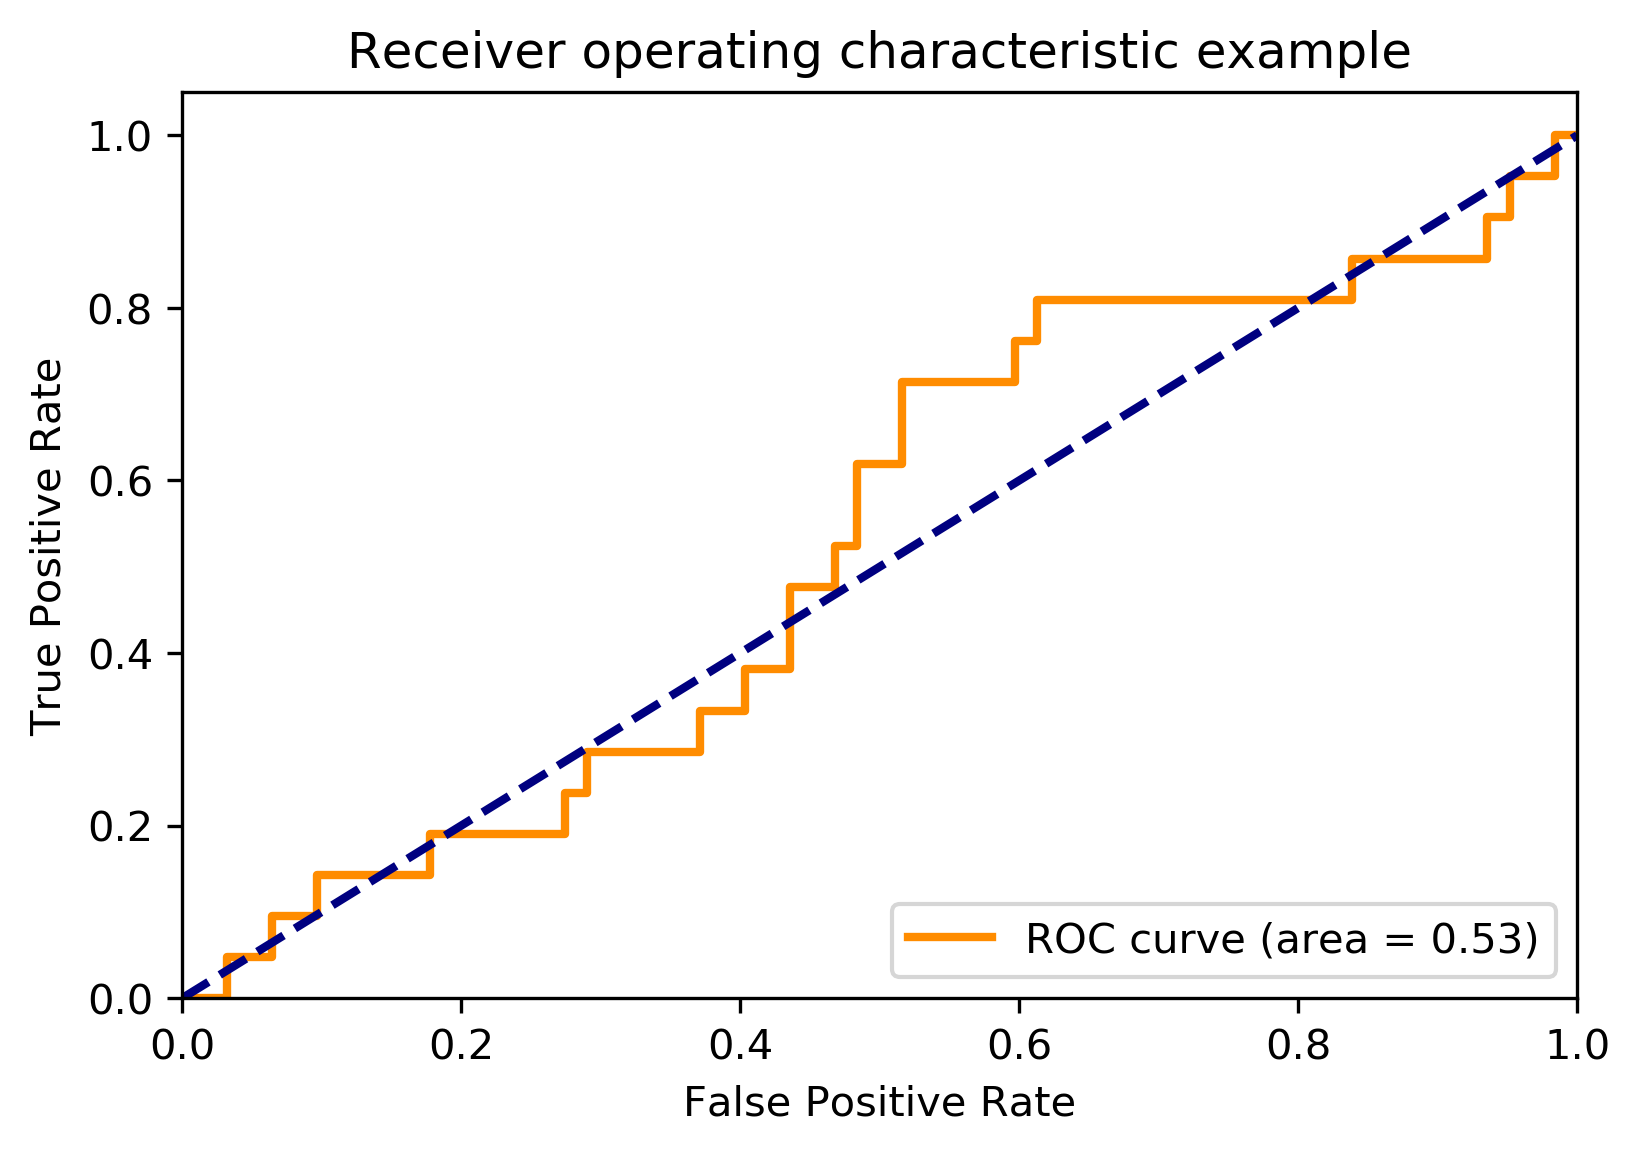

In [270]:
plotROC(fpr_XGB2_DILI1, tpr_XGB2_DILI1, roc_auc_score(B_test.iloc[:,0], y_xgb2_DILI1[:,0]))

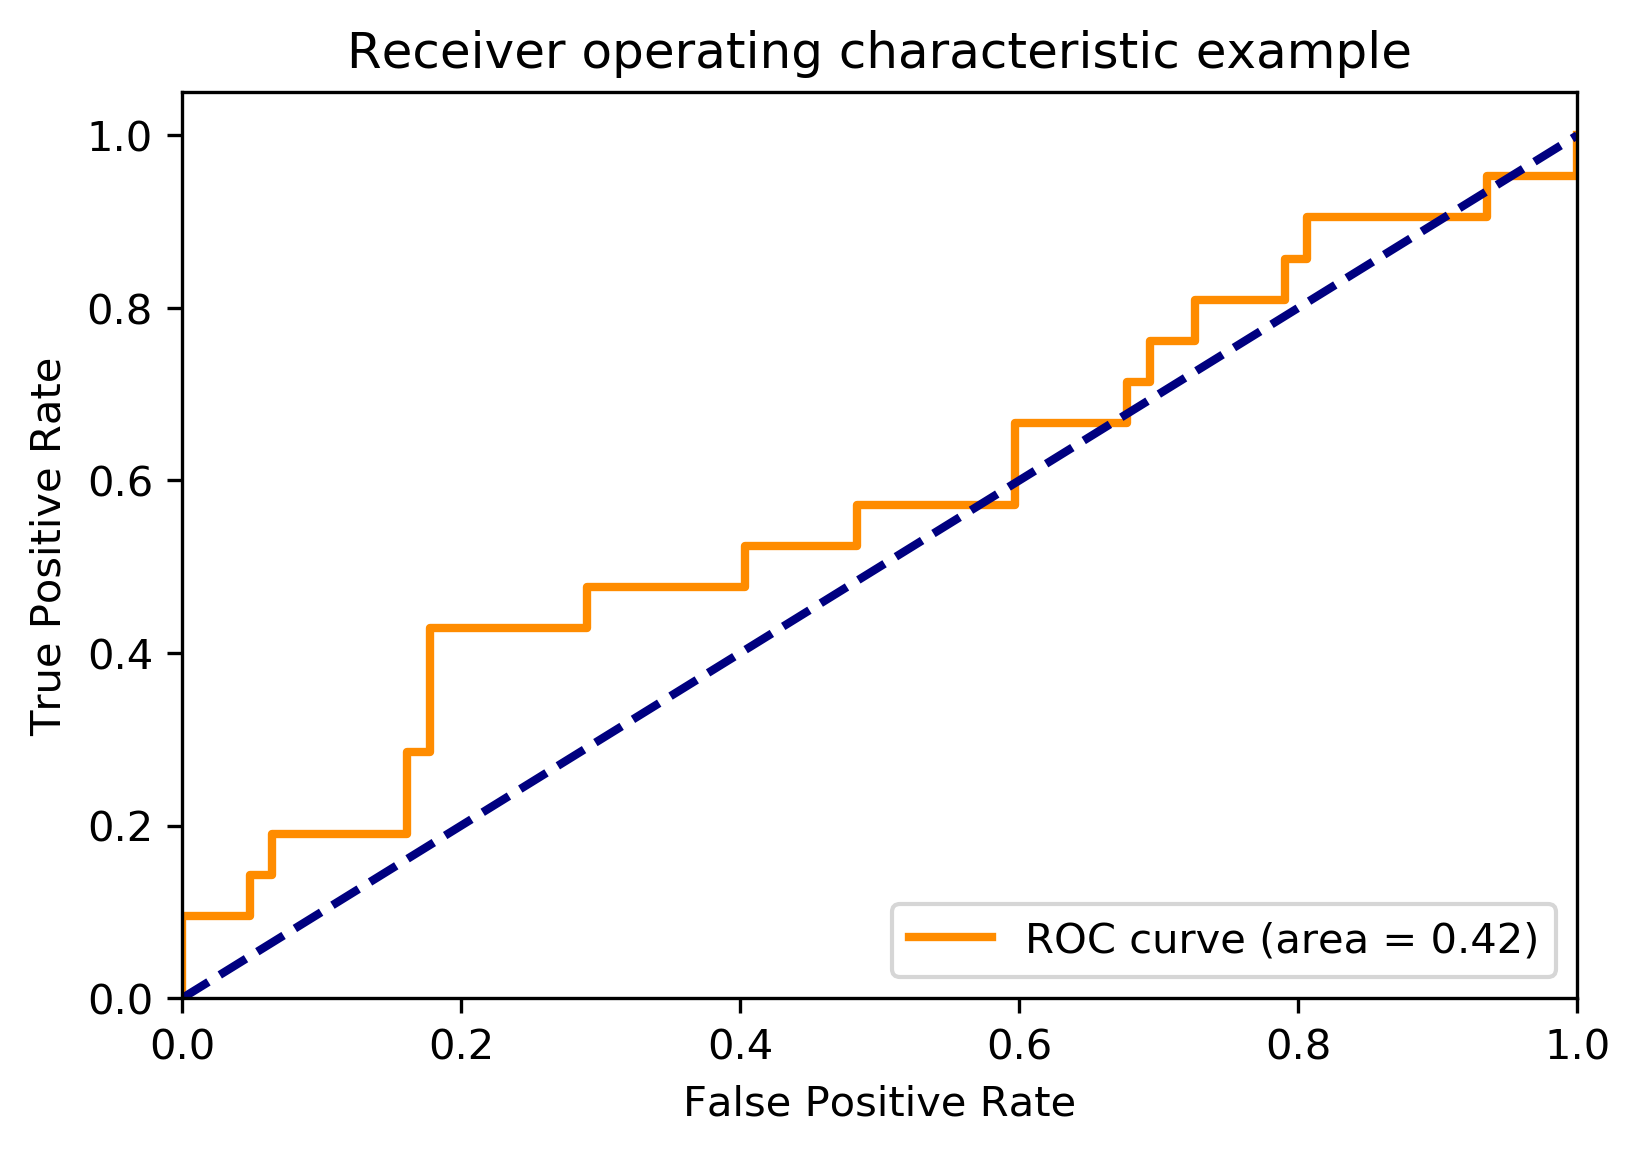

In [271]:
plotROC(fpr_XGB2_DILI3, tpr_XGB2_DILI3, roc_auc_score(B_test.iloc[:,1], y_xgb2_DILI3[:,0]))

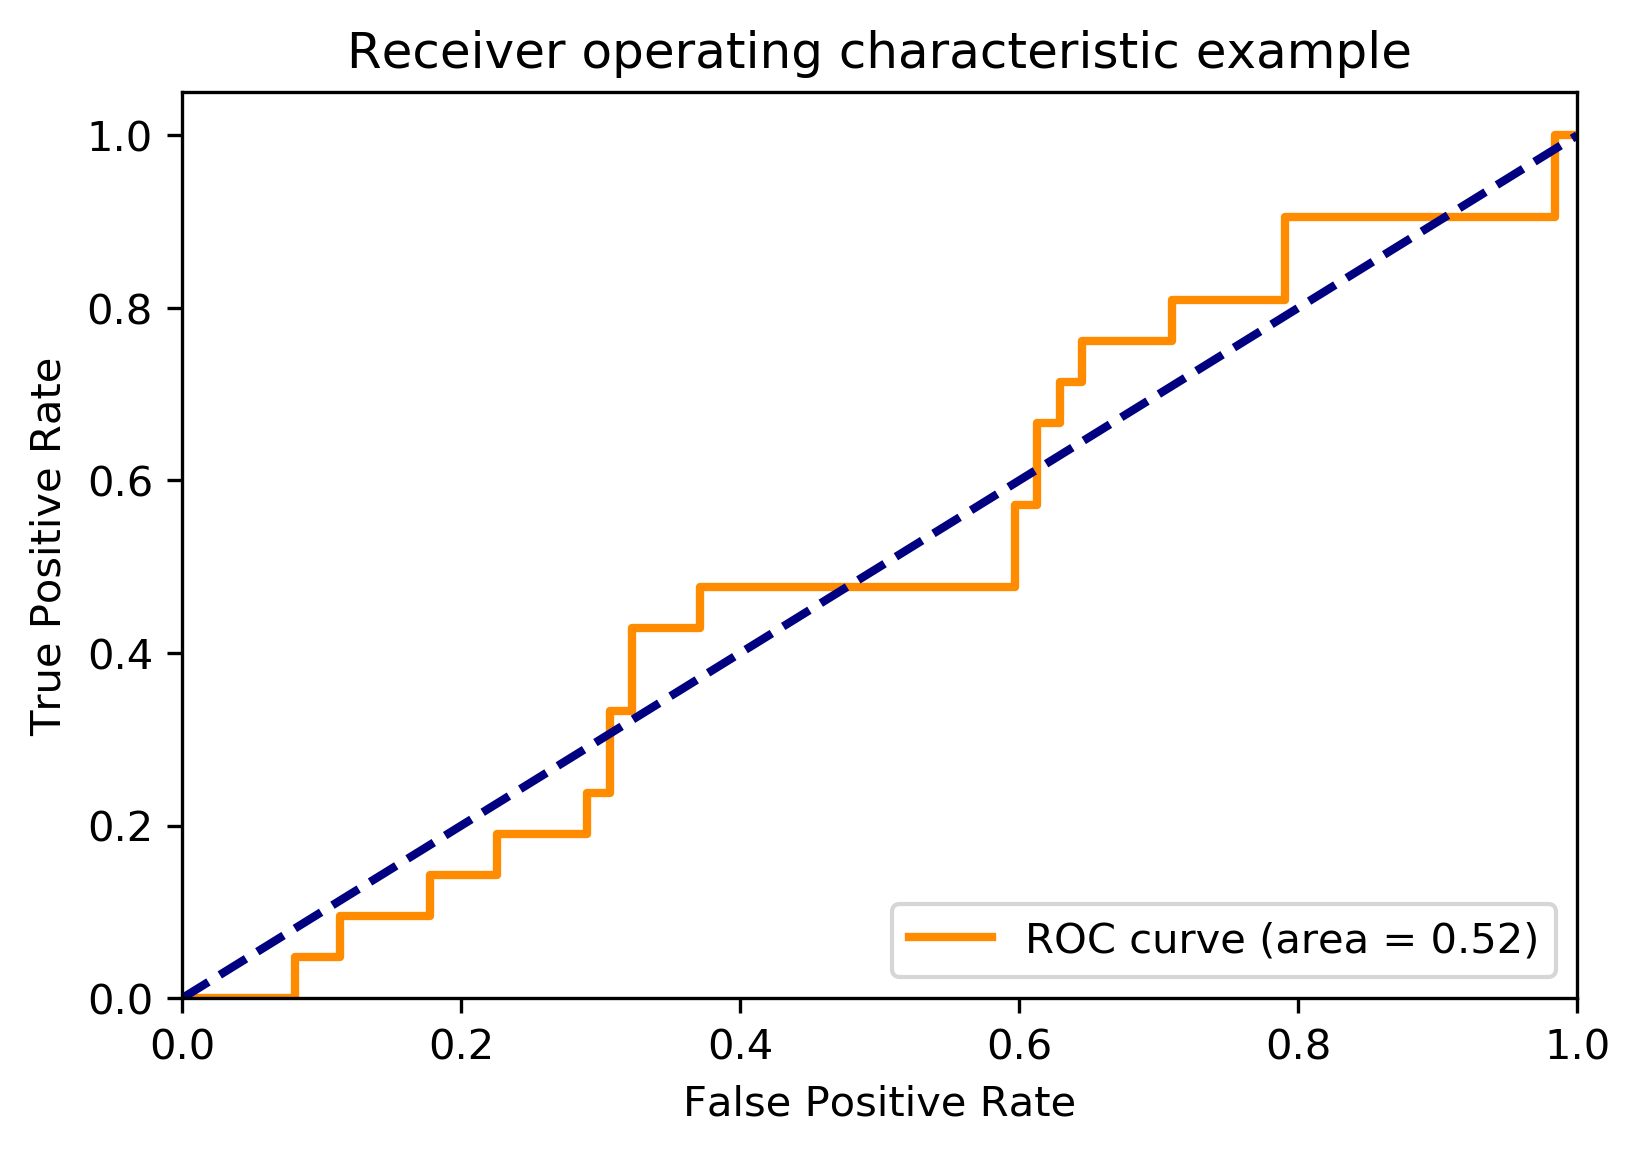

In [272]:
plotROC(fpr_XGB2_DILI5, tpr_XGB2_DILI5, roc_auc_score(B_test.iloc[:,2], y_xgb2_DILI5[:,0]))

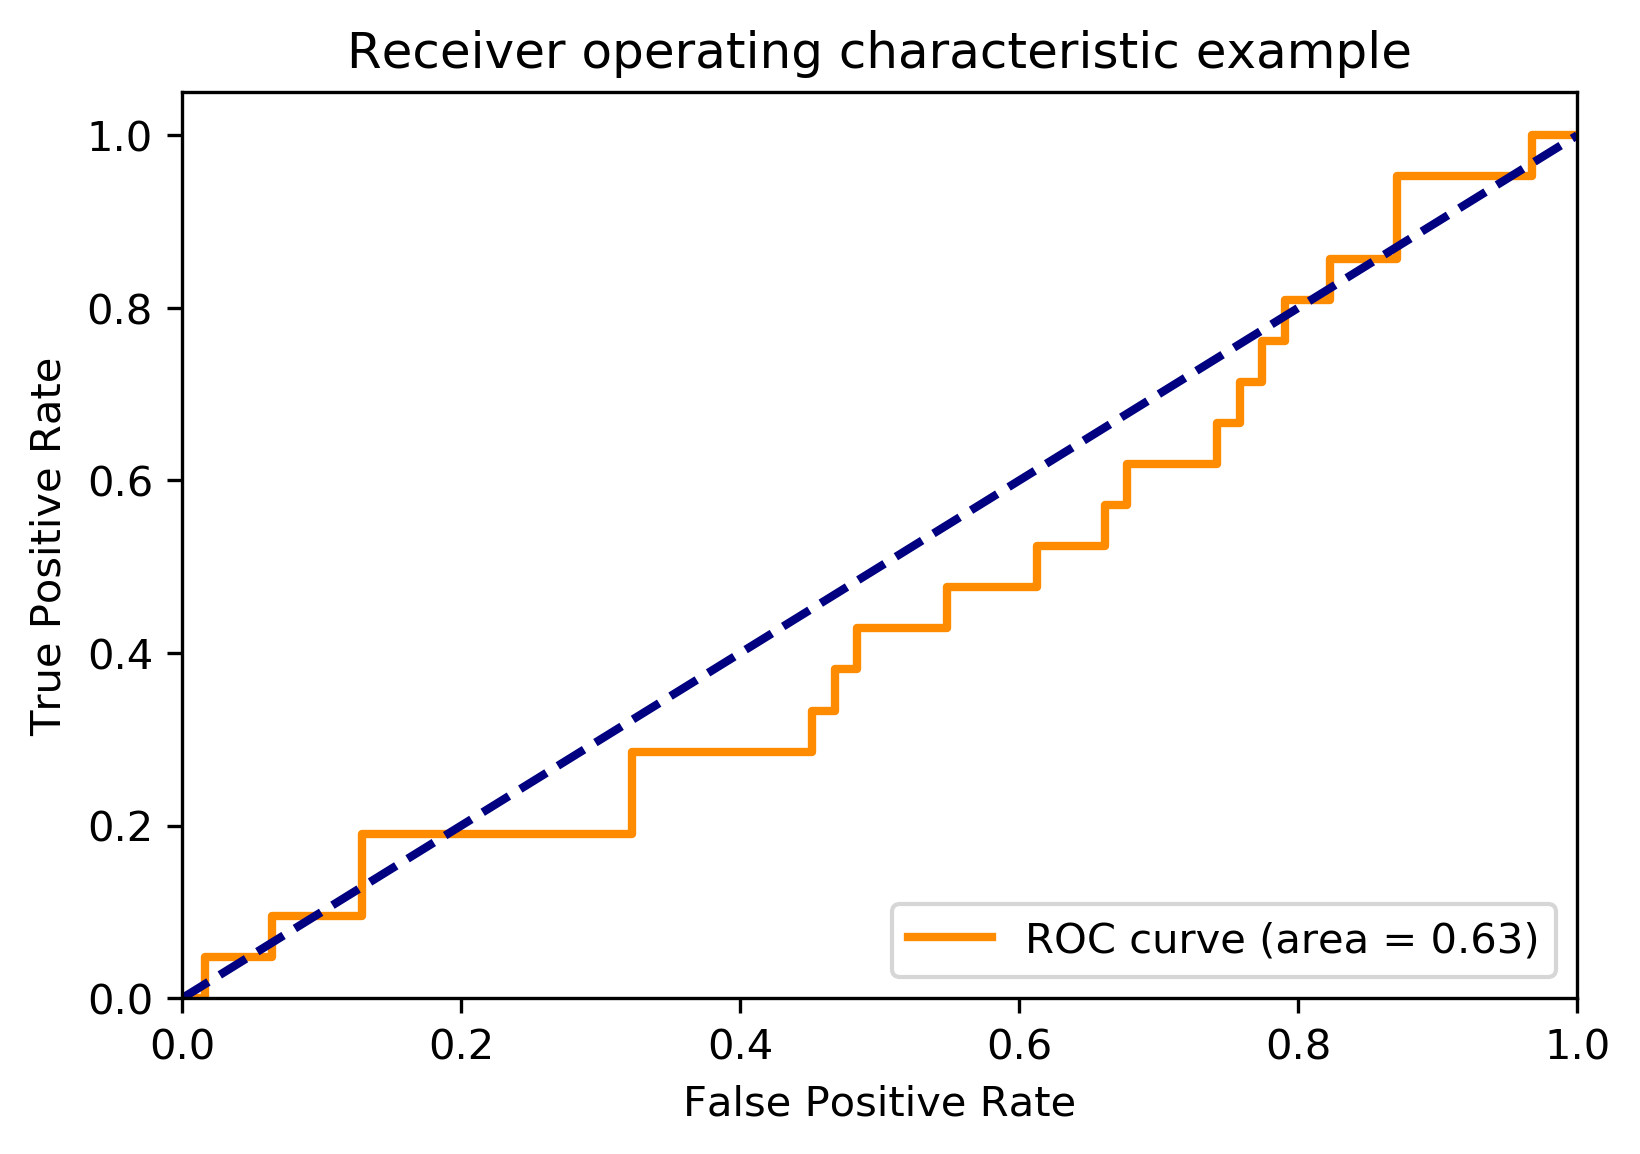

In [273]:
plotROC(fpr_XGB2_DILI6, tpr_XGB2_DILI6, roc_auc_score(B_test.iloc[:,3], y_xgb2_DILI6[:,0]))

#### Plot Confusion Matrices

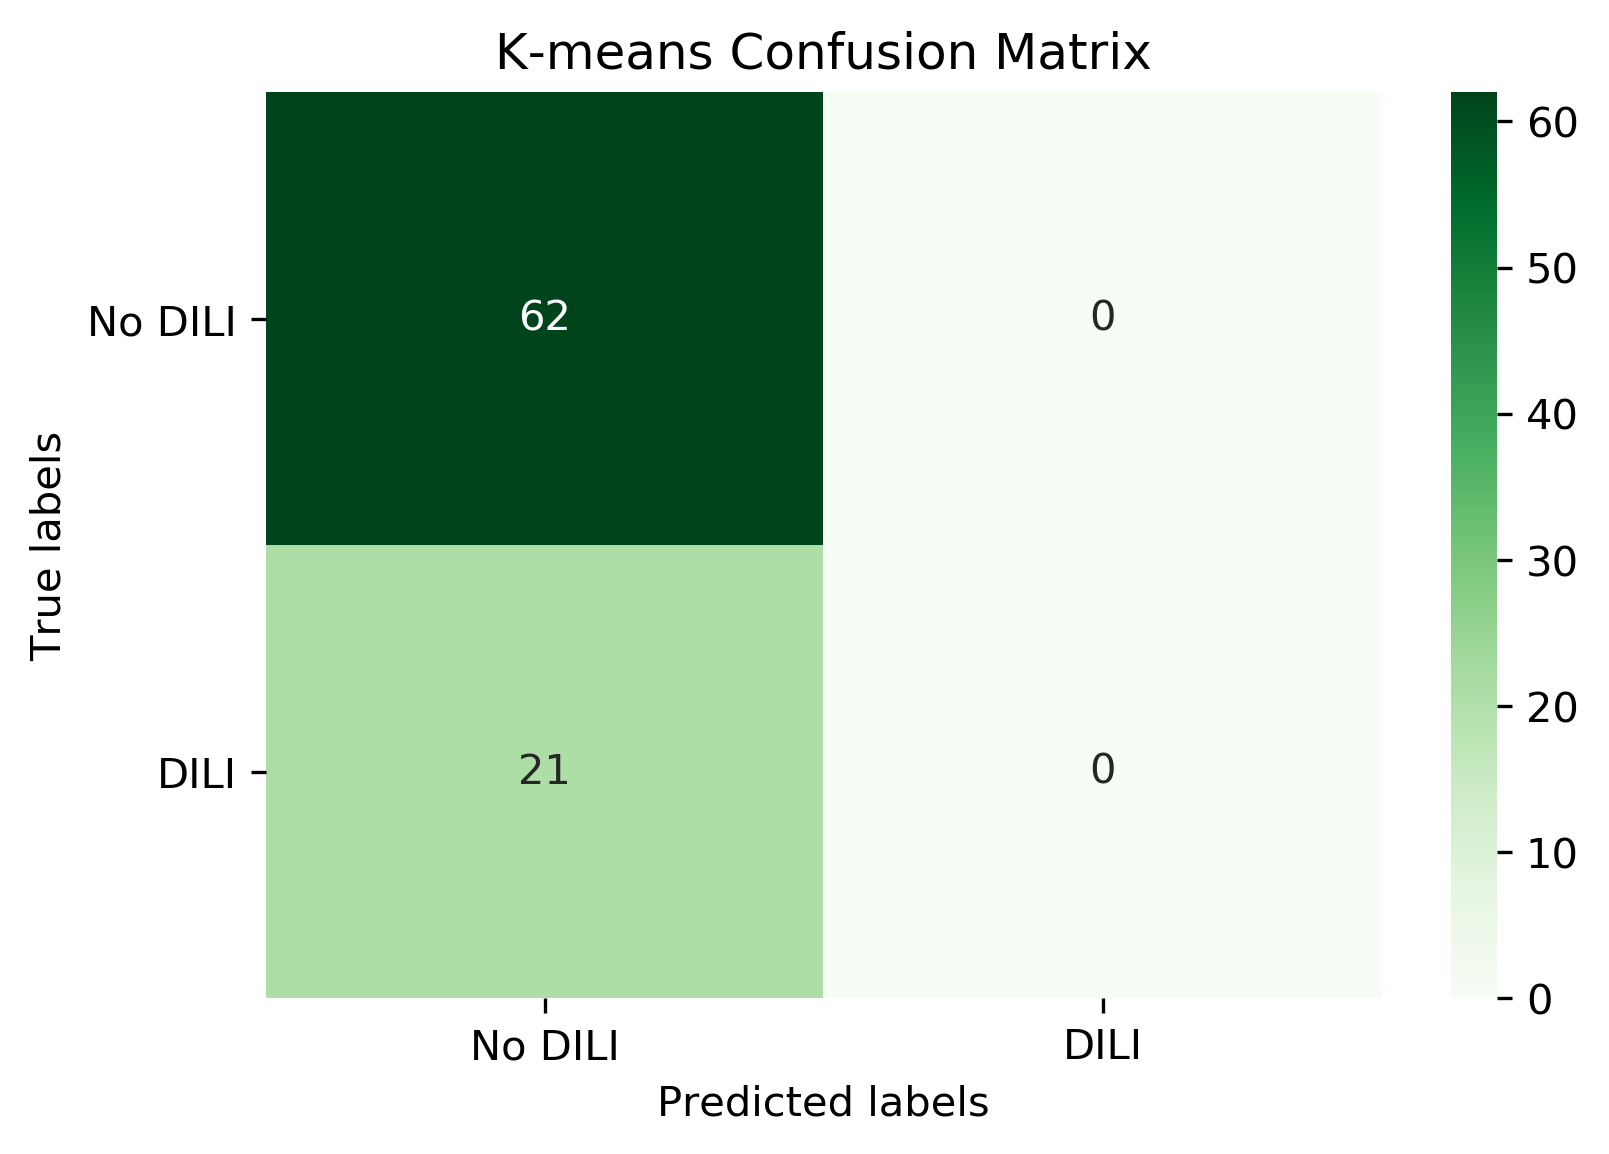

In [274]:
cM(B_test.iloc[:,0], p_xgb2_DILI1)

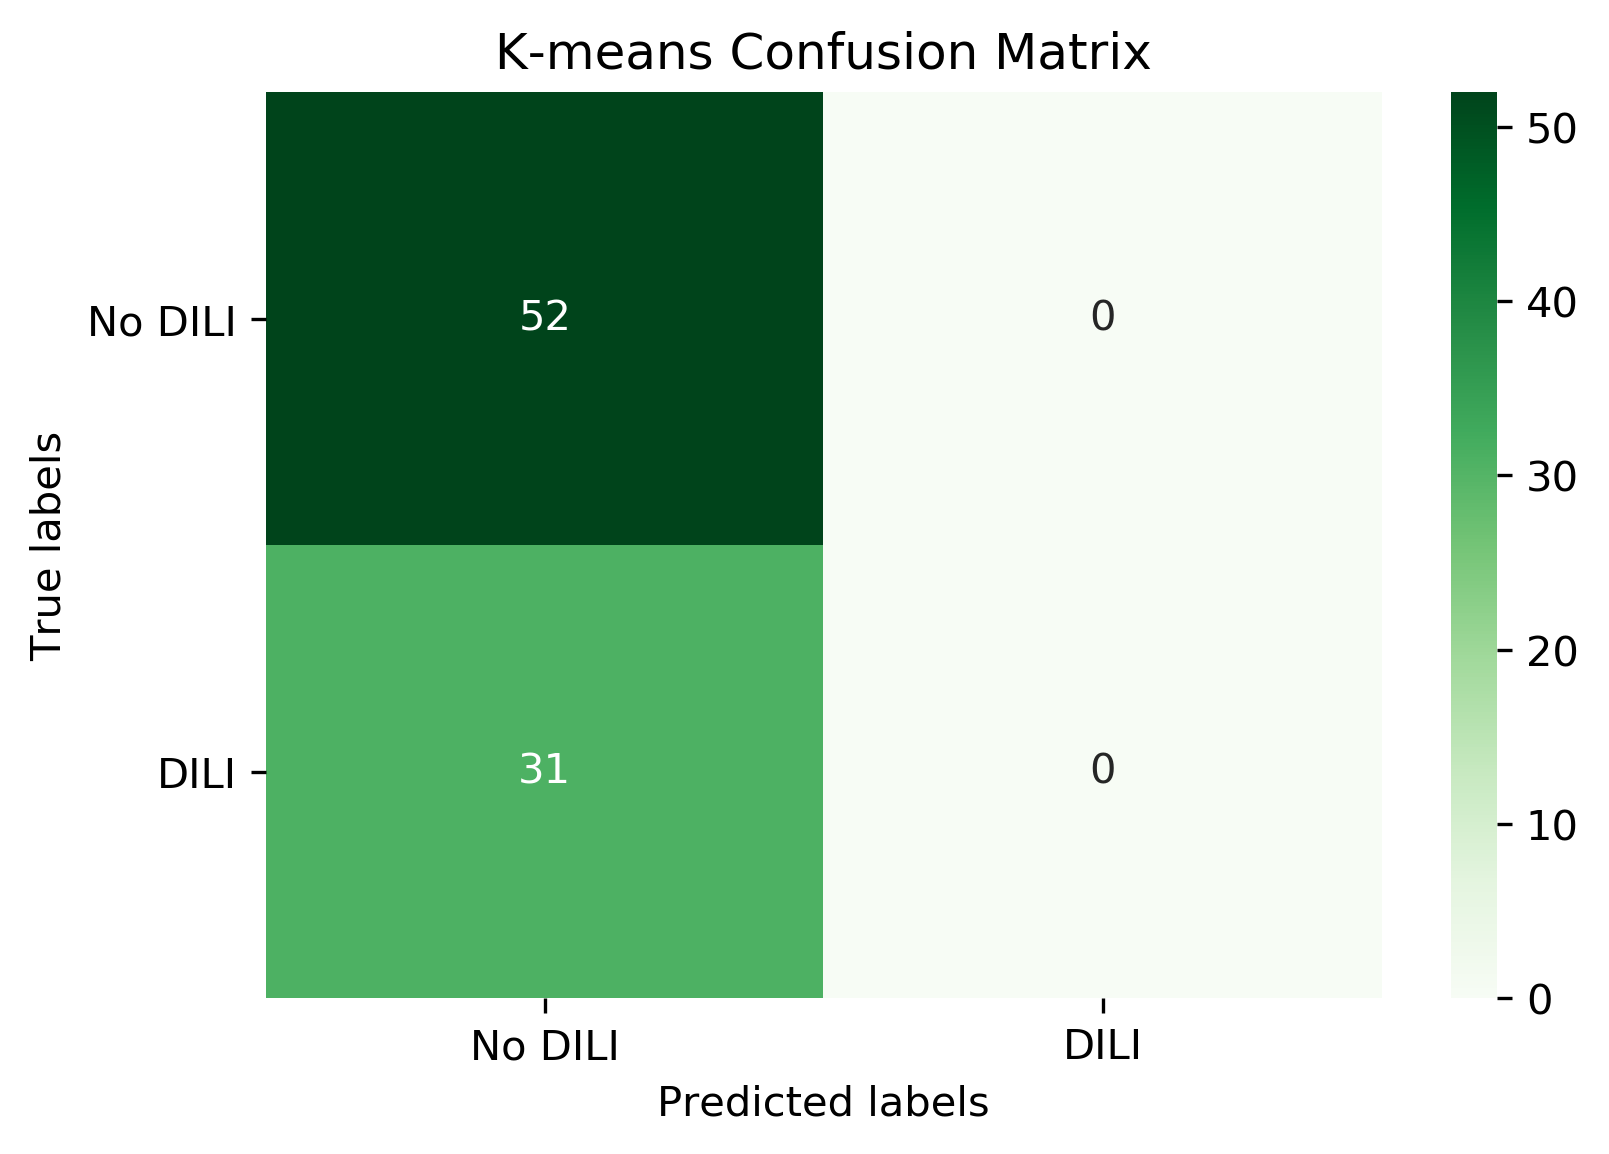

In [275]:
cM(B_test.iloc[:,1], p_xgb2_DILI3)

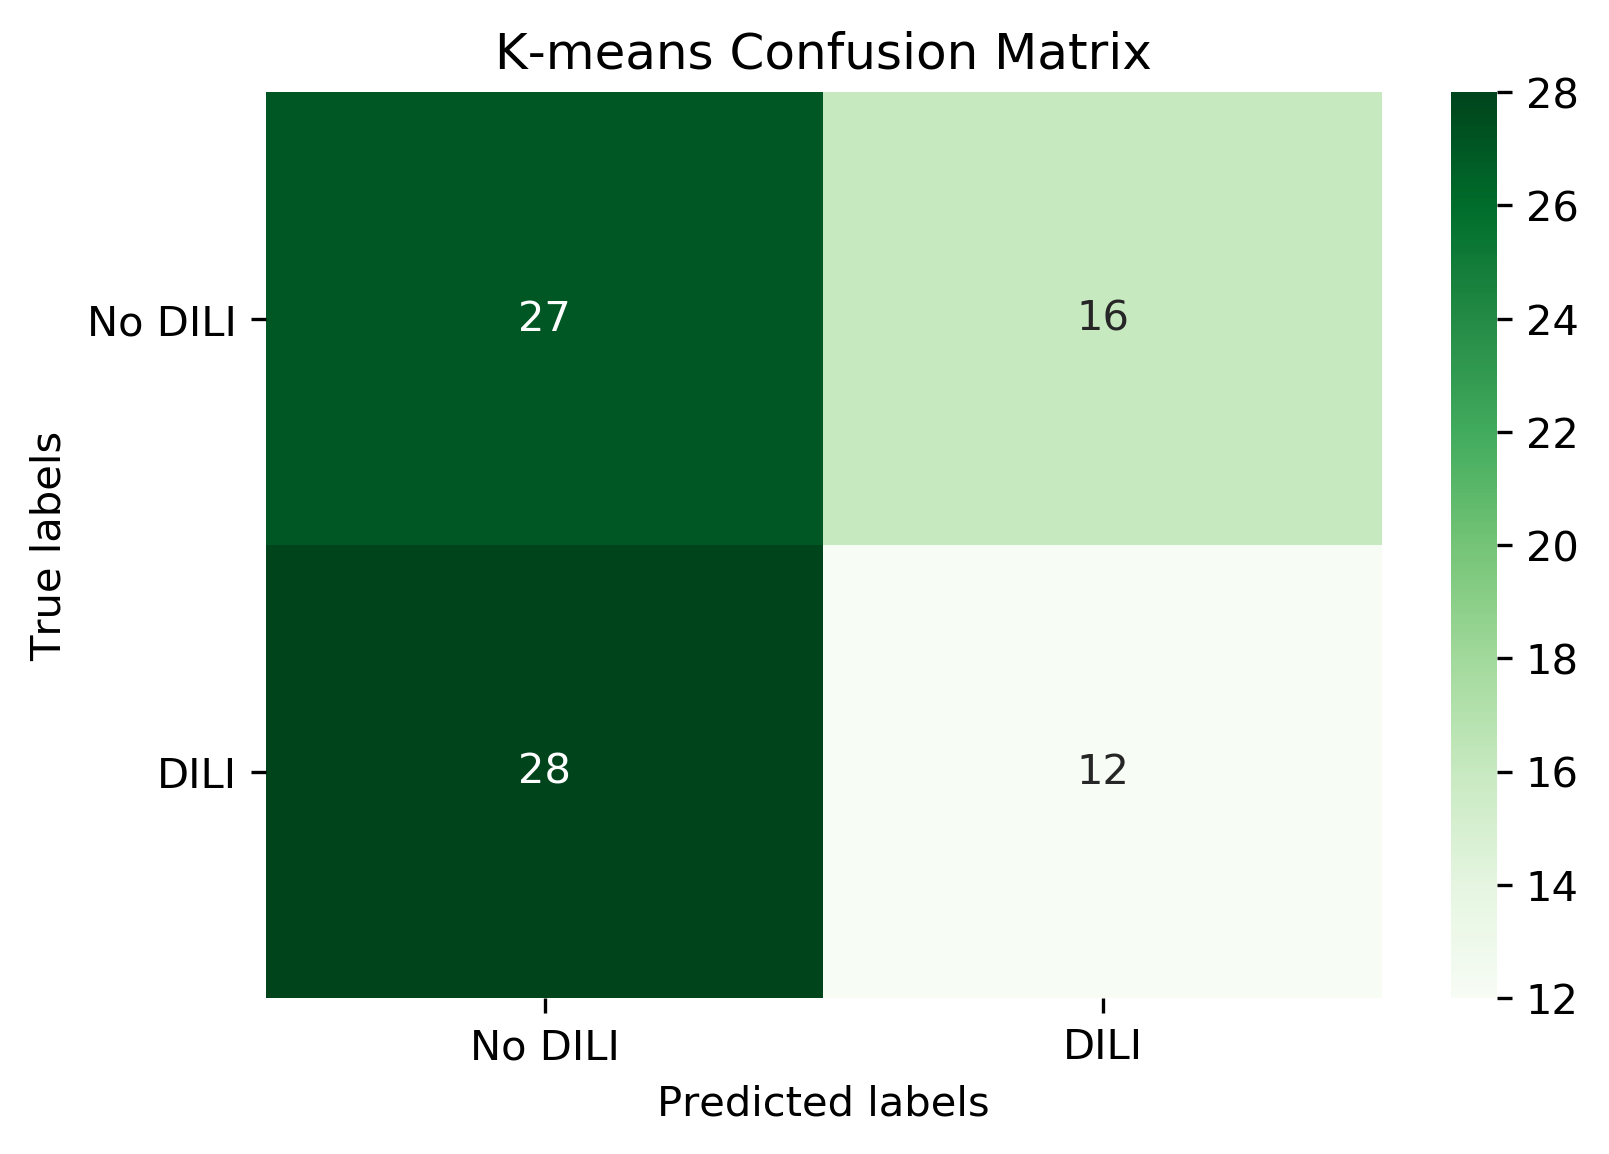

In [276]:
cM(B_test.iloc[:,2], p_xgb2_DILI5)

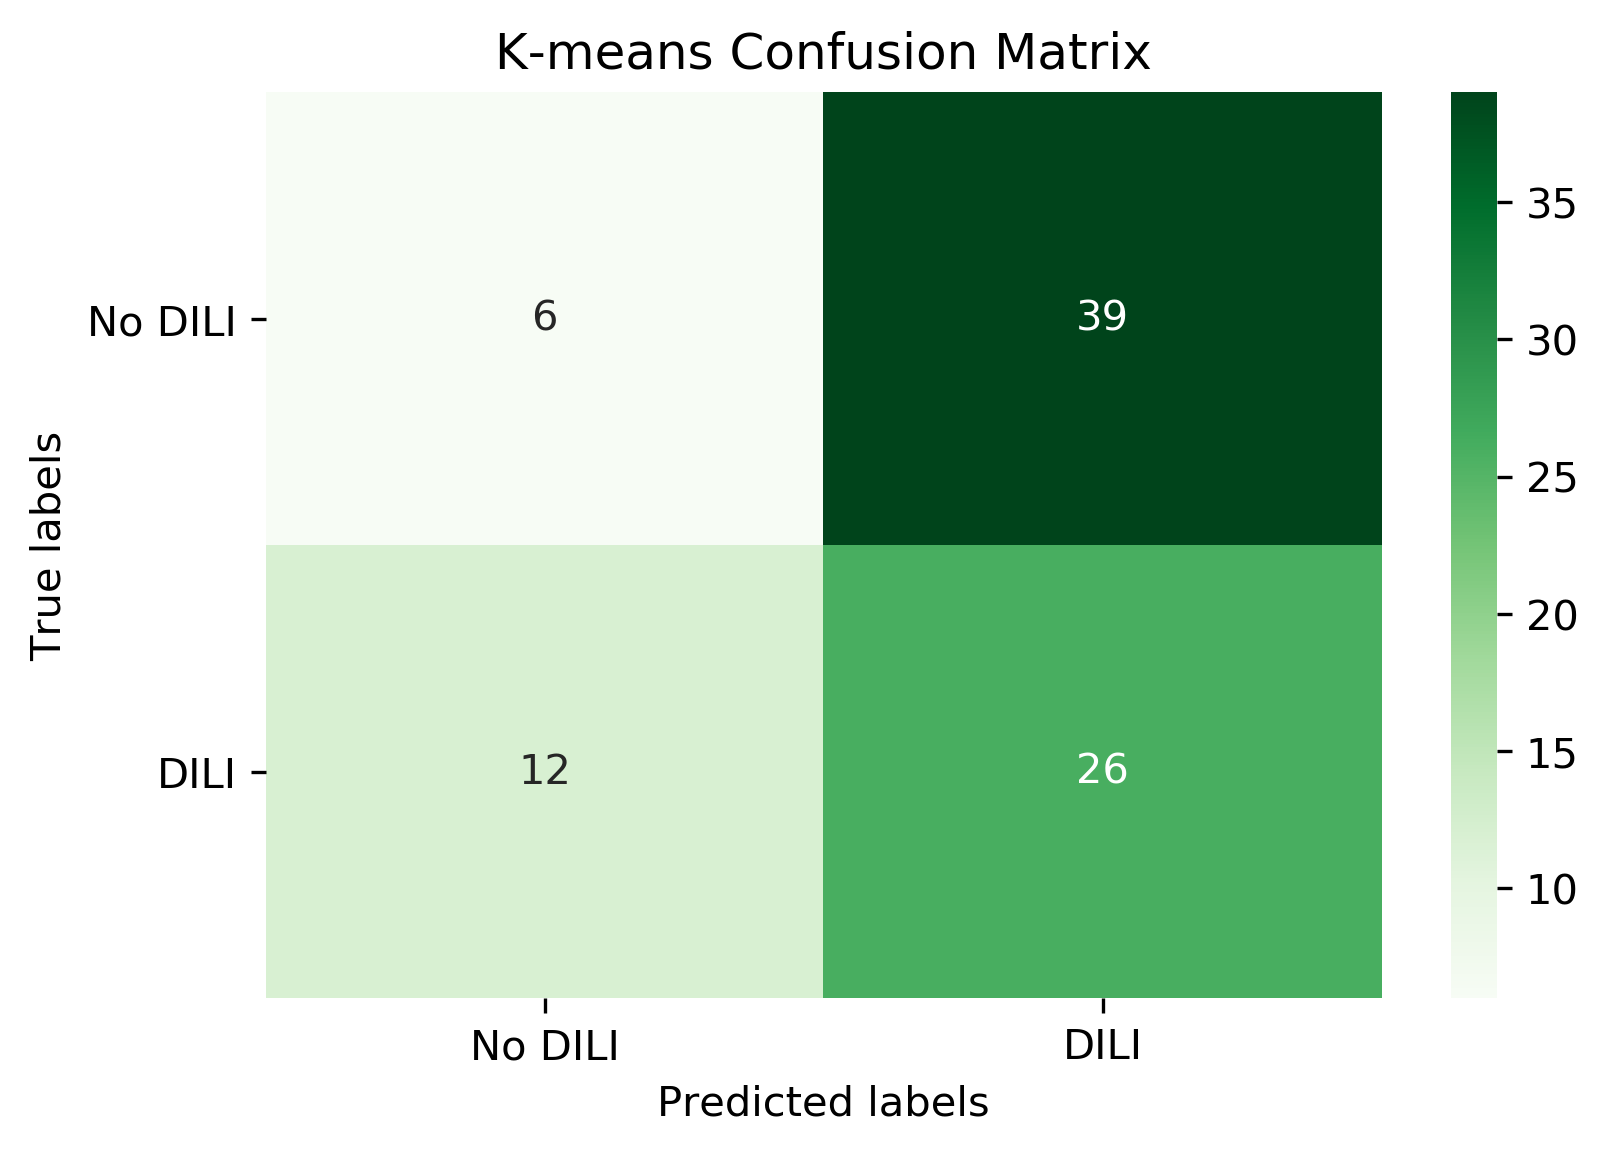

In [277]:
cM(B_test.iloc[:,3], p_xgb2_DILI6)

### Ensemble  Soft-Voting Classification

#### Hyperparameter Tuning

In [166]:
grid_params_ens = {
        'weights': [(1,2,2,2,2,2),(1,1,1,1,1,1)]
}

#Initialise Models with hypertuned parameters for different DILI targets

#Logistic Regression
A1_DILI1 = linear_model.LogisticRegression(penalty = 'l1', 
                                           C = 0.001)
A1_DILI3 = linear_model.LogisticRegression(penalty = 'l1',
                                           C = 0.001)
A1_DILI5 = linear_model.LogisticRegression(penalty = 'l1',
                                           C = 0.001)
A1_DILI6 = linear_model.LogisticRegression(penalty = 'l1',
                                           C = 1)

#Support vector machine
A2_DILI1 = svm.SVC(probability=True, C = 0.01, 
                   gamma = 'scale')
A2_DILI3 = svm.SVC(probability=True, C = 1, 
                   gamma = 'auto')
A2_DILI5 = svm.SVC(probability=True, C = 100, 
                   gamma = 'scale')
A2_DILI6 = svm.SVC(probability=True, C = 100, 
                   gamma = 'scale')

#Naive Bayes
A3 = GaussianNB()

#K-Nearest Neighbours
A4_DILI1 = KNeighborsClassifier(n_neighbors = 11, weights = 'uniform', 
                                metric = 'manhattan') 
A4_DILI3 = KNeighborsClassifier(n_neighbors = 51, weights = 'uniform', 
                                metric = 'euclidean')
A4_DILI5 = KNeighborsClassifier(n_neighbors = 11, weights = 'uniform', 
                                metric = 'euclidean')
A4_DILI6 = KNeighborsClassifier(n_neighbors = 5, weights = 'uniform', 
                                metric = 'euclidean')

#Multilayer Perceptron
A5_DILI1 = MLPClassifier(hidden_layer_sizes = (100,100,100), activation = 'relu', 
                         learning_rate = 'constant')
A5_DILI3 = MLPClassifier(hidden_layer_sizes = (20,20,20), activation = 'relu', 
                         learning_rate = 'invscaling')
A5_DILI5 = MLPClassifier(hidden_layer_sizes = (20,20,20), activation = 'relu', 
                         learning_rate = 'invscaling')
A5_DILI6 = MLPClassifier(hidden_layer_sizes = (20,20,20), activation = 'relu', 
                         learning_rate = 'invscaling')

#XGB
A6_DILI1 = xgb.XGBClassifier(max_depth = 6, booster = 'gblinear', n_estimators = 10, 
                             reg_alpha = 1, reg_lambda = 0, gamma = 1)
A6_DILI3 = xgb.XGBClassifier(max_depth = 5, booster = 'gblinear', n_estimators = 500, 
                             reg_alpha = 1, reg_lambda = 0, gamma = 1)
A6_DILI5 = xgb.XGBClassifier(max_depth = 6, booster = 'gblinear', n_estimators = 500, 
                             reg_alpha = 1, reg_lambda = 0, gamma = 0)
A6_DILI6 = xgb.XGBClassifier(max_depth = 7, booster = 'dart', n_estimators = 10, 
                             reg_alpha = 0, reg_lambda = 1, gamma = 1)


#Build estimators according to DILI
estimators_DILI1 = []
estimators_DILI3 = []
estimators_DILI5 = []
estimators_DILI6 = []

estimators_DILI1.append(('logistic', A1_DILI1))
estimators_DILI1.append(('svm', A2_DILI1))
estimators_DILI1.append(('Gaussian', A3))
estimators_DILI1.append(('KNeighbors', A4_DILI1))
estimators_DILI1.append(('MLP', A5_DILI1))
estimators_DILI1.append(('XGB', A6_DILI1))

estimators_DILI3.append(('logistic', A1_DILI3))
estimators_DILI3.append(('svm', A2_DILI3))
estimators_DILI3.append(('Gaussian', A3))
estimators_DILI3.append(('KNeighbors', A4_DILI3))
estimators_DILI3.append(('MLP', A5_DILI3))
estimators_DILI3.append(('XGB', A6_DILI3))

estimators_DILI5.append(('logistic', A1_DILI5))
estimators_DILI5.append(('svm', A2_DILI5))
estimators_DILI5.append(('Gaussian', A3))
estimators_DILI5.append(('KNeighbors', A4_DILI5))
estimators_DILI5.append(('MLP', A5_DILI5))
estimators_DILI5.append(('XGB', A6_DILI5))

estimators_DILI6.append(('logistic', A1_DILI6))
estimators_DILI6.append(('svm', A2_DILI6))
estimators_DILI6.append(('Gaussian', A3))
estimators_DILI6.append(('KNeighbors', A4_DILI6))
estimators_DILI6.append(('MLP', A5_DILI6))
estimators_DILI6.append(('XGB', A6_DILI6))

#Randomised CV search to tune parameters for ensemble searching
ens_result_DILI1 = gSearch(grid_params_ens, VotingClassifier(estimators_DILI1), A_train, B_train['DILI1'])
ens_result_DILI3 = gSearch(grid_params_ens, VotingClassifier(estimators_DILI3), A_train, B_train['DILI3'])
ens_result_DILI5 = gSearch(grid_params_ens, VotingClassifier(estimators_DILI5), A_train, B_train['DILI5'])
ens_result_DILI6 = gSearch(grid_params_ens, VotingClassifier(estimators_DILI6), A_train, B_train['DILI6'])

print("DILI1")
print("Best Score: ", ens_result_DILI1.best_score_)
print("Best Estimator: ", ens_result_DILI1.best_estimator_)
print("Best Params: ", ens_result_DILI1.best_params_)

print("DILI3")
print("Best Score: ", ens_result_DILI3.best_score_)
print("Best Estimator: ", ens_result_DILI3.best_estimator_)
print("Best Params: ", ens_result_DILI3.best_params_)

print("DILI5")
print("Best Score: ", ens_result_DILI5.best_score_)
print("Best Estimator: ", ens_result_DILI5.best_estimator_)
print("Best Params: ", ens_result_DILI5.best_params_)

print("DILI6")
print("Best Score: ", ens_result_DILI6.best_score_)
print("Best Estimator: ", ens_result_DILI6.best_estimator_)
print("Best Params: ", ens_result_DILI6.best_params_)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/p

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/p

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/p

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/p

DILI1
Best Score:  0.7831325301204819
Best Estimator:  VotingClassifier(estimators=[('logistic', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('svm',...s_weight=None, subsample=None,
       tree_method=None, validate_parameters=False, verbosity=None))],
         flatten_transform=None, n_jobs=None, voting='hard',
         weights=(1, 2, 2, 2, 2, 2))
Best Params:  {'voting': 'hard', 'weights': (1, 2, 2, 2, 2, 2)}
DILI3
Best Score:  0.6234939759036144
Best Estimator:  VotingClassifier(estimators=[('logistic', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False

In [168]:
def ensemble(X_train, X_test, y_train, estimators, v, w):
    ensemble = VotingClassifier(estimators, voting = v, weights = w)
    
    ensemble.fit(X_train, y_train)
    score = ensemble.score(X_train, y_train)
    predictions = ensemble.predict(X_test)
    y_prob = ensemble.predict_proba(X_test)
    
    cross_Val = crossVal(ensemble, X_train, y_train, 10)


    return(predictions, y_prob, score, cross_Val)

In [170]:
p_ens_DILI1, y_ens_DILI1, s_ens_DILI1, cv_ens_DILI1 = ensemble(A_train, 
                                                               A_test, 
                                                               B_train['DILI1'],
                                                               estimators_DILI1, #estimators
                                                               'soft', #voting
                                                               (1, 2, 2, 2, 2, 2) #weights
                                                              )
p_ens_DILI3, y_ens_DILI3, s_ens_DILI3, cv_ens_DILI3 = ensemble(A_train, 
                                                               A_test, 
                                                               B_train['DILI3'],
                                                               estimators_DILI3, 
                                                               'soft', 
                                                                (1, 2, 2, 2, 2, 2)
                                                              )
p_ens_DILI5, y_ens_DILI5, s_ens_DILI5, cv_ens_DILI5 = ensemble(A_train, 
                                                               A_test, 
                                                               B_train['DILI5'],
                                                               estimators_DILI5, 
                                                               'soft', 
                                                              (1, 2, 2, 2, 2, 2)
                                                              )
p_ens_DILI6, y_ens_DILI6, s_ens_DILI6, cv_ens_DILI6 = ensemble(A_train, 
                                                               A_test, 
                                                               B_train['DILI6'],
                                                               estimators_DILI6, 
                                                               'soft', 
                                                               (1, 2, 2, 2, 2, 2) 
                                                              )


/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

Cross Validation result:  0.7345811051693405 number of kFold splits:  10


/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

Cross Validation result:  0.5933155080213904 number of kFold splits:  10


/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

Cross Validation result:  0.5004456327985739 number of kFold splits:  10


/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

Cross Validation result:  0.6055258467023172 number of kFold splits:  10


#### Calculate Accuracy

In [171]:
print('Ensemble (DILI1): ', round(accuracy_score(B_test.iloc[:,0], p_ens_DILI1), 3))
print('Ensemble (DILI3): ', round(accuracy_score(B_test.iloc[:,1], p_ens_DILI3), 3))
print('Ensemble (DILI5): ', round(accuracy_score(B_test.iloc[:,2], p_ens_DILI5), 3))
print('Ensemble (DILI6): ', round(accuracy_score(B_test.iloc[:,3], p_ens_DILI6), 3))

Ensemble (DILI1):  0.747
Ensemble (DILI3):  0.59
Ensemble (DILI5):  0.458
Ensemble (DILI6):  0.711


#### Calculate Balanced Accuracy 

In [172]:
print('Ensemble (DILI1): ', round(balanced_accuracy_score(B_test.iloc[:,0], p_ens_DILI1), 3))
print('Ensemble (DILI3): ', round(balanced_accuracy_score(B_test.iloc[:,1], p_ens_DILI3), 3))
print('Ensemble (DILI5): ', round(balanced_accuracy_score(B_test.iloc[:,2], p_ens_DILI5), 3))
print('Ensemble (DILI6): ', round(balanced_accuracy_score(B_test.iloc[:,3], p_ens_DILI6), 3))

Ensemble (DILI1):  0.5
Ensemble (DILI3):  0.523
Ensemble (DILI5):  0.458
Ensemble (DILI6):  0.709


#### Calculate Precision Score 

In [173]:
print('Ensemble (DILI1): ', round(precision_score(B_test.iloc[:,0], p_ens_DILI1), 3))
print('Ensemble (DILI3): ', round(precision_score(B_test.iloc[:,1], p_ens_DILI3), 3))
print('Ensemble (DILI5): ', round(precision_score(B_test.iloc[:,2], p_ens_DILI5), 3))
print('Ensemble (DILI6): ', round(precision_score(B_test.iloc[:,3], p_ens_DILI6), 3))

Ensemble (DILI1):  0.0
Ensemble (DILI3):  0.421
Ensemble (DILI5):  0.442
Ensemble (DILI6):  0.684


/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Calculate F1 Score

In [326]:
print('ENS F1 Score (DILI1): ', round(f1_score(B_test.iloc[:,0], p_ens_DILI1), 3))
print('ENS F1 Score (DILI3): ', round(f1_score(B_test.iloc[:,1], p_ens_DILI3), 3))
print('ENS F1 Score (DILI5): ', round(f1_score(B_test.iloc[:,2], p_ens_DILI5), 3))
print('ENS F1 Score (DILI6): ', round(f1_score(B_test.iloc[:,3], p_ens_DILI6), 3))


ENS F1 Score (DILI1):  0.0
ENS F1 Score (DILI3):  0.32
ENS F1 Score (DILI5):  0.458
ENS F1 Score (DILI6):  0.684


#### Calculate ROC AUC Score 

In [174]:
print('Ensemble ROC AUC Score (DILI1): ', round(roc_auc_score(B_test.iloc[:,0], y_ens_DILI1[:,0]), 3))
print('Ensemble ROC AUC Score (DILI3): ', round(roc_auc_score(B_test.iloc[:,1], y_ens_DILI3[:,0]), 3))
print('Ensemble ROC AUC Score (DILI5): ', round(roc_auc_score(B_test.iloc[:,2], y_ens_DILI5[:,0]), 3))
print('Ensemble ROC AUC Score (DILI6): ', round(roc_auc_score(B_test.iloc[:,3], y_ens_DILI6[:,0]), 3))

Ensemble ROC AUC Score (DILI1):  0.365
Ensemble ROC AUC Score (DILI3):  0.542
Ensemble ROC AUC Score (DILI5):  0.614
Ensemble ROC AUC Score (DILI6):  0.32


#### Calculate FPR and TPR and plot ROC curve

In [175]:
fpr_ens_DILI1, tpr_ens_DILI1, _ = roc_curve(B_test.iloc[:,0], y_ens_DILI1[:,0])
fpr_ens_DILI3, tpr_ens_DILI3, _ = roc_curve(B_test.iloc[:,0], y_ens_DILI3[:,0])
fpr_ens_DILI5, tpr_ens_DILI5, _ = roc_curve(B_test.iloc[:,0], y_ens_DILI5[:,0])
fpr_ens_DILI6, tpr_ens_DILI6, _ = roc_curve(B_test.iloc[:,0], y_ens_DILI6[:,0])

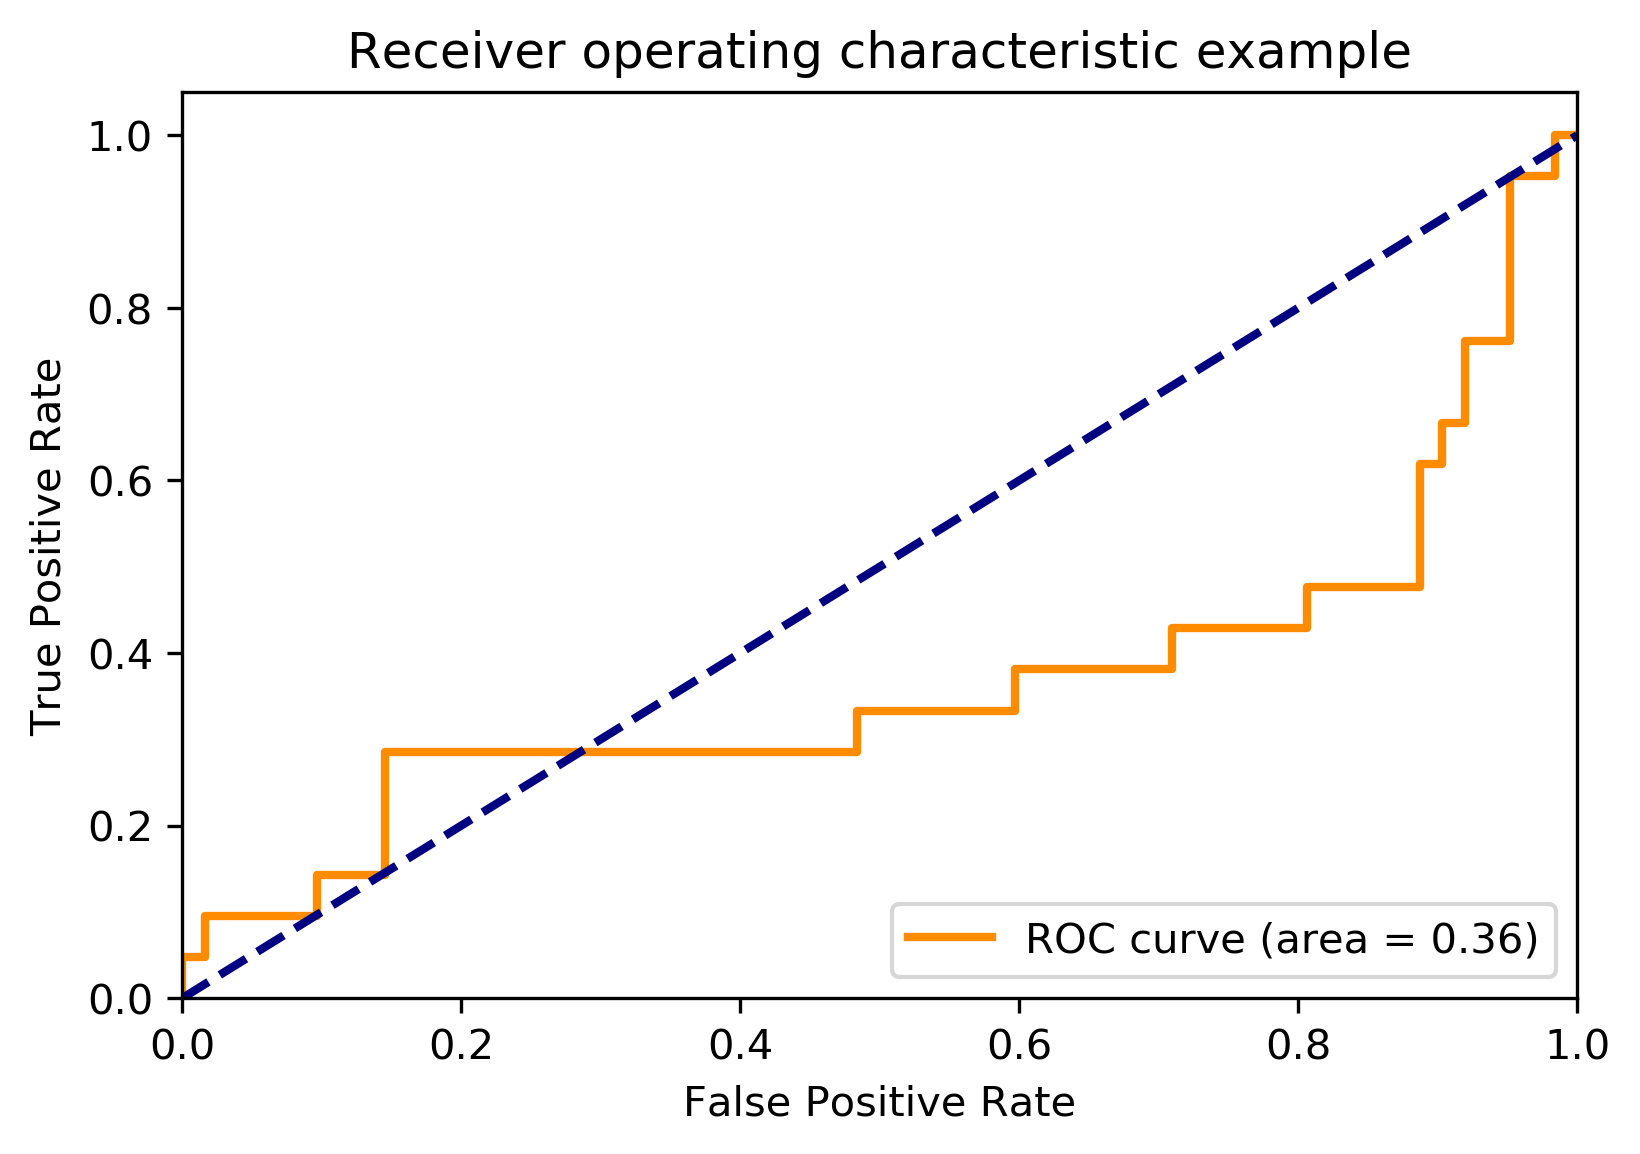

In [278]:
plotROC(fpr_ens_DILI1, tpr_ens_DILI1, roc_auc_score(B_test.iloc[:,0], y_ens_DILI1[:,0]))

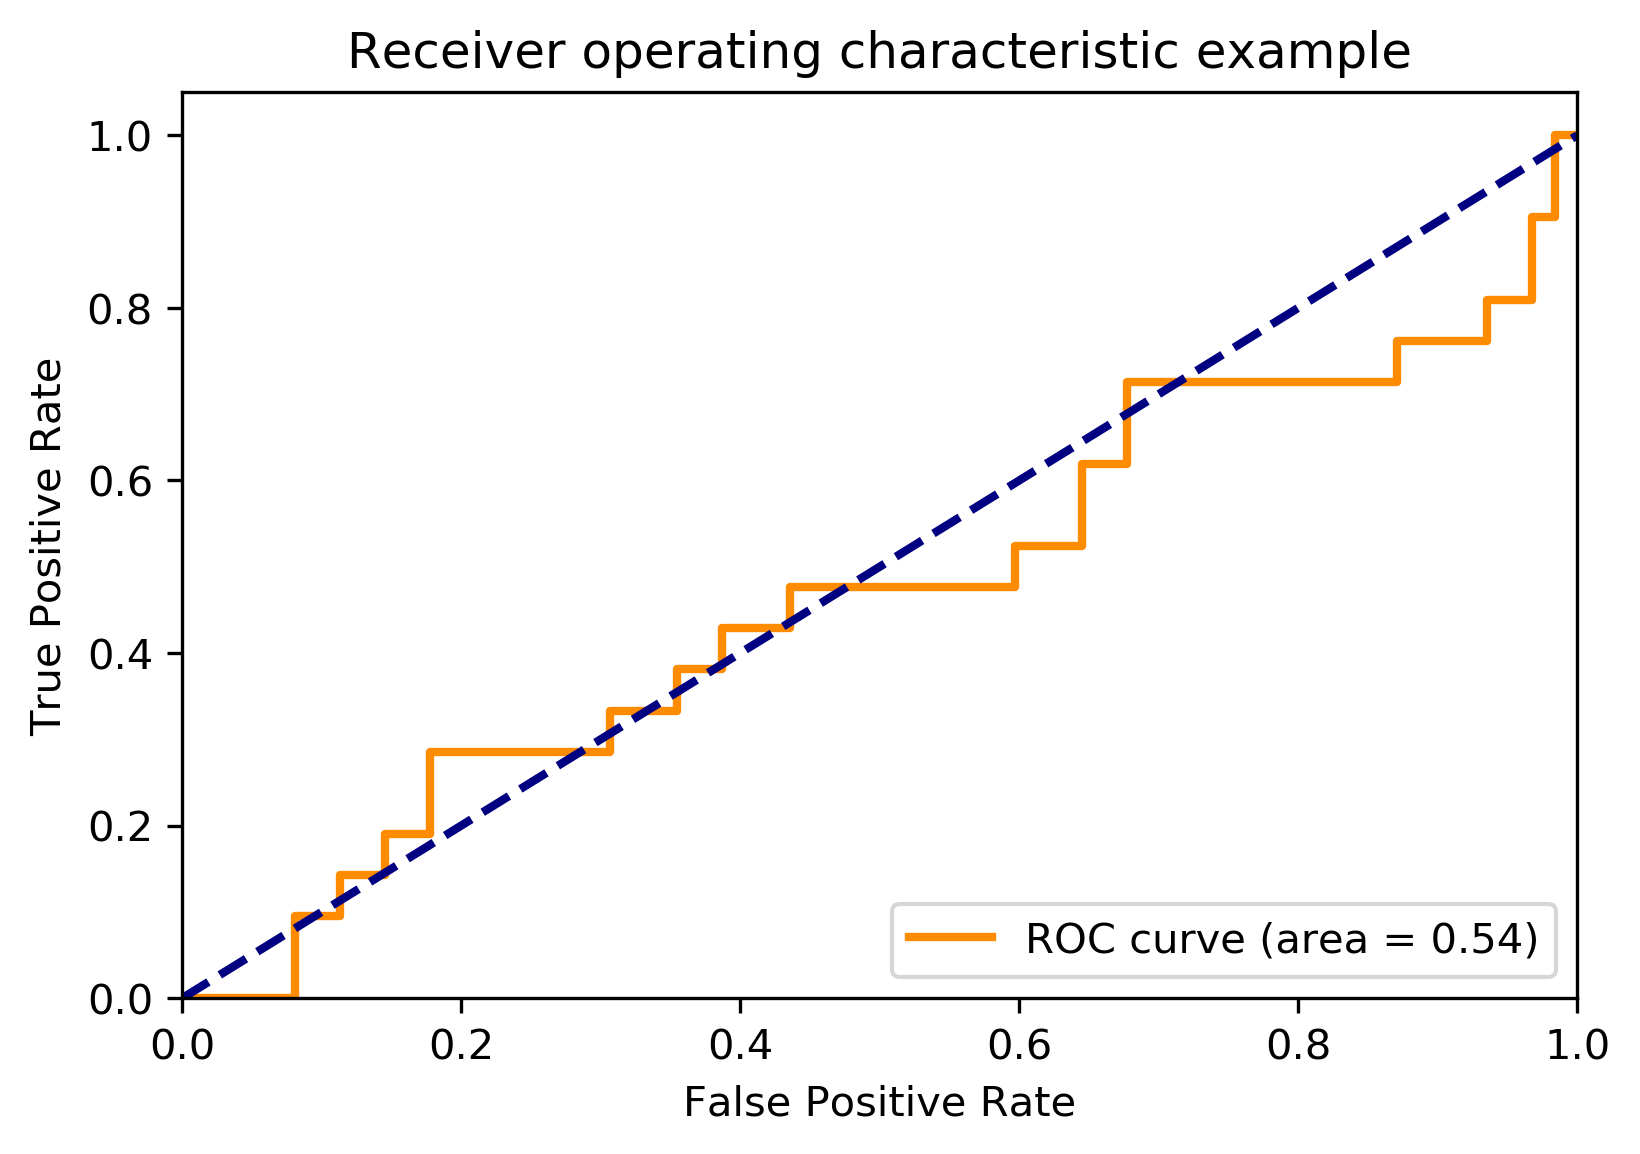

In [279]:
plotROC(fpr_ens_DILI3, tpr_ens_DILI3, roc_auc_score(B_test.iloc[:,1], y_ens_DILI3[:,0]))

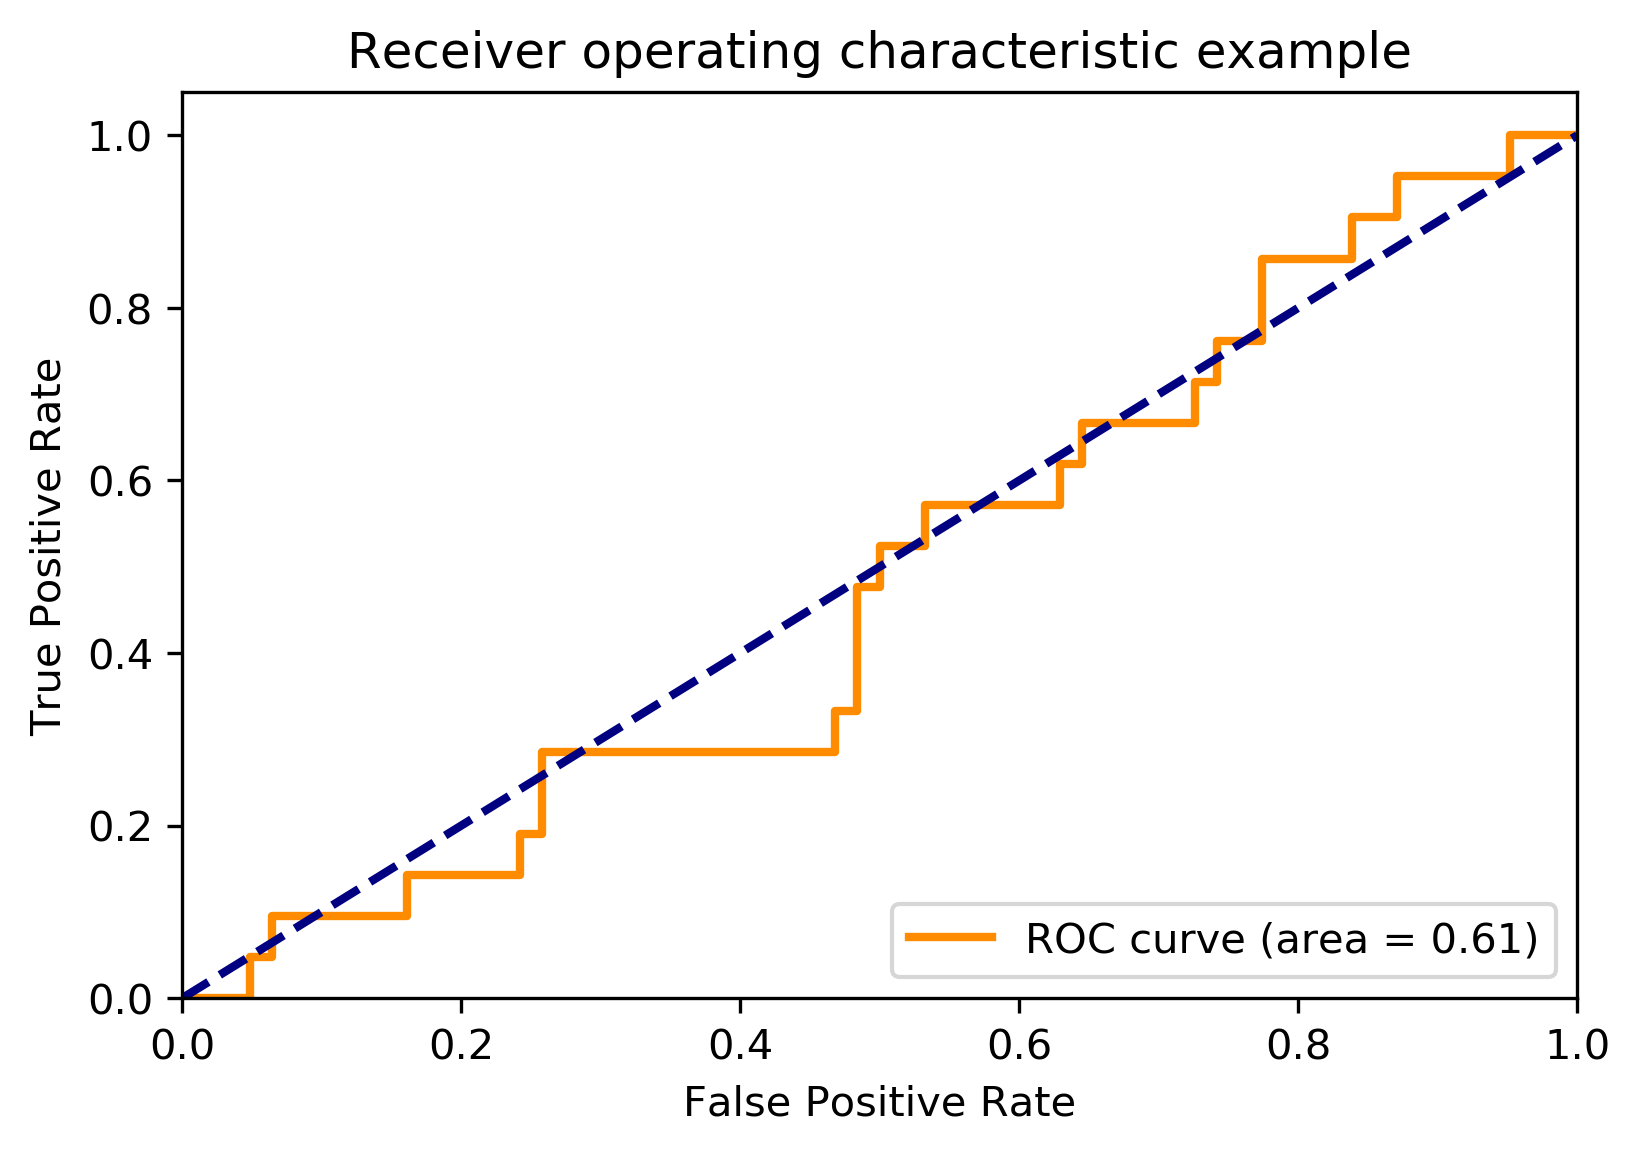

In [280]:
plotROC(fpr_ens_DILI5, tpr_ens_DILI5, roc_auc_score(B_test.iloc[:,2], y_ens_DILI5[:,0]))

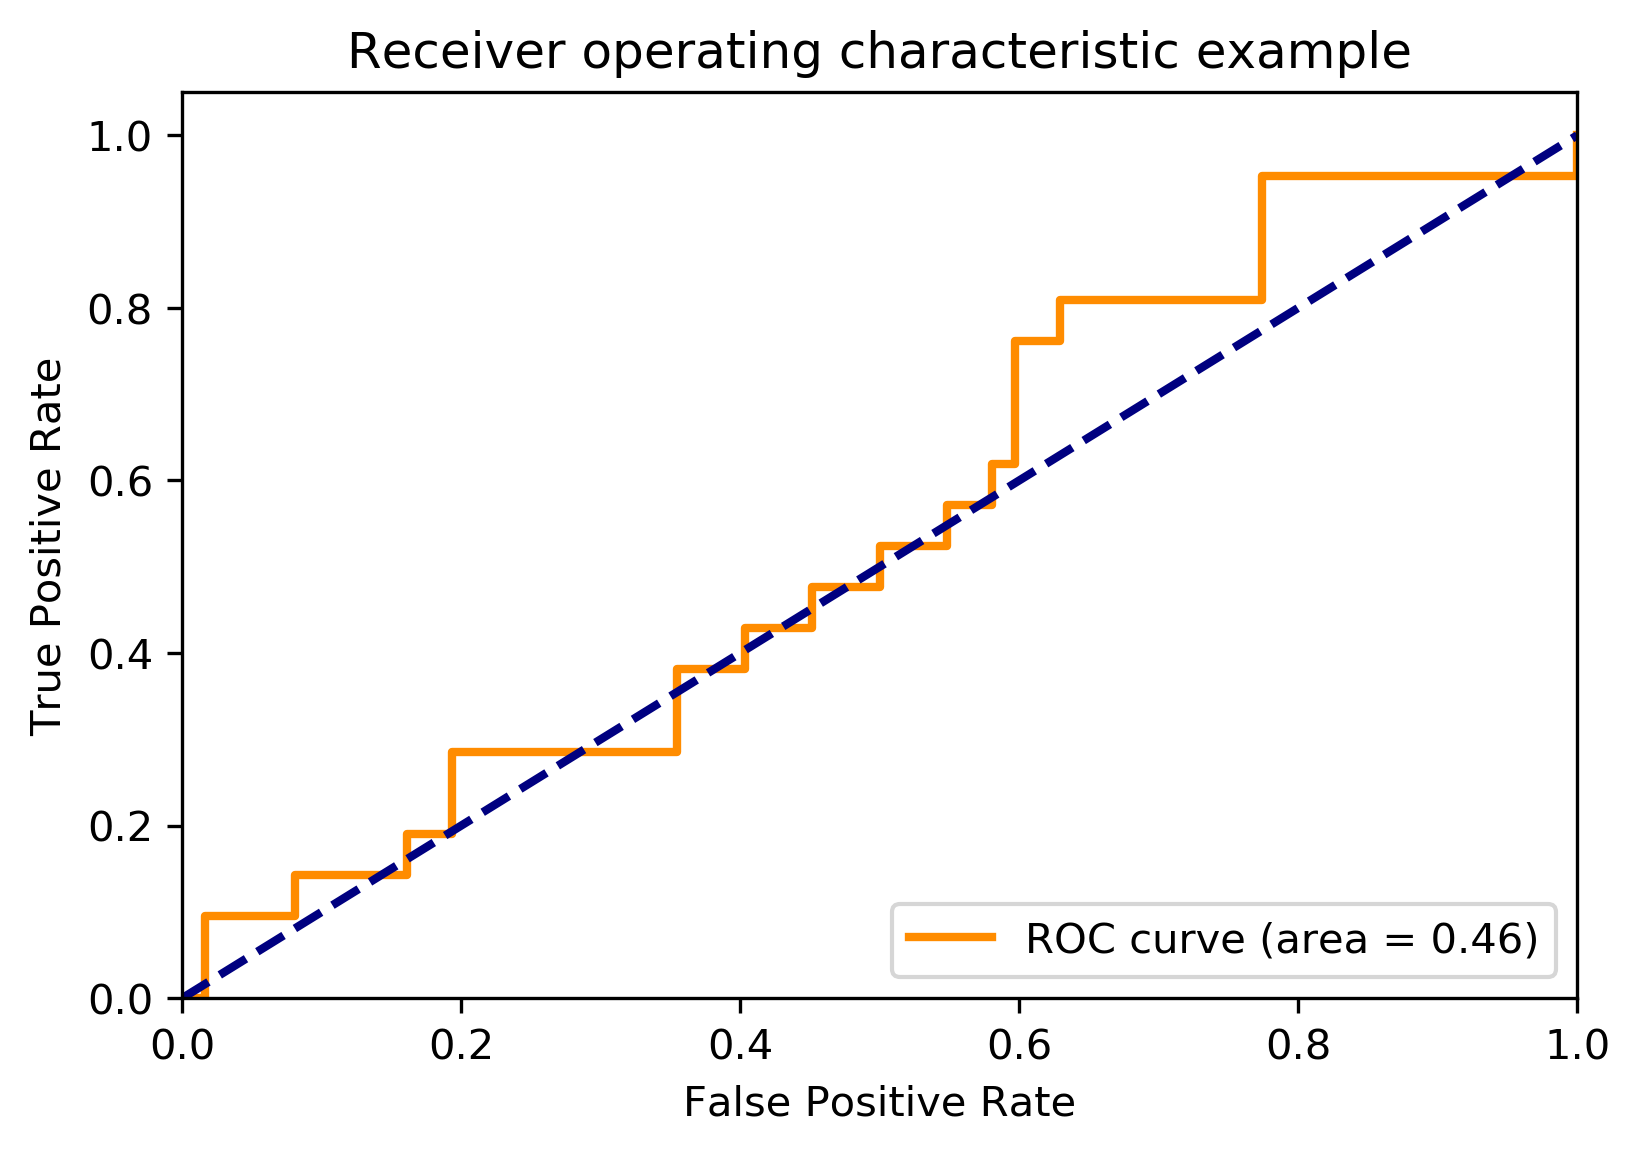

In [281]:
plotROC(fpr_ens_DILI6, tpr_ens_DILI6, roc_auc_score(B_test.iloc[:,3], y_ens_DILI5[:,0]))

#### Plot  Confusion Matrices

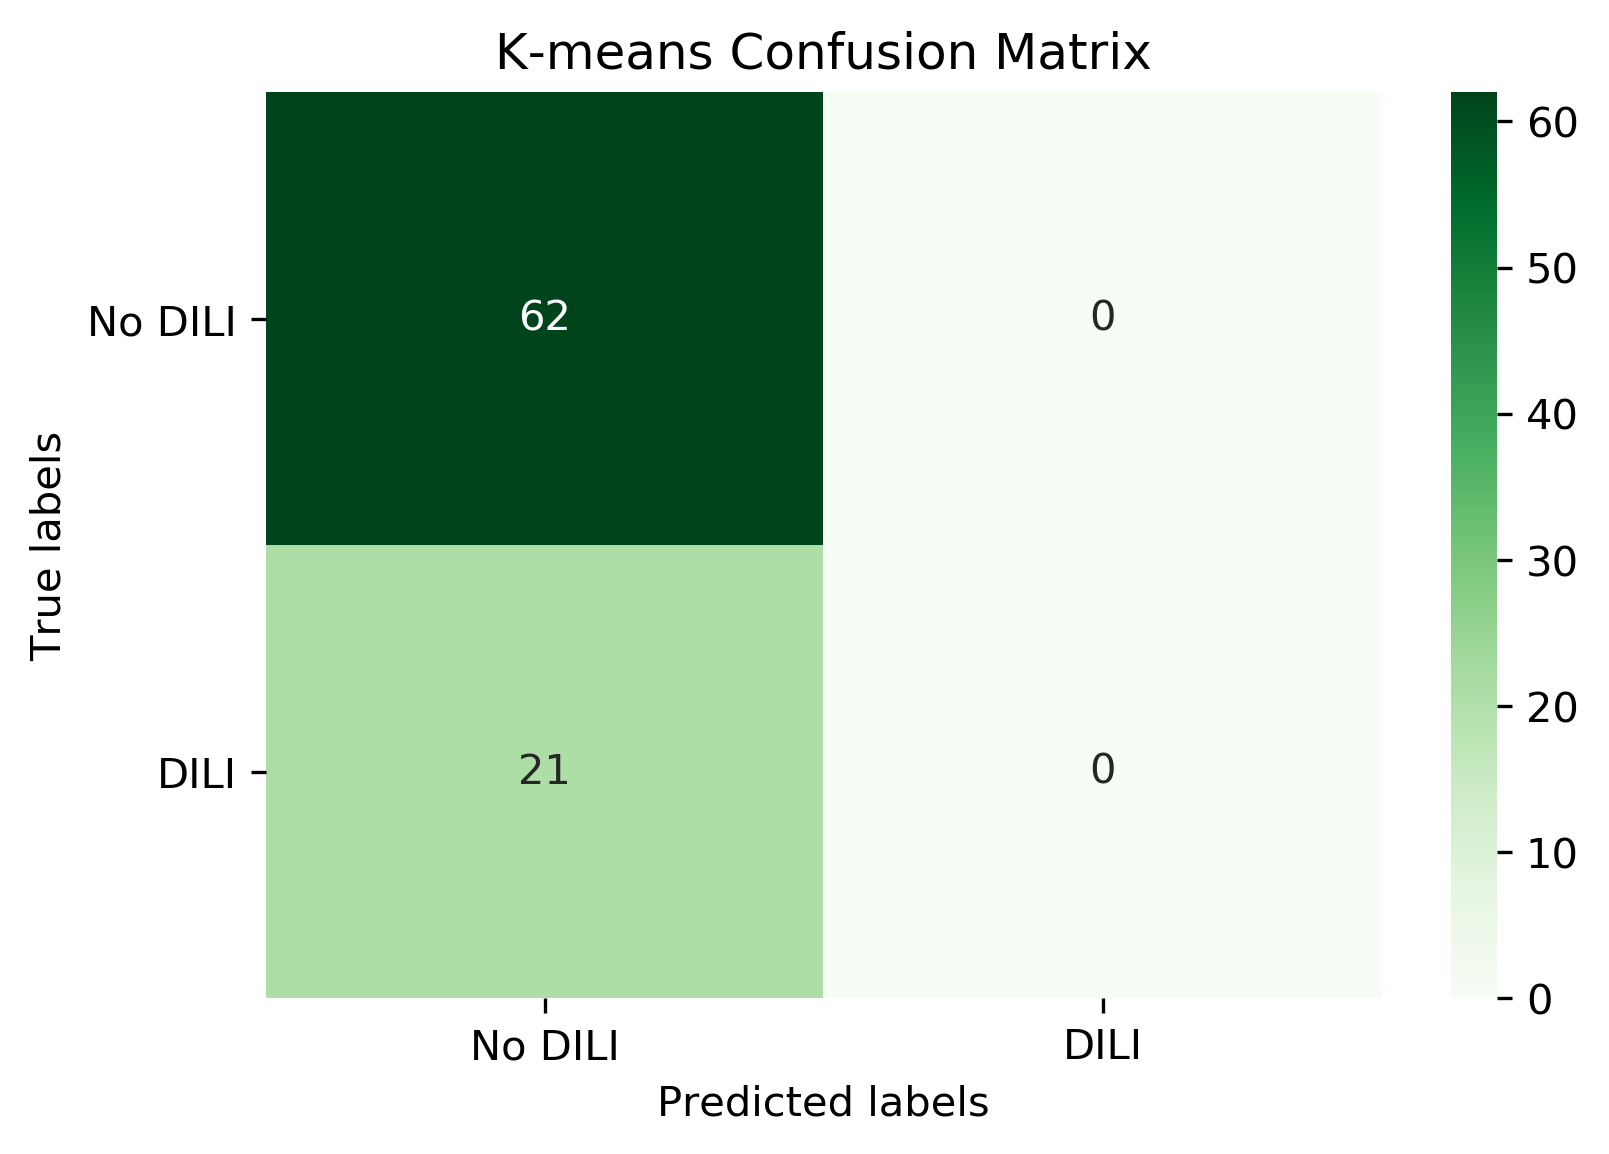

In [282]:
cM(B_test.iloc[:,0], p_ens_DILI1)

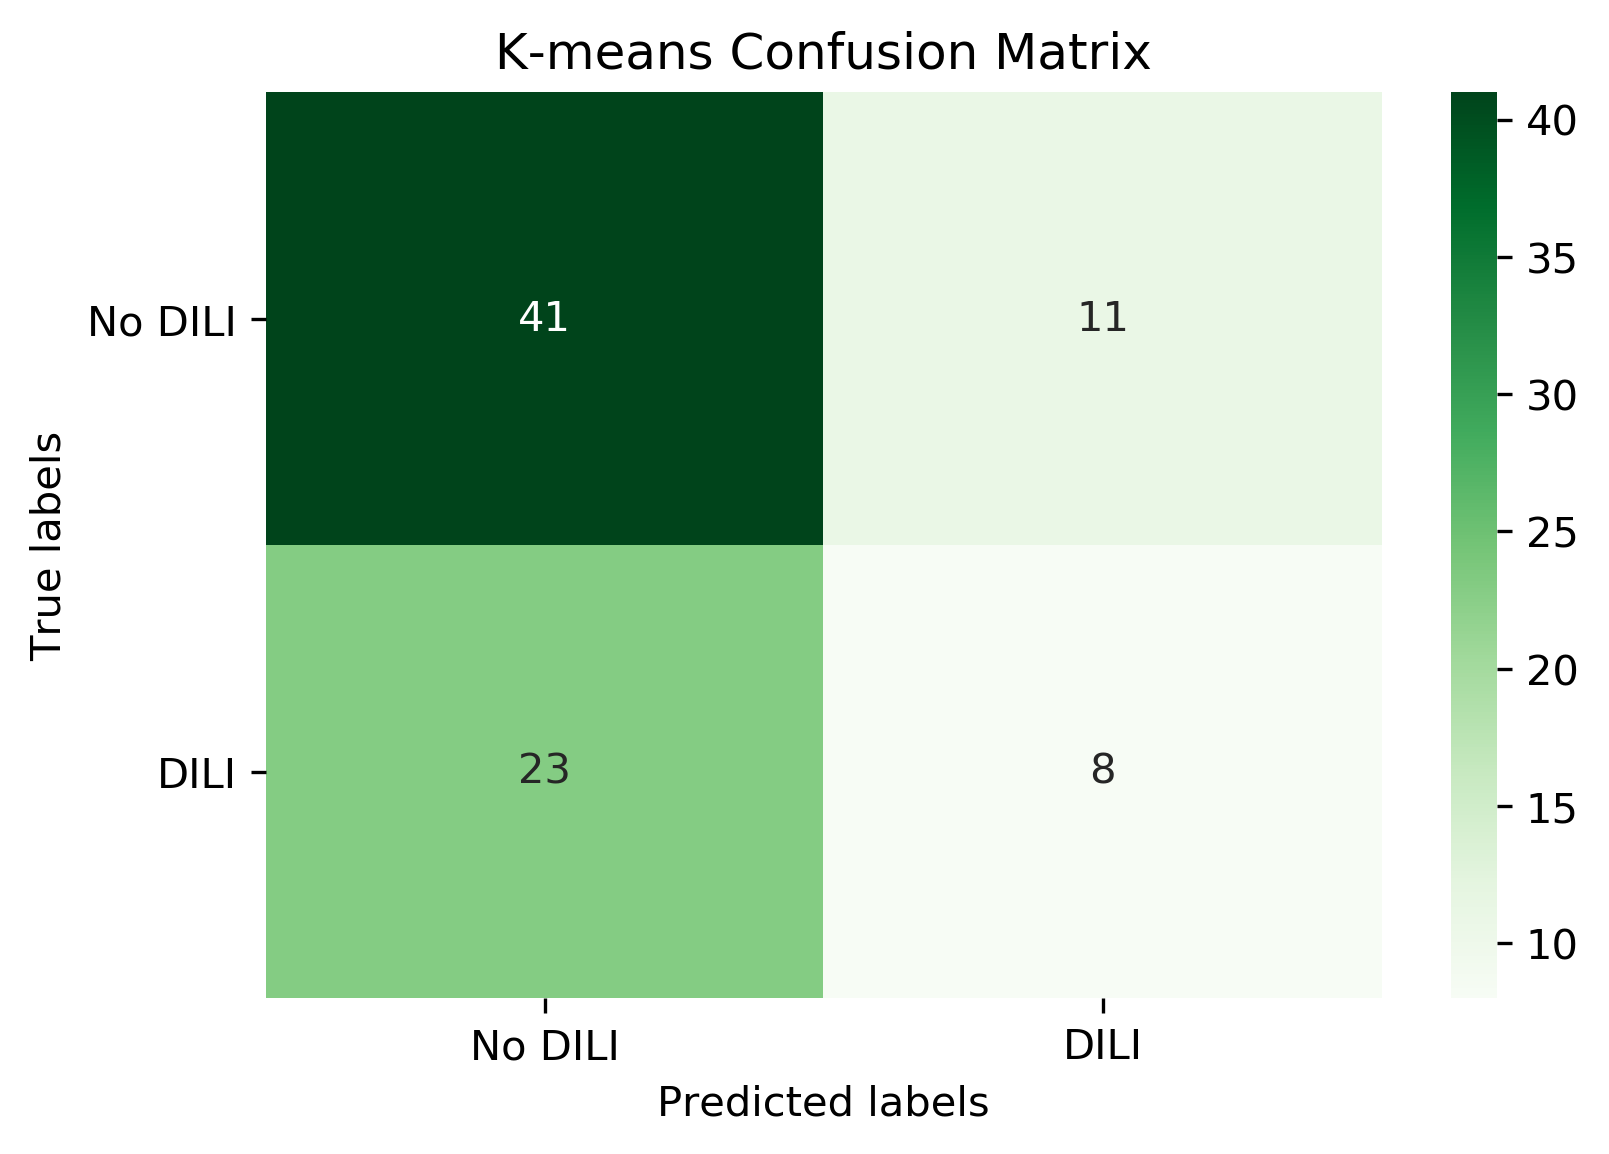

In [283]:
cM(B_test.iloc[:,1], p_ens_DILI3)

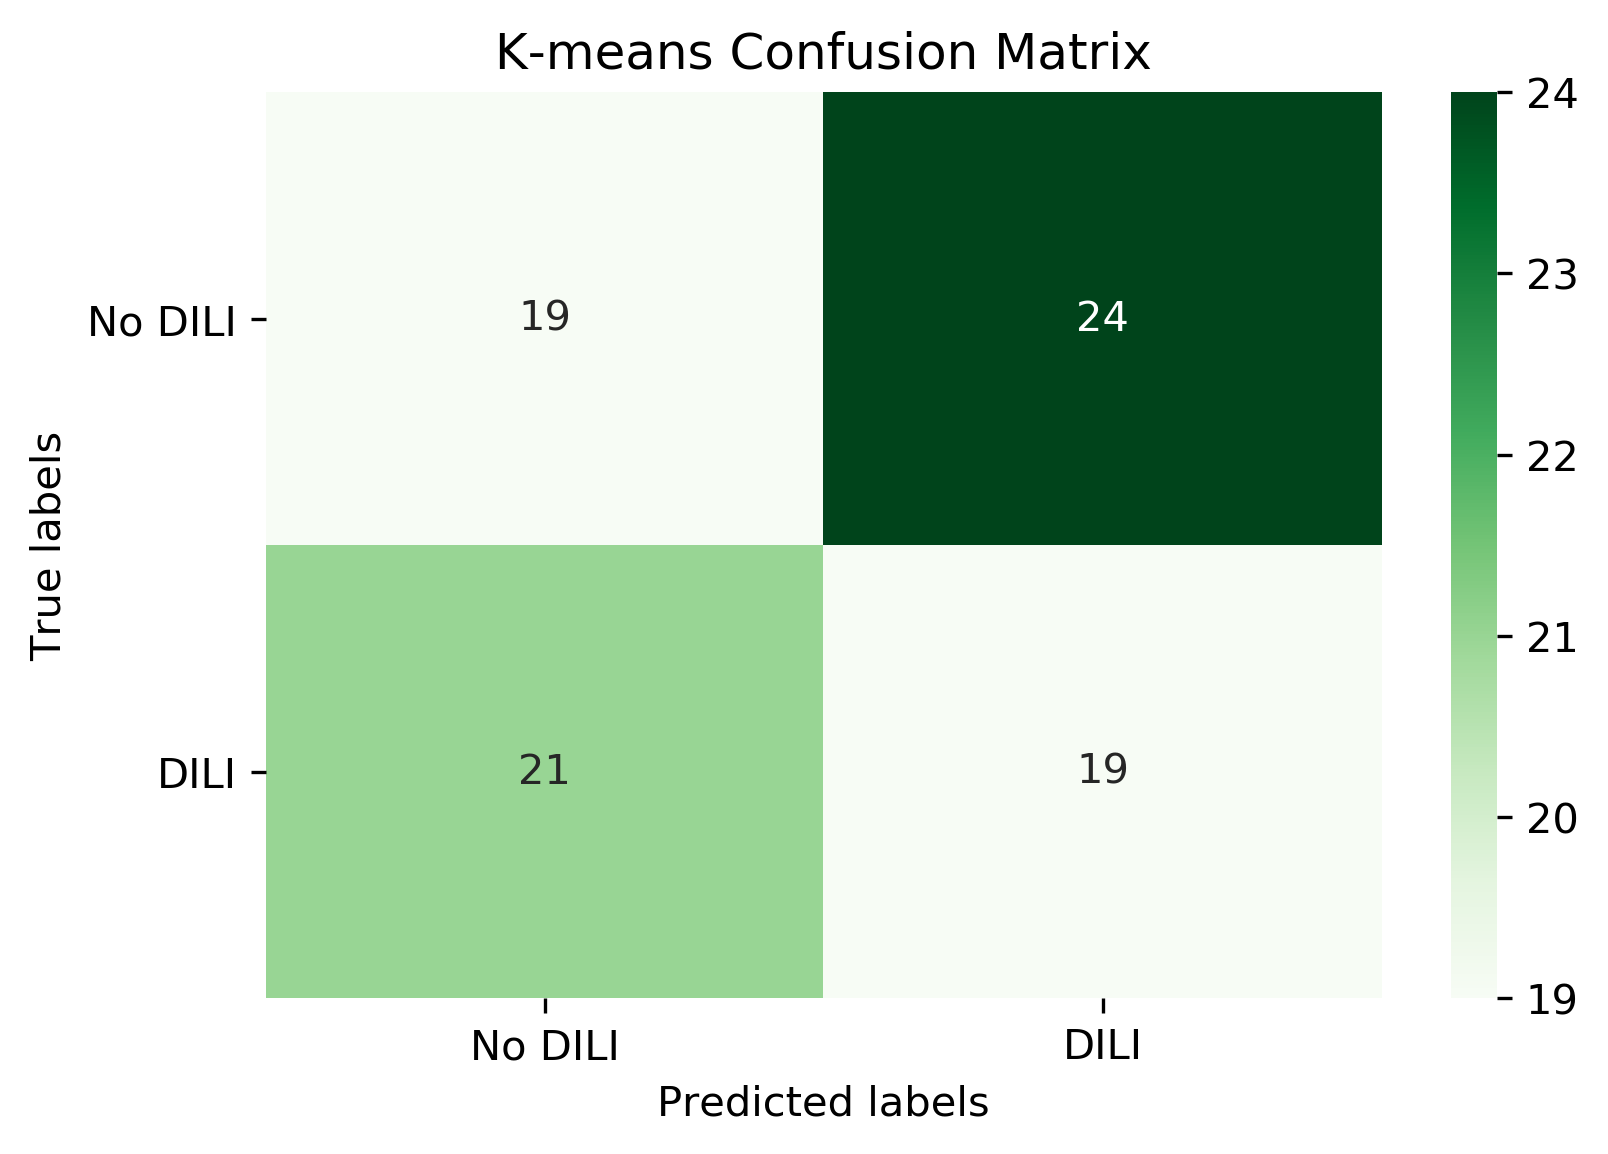

In [284]:
cM(B_test.iloc[:,2], p_ens_DILI5)

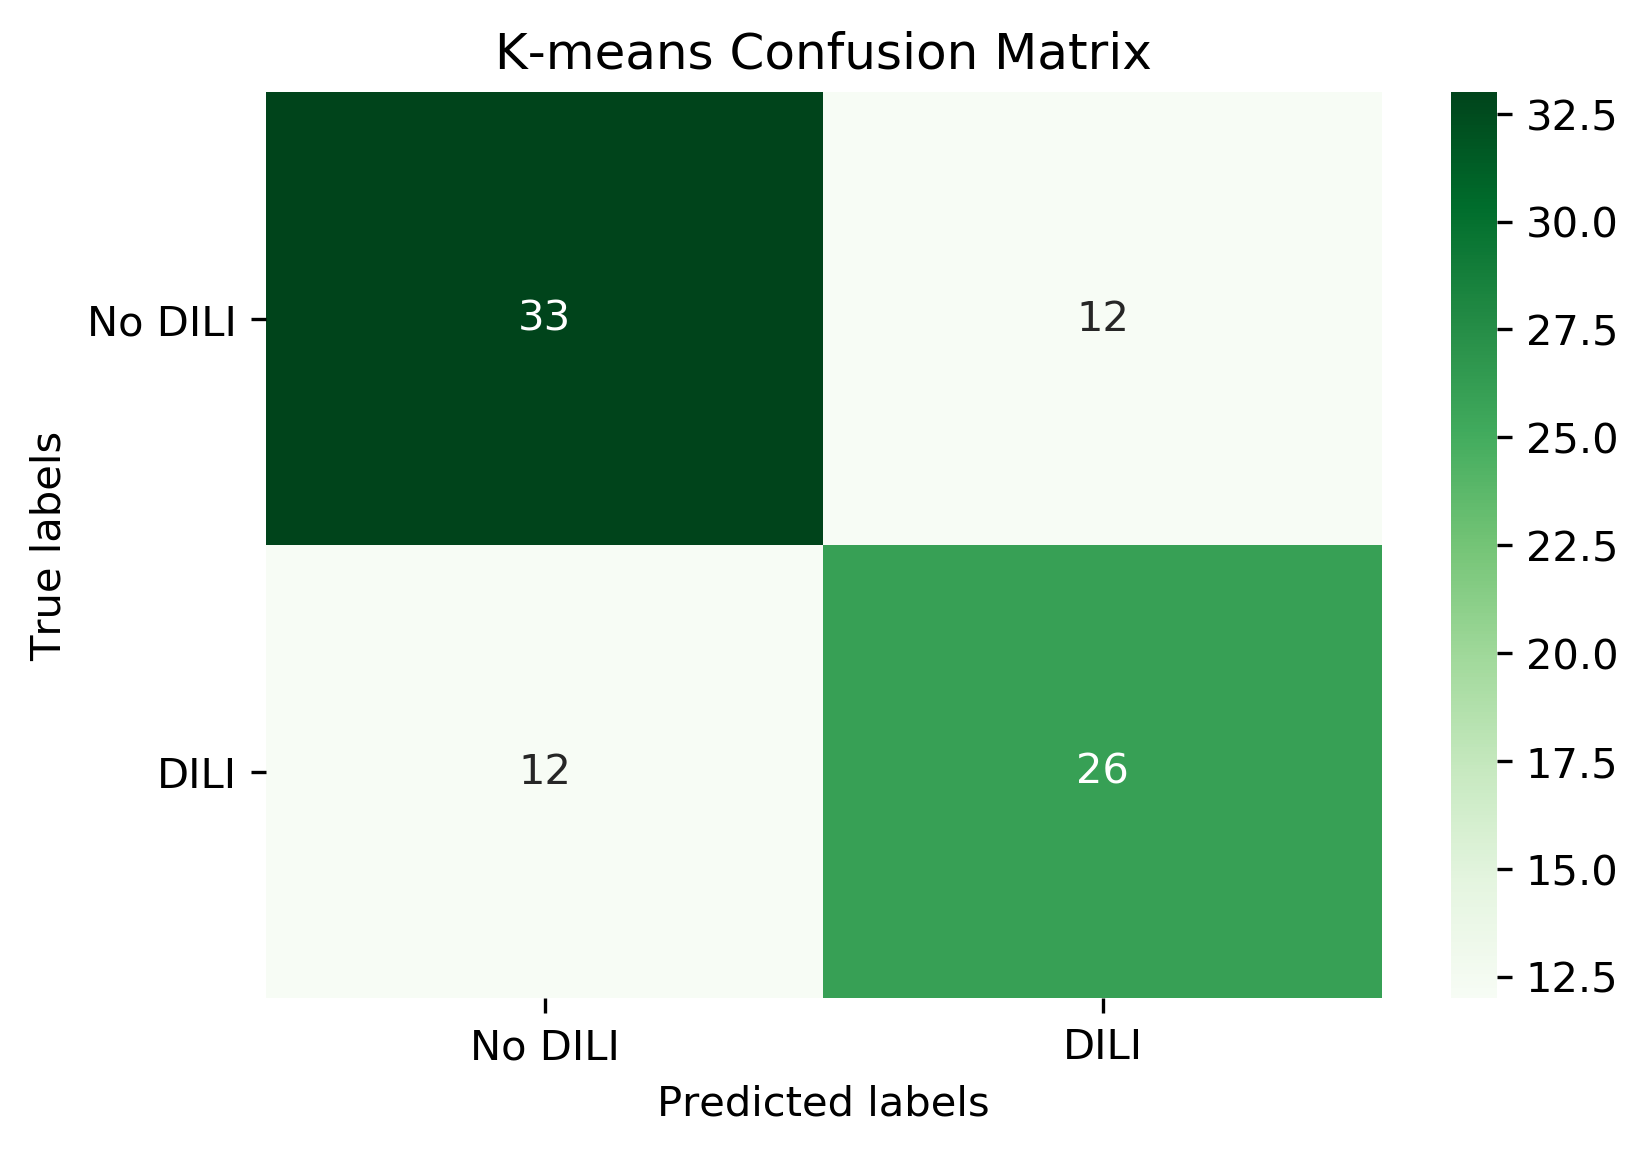

In [285]:
cM(B_test.iloc[:,3], p_ens_DILI6)

## Comparing Methods

DataFrames Final_Train and Final_Test will now be used. We will classify whether drugs cause DILI using method that is the 'best'

##### Get average accuracies/precisions/ROC/AUC for each method  across different DILI labels and plot them on bar graph.

#### Bar plot

In [428]:
def barPlot(metrics, labels, title):
    # Create bars
    plt.bar(np.arange(len(metrics)), metrics, 
            color=['firebrick','sandybrown', 'gold', 'palegreen','turquoise', 'deepskyblue',
                  'slategrey', 'rebeccapurple', 'hotpink'])
    

    # Create names on the x-axis
    plt.xticks(np.arange(len(metrics)), labels, rotation = 45)

    plt.ylim([0,1])
    plt.xlabel('Method')
    plt.ylabel(title)
    
    plt.savefig(title, dpi = 300)
    
    # Show graphic
    plt.show()


### Average Accuracy for each method

In [188]:
KNN_accuracy = np.mean(np.array([ accuracy_score(B_test.iloc[:,0], p_kNN_DILI1),
                                 accuracy_score(B_test.iloc[:,1], p_kNN_DILI3),
                                 accuracy_score(B_test.iloc[:,2], p_kNN_DILI5),
                                 accuracy_score(B_test.iloc[:,3], p_kNN_DILI6)]))

NB_accuracy = np.mean(np.array([ accuracy_score(B_test.iloc[:,0], p_nB_DILI1),
                                 accuracy_score(B_test.iloc[:,1], p_nB_DILI3),
                                 accuracy_score(B_test.iloc[:,2], p_nB_DILI5),
                                 accuracy_score(B_test.iloc[:,3], p_nB_DILI6)]))

SVM_accuracy = np.mean(np.array([ accuracy_score(B_test.iloc[:,0], p_sVM_DILI1),
                                 accuracy_score(B_test.iloc[:,1], p_sVM_DILI3),
                                 accuracy_score(B_test.iloc[:,2], p_sVM_DILI5),
                                 accuracy_score(B_test.iloc[:,3], p_sVM_DILI6)]))

RF_accuracy = np.mean(np.array([ accuracy_score(B_test.iloc[:,0], p_rF_DILI1),
                                 accuracy_score(B_test.iloc[:,1], p_rF_DILI3),
                                 accuracy_score(B_test.iloc[:,2], p_rF_DILI5),
                                 accuracy_score(B_test.iloc[:,3], p_rF_DILI6)]))

LR_accuracy = np.mean(np.array([ accuracy_score(B_test.iloc[:,0], p_lR_DILI1),
                                 accuracy_score(B_test.iloc[:,1], p_lR_DILI3),
                                 accuracy_score(B_test.iloc[:,2], p_lR_DILI5),
                                 accuracy_score(B_test.iloc[:,3], p_lR_DILI6)]))

MLP_accuracy = np.mean(np.array([ accuracy_score(B_test.iloc[:,0], p_mlp_DILI1),
                                 accuracy_score(B_test.iloc[:,1], p_mlp_DILI3),
                                 accuracy_score(B_test.iloc[:,2], p_mlp_DILI5),
                                 accuracy_score(B_test.iloc[:,3], p_mlp_DILI6)]))

XGB_accuracy = np.mean(np.array([ accuracy_score(B_test.iloc[:,0], p_xgb1_DILI1),
                                 accuracy_score(B_test.iloc[:,1], p_xgb1_DILI3),
                                 accuracy_score(B_test.iloc[:,2], p_xgb1_DILI5),
                                 accuracy_score(B_test.iloc[:,3], p_xgb1_DILI6)]))

XGB_PCA_accuracy = np.mean(np.array([ accuracy_score(B_test.iloc[:,0], p_xgb2_DILI1),
                                 accuracy_score(B_test.iloc[:,1], p_xgb2_DILI3),
                                 accuracy_score(B_test.iloc[:,2], p_xgb2_DILI5),
                                 accuracy_score(B_test.iloc[:,3], p_xgb2_DILI6)]))

ENS_accuracy = np.mean(np.array([ accuracy_score(B_test.iloc[:,0], p_ens_DILI1),
                                 accuracy_score(B_test.iloc[:,1], p_ens_DILI3),
                                 accuracy_score(B_test.iloc[:,2], p_ens_DILI5),
                                 accuracy_score(B_test.iloc[:,3], p_ens_DILI6)]))

In [289]:
print("Accuracy")
print("KNN: ", KNN_accuracy)
print("SVM: ", SVM_accuracy)
print("RF: ", RF_accuracy)
print("LR: ", LR_accuracy)
print("NB: ", NB_accuracy)
print("MLP: ", MLP_accuracy)
print("XGB: ", XGB_accuracy)
print("XGB with PCA: ", XGB_PCA_accuracy)
print("ENS: ", ENS_accuracy)

Accuracy
KNN:  0.6144578313253012
SVM:  0.6024096385542168
RF:  0.6144578313253012
LR:  0.6024096385542168
NB:  0.5240963855421688
MLP:  0.6054216867469879
XGB:  0.6265060240963856
XGB with PCA:  0.5572289156626506
ENS:  0.6265060240963856


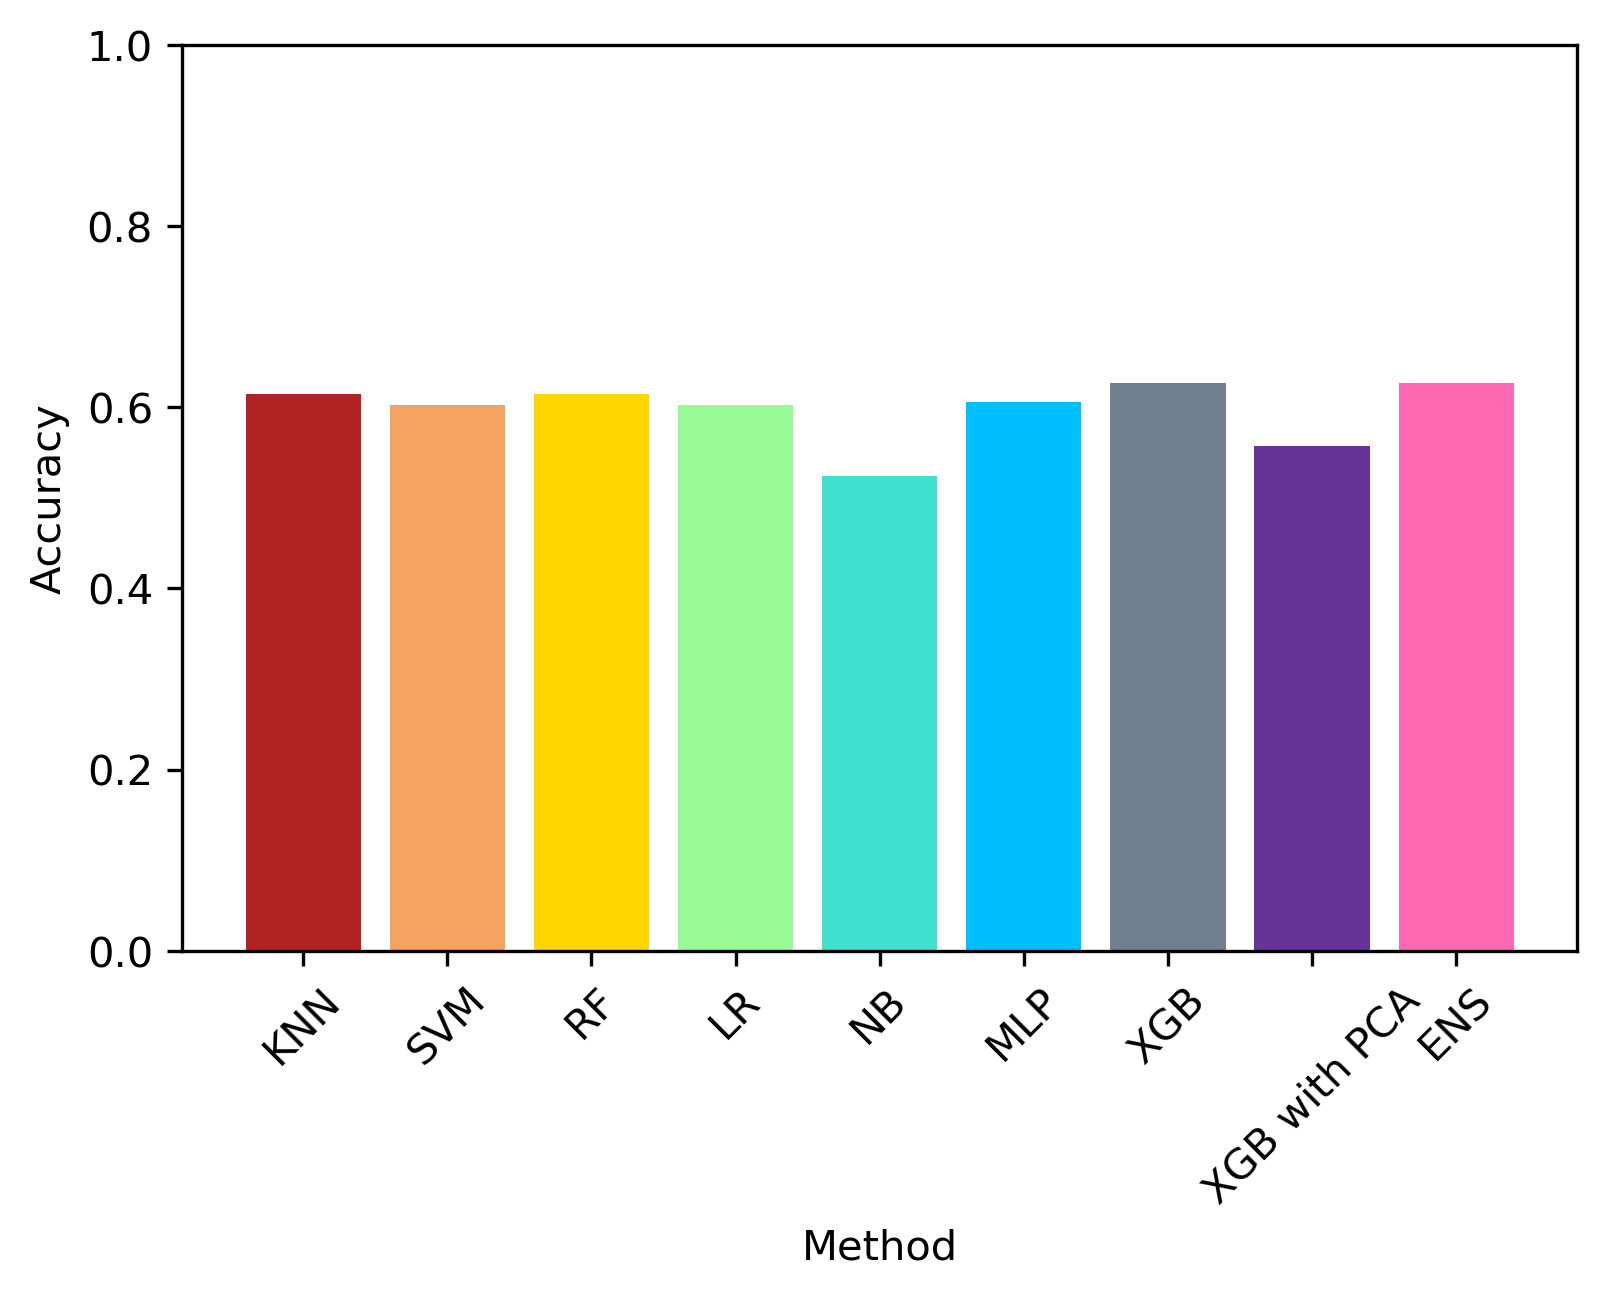

In [429]:
barPlot((KNN_accuracy, SVM_accuracy, RF_accuracy, LR_accuracy, NB_accuracy, MLP_accuracy, XGB_accuracy, XGB_PCA_accuracy, ENS_accuracy),
       ('KNN', 'SVM', 'RF', 'LR', 'NB', 'MLP', 'XGB', 'XGB with PCA', 'ENS'),
       'Accuracy')

### Average Balanced Accuracy for each method

In [195]:
KNN_balanced_accuracy = np.mean(np.array([ balanced_accuracy_score(B_test.iloc[:,0], p_kNN_DILI1),
                                 balanced_accuracy_score(B_test.iloc[:,1], p_kNN_DILI3),
                                 balanced_accuracy_score(B_test.iloc[:,2], p_kNN_DILI5),
                                 balanced_accuracy_score(B_test.iloc[:,3], p_kNN_DILI6)]))

NB_balanced_accuracy = np.mean(np.array([ balanced_accuracy_score(B_test.iloc[:,0], p_nB_DILI1),
                                 balanced_accuracy_score(B_test.iloc[:,1], p_nB_DILI3),
                                 balanced_accuracy_score(B_test.iloc[:,2], p_nB_DILI5),
                                 balanced_accuracy_score(B_test.iloc[:,3], p_nB_DILI6)]))

SVM_balanced_accuracy = np.mean(np.array([ balanced_accuracy_score(B_test.iloc[:,0], p_sVM_DILI1),
                                 balanced_accuracy_score(B_test.iloc[:,1], p_sVM_DILI3),
                                 balanced_accuracy_score(B_test.iloc[:,2], p_sVM_DILI5),
                                 balanced_accuracy_score(B_test.iloc[:,3], p_sVM_DILI6)]))

RF_balanced_accuracy = np.mean(np.array([ balanced_accuracy_score(B_test.iloc[:,0], p_rF_DILI1),
                                 balanced_accuracy_score(B_test.iloc[:,1], p_rF_DILI3),
                                 balanced_accuracy_score(B_test.iloc[:,2], p_rF_DILI5),
                                 balanced_accuracy_score(B_test.iloc[:,3], p_rF_DILI6)]))

LR_balanced_accuracy = np.mean(np.array([ balanced_accuracy_score(B_test.iloc[:,0], p_lR_DILI1),
                                 balanced_accuracy_score(B_test.iloc[:,1], p_lR_DILI3),
                                 balanced_accuracy_score(B_test.iloc[:,2], p_lR_DILI5),
                                 balanced_accuracy_score(B_test.iloc[:,3], p_lR_DILI6)]))

MLP_balanced_accuracy = np.mean(np.array([ balanced_accuracy_score(B_test.iloc[:,0], p_mlp_DILI1),
                                 balanced_accuracy_score(B_test.iloc[:,1], p_mlp_DILI3),
                                 balanced_accuracy_score(B_test.iloc[:,2], p_mlp_DILI5),
                                 balanced_accuracy_score(B_test.iloc[:,3], p_mlp_DILI6)]))

XGB_balanced_accuracy = np.mean(np.array([ balanced_accuracy_score(B_test.iloc[:,0], p_xgb1_DILI1),
                                 balanced_accuracy_score(B_test.iloc[:,1], p_xgb1_DILI3),
                                 balanced_accuracy_score(B_test.iloc[:,2], p_xgb1_DILI5),
                                 balanced_accuracy_score(B_test.iloc[:,3], p_xgb1_DILI6)]))

XGB_PCA_balanced_accuracy = np.mean(np.array([ balanced_accuracy_score(B_test.iloc[:,0], p_xgb2_DILI1),
                                 balanced_accuracy_score(B_test.iloc[:,1], p_xgb2_DILI3),
                                 balanced_accuracy_score(B_test.iloc[:,2], p_xgb2_DILI5),
                                 balanced_accuracy_score(B_test.iloc[:,3], p_xgb2_DILI6)]))

ENS_balanced_accuracy = np.mean(np.array([ balanced_accuracy_score(B_test.iloc[:,0], p_ens_DILI1),
                                 balanced_accuracy_score(B_test.iloc[:,1], p_ens_DILI3),
                                 balanced_accuracy_score(B_test.iloc[:,2], p_ens_DILI5),
                                 balanced_accuracy_score(B_test.iloc[:,3], p_ens_DILI6)]))

In [293]:
print("Balanced Accuracy")
print("KNN: ", KNN_balanced_accuracy)
print("SVM: ", SVM_balanced_accuracy)
print("RF: ", RF_balanced_accuracy)
print("LR: ", LR_balanced_accuracy)
print("NB: ", NB_balanced_accuracy)
print("MLP: ", MLP_balanced_accuracy)
print("XGB: ", XGB_balanced_accuracy)
print("XGB with PCA: ", XGB_PCA_balanced_accuracy)
print("ENS: ", ENS_balanced_accuracy)

Balanced Accuracy
KNN:  0.5274868491498719
SVM:  0.5094956990344077
RF:  0.525555230111509
LR:  0.505701754385965
NB:  0.5318028149677674
MLP:  0.5416838226088236
XGB:  0.5315058479532164
XGB with PCA:  0.4681813545491636
ENS:  0.5476162974194966


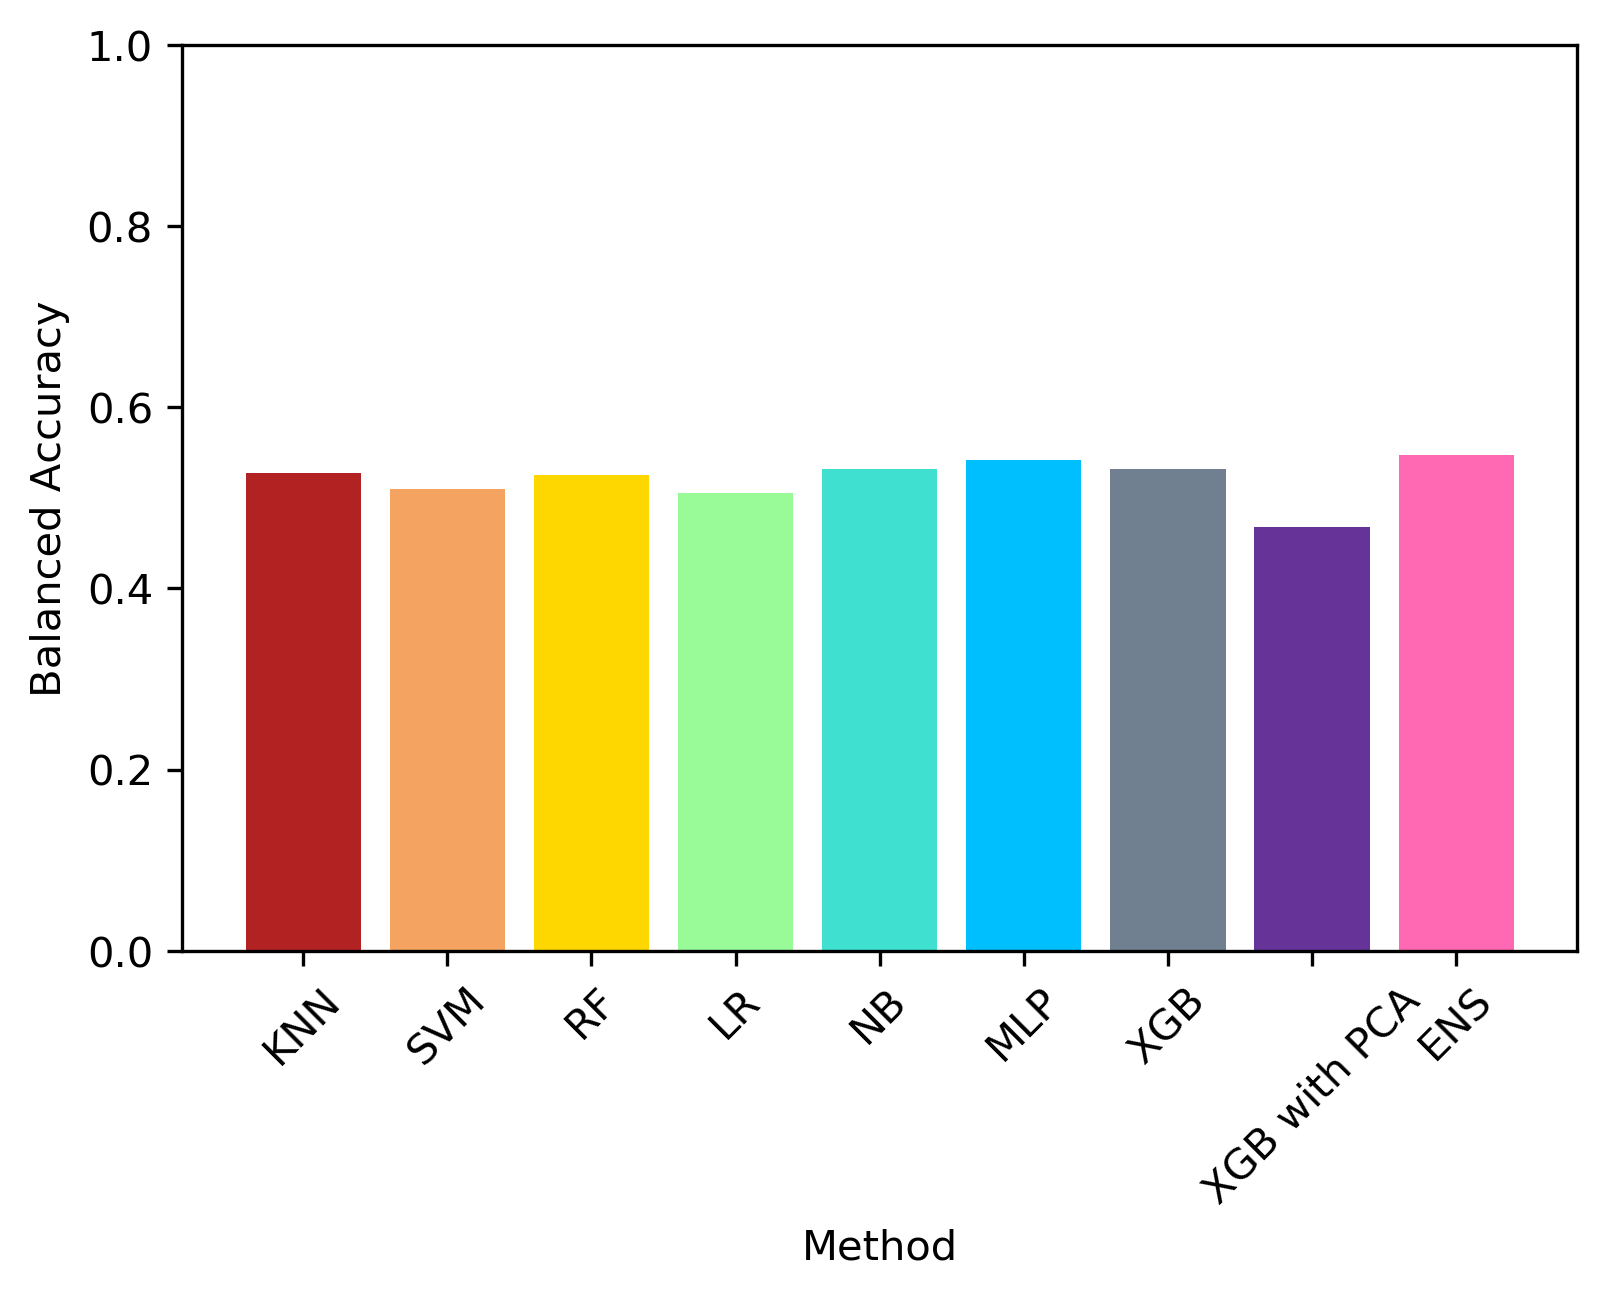

In [430]:
barPlot((KNN_balanced_accuracy, SVM_balanced_accuracy, RF_balanced_accuracy, 
         LR_balanced_accuracy, NB_balanced_accuracy, MLP_balanced_accuracy, XGB_balanced_accuracy, 
         XGB_PCA_balanced_accuracy, ENS_balanced_accuracy),
       ('KNN', 'SVM', 'RF', 'LR', 'NB', 'MLP', 'XGB', 'XGB with PCA', 'ENS'),
       'Balanced Accuracy')

### Average Precision for each method

In [197]:
KNN_precision = np.mean(np.array([ precision_score(B_test.iloc[:,0], p_kNN_DILI1),
                                 precision_score(B_test.iloc[:,1], p_kNN_DILI3),
                                 precision_score(B_test.iloc[:,2], p_kNN_DILI5),
                                 precision_score(B_test.iloc[:,3], p_kNN_DILI6)]))

NB_precision = np.mean(np.array([ precision_score(B_test.iloc[:,0], p_nB_DILI1),
                                 precision_score(B_test.iloc[:,1], p_nB_DILI3),
                                 precision_score(B_test.iloc[:,2], p_nB_DILI5),
                                 precision_score(B_test.iloc[:,3], p_nB_DILI6)]))

SVM_precision = np.mean(np.array([ precision_score(B_test.iloc[:,0], p_sVM_DILI1),
                                 precision_score(B_test.iloc[:,1], p_sVM_DILI3),
                                 precision_score(B_test.iloc[:,2], p_sVM_DILI5),
                                 precision_score(B_test.iloc[:,3], p_sVM_DILI6)]))

RF_precision = np.mean(np.array([ precision_score(B_test.iloc[:,0], p_rF_DILI1),
                                 precision_score(B_test.iloc[:,1], p_rF_DILI3),
                                 precision_score(B_test.iloc[:,2], p_rF_DILI5),
                                 precision_score(B_test.iloc[:,3], p_rF_DILI6)]))

LR_precision = np.mean(np.array([ precision_score(B_test.iloc[:,0], p_lR_DILI1),
                                 precision_score(B_test.iloc[:,1], p_lR_DILI3),
                                 precision_score(B_test.iloc[:,2], p_lR_DILI5),
                                 precision_score(B_test.iloc[:,3], p_lR_DILI6)]))

MLP_precision = np.mean(np.array([ precision_score(B_test.iloc[:,0], p_mlp_DILI1),
                                 precision_score(B_test.iloc[:,1], p_mlp_DILI3),
                                 precision_score(B_test.iloc[:,2], p_mlp_DILI5),
                                 precision_score(B_test.iloc[:,3], p_mlp_DILI6)]))

XGB_precision = np.mean(np.array([ precision_score(B_test.iloc[:,0], p_xgb1_DILI1),
                                 precision_score(B_test.iloc[:,1], p_xgb1_DILI3),
                                 precision_score(B_test.iloc[:,2], p_xgb1_DILI5),
                                 precision_score(B_test.iloc[:,3], p_xgb1_DILI6)]))

XGB_PCA_precision = np.mean(np.array([ precision_score(B_test.iloc[:,0], p_xgb2_DILI1),
                                 precision_score(B_test.iloc[:,1], p_xgb2_DILI3),
                                 precision_score(B_test.iloc[:,2], p_xgb2_DILI5),
                                 precision_score(B_test.iloc[:,3], p_xgb2_DILI6)]))

ENS_precision = np.mean(np.array([ precision_score(B_test.iloc[:,0], p_ens_DILI1),
                                 precision_score(B_test.iloc[:,1], p_ens_DILI3),
                                 precision_score(B_test.iloc[:,2], p_ens_DILI5),
                                 precision_score(B_test.iloc[:,3], p_ens_DILI6)]))

/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [300]:
print("Precision")
print("KNN: ", KNN_precision)
print("SVM: ", SVM_precision)
print("RF: ", RF_precision)
print("LR: ", LR_precision)
print("NB: ", NB_precision)
print("MLP: ", MLP_precision)
print("XGB: ", XGB_precision)
print("XGB with PCA: ", XGB_PCA_precision)
print("ENS: ", ENS_precision)

Precision
KNN:  0.36164215686274515
SVM:  0.2323266986959506
RF:  0.32700216450216446
LR:  0.11956521739130435
NB:  0.42668144111906314
MLP:  0.36899641577060927
XGB:  0.13942307692307693
XGB with PCA:  0.20714285714285713
ENS:  0.386780905752754


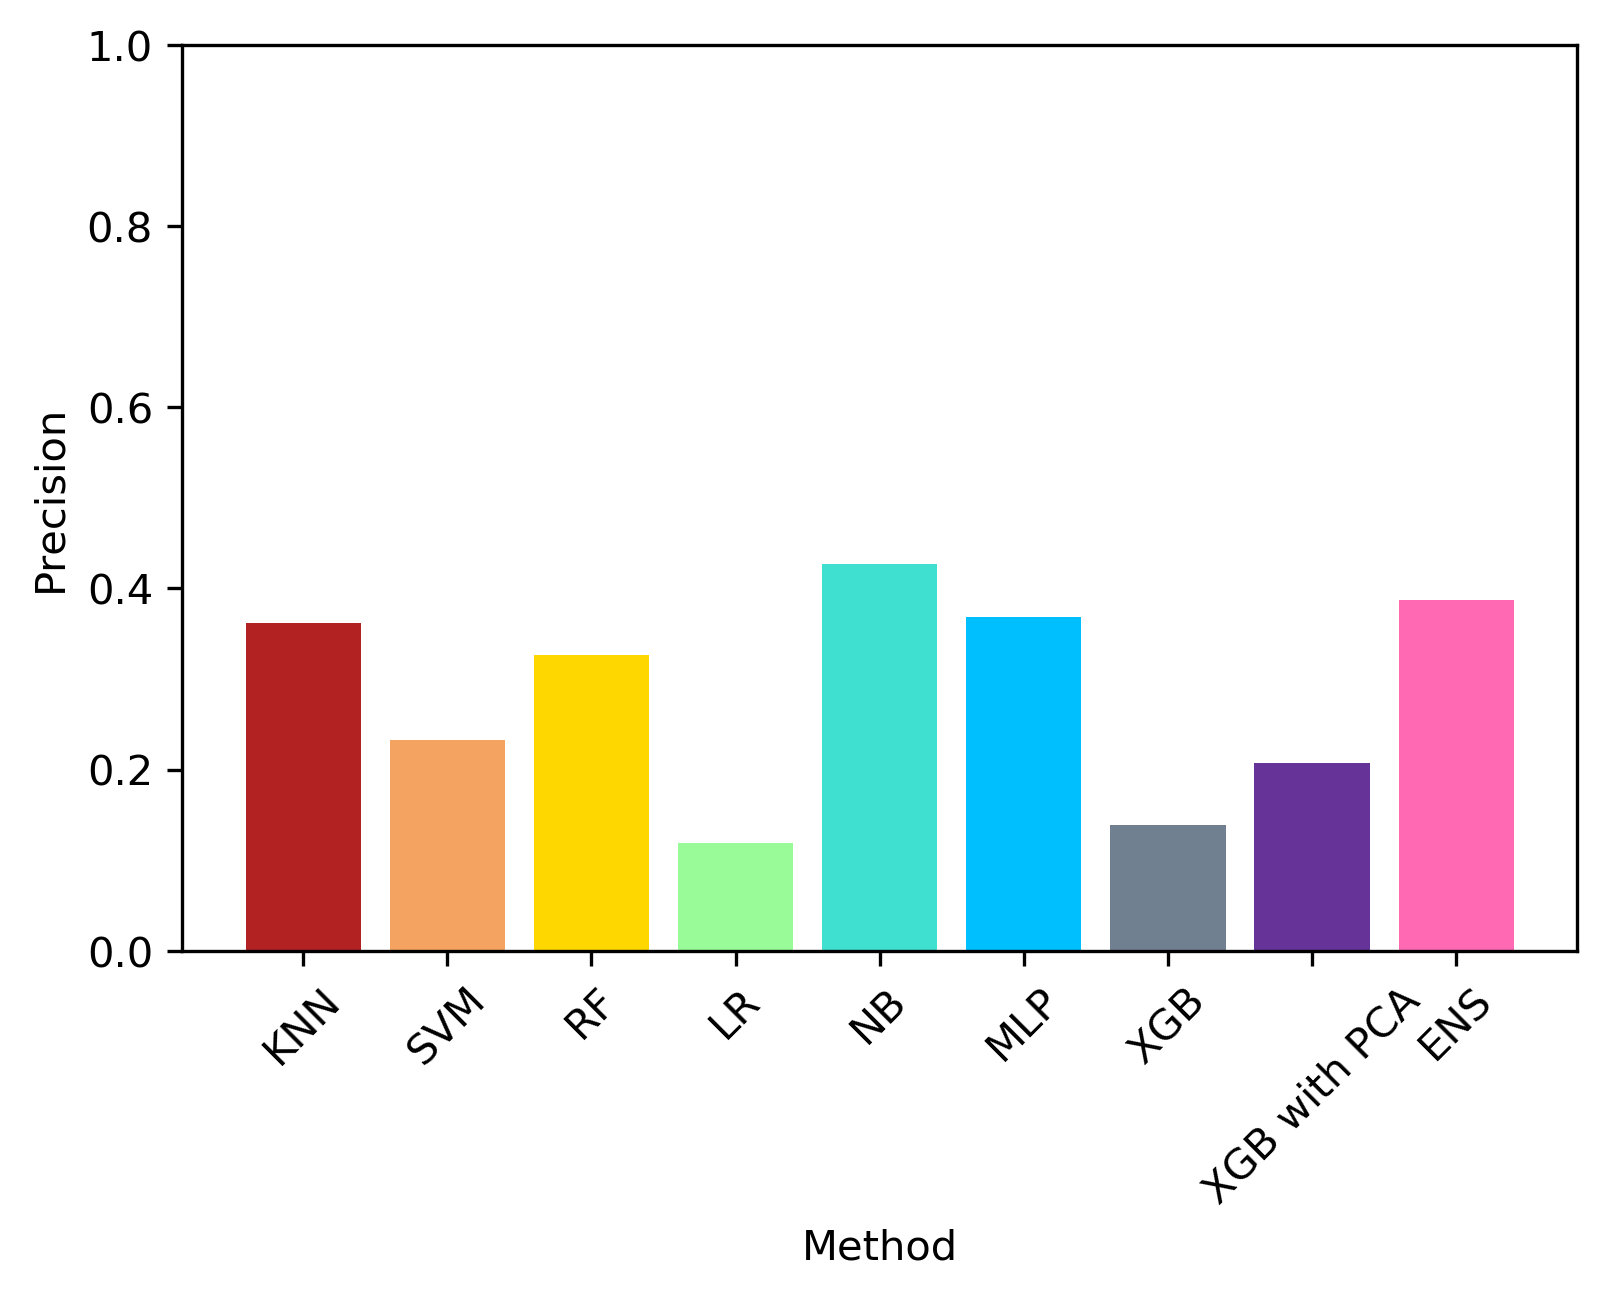

In [431]:
barPlot((KNN_precision, SVM_precision, RF_precision, 
         LR_precision, NB_precision, MLP_precision, XGB_precision, 
         XGB_PCA_precision, ENS_precision),
       ('KNN', 'SVM', 'RF', 'LR', 'NB', 'MLP', 'XGB', 'XGB with PCA', 'ENS'),
       'Precision')

### Average F1 Score for each method

In [327]:
KNN_F1 = np.mean(np.array([ f1_score(B_test.iloc[:,0], p_kNN_DILI1),
                                 f1_score(B_test.iloc[:,1], p_kNN_DILI3),
                                 f1_score(B_test.iloc[:,2], p_kNN_DILI5),
                                 f1_score(B_test.iloc[:,3], p_kNN_DILI6)]))

NB_F1 = np.mean(np.array([ f1_score(B_test.iloc[:,0], p_nB_DILI1),
                                 f1_score(B_test.iloc[:,1], p_nB_DILI3),
                                 f1_score(B_test.iloc[:,2], p_nB_DILI5),
                                 f1_score(B_test.iloc[:,3], p_nB_DILI6)]))

SVM_F1 = np.mean(np.array([ f1_score(B_test.iloc[:,0], p_sVM_DILI1),
                                 f1_score(B_test.iloc[:,1], p_sVM_DILI3),
                                 f1_score(B_test.iloc[:,2], p_sVM_DILI5),
                                 f1_score(B_test.iloc[:,3], p_sVM_DILI6)]))

RF_F1 = np.mean(np.array([ f1_score(B_test.iloc[:,0], p_rF_DILI1),
                                 f1_score(B_test.iloc[:,1], p_rF_DILI3),
                                 f1_score(B_test.iloc[:,2], p_rF_DILI5),
                                 f1_score(B_test.iloc[:,3], p_rF_DILI6)]))

LR_F1 = np.mean(np.array([ f1_score(B_test.iloc[:,0], p_lR_DILI1),
                                 f1_score(B_test.iloc[:,1], p_lR_DILI3),
                                 f1_score(B_test.iloc[:,2], p_lR_DILI5),
                                 f1_score(B_test.iloc[:,3], p_lR_DILI6)]))

MLP_F1 = np.mean(np.array([ f1_score(B_test.iloc[:,0], p_mlp_DILI1),
                                 f1_score(B_test.iloc[:,1], p_mlp_DILI3),
                                 f1_score(B_test.iloc[:,2], p_mlp_DILI5),
                                 f1_score(B_test.iloc[:,3], p_mlp_DILI6)]))

XGB_F1 = np.mean(np.array([ f1_score(B_test.iloc[:,0], p_xgb1_DILI1),
                                 f1_score(B_test.iloc[:,1], p_xgb1_DILI3),
                                 f1_score(B_test.iloc[:,2], p_xgb1_DILI5),
                                 f1_score(B_test.iloc[:,3], p_xgb1_DILI6)]))

XGB_PCA_F1 = np.mean(np.array([ f1_score(B_test.iloc[:,0], p_xgb2_DILI1),
                                 f1_score(B_test.iloc[:,1], p_xgb2_DILI3),
                                 f1_score(B_test.iloc[:,2], p_xgb2_DILI5),
                                 f1_score(B_test.iloc[:,3], p_xgb2_DILI6)]))
f1_score
ENS_F1 = np.mean(np.array([ f1_score(B_test.iloc[:,0], p_ens_DILI1),
                                 f1_score(B_test.iloc[:,1], p_ens_DILI3),
                                 f1_score(B_test.iloc[:,2], p_ens_DILI5),
                                 f1_score(B_test.iloc[:,3], p_ens_DILI6)]))

In [328]:
print("F1 Score")
print("KNN: ", KNN_F1)
print("SVM: ", SVM_F1)
print("RF: ", RF_F1)
print("LR: ", LR_F1)
print("NB: ", NB_F1)
print("MLP: ", MLP_F1)
print("XGB: ", XGB_F1)
print("XGB with PCA: ", XGB_PCA_F1)
print("ENS: ", ENS_F1)

F1 Score
KNN:  0.3223504273504273
SVM:  0.2362883181441591
RF:  0.26763124604680577
LR:  0.13095238095238096
NB:  0.4237999009530695
MLP:  0.3966405037088149
XGB:  0.1611111111111111
XGB with PCA:  0.21444888635065676
ENS:  0.3655104629042486


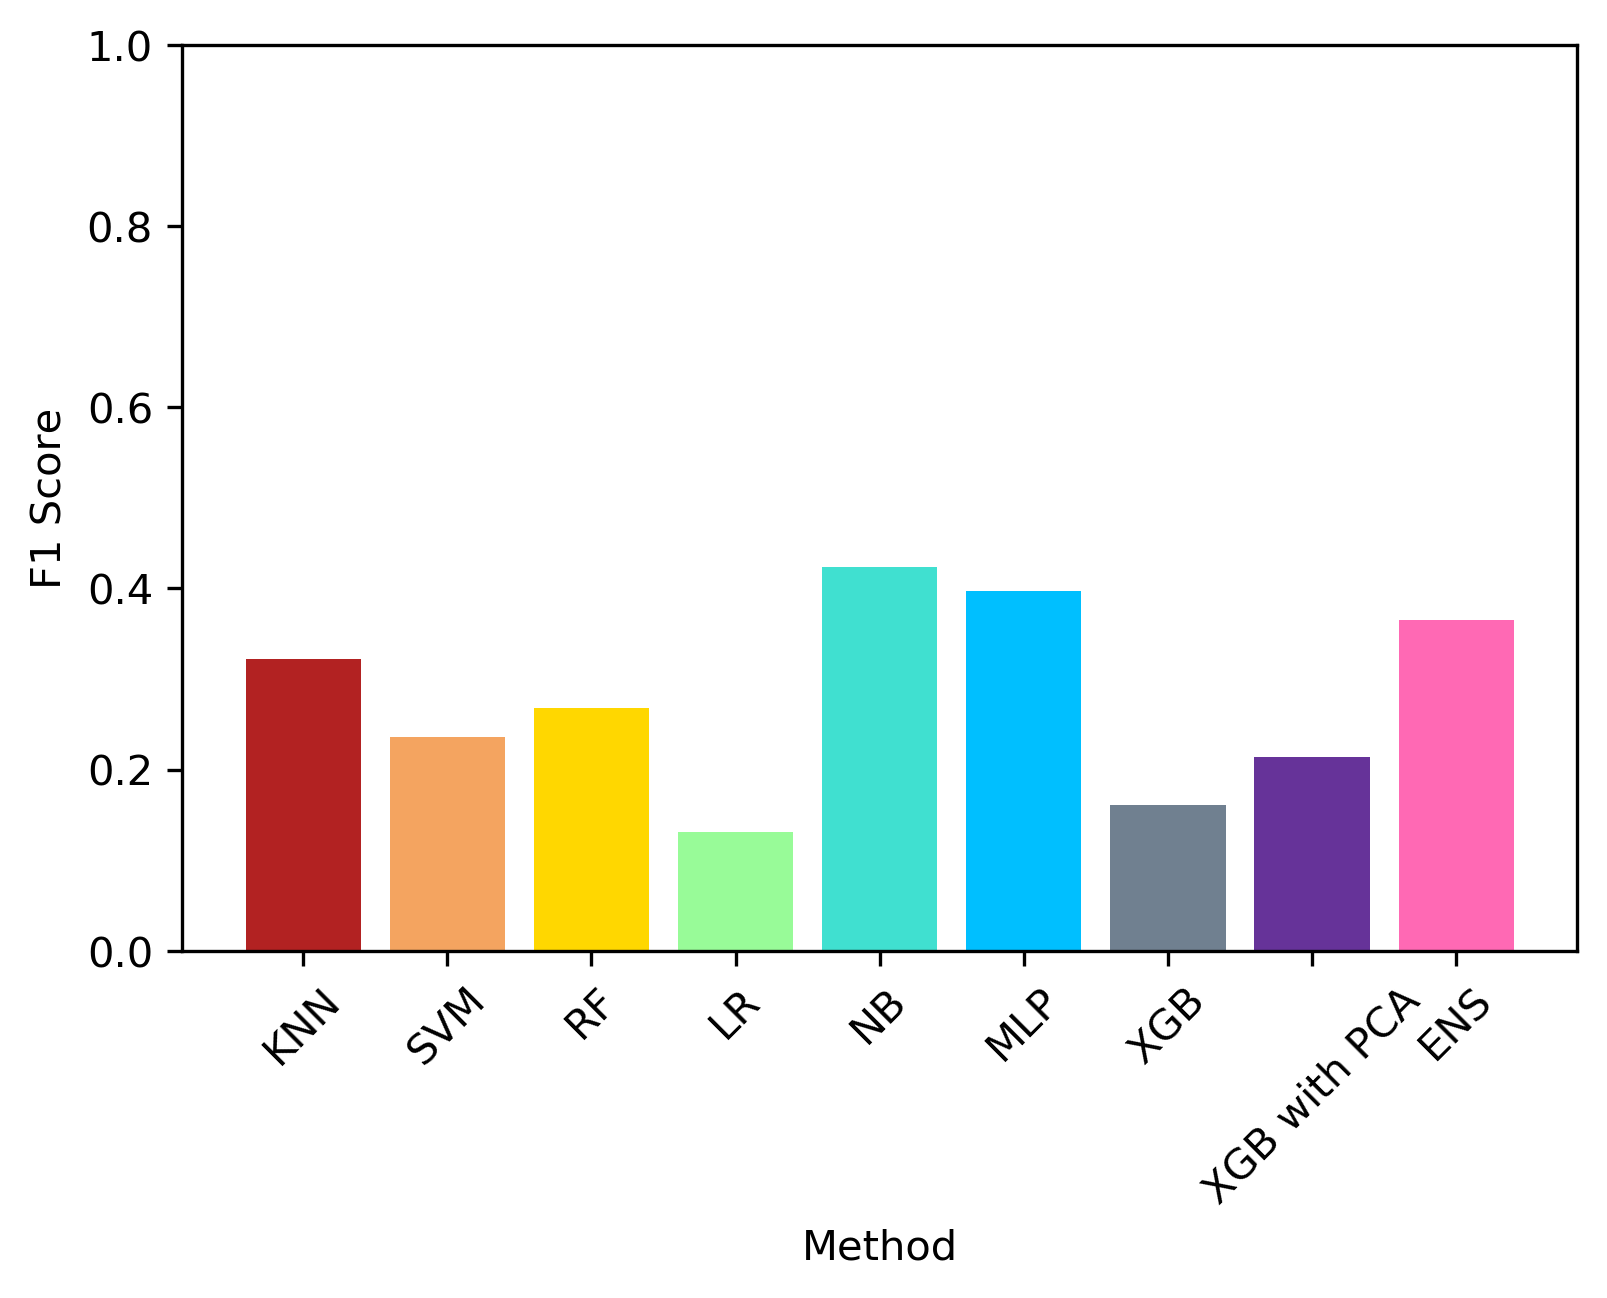

In [432]:
barPlot((KNN_F1, SVM_F1, RF_F1, 
         LR_F1, NB_F1, MLP_F1, XGB_F1, 
         XGB_PCA_F1, ENS_F1),
       ('KNN', 'SVM', 'RF', 'LR', 'NB', 'MLP', 'XGB', 'XGB with PCA', 'ENS'),
       'F1 Score')

### Average ROC AUC for each method

In [200]:
KNN_ROCAUC = np.mean(np.array([ roc_auc_score(B_test.iloc[:,0], y_kNN_DILI1[:,0]),
                                 roc_auc_score(B_test.iloc[:,1], y_kNN_DILI3[:,0]),
                                 roc_auc_score(B_test.iloc[:,2], y_kNN_DILI5[:,0]),
                                 roc_auc_score(B_test.iloc[:,3], y_kNN_DILI6[:,0])]))

NB_ROCAUC = np.mean(np.array([ roc_auc_score(B_test.iloc[:,0], y_nB_DILI1[:,0]),
                                 roc_auc_score(B_test.iloc[:,1], y_nB_DILI3[:,0]),
                                 roc_auc_score(B_test.iloc[:,2], y_nB_DILI5[:,0]),
                                 roc_auc_score(B_test.iloc[:,3], y_nB_DILI6[:,0])]))

SVM_ROCAUC = np.mean(np.array([ roc_auc_score(B_test.iloc[:,0], y_sVM_DILI1[:,0]),
                                 roc_auc_score(B_test.iloc[:,1], y_sVM_DILI3[:,0]),
                                 roc_auc_score(B_test.iloc[:,2], y_sVM_DILI5[:,0]),
                                 roc_auc_score(B_test.iloc[:,3], y_sVM_DILI6[:,0])]))

RF_ROCAUC = np.mean(np.array([ roc_auc_score(B_test.iloc[:,0], y_rF_DILI1[:,0]),
                                 roc_auc_score(B_test.iloc[:,1], y_rF_DILI3[:,0]),
                                 roc_auc_score(B_test.iloc[:,2], y_rF_DILI5[:,0]),
                                 roc_auc_score(B_test.iloc[:,3], y_rF_DILI6[:,0])]))

LR_ROCAUC = np.mean(np.array([ roc_auc_score(B_test.iloc[:,0], y_lR_DILI1[:,0]),
                                 roc_auc_score(B_test.iloc[:,1], y_lR_DILI3[:,0]),
                                 roc_auc_score(B_test.iloc[:,2], y_lR_DILI5[:,0]),
                                 roc_auc_score(B_test.iloc[:,3], y_lR_DILI6[:,0])]))

MLP_ROCAUC = np.mean(np.array([ roc_auc_score(B_test.iloc[:,0], y_mlp_DILI1[:,0]),
                                 roc_auc_score(B_test.iloc[:,1], y_mlp_DILI3[:,0]),
                                 roc_auc_score(B_test.iloc[:,2], y_mlp_DILI5[:,0]),
                                 roc_auc_score(B_test.iloc[:,3], y_mlp_DILI6[:,0])]))

XGB_ROCAUC = np.mean(np.array([ roc_auc_score(B_test.iloc[:,0], y_xgb1_DILI1[:,0]),
                                 roc_auc_score(B_test.iloc[:,1], y_xgb1_DILI3[:,0]),
                                 roc_auc_score(B_test.iloc[:,2], y_xgb1_DILI5[:,0]),
                                 roc_auc_score(B_test.iloc[:,3], y_xgb1_DILI6[:,0])]))

XGB_PCA_ROCAUC = np.mean(np.array([ roc_auc_score(B_test.iloc[:,0], y_xgb2_DILI1[:,0]),
                                 roc_auc_score(B_test.iloc[:,1], y_xgb2_DILI3[:,0]),
                                 roc_auc_score(B_test.iloc[:,2], y_xgb2_DILI5[:,0]),
                                 roc_auc_score(B_test.iloc[:,3], y_xgb2_DILI6[:,0])]))

ENS_ROCAUC = np.mean(np.array([ roc_auc_score(B_test.iloc[:,0], y_ens_DILI1[:,0]),
                                 roc_auc_score(B_test.iloc[:,1], y_ens_DILI3[:,0]),
                                 roc_auc_score(B_test.iloc[:,2], y_ens_DILI5[:,0]),
                                 roc_auc_score(B_test.iloc[:,3], y_ens_DILI6[:,0])]))

In [305]:
print("ROC AUC")
print("KNN: ", KNN_ROCAUC)
print("SVM: ", SVM_ROCAUC)
print("RF: ", RF_ROCAUC)
print("LR: ", LR_ROCAUC)
print("NB: ", NB_ROCAUC)
print("MLP: ", MLP_ROCAUC)
print("XGB: ", XGB_ROCAUC)
print("XGB with PCA: ", XGB_PCA_ROCAUC)
print("ENS: ", ENS_ROCAUC)

ROC AUC
KNN:  0.4776617558151346
SVM:  0.46507159054921815
RF:  0.4361504039374987
LR:  0.4752923976608187
NB:  0.4654691386361146
MLP:  0.4321723797177364
XGB:  0.4675438596491228
XGB with PCA:  0.5236748747626467
ENS:  0.4602108752077166


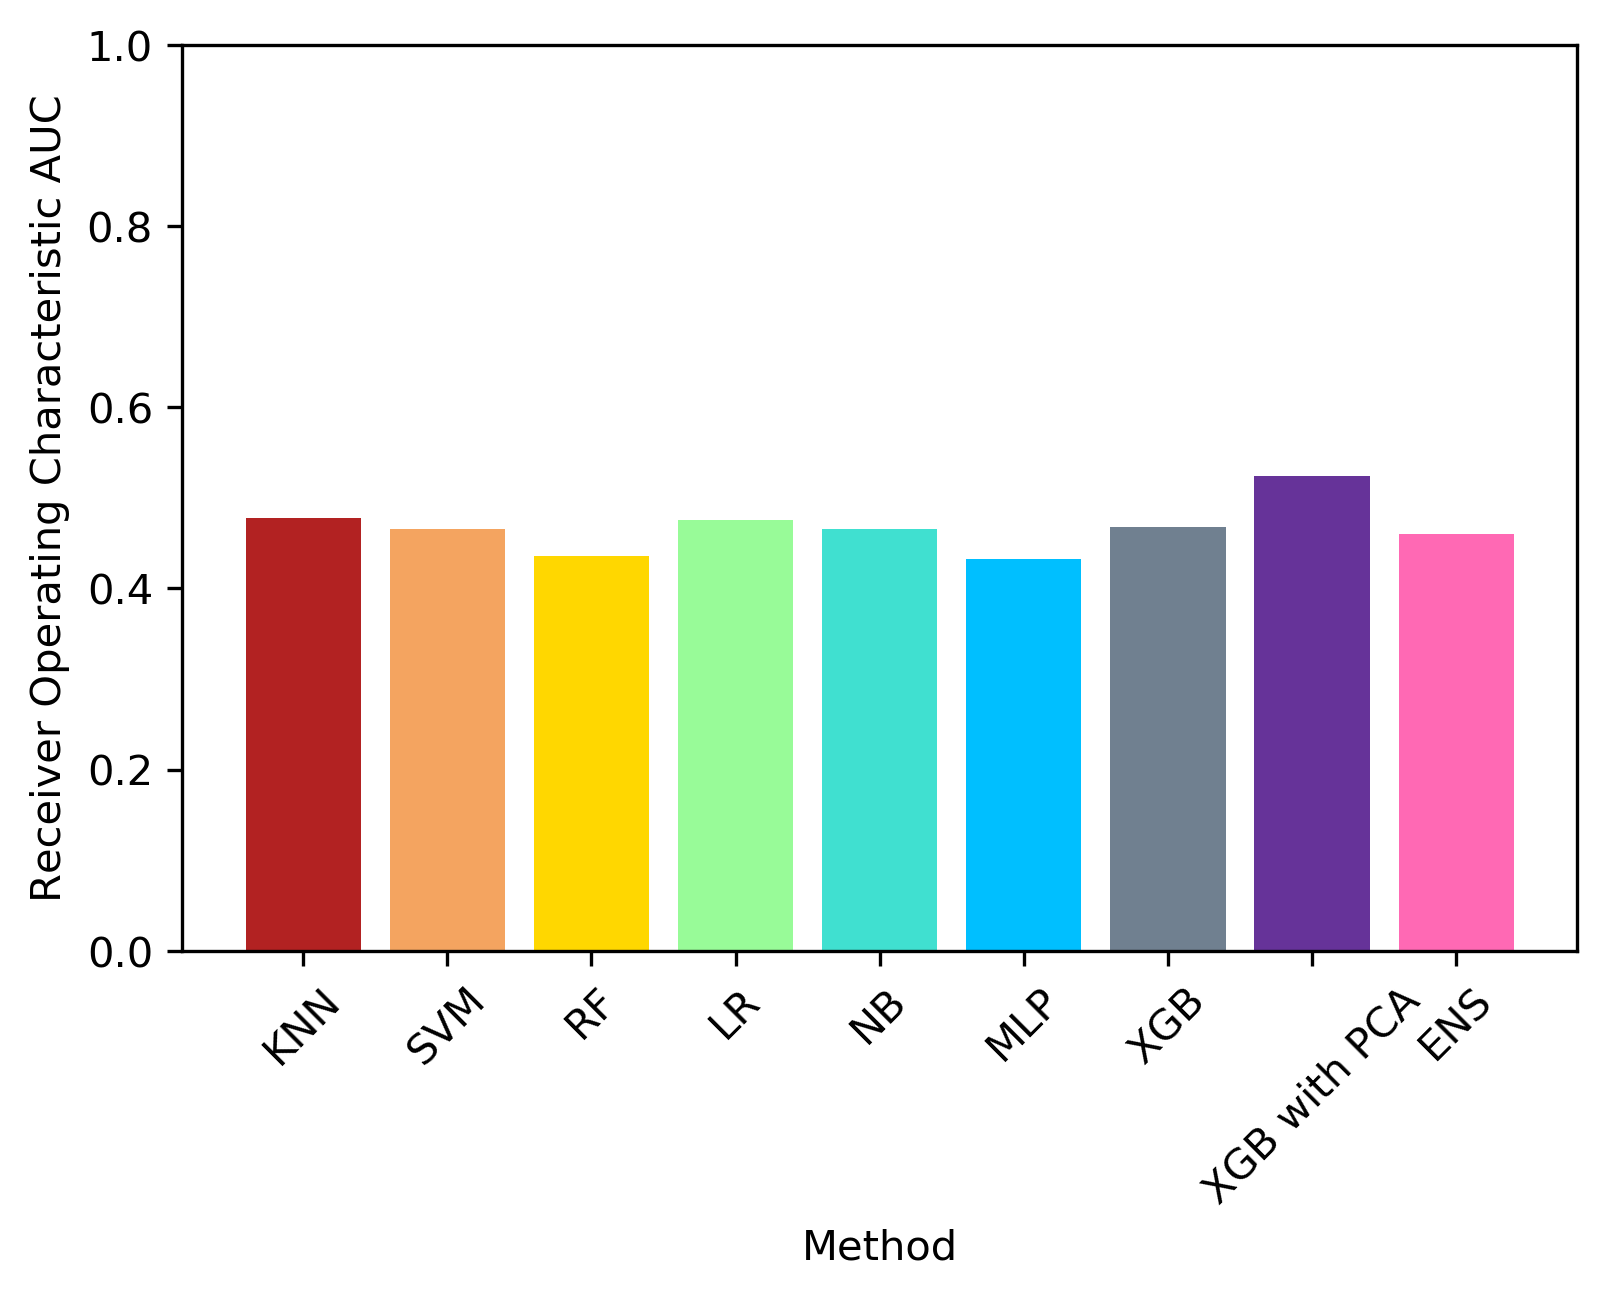

In [433]:
barPlot((KNN_ROCAUC, SVM_ROCAUC, RF_ROCAUC, 
         LR_ROCAUC, NB_ROCAUC, MLP_ROCAUC, XGB_ROCAUC, 
         XGB_PCA_ROCAUC, ENS_ROCAUC),
       ('KNN', 'SVM', 'RF', 'LR', 'NB', 'MLP', 'XGB', 'XGB with PCA', 'ENS'),
       'Receiver Operating Characteristic AUC')

### Average Cross Validation for each method

In [206]:
KNN_CrossVal = np.mean(np.array([ cv_kNN_DILI1.mean(),
                  cv_kNN_DILI3.mean(),
                  cv_kNN_DILI5.mean(),
                  cv_kNN_DILI6.mean() ]))

NB_CrossVal = np.mean(np.array([ cv_nB_DILI1.mean(),
                  cv_nB_DILI3.mean(),
                  cv_nB_DILI5.mean(),
                  cv_nB_DILI6.mean() ]))

SVM_CrossVal = np.mean(np.array([ cv_sVM_DILI1.mean(),
                  cv_sVM_DILI3.mean(),
                  cv_sVM_DILI5.mean(),
                  cv_sVM_DILI6.mean() ]))

RF_CrossVal = np.mean(np.array([ cv_rF_DILI1.mean(),
                  cv_rF_DILI3.mean(),
                  cv_rF_DILI5.mean(),
                  cv_rF_DILI6.mean() ]))

LR_CrossVal = np.mean(np.array([ cv_lR_DILI1.mean(),
                  cv_lR_DILI3.mean(),
                  cv_lR_DILI5.mean(),
                  cv_lR_DILI6.mean() ]))

MLP_CrossVal = np.mean(np.array([ cv_mlp_DILI1.mean(),
                  cv_mlp_DILI3.mean(),
                  cv_mlp_DILI5.mean(),
                  cv_mlp_DILI6.mean() ]))

XGB_CrossVal = np.mean(np.array([ cv_xgb1_DILI1.mean(),
                  cv_xgb1_DILI3.mean(),
                  cv_xgb1_DILI5.mean(),
                  cv_xgb1_DILI6.mean() ]))

XGB_PCA_CrossVal = np.mean(np.array([ cv_xgb2_DILI1.mean(),
                  cv_xgb2_DILI3.mean(),
                  cv_xgb2_DILI5.mean(),
                  cv_xgb2_DILI6.mean() ]))

ENS_CrossVal = np.mean(np.array([ cv_ens_DILI1.mean(),
                  cv_ens_DILI3.mean(),
                  cv_ens_DILI5.mean(),
                  cv_ens_DILI6.mean() ]))

In [304]:
print("Cross Validation")
print("KNN: ", KNN_CrossVal)
print("SVM: ", SVM_CrossVal)
print("RF: ", RF_CrossVal)
print("LR: ", LR_CrossVal)
print("NB: ", NB_CrossVal)
print("MLP: ", MLP_CrossVal)
print("XGB: ", XGB_CrossVal)
print("XGB with PCA: ", XGB_PCA_CrossVal)
print("ENS: ", ENS_CrossVal)

Cross Validation
KNN:  0.6332219251336899
SVM:  0.631060606060606
RF:  0.60701871657754
LR:  0.6362299465240642
NB:  0.5015819964349376
MLP:  0.5874108734402852
XGB:  0.6271390374331551
XGB with PCA:  0.6303475935828877
ENS:  0.6084670231729056


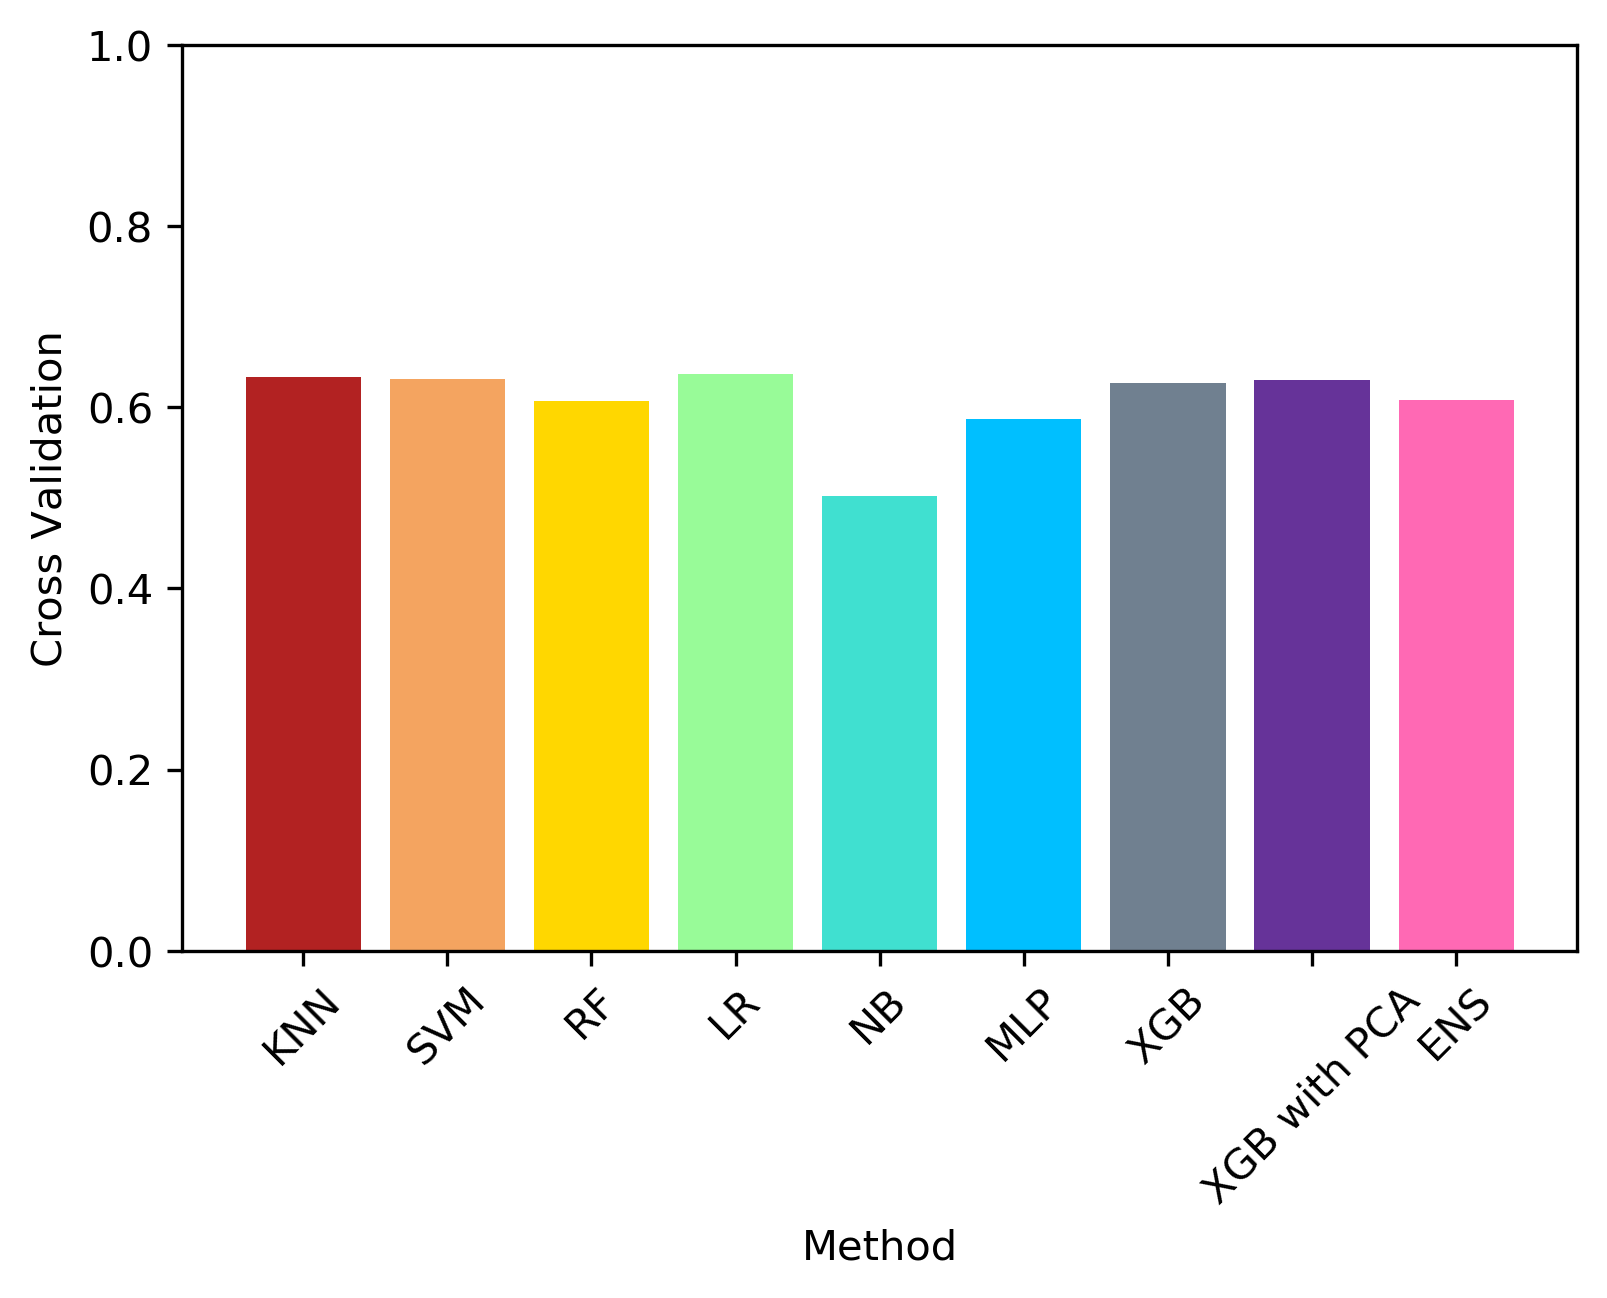

In [434]:
barPlot((KNN_CrossVal, SVM_CrossVal, RF_CrossVal, 
         LR_CrossVal, NB_CrossVal, MLP_CrossVal, XGB_CrossVal, 
         XGB_PCA_CrossVal, ENS_CrossVal),
       ('KNN', 'SVM', 'RF', 'LR', 'NB', 'MLP', 'XGB', 'XGB with PCA', 'ENS'),
       'Cross Validation')

### Average Score

In [209]:
KNN_Score = np.mean(np.array([ s_kNN_DILI1,
                  s_kNN_DILI3,
                  s_kNN_DILI5,
                  s_kNN_DILI6 ]))

NB_Score = np.mean(np.array([ s_nB_DILI1,
                  s_nB_DILI3,
                  s_nB_DILI5,
                  s_nB_DILI6 ]))

SVM_Score = np.mean(np.array([ s_sVM_DILI1,
                  s_sVM_DILI3,
                  s_sVM_DILI5,
                  s_sVM_DILI6 ]))

RF_Score = np.mean(np.array([ s_rF_DILI1,
                  s_rF_DILI3,
                  s_rF_DILI5,
                  s_rF_DILI6 ]))

LR_Score = np.mean(np.array([ s_lR_DILI1,
                  s_lR_DILI3,
                  s_lR_DILI5,
                  s_lR_DILI6 ]))

MLP_Score = np.mean(np.array([ s_mlp_DILI1,
                  s_mlp_DILI3,
                  s_mlp_DILI5,
                  s_mlp_DILI6 ]))

XGB_Score = np.mean(np.array([ s_xgb1_DILI1,
                  s_xgb1_DILI3,
                  s_xgb1_DILI5,
                  s_xgb1_DILI6 ]))

XGB_PCA_Score = np.mean(np.array([ s_xgb2_DILI1,
                  s_xgb2_DILI3,
                  s_xgb2_DILI5,
                  s_xgb2_DILI6 ]))

ENS_Score = np.mean(np.array([ s_ens_DILI1,
                  s_ens_DILI3,
                  s_ens_DILI5,
                  s_ens_DILI6 ]))

In [307]:
print("Score")
print("KNN: ", KNN_Score)
print("SVM: ", SVM_Score)
print("RF: ", RF_Score)
print("LR: ", LR_Score)
print("NB: ", NB_Score)
print("MLP: ", MLP_Score)
print("XGB: ", XGB_Score)
print("XGB with PCA: ", XGB_PCA_Score)
print("ENS: ", ENS_Score)

Score
KNN:  0.6927710843373495
SVM:  0.8893072289156626
RF:  0.9856927710843373
LR:  0.7304216867469879
NB:  0.6641566265060241
MLP:  1.0
XGB:  0.7304216867469879
XGB with PCA:  0.737198795180723
ENS:  0.9352409638554217


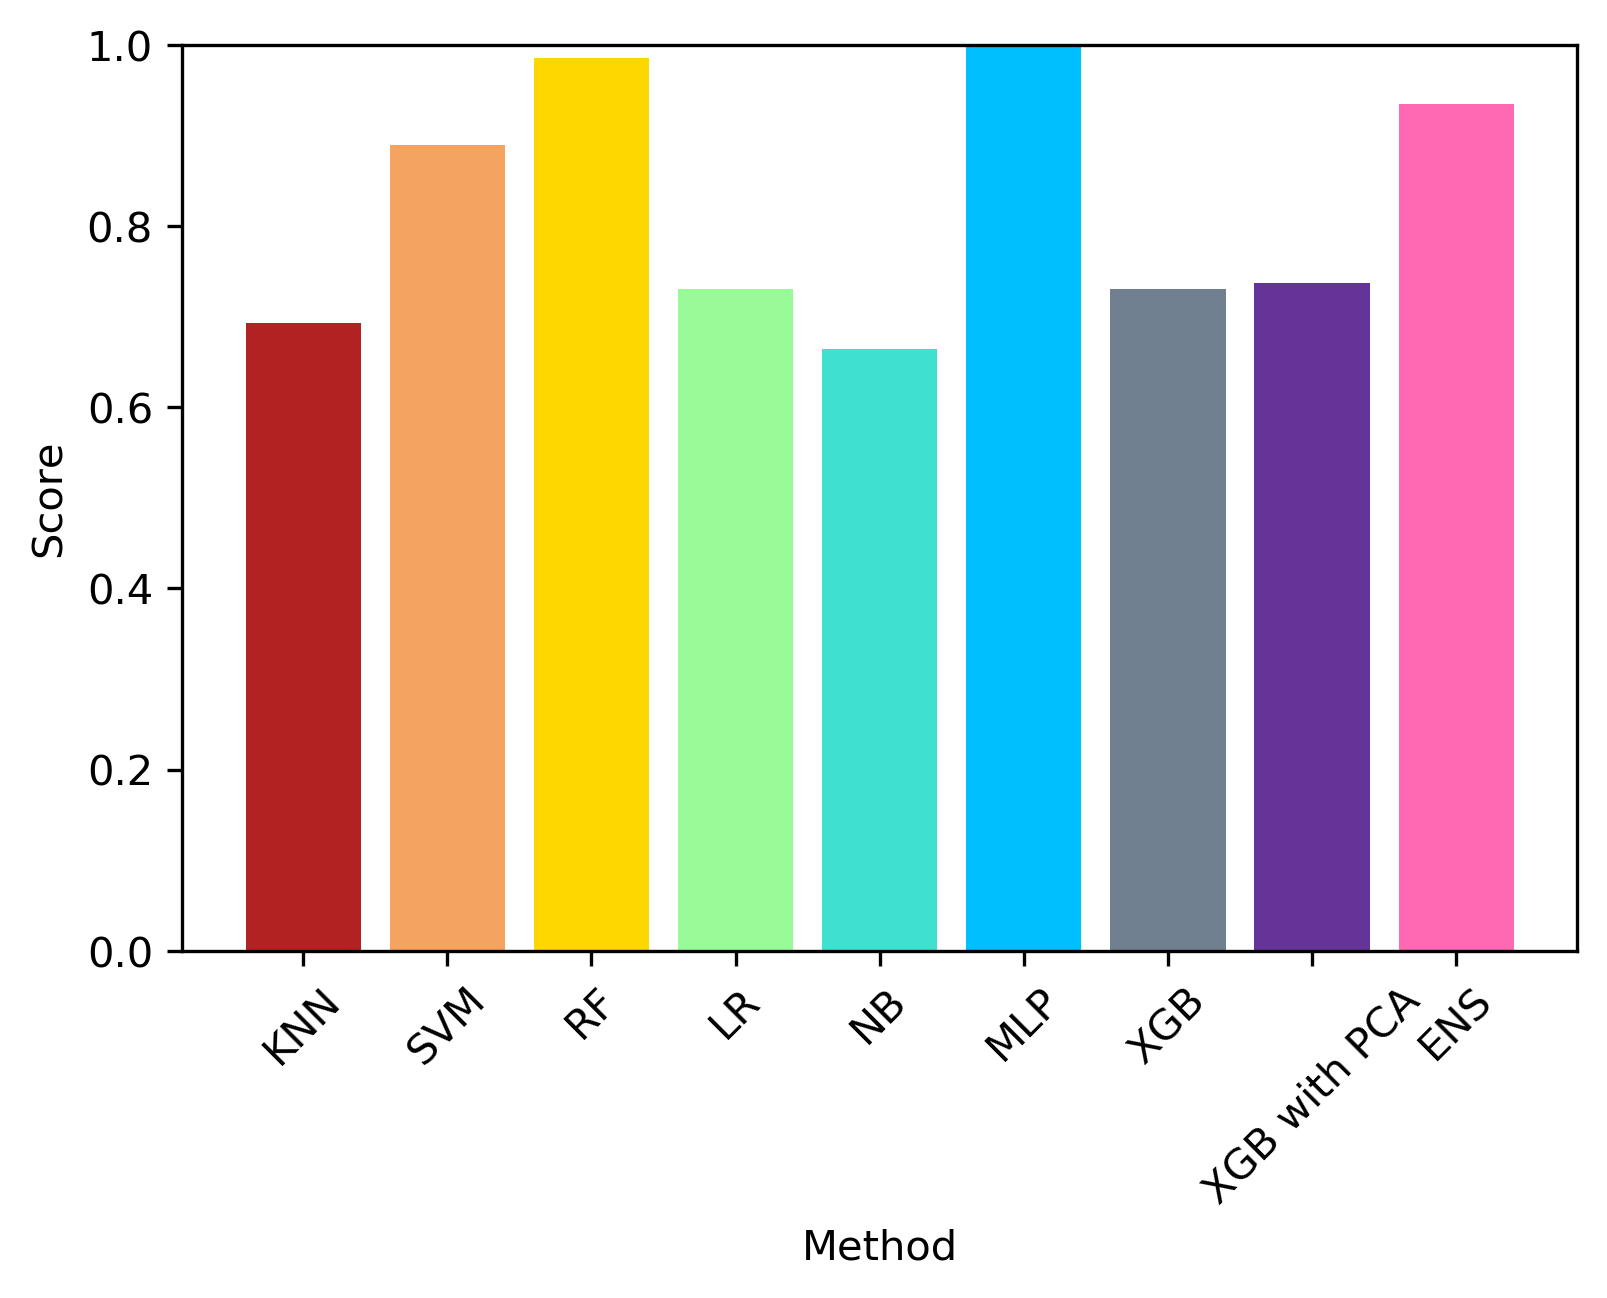

In [435]:
barPlot((KNN_Score, SVM_Score, RF_Score, 
         LR_Score, NB_Score, MLP_Score, XGB_Score, 
         XGB_PCA_Score, ENS_Score),
       ('KNN', 'SVM', 'RF', 'LR', 'NB', 'MLP', 'XGB', 'XGB with PCA', 'ENS'),
       'Score')

#### Rank methods for each metric

In [388]:

Rank_Accuracy = pd.Series(np.array([KNN_accuracy, SVM_accuracy, RF_accuracy, 
                                      LR_accuracy, NB_accuracy, MLP_accuracy, 
                                      XGB_accuracy, XGB_PCA_accuracy, ENS_accuracy]),
                             index = ['KNN', 'SVM', 'RF', 'LR', 'NB', 'MLP', 
                                                  'XGB', 'XGB with PCA', 'ENS'],
                         name = 'Accuracy').sort_values(ascending = False)

In [389]:
Rank_Accuracy

ENS             0.626506
XGB             0.626506
RF              0.614458
KNN             0.614458
MLP             0.605422
LR              0.602410
SVM             0.602410
XGB with PCA    0.557229
NB              0.524096
Name: Accuracy, dtype: float64

In [390]:

Rank_Balanced_Accuracy = pd.Series(np.array([KNN_balanced_accuracy, SVM_balanced_accuracy, 
                                                RF_balanced_accuracy, LR_balanced_accuracy, 
                                                NB_balanced_accuracy, MLP_balanced_accuracy, 
                                                XGB_balanced_accuracy, XGB_PCA_balanced_accuracy, 
                                                ENS_balanced_accuracy]),
                                      index = ['KNN', 'SVM', 'RF', 'LR', 'NB', 'MLP', 
                                                  'XGB', 'XGB with PCA', 'ENS'],
                                  name = 'Balanced Accuracy').sort_values(ascending = False)

In [391]:
Rank_Balanced_Accuracy

ENS             0.547616
MLP             0.541684
NB              0.531803
XGB             0.531506
KNN             0.527487
RF              0.525555
SVM             0.509496
LR              0.505702
XGB with PCA    0.468181
Name: Balanced Accuracy, dtype: float64

In [403]:

Rank_Precision = pd.Series(np.array([KNN_precision, SVM_precision, 
                                                RF_precision, LR_precision, 
                                                NB_precision, MLP_precision, 
                                                XGB_precision, XGB_PCA_precision, 
                                                ENS_precision]),
                                      index = ['KNN', 'SVM', 'RF', 'LR', 'NB', 'MLP', 
                                                  'XGB', 'XGB with PCA', 'ENS'],
                          name = 'Precision').sort_values(ascending = False)

In [404]:
Rank_Precision

NB              0.426681
ENS             0.386781
MLP             0.368996
KNN             0.361642
RF              0.327002
SVM             0.232327
XGB with PCA    0.207143
XGB             0.139423
LR              0.119565
Name: Precision, dtype: float64

In [394]:

Rank_F1 = pd.Series(np.array([KNN_F1, SVM_F1, RF_F1, LR_F1, NB_F1, MLP_F1, XGB_F1, 
                                 XGB_PCA_F1, ENS_F1]),
                       index = ['KNN', 'SVM', 'RF', 'LR', 'NB', 'MLP', 'XGB', 
                                'XGB with PCA', 'ENS'],
                   name = 'F1').sort_values(ascending = False)

In [395]:
Rank_F1

NB              0.423800
MLP             0.396641
ENS             0.365510
KNN             0.322350
RF              0.267631
SVM             0.236288
XGB with PCA    0.214449
XGB             0.161111
LR              0.130952
Name: F1, dtype: float64

In [396]:

Rank_ROCAUC = pd.Series(np.array([KNN_ROCAUC, SVM_ROCAUC, RF_ROCAUC, LR_ROCAUC, NB_ROCAUC, 
                                     MLP_ROCAUC, XGB_ROCAUC, XGB_PCA_ROCAUC, ENS_ROCAUC]),
                           index = ['KNN', 'SVM', 'RF', 'LR', 'NB', 'MLP', 'XGB', 
                                    'XGB with PCA', 'ENS'],
                       name = 'ROCAUC').sort_values(ascending = False)

In [397]:
Rank_ROCAUC

XGB with PCA    0.523675
KNN             0.477662
LR              0.475292
XGB             0.467544
NB              0.465469
SVM             0.465072
ENS             0.460211
RF              0.436150
MLP             0.432172
Name: ROCAUC, dtype: float64

In [398]:

Rank_CrossVal = pd.Series(np.array([KNN_CrossVal, SVM_CrossVal, RF_CrossVal, 
                                       LR_CrossVal, NB_CrossVal, MLP_CrossVal, XGB_CrossVal, 
                                       XGB_PCA_CrossVal, ENS_CrossVal]),
                             index = ['KNN', 'SVM', 'RF', 'LR', 'NB', 'MLP', 'XGB', 
                                      'XGB with PCA', 'ENS'],
                         name = 'CrossVal').sort_values(ascending = False)

In [399]:
Rank_CrossVal

LR              0.636230
KNN             0.633222
SVM             0.631061
XGB with PCA    0.630348
XGB             0.627139
ENS             0.608467
RF              0.607019
MLP             0.587411
NB              0.501582
Name: CrossVal, dtype: float64

In [400]:

Rank_Score = pd.Series(np.array([KNN_Score, SVM_Score, RF_Score, LR_Score, 
                                    NB_Score, MLP_Score, XGB_Score,
                                    XGB_PCA_Score, ENS_Score]),
                       index = ['KNN', 'SVM', 'RF', 'LR', 'NB', 'MLP', 'XGB', 
                                'XGB with PCA', 'ENS'],
                      name = 'Score').sort_values(ascending = False)

In [401]:
Rank_Score

MLP             1.000000
RF              0.985693
ENS             0.935241
SVM             0.889307
XGB with PCA    0.737199
XGB             0.730422
LR              0.730422
KNN             0.692771
NB              0.664157
Name: Score, dtype: float64

In [447]:
Final_Ranks = pd.concat([Rank_Accuracy, Rank_Balanced_Accuracy, Rank_Precision, Rank_F1,
                        Rank_ROCAUC, Rank_CrossVal, Rank_Score], axis=1)

In [448]:
Final_Ranks

Accuracy  Balanced Accuracy  Precision        F1    ROCAUC  \
ENS           0.626506           0.547616   0.386781  0.365510  0.460211   
XGB           0.626506           0.531506   0.139423  0.161111  0.467544   
RF            0.614458           0.525555   0.327002  0.267631  0.436150   
KNN           0.614458           0.527487   0.361642  0.322350  0.477662   
MLP           0.605422           0.541684   0.368996  0.396641  0.432172   
LR            0.602410           0.505702   0.119565  0.130952  0.475292   
SVM           0.602410           0.509496   0.232327  0.236288  0.465072   
XGB with PCA  0.557229           0.468181   0.207143  0.214449  0.523675   
NB            0.524096           0.531803   0.426681  0.423800  0.465469   

              CrossVal     Score  
ENS           0.608467  0.935241  
XGB           0.627139  0.730422  
RF            0.607019  0.985693  
KNN           0.633222  0.692771  
MLP           0.587411  1.000000  
LR            0.636230  0.730422  
SVM           0.631061  0.889307  
XGB with PCA  0.630348  0.737199  
NB            0.501582  0.664157

In [449]:
Final_Ranks['Average Metric'] = Final_Ranks.mean(axis=1)

In [450]:
Final_Ranks = Final_Ranks.sort_values(by = 'Average Metric', ascending = False)

In [451]:
Final_Ranks

Accuracy  Balanced Accuracy  Precision        F1    ROCAUC  \
MLP           0.605422           0.541684   0.368996  0.396641  0.432172   
ENS           0.626506           0.547616   0.386781  0.365510  0.460211   
RF            0.614458           0.525555   0.327002  0.267631  0.436150   
KNN           0.614458           0.527487   0.361642  0.322350  0.477662   
SVM           0.602410           0.509496   0.232327  0.236288  0.465072   
NB            0.524096           0.531803   0.426681  0.423800  0.465469   
XGB with PCA  0.557229           0.468181   0.207143  0.214449  0.523675   
XGB           0.626506           0.531506   0.139423  0.161111  0.467544   
LR            0.602410           0.505702   0.119565  0.130952  0.475292   

              CrossVal     Score  Average Metric  
MLP           0.587411  1.000000        0.561761  
ENS           0.608467  0.935241        0.561476  
RF            0.607019  0.985693        0.537644  
KNN           0.633222  0.692771        0.518513  
SVM           0.631061  0.889307        0.509423  
NB            0.501582  0.664157        0.505370  
XGB with PCA  0.630348  0.737199        0.476889  
XGB           0.627139  0.730422        0.469093  
LR            0.636230  0.730422        0.457225

In [411]:
Final_Ranks.to_csv('/Users/ravinschmidl/Desktop/Systems_Bio/ML_and_MV_Stats/Assignment/Figures and Tables/Final_Ranks.csv')


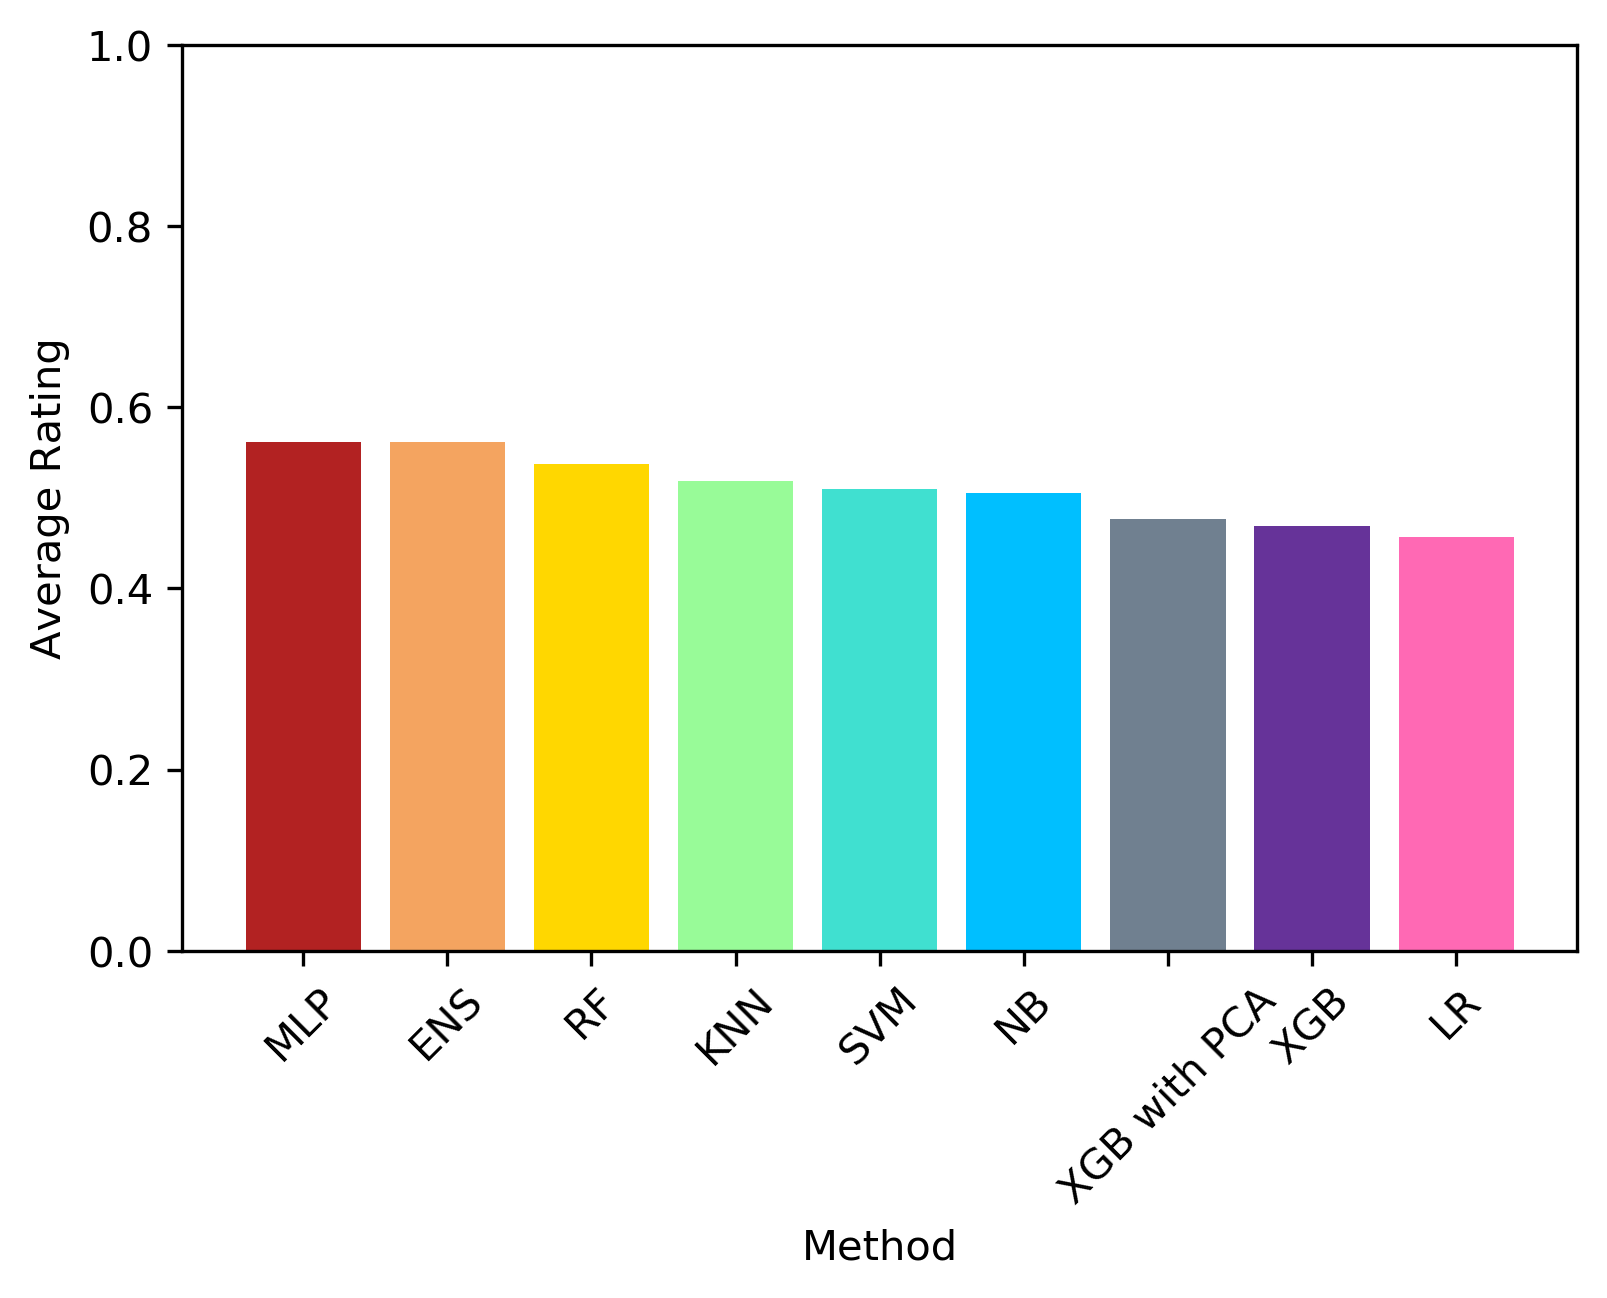

In [457]:
barPlot(Final_Ranks['Average Metric'],
       Final_Ranks.index,
       'Average Rating')

## Classification of unknown drugs

In [413]:
Final_Train.describe()

CAM_ID      CAM00001      CAM00003      CAM00005      CAM00006      CAM00007  \
count   24656.000000  24656.000000  24656.000000  24656.000000  24656.000000   
mean        0.189100     -0.082068      0.104247      0.005204      0.400748   
std         0.671710      0.571961      0.750554      0.666984      1.442477   
min       -10.000000     -5.894367     -7.083751     -4.860025     -9.836649   
25%        -0.229053     -0.458556     -0.388603     -0.443747     -0.332332   
50%         0.221135     -0.092757      0.111702     -0.012112      0.182241   
75%         0.628626      0.288711      0.627839      0.446261      1.061136   
max         5.393650      4.371537      6.340635      4.801277      7.305336   

CAM_ID      CAM00008      CAM00010      CAM00011      CAM00012      CAM00014  \
count   24656.000000  24656.000000  24656.000000  24656.000000  24656.000000   
mean        0.088958     -0.054069      0.330428     -0.160941     -0.186943   
std         0.462115      0.367377      1.037704      0.660702      0.683893   
min        -3.914070     -3.189041     -8.751517     -6.179064     -8.609500   
25%        -0.202555     -0.289608     -0.311779     -0.620296     -0.650589   
50%         0.081119     -0.069496      0.443652     -0.176608     -0.227342   
75%         0.384676      0.169954      1.045985      0.281142      0.237889   
max         4.273090      4.281795      8.531927      9.737426      5.516400   

CAM_ID  ...      CAM00607      CAM00609      CAM00610      CAM00611  \
count   ...  24656.000000  24656.000000  24656.000000  24656.000000   
mean    ...     -0.070353      0.343495     -0.127002     -0.096003   
std     ...      0.516189      0.879031      0.645897      0.604754   
min     ...     -4.060293     -6.009440     -8.303508     -9.374563   
25%     ...     -0.406880     -0.205748     -0.542666     -0.451408   
50%     ...     -0.053371      0.433331     -0.154209     -0.128467   
75%     ...      0.264303      0.964497      0.274974      0.250030   
max     ...      3.970757      6.552437      6.820938      8.269907   

CAM_ID      CAM00612      CAM00613      CAM00614      CAM00615      CAM00616  \
count   24656.000000  24656.000000  24656.000000  24656.000000  24656.000000   
mean       -0.069329      0.053469      0.031266      0.289026     -0.064219   
std         0.692881      0.573091      0.633885      1.063098      0.669598   
min        -4.463806     -5.314000     -6.476171     -9.694099     -8.224147   
25%        -0.554442     -0.296700     -0.359154     -0.368059     -0.465246   
50%        -0.030073      0.069449      0.012892      0.341725     -0.099072   
75%         0.402170      0.413300      0.428912      1.012213      0.322638   
max         6.649595      5.149800      6.064028      8.601645      9.028598   

CAM_ID      CAM00617  
count   24656.000000  
mean        0.104062  
std         0.833119  
min        -6.932332  
25%        -0.433365  
50%         0.074372  
75%         0.646568  
max         5.531594  

[8 rows x 415 columns]

In [415]:
Final_Test.describe()

CAM_ID      CAM00002      CAM00004      CAM00009      CAM00013      CAM00015  \
count   24656.000000  24656.000000  24656.000000  24656.000000  24656.000000   
mean       -0.125879      0.078887      0.170604      0.160798      0.032356   
std         0.581707      0.769003      0.803382      0.689943      0.910109   
min        -5.032979     -6.463491     -7.099800     -5.350266     -5.597938   
25%        -0.515167     -0.398966     -0.320530     -0.244036     -0.623397   
50%        -0.150865      0.128079      0.167820      0.158972     -0.000171   
75%         0.238350      0.564129      0.689607      0.562895      0.655419   
max         6.279713      6.788373      6.533618      4.646087      6.172628   

CAM_ID      CAM00016      CAM00027      CAM00029      CAM00031      CAM00032  \
count   24656.000000  24656.000000  24656.000000  24656.000000  24656.000000   
mean        0.466791     -0.053754     -0.199210     -0.134600      0.108846   
std         1.306824      0.647643      0.637460      0.685931      0.774210   
min       -10.000000     -6.712098     -6.119092     -8.838551     -7.793700   
25%        -0.386138     -0.467734     -0.649535     -0.584108     -0.344706   
50%         0.518727     -0.052482     -0.229557     -0.148365      0.142438   
75%         1.404258      0.361381      0.223717      0.296900      0.592125   
max         8.229040      7.486445      6.173655      5.325800      6.231150   

CAM_ID  ...      CAM00584      CAM00585      CAM00586      CAM00587  \
count   ...  24656.000000  24656.000000  24656.000000  24656.000000   
mean    ...     -0.055941     -0.089638      0.069345     -0.099199   
std     ...      0.577256      0.886449      0.741205      0.592687   
min     ...     -5.444750     -7.079731     -8.263691     -6.519187   
25%     ...     -0.433857     -0.610287     -0.375061     -0.481934   
50%     ...     -0.021737     -0.096645      0.081025     -0.107995   
75%     ...      0.308901      0.428500      0.519400      0.269149   
max     ...      5.972791     10.000000      7.903252      7.241383   

CAM_ID      CAM00589      CAM00594      CAM00595      CAM00605      CAM00606  \
count   24656.000000  24656.000000  24656.000000  24656.000000  24656.000000   
mean        0.263028      0.273052     -0.115539     -0.179726     -0.051234   
std         0.894224      0.816535      0.666528      0.663479      0.588503   
min        -9.182421     -5.952933     -5.255307     -8.909849     -7.722401   
25%        -0.326480     -0.248934     -0.556564     -0.649842     -0.394263   
50%         0.362000      0.312174     -0.120746     -0.218946     -0.062902   
75%         0.906829      0.807906      0.313862      0.258457      0.298901   
max         8.365819      5.217371      5.420250      8.871488      6.664812   

CAM_ID      CAM00608  
count   24656.000000  
mean       -0.004658  
std         0.711418  
min        -7.196652  
25%        -0.475168  
50%        -0.041429  
75%         0.471780  
max         8.276925  

[8 rows x 194 columns]

In [417]:
ytrain

DILI1  DILI3  DILI5  DILI6
CAM_ID                              
CAM00001    0.0    0.0    1.0    0.0
CAM00003    0.0    0.0    1.0    0.0
CAM00005    0.0    0.0    0.0    0.0
CAM00006    0.0    0.0    0.0    1.0
CAM00007    0.0    0.0    1.0    0.0
...         ...    ...    ...    ...
CAM00613    1.0    1.0    0.0    0.0
CAM00614    1.0    1.0    0.0    0.0
CAM00615    1.0    1.0    0.0    1.0
CAM00616    1.0    1.0    0.0    1.0
CAM00617    1.0    1.0    0.0    0.0

[415 rows x 4 columns]

In [418]:
ytest

DILI1  DILI3  DILI5  DILI6
CAM_ID                              
CAM00002    NaN    NaN    NaN    NaN
CAM00004    NaN    NaN    NaN    NaN
CAM00009    NaN    NaN    NaN    NaN
CAM00013    NaN    NaN    NaN    NaN
CAM00015    NaN    NaN    NaN    NaN
...         ...    ...    ...    ...
CAM00594    NaN    NaN    NaN    NaN
CAM00595    NaN    NaN    NaN    NaN
CAM00605    NaN    NaN    NaN    NaN
CAM00606    NaN    NaN    NaN    NaN
CAM00608    NaN    NaN    NaN    NaN

[194 rows x 4 columns]

### Hyperparameter tuning for each method
Use rSearch to save time.

#### KNN

In [422]:
#Initialise a grid of parameters to test over. 
grid_params_KNN = {
        'n_neighbors': [1,3,5,11,25,51,99],
        'weights': ['uniform', 'distance'],
        'metric': ['manhattan', 'euclidean']
    }

KNN_result_DILI1 = rSearch(grid_params_KNN, KNeighborsClassifier(), Final_Train.T, ytrain['DILI1'])
KNN_result_DILI3 = rSearch(grid_params_KNN, KNeighborsClassifier(), Final_Train.T, ytrain['DILI3'])
KNN_result_DILI5 = rSearch(grid_params_KNN, KNeighborsClassifier(), Final_Train.T, ytrain['DILI5'])
KNN_result_DILI6 = rSearch(grid_params_KNN, KNeighborsClassifier(), Final_Train.T, ytrain['DILI6'])

print("DILI1")
print("Best Score: ", KNN_result_DILI1.best_score_)
print("Best Estimator: ", KNN_result_DILI1.best_estimator_)
print("Best Params: ", KNN_result_DILI1.best_params_)

print("DILI3")
print("Best Score: ", KNN_result_DILI3.best_score_)
print("Best Estimator: ", KNN_result_DILI3.best_estimator_)
print("Best Params: ", KNN_result_DILI3.best_params_)

print("DILI5")
print("Best Score: ", KNN_result_DILI5.best_score_)
print("Best Estimator: ", KNN_result_DILI5.best_estimator_)
print("Best Params: ", KNN_result_DILI5.best_params_)

print("DILI6")
print("Best Score: ", KNN_result_DILI6.best_score_)
print("Best Estimator: ", KNN_result_DILI6.best_estimator_)
print("Best Params: ", KNN_result_DILI6.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 10.2min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 10.2min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 10.9min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 11.7min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


DILI1
Best Score:  0.7759036144578313
Best Estimator:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=None, n_neighbors=51, p=2,
           weights='distance')
Best Params:  {'weights': 'distance', 'n_neighbors': 51, 'metric': 'manhattan'}
DILI3
Best Score:  0.6289156626506024
Best Estimator:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=None, n_neighbors=51, p=2,
           weights='distance')
Best Params:  {'weights': 'distance', 'n_neighbors': 51, 'metric': 'manhattan'}
DILI5
Best Score:  0.5349397590361445
Best Estimator:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=None, n_neighbors=25, p=2,
           weights='uniform')
Best Params:  {'weights': 'uniform', 'n_neighbors': 25, 'metric': 'manhattan'}
DILI6
Best Score:  0.6144578313253012
Best Estimator:  KNeighborsClassifier(algorithm='aut

#### Logistic Regression

In [423]:
grid_params_LR = {
        'penalty': ['l1', 'l2'],
        'C': [0.001,0.01,0.1,1,10,100,1000],
}

LR_result_DILI1 = rSearch(grid_params_LR, linear_model.LogisticRegression(), Final_Train.T, ytrain['DILI1'])
LR_result_DILI3 = rSearch(grid_params_LR, linear_model.LogisticRegression(), Final_Train.T, ytrain['DILI3'])
LR_result_DILI5 = rSearch(grid_params_LR, linear_model.LogisticRegression(), Final_Train.T, ytrain['DILI5'])
LR_result_DILI6 = rSearch(grid_params_LR, linear_model.LogisticRegression(), Final_Train.T, ytrain['DILI6'])

print("DILI1")
print("Best Score: ", LR_result_DILI1.best_score_)
print("Best Estimator: ", LR_result_DILI1.best_estimator_)
print("Best Params: ",LR_result_DILI1.best_params_)

print("DILI3")
print("Best Score: ", LR_result_DILI3.best_score_)
print("Best Estimator: ", LR_result_DILI3.best_estimator_)
print("Best Params: ", LR_result_DILI3.best_params_)

print("DILI5")
print("Best Score: ", LR_result_DILI5.best_score_)
print("Best Estimator: ", LR_result_DILI5.best_estimator_)
print("Best Params: ", LR_result_DILI5.best_params_)

print("DILI6")
print("Best Score: ", LR_result_DILI6.best_score_)
print("Best Estimator: ", LR_result_DILI6.best_estimator_)
print("Best Params: ", LR_result_DILI6.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/p

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/p

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/p

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/p

DILI1
Best Score:  0.7759036144578313
Best Estimator:  LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Best Params:  {'penalty': 'l1', 'C': 0.001}
DILI3
Best Score:  0.619277108433735
Best Estimator:  LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Best Params:  {'penalty': 'l1', 'C': 0.001}
DILI5
Best Score:  0.5204819277108433
Best Estimator:  LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
 

#### Support Vector Machine

In [424]:
grid_params_SVM = {
        'C': [0.001,0.01,0.1,1,10,100,1000],
        'gamma': ['scale', 'auto']
}

SVM_result_DILI1 = rSearch(grid_params_SVM, svm.SVC(), Final_Train.T, ytrain['DILI1'])
SVM_result_DILI3 = rSearch(grid_params_SVM, svm.SVC(), Final_Train.T, ytrain['DILI3'])
SVM_result_DILI5 = rSearch(grid_params_SVM, svm.SVC(), Final_Train.T, ytrain['DILI5'])
SVM_result_DILI6 = rSearch(grid_params_SVM, svm.SVC(), Final_Train.T, ytrain['DILI6'])

print("DILI1")
print("Best Score: ", SVM_result_DILI1.best_score_)
print("Best Estimator: ", SVM_result_DILI1.best_estimator_)
print("Best Params: ", SVM_result_DILI1.best_params_)

print("DILI3")
print("Best Score: ", SVM_result_DILI3.best_score_)
print("Best Estimator: ", SVM_result_DILI3.best_estimator_)
print("Best Params: ", SVM_result_DILI3.best_params_)

print("DILI5")
print("Best Score: ", SVM_result_DILI5.best_score_)
print("Best Estimator: ", SVM_result_DILI5.best_estimator_)
print("Best Params: ", SVM_result_DILI5.best_params_)

print("DILI6")
print("Best Score: ", SVM_result_DILI6.best_score_)
print("Best Estimator: ", SVM_result_DILI6.best_estimator_)
print("Best Params: ", SVM_result_DILI6.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 16.3min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 16.6min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 16.1min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 16.2min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


DILI1
Best Score:  0.7759036144578313
Best Estimator:  SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Best Params:  {'gamma': 'auto', 'C': 0.001}
DILI3
Best Score:  0.6289156626506024
Best Estimator:  SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Best Params:  {'gamma': 'auto', 'C': 1}
DILI5
Best Score:  0.5277108433734939
Best Estimator:  SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Best Params:  {'gamma': 'scale', 'C': 1}
DILI6
Best Score:  0.624096385542168

#### Multilayer Perceptron

In [425]:
grid_params_MLP = {
        'hidden_layer_sizes': [(20,20,20), (50,50,50), (100,100,100), (200,200,200)],    
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'learning_rate': ['constant', 'invscaling', 'adaptive']
}

MLP_result_DILI1 = rSearch(grid_params_MLP, MLPClassifier(), Final_Train.T, ytrain['DILI1'])
MLP_result_DILI3 = rSearch(grid_params_MLP, MLPClassifier(), Final_Train.T, ytrain['DILI3'])
MLP_result_DILI5 = rSearch(grid_params_MLP, MLPClassifier(), Final_Train.T, ytrain['DILI5'])
MLP_result_DILI6 = rSearch(grid_params_MLP, MLPClassifier(), Final_Train.T, ytrain['DILI6'])

print("DILI1")
print("Best Score: ", MLP_result_DILI1.best_score_)
print("Best Estimator: ", MLP_result_DILI1.best_estimator_)
print("Best Params: ", MLP_result_DILI1.best_params_)

print("DILI3")
print("Best Score: ", MLP_result_DILI3.best_score_)
print("Best Estimator: ", MLP_result_DILI3.best_estimator_)
print("Best Params: ", MLP_result_DILI3.best_params_)

print("DILI5")
print("Best Score: ", MLP_result_DILI5.best_score_)
print("Best Estimator: ", MLP_result_DILI5.best_estimator_)
print("Best Params: ", MLP_result_DILI5.best_params_)

print("DILI6")
print("Best Score: ", MLP_result_DILI6.best_score_)
print("Best Estimator: ", MLP_result_DILI6.best_estimator_)
print("Best Params: ", MLP_result_DILI6.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: Conv

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: Conv

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: Conv

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: Conv

DILI1
Best Score:  0.691566265060241
Best Estimator:  MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
Best Params:  {'learning_rate': 'constant', 'hidden_layer_sizes': (100, 100, 100), 'activation': 'relu'}
DILI3
Best Score:  0.5783132530120482
Best Estimator:  MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 50, 50), learning_rate='invscaling',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, powe

#### XGB without PCA

In [463]:
grid_params_XGB = {
        'max_depth' : [4,5,6,7,8],    
        'booster': ['gbtree', 'gblinear', 'dart'],
        'n_estimators': [10,50,100,200,500],
        'reg_alpha': [0,1],
        'reg_lambda': [0,1],
        'gamma': [0,1]
}

XGB_result_DILI1 = rSearch(grid_params_XGB, xgb.XGBClassifier(), Final_Train.T, ytrain['DILI1'])
XGB_result_DILI3 = rSearch(grid_params_XGB, xgb.XGBClassifier(), Final_Train.T, ytrain['DILI3'])
XGB_result_DILI5 = rSearch(grid_params_XGB, xgb.XGBClassifier(), Final_Train.T, ytrain['DILI5'])
XGB_result_DILI6 = rSearch(grid_params_XGB, xgb.XGBClassifier(), Final_Train.T, ytrain['DILI6'])

print("DILI1")
print("Best Score: ", XGB_result_DILI1.best_score_)
print("Best Estimator: ", XGB_result_DILI1.best_estimator_)
print("Best Params: ", XGB_result_DILI1.best_params_)

print("DILI3")
print("Best Score: ", XGB_result_DILI3.best_score_)
print("Best Estimator: ", XGB_result_DILI3.best_estimator_)
print("Best Params: ", XGB_result_DILI3.best_params_)

print("DILI5")
print("Best Score: ", XGB_result_DILI5.best_score_)
print("Best Estimator: ", XGB_result_DILI5.best_estimator_)
print("Best Params: ", XGB_result_DILI5.best_params_)

print("DILI6")
print("Best Score: ", XGB_result_DILI6.best_score_)
print("Best Estimator: ", XGB_result_DILI6.best_estimator_)
print("Best Params: ", XGB_result_DILI6.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed: 37.0min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed: 18.9min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed: 14.6min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed: 37.0min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


DILI1
Best Score:  0.7759036144578313
Best Estimator:  XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=1, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.5, max_delta_step=None, max_depth=6,
       min_child_weight=None, missing=nan, monotone_constraints=None,
       n_estimators=50, n_jobs=0, num_parallel_tree=None,
       objective='binary:logistic', random_state=0, reg_alpha=1,
       reg_lambda=1, scale_pos_weight=1, subsample=None, tree_method=None,
       validate_parameters=False, verbosity=None)
Best Params:  {'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 50, 'max_depth': 6, 'gamma': 1, 'booster': 'gblinear'}
DILI3
Best Score:  0.619277108433735
Best Estimator:  XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=0, gpu_id=-1,
       importance_type='gain', interact

In [464]:
grid_params_ens = {
        'weights': [(1,2,2,2,2,2),(1,1,1,1,1,1)]
}

#Initialise Models with hypertuned parameters for different DILI targets

#Logistic Regression
B1_DILI1 = linear_model.LogisticRegression(penalty = 'l1', 
                                           C = 0.001,
                                          solver = 'warn')
B1_DILI3 = linear_model.LogisticRegression(penalty = 'l1',
                                           C = 0.001,
                                          solver = 'warn')
B1_DILI5 = linear_model.LogisticRegression(penalty = 'l1',
                                           C = 0.001,
                                          solver = 'warn')
B1_DILI6 = linear_model.LogisticRegression(penalty = 'l1',
                                           C = 1000,
                                          solver = 'warn')

#Support vector machine
B2_DILI1 = svm.SVC(probability=True, C = 0.001, 
                   gamma = 'auto')
B2_DILI3 = svm.SVC(probability=True, C = 1, 
                   gamma = 'auto')
B2_DILI5 = svm.SVC(probability=True, C = 1, 
                   gamma = 'scale')
B2_DILI6 = svm.SVC(probability=True, C = 1, 
                   gamma = 'scale')

#Naive Bayes
B3 = GaussianNB()

#K-Nearest Neighbours
B4_DILI1 = KNeighborsClassifier(n_neighbors = 51, weights = 'distance', 
                                metric = 'manhattan') 
B4_DILI3 = KNeighborsClassifier(n_neighbors = 51, weights = 'distance', 
                                metric = 'manhattan')
B4_DILI5 = KNeighborsClassifier(n_neighbors = 25, weights = 'uniform', 
                                metric = 'manhattan')
B4_DILI6 = KNeighborsClassifier(n_neighbors = 51, weights = 'distance', 
                                metric = 'euclidean')

#Multilayer Perceptron
B5_DILI1 = MLPClassifier(hidden_layer_sizes = (100,100,100), activation = 'relu', 
                         learning_rate = 'constant')
B5_DILI3 = MLPClassifier(hidden_layer_sizes = (50,50,50), activation = 'relu', 
                         learning_rate = 'invscaling')
B5_DILI5 = MLPClassifier(hidden_layer_sizes = (200,200,200), activation = 'relu', 
                         learning_rate = 'constant')
B5_DILI6 = MLPClassifier(hidden_layer_sizes = (20,20,20), activation = 'relu', 
                         learning_rate = 'adaptive')

#XGB
B6_DILI1 = xgb.XGBClassifier(max_depth = 6, booster = 'gblinear', n_estimators = 50, 
                             reg_alpha = 1, reg_lambda = 1, gamma = 1)
B6_DILI3 = xgb.XGBClassifier(max_depth = 6, booster = 'gblinear', n_estimators = 50, 
                             reg_alpha = 1, reg_lambda = 1, gamma = 0)
B6_DILI5 = xgb.XGBClassifier(max_depth = 7, booster = 'gblinear', n_estimators = 10, 
                             reg_alpha = 1, reg_lambda =0, gamma = 0)
B6_DILI6 = xgb.XGBClassifier(max_depth = 6, booster = 'dart', n_estimators = 100, 
                             reg_alpha = 0, reg_lambda = 0, gamma = 1)


#Build estimators according to DILI
estimators_DILI1 = []
estimators_DILI3 = []
estimators_DILI5 = []
estimators_DILI6 = []

estimators_DILI1.append(('logistic', B1_DILI1))
estimators_DILI1.append(('svm', B2_DILI1))
estimators_DILI1.append(('Gaussian', B3))
estimators_DILI1.append(('KNeighbors', B4_DILI1))
estimators_DILI1.append(('MLP',B5_DILI1))
estimators_DILI1.append(('XGB', B6_DILI1))

estimators_DILI3.append(('logistic', B1_DILI3))
estimators_DILI3.append(('svm', B2_DILI3))
estimators_DILI3.append(('Gaussian', B3))
estimators_DILI3.append(('KNeighbors', B4_DILI3))
estimators_DILI3.append(('MLP', B5_DILI3))
estimators_DILI3.append(('XGB', B6_DILI3))

estimators_DILI5.append(('logistic', B1_DILI5))
estimators_DILI5.append(('svm', B2_DILI5))
estimators_DILI5.append(('Gaussian', B3))
estimators_DILI5.append(('KNeighbors', B4_DILI5))
estimators_DILI5.append(('MLP', B5_DILI5))
estimators_DILI5.append(('XGB', B6_DILI5))

estimators_DILI6.append(('logistic', B1_DILI6))
estimators_DILI6.append(('svm', B2_DILI6))
estimators_DILI6.append(('Gaussian', B3))
estimators_DILI6.append(('KNeighbors', B4_DILI6))
estimators_DILI6.append(('MLP', B5_DILI6))
estimators_DILI6.append(('XGB', B6_DILI6))

#Randomised CV search to tune parameters for ensemble searching
ens_result_DILI1 = rSearch(grid_params_ens, VotingClassifier(estimators_DILI1), Final_Train.T, ytrain['DILI1'])
ens_result_DILI3 = rSearch(grid_params_ens, VotingClassifier(estimators_DILI3), Final_Train.T, ytrain['DILI3'])
ens_result_DILI5 = rSearch(grid_params_ens, VotingClassifier(estimators_DILI5), Final_Train.T, ytrain['DILI5'])
ens_result_DILI6 = rSearch(grid_params_ens, VotingClassifier(estimators_DILI6), Final_Train.T, ytrain['DILI6'])

print("DILI1")
print("Best Score: ", ens_result_DILI1.best_score_)
print("Best Estimator: ", ens_result_DILI1.best_estimator_)
print("Best Params: ", ens_result_DILI1.best_params_)

print("DILI3")
print("Best Score: ", ens_result_DILI3.best_score_)
print("Best Estimator: ", ens_result_DILI3.best_estimator_)
print("Best Params: ", ens_result_DILI3.best_params_)

print("DILI5")
print("Best Score: ", ens_result_DILI5.best_score_)
print("Best Estimator: ", ens_result_DILI5.best_estimator_)
print("Best Params: ", ens_result_DILI5.best_params_)

print("DILI6")
print("Best Score: ", ens_result_DILI6.best_score_)
print("Best Estimator: ", ens_result_DILI6.best_estimator_)
print("Best Params: ", ens_result_DILI6.best_params_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  1.8min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 c

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  1.7min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  2.4min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  6.1min finished
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


DILI1
Best Score:  0.7759036144578313
Best Estimator:  VotingClassifier(estimators=[('logistic', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('svm',...s_weight=None, subsample=None,
       tree_method=None, validate_parameters=False, verbosity=None))],
         flatten_transform=None, n_jobs=None, voting='hard',
         weights=(1, 2, 2, 2, 2, 2))
Best Params:  {'weights': (1, 2, 2, 2, 2, 2)}
DILI3
Best Score:  0.619277108433735
Best Estimator:  VotingClassifier(estimators=[('logistic', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('svm',...s_wei

#### Run ensemble

In [467]:
p_ens_DILI1, y_ens_DILI1, s_ens_DILI1, cv_ens_DILI1 = ensemble(Final_Train.T, 
                                                               Final_Test.T, 
                                                               ytrain['DILI1'],
                                                               estimators_DILI1, #estimators
                                                               'soft', #voting
                                                               (1, 2, 2, 2, 2, 2) #weights
                                                              )
p_ens_DILI3, y_ens_DILI3, s_ens_DILI3, cv_ens_DILI3 = ensemble(Final_Train.T, 
                                                               Final_Test.T, 
                                                               ytrain['DILI3'],
                                                               estimators_DILI3, #estimators
                                                               'soft', #voting
                                                               (1, 1, 1, 1, 1, 1) #weights
                                                              )
p_ens_DILI5, y_ens_DILI5, s_ens_DILI5, cv_ens_DILI5 = ensemble(Final_Train.T, 
                                                               Final_Test.T, 
                                                               ytrain['DILI5'],
                                                               estimators_DILI5, #estimators
                                                               'soft', #voting
                                                               (1, 1, 1, 1, 1, 1) #weights
                                                              )
p_ens_DILI6, y_ens_DILI6, s_ens_DILI6, cv_ens_DILI6 = ensemble(Final_Train.T, 
                                                               Final_Test.T, 
                                                               ytrain['DILI6'],
                                                               estimators_DILI6, #estimators
                                                               'soft', #voting
                                                               (1, 2, 2, 2, 2, 2) #weights
                                                              )


/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

Cross Validation result:  0.7345528455284553 number of kFold splits:  10


/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

Cross Validation result:  0.5877468060394889 number of kFold splits:  10


/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

Cross Validation result:  0.49639953542392573 number of kFold splits:  10


/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

Cross Validation result:  0.6678861788617886 number of kFold splits:  10


In [469]:
print("Score DILI1: ", s_ens_DILI1)
print("Score DILI3: ", s_ens_DILI3)
print("Score DILI5: ", s_ens_DILI5)
print("Score DILI6: ", s_ens_DILI6)

print("CrossVal DILI1: ", np.mean(cv_ens_DILI1))
print("CrossVal DILI3: ", np.mean(cv_ens_DILI3))
print("CrossVal DILI5: ", np.mean(cv_ens_DILI5))
print("CrossVal DILI6: ", np.mean(cv_ens_DILI6))

Score DILI1:  0.9590361445783132
Score DILI3:  1.0
Score DILI5:  0.7879518072289157
Score DILI6:  1.0
CrossVal DILI1:  0.7345528455284553
CrossVal DILI3:  0.5877468060394889
CrossVal DILI5:  0.49639953542392573
CrossVal DILI6:  0.6678861788617886


#### Create Venn Diagram of Drug Classification

In [471]:
ytest.dropna()
ytest['DILI1'] = p_ens_DILI1
ytest['DILI3'] = p_ens_DILI3
ytest['DILI5'] = p_ens_DILI5
ytest['DILI6'] = p_ens_DILI6

In [477]:
def getDrugList(List):
    ANS = []
    for i in List:
        if List.iloc[] == 1:
            ANS.append(List.index[i])
    return(ANS)b
    #if element in ytest[DILIn] == 1
     #ANS_DILIn.append(index of row) 

In [485]:
isDILI1 =  ytest[ytest['DILI1']==1]
isDILI3 =  ytest[ytest['DILI3']==1]
isDILI5 =  ytest[ytest['DILI5']==1]
isDILI6 =  ytest[ytest['DILI6']==1]

In [507]:
ANS_DILI1 = list(isDILI1.index)
ANS_DILI3 = list(isDILI3.index)
ANS_DILI5 = list(isDILI5.index)
ANS_DILI6 = list(isDILI6.index)



In [508]:
ANS_DILI1

['CAM00013',
 'CAM00136',
 'CAM00160',
 'CAM00218',
 'CAM00229',
 'CAM00278',
 'CAM00374',
 'CAM00401',
 'CAM00501',
 'CAM00507',
 'CAM00558',
 'CAM00586']

In [513]:
Candidate = {
    "DILI1": {tuple(ANS_DILI1)},
    "DILI3": {tuple(ANS_DILI3)},
    "DILI5": {tuple(ANS_DILI5)},
    "DILI6": {tuple(ANS_DILI6)}
}
venn(Candidate)

TypeError: 'module' object is not callable

In [520]:
ytest.to_csv('/Users/ravinschmidl/Desktop/Systems_Bio/ML_and_MV_Stats/Assignment/Figures and Tables/Final_Predictions.csv')
